## 1. Loading Libraries and Dataset. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os

In [2]:
image_path = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
images = glob(image_path + "*.png")
len(images)

7470

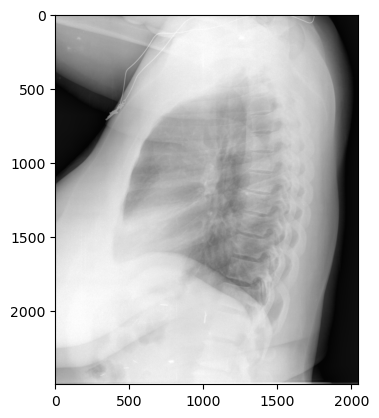

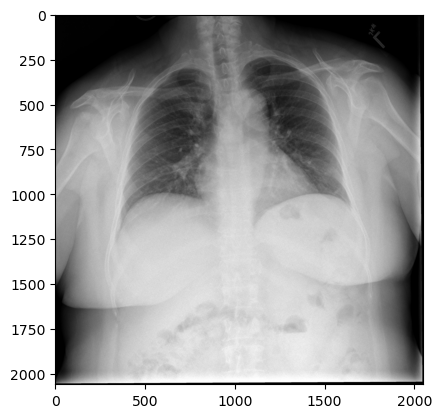

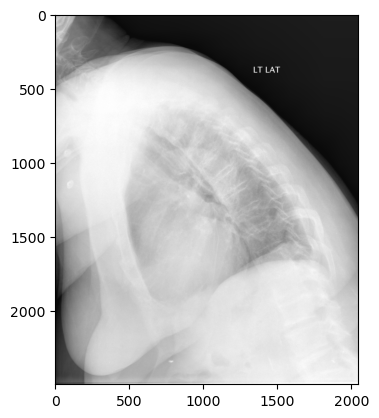

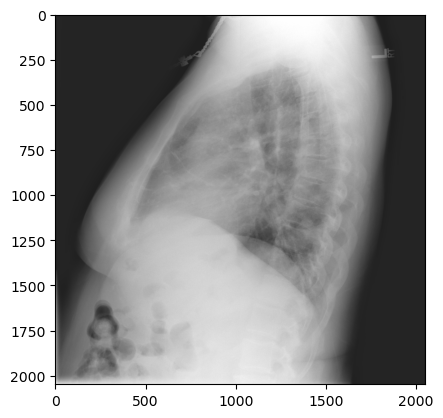

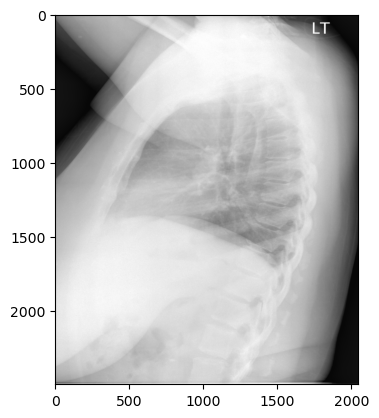

In [3]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

## 2. Creating Image, Caption Dictionary.

In [4]:
import re
# Read in the projections data
projections = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv')

# Read in the reports data
reports = pd.read_csv('/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv')

# Define the path to the images folder
images_folder = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

# Merge the projections and reports data on the UID column
reports = pd.merge(projections, reports, on='uid')

# Create a dictionary of image filenames and their corresponding captions
data = {}
for i in range(len(reports)):
    filename = reports.loc[i, 'filename']
    caption = reports.loc[i, 'impression']
    if filename not in data:
        data[filename] = []
    if isinstance(caption, str) and re.match(r'^\d+\.', caption):
        data[filename].append(caption.split('. ')[1])
    else:
        if data[filename]:
            data[filename][-1] += " " + caption
        else:
            data[filename].append(caption)

## 3. Captions Pre-Processing.

In [5]:
def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            if isinstance(line1, str):
                for j in line1.split():
                    if len(j) < 2:
                        continue
                    j = j.lower()
                    lines += j + " "
                if key not in dict_2:
                    dict_2[key] = list()
                dict_2[key].append(lines)
    return dict_2

data2 = cleanse_data(data)
print(len(data2))

7414


In [6]:
# convert the following into a vocabulary of words and calculate the total words

def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

# summarize vocabulary
vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

1891


In [7]:
def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'captions1.txt')

In [11]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D
from keras.layers import Flatten, Concatenate, Dropout, BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
import numpy as np
import pickle
import os
from tqdm import tqdm
from tensorflow.keras.utils import load_img, img_to_array

def chexnet(input_shape=(224,224,3), weights_path=None):
    input_layer = Input(shape=input_shape, name='input_1')
    densenet = DenseNet121(weights=None, include_top=False, input_tensor=input_layer)

    if weights_path is not None:
        densenet.load_weights(weights_path, by_name=True)

    x = densenet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(14, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)
    model = Model(inputs=densenet.input, outputs=predictions)

    return model

# Define the input shape of the model
input_shape = (224, 224, 3)

# Load the pre-trained CheXNet model
base_model = chexnet(input_shape=input_shape, weights_path='/kaggle/input/chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

# Function to encode a given image into a vector
def encode(image):
    image = preprocess_input(image) # preprocess the image
    fea_vec = base_model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape
    return fea_vec

# Define the directory containing the chest X-ray images
img_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'

# Get a list of all the image filenames in the directory
img_list = os.listdir(img_dir)

encoding = {}

for img_filename in tqdm(img_list):
    # Load the image from the file
    img_path = os.path.join(img_dir, img_filename)
    img = load_img(img_path, target_size=input_shape[:2])
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Encode the image and store the encoding vector
    encoding[img_filename] = encode(x)

# Save the encoding vectors as a pickle file
with open("encodings.pkl", "wb") as f:
    pickle.dump(encoding, f)

  0%|          | 0/7470 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  0%|          | 1/7470 [00:02<5:55:26,  2.86s/it]

1/1 [==============================] - 0s 157ms/step


  0%|          | 2/7470 [00:03<2:46:19,  1.34s/it]

1/1 [==============================] - 0s 152ms/step


  0%|          | 3/7470 [00:03<1:46:37,  1.17it/s]

1/1 [==============================] - 0s 152ms/step


  0%|          | 4/7470 [00:03<1:16:54,  1.62it/s]

1/1 [==============================] - 0s 155ms/step


  0%|          | 5/7470 [00:03<1:01:18,  2.03it/s]

1/1 [==============================] - 0s 151ms/step


  0%|          | 6/7470 [00:04<54:36,  2.28it/s]  

1/1 [==============================] - 0s 127ms/step


  0%|          | 7/7470 [00:04<49:33,  2.51it/s]

1/1 [==============================] - 0s 124ms/step


  0%|          | 8/7470 [00:04<43:41,  2.85it/s]

1/1 [==============================] - 0s 118ms/step


  0%|          | 9/7470 [00:05<41:42,  2.98it/s]

1/1 [==============================] - 0s 123ms/step


  0%|          | 10/7470 [00:05<38:57,  3.19it/s]

1/1 [==============================] - 0s 131ms/step


  0%|          | 11/7470 [00:05<38:29,  3.23it/s]

1/1 [==============================] - 0s 132ms/step


  0%|          | 12/7470 [00:05<37:52,  3.28it/s]

1/1 [==============================] - 0s 128ms/step


  0%|          | 13/7470 [00:06<37:01,  3.36it/s]

1/1 [==============================] - 0s 134ms/step


  0%|          | 14/7470 [00:06<36:15,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


  0%|          | 15/7470 [00:06<35:30,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


  0%|          | 16/7470 [00:07<33:39,  3.69it/s]

1/1 [==============================] - 0s 144ms/step


  0%|          | 17/7470 [00:07<34:27,  3.60it/s]

1/1 [==============================] - 0s 158ms/step


  0%|          | 18/7470 [00:07<34:27,  3.60it/s]

1/1 [==============================] - 0s 149ms/step


  0%|          | 19/7470 [00:07<36:33,  3.40it/s]

1/1 [==============================] - 0s 123ms/step


  0%|          | 20/7470 [00:08<34:34,  3.59it/s]

1/1 [==============================] - 0s 127ms/step


  0%|          | 21/7470 [00:08<33:51,  3.67it/s]

1/1 [==============================] - 0s 124ms/step


  0%|          | 22/7470 [00:08<33:49,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


  0%|          | 23/7470 [00:09<33:24,  3.72it/s]

1/1 [==============================] - 0s 129ms/step


  0%|          | 24/7470 [00:09<32:51,  3.78it/s]

1/1 [==============================] - 0s 152ms/step


  0%|          | 25/7470 [00:09<35:54,  3.45it/s]

1/1 [==============================] - 0s 137ms/step


  0%|          | 26/7470 [00:09<34:50,  3.56it/s]

1/1 [==============================] - 0s 125ms/step


  0%|          | 27/7470 [00:10<35:01,  3.54it/s]

1/1 [==============================] - 0s 127ms/step


  0%|          | 28/7470 [00:10<33:43,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


  0%|          | 29/7470 [00:10<33:29,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


  0%|          | 30/7470 [00:10<33:54,  3.66it/s]

1/1 [==============================] - 0s 129ms/step


  0%|          | 31/7470 [00:11<34:32,  3.59it/s]

1/1 [==============================] - 0s 130ms/step


  0%|          | 32/7470 [00:11<34:19,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


  0%|          | 33/7470 [00:11<37:07,  3.34it/s]

1/1 [==============================] - 0s 126ms/step


  0%|          | 34/7470 [00:12<35:57,  3.45it/s]

1/1 [==============================] - 0s 129ms/step


  0%|          | 35/7470 [00:12<38:08,  3.25it/s]

1/1 [==============================] - 0s 131ms/step


  0%|          | 36/7470 [00:12<36:51,  3.36it/s]

1/1 [==============================] - 0s 136ms/step


  0%|          | 37/7470 [00:13<36:15,  3.42it/s]

1/1 [==============================] - 0s 131ms/step


  1%|          | 38/7470 [00:13<35:31,  3.49it/s]

1/1 [==============================] - 0s 156ms/step


  1%|          | 39/7470 [00:13<35:34,  3.48it/s]

1/1 [==============================] - 0s 139ms/step


  1%|          | 40/7470 [00:13<35:46,  3.46it/s]

1/1 [==============================] - 0s 128ms/step


  1%|          | 41/7470 [00:14<36:41,  3.37it/s]

1/1 [==============================] - 0s 128ms/step


  1%|          | 42/7470 [00:14<34:36,  3.58it/s]

1/1 [==============================] - 0s 141ms/step


  1%|          | 43/7470 [00:14<35:01,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


  1%|          | 44/7470 [00:15<36:14,  3.42it/s]

1/1 [==============================] - 0s 129ms/step


  1%|          | 45/7470 [00:15<34:07,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


  1%|          | 46/7470 [00:15<33:42,  3.67it/s]

1/1 [==============================] - 0s 130ms/step


  1%|          | 47/7470 [00:15<33:39,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


  1%|          | 48/7470 [00:16<32:30,  3.80it/s]

1/1 [==============================] - 0s 132ms/step


  1%|          | 49/7470 [00:16<34:59,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


  1%|          | 50/7470 [00:16<33:56,  3.64it/s]

1/1 [==============================] - 0s 134ms/step


  1%|          | 51/7470 [00:16<34:03,  3.63it/s]

1/1 [==============================] - 0s 130ms/step


  1%|          | 52/7470 [00:17<34:29,  3.58it/s]

1/1 [==============================] - 0s 132ms/step


  1%|          | 53/7470 [00:17<35:03,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


  1%|          | 54/7470 [00:17<33:50,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


  1%|          | 55/7470 [00:17<32:34,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


  1%|          | 56/7470 [00:18<31:19,  3.94it/s]

1/1 [==============================] - 0s 126ms/step


  1%|          | 57/7470 [00:18<30:52,  4.00it/s]

1/1 [==============================] - 0s 127ms/step


  1%|          | 58/7470 [00:18<30:38,  4.03it/s]

1/1 [==============================] - 0s 123ms/step


  1%|          | 59/7470 [00:18<30:47,  4.01it/s]

1/1 [==============================] - 0s 126ms/step


  1%|          | 60/7470 [00:19<31:34,  3.91it/s]

1/1 [==============================] - 0s 140ms/step


  1%|          | 61/7470 [00:19<32:06,  3.85it/s]

1/1 [==============================] - 0s 126ms/step


  1%|          | 62/7470 [00:19<32:02,  3.85it/s]

1/1 [==============================] - 0s 125ms/step


  1%|          | 63/7470 [00:20<34:50,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


  1%|          | 64/7470 [00:20<34:37,  3.57it/s]

1/1 [==============================] - 0s 130ms/step


  1%|          | 65/7470 [00:20<34:49,  3.54it/s]

1/1 [==============================] - 0s 127ms/step


  1%|          | 66/7470 [00:20<34:09,  3.61it/s]

1/1 [==============================] - 0s 124ms/step


  1%|          | 67/7470 [00:21<34:31,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


  1%|          | 68/7470 [00:21<33:27,  3.69it/s]

1/1 [==============================] - 0s 126ms/step


  1%|          | 69/7470 [00:21<32:48,  3.76it/s]

1/1 [==============================] - 0s 124ms/step


  1%|          | 70/7470 [00:21<32:33,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


  1%|          | 71/7470 [00:22<33:39,  3.66it/s]

1/1 [==============================] - 0s 156ms/step


  1%|          | 72/7470 [00:22<33:45,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


  1%|          | 73/7470 [00:22<32:32,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


  1%|          | 74/7470 [00:23<31:27,  3.92it/s]

1/1 [==============================] - 0s 122ms/step


  1%|          | 75/7470 [00:23<32:10,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


  1%|          | 76/7470 [00:23<32:47,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


  1%|          | 77/7470 [00:23<34:22,  3.58it/s]

1/1 [==============================] - 0s 125ms/step


  1%|          | 78/7470 [00:24<34:34,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


  1%|          | 79/7470 [00:24<34:31,  3.57it/s]

1/1 [==============================] - 0s 135ms/step


  1%|          | 80/7470 [00:24<33:50,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


  1%|          | 81/7470 [00:24<32:37,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


  1%|          | 82/7470 [00:25<32:19,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


  1%|          | 83/7470 [00:25<32:16,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


  1%|          | 84/7470 [00:25<34:03,  3.61it/s]

1/1 [==============================] - 0s 128ms/step


  1%|          | 85/7470 [00:26<32:58,  3.73it/s]

1/1 [==============================] - 0s 131ms/step


  1%|          | 86/7470 [00:26<34:48,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


  1%|          | 87/7470 [00:26<34:19,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


  1%|          | 88/7470 [00:26<34:58,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


  1%|          | 89/7470 [00:27<34:16,  3.59it/s]

1/1 [==============================] - 0s 133ms/step


  1%|          | 90/7470 [00:27<34:44,  3.54it/s]

1/1 [==============================] - 0s 125ms/step


  1%|          | 91/7470 [00:27<34:29,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


  1%|          | 92/7470 [00:28<34:44,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


  1%|          | 93/7470 [00:28<34:14,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


  1%|▏         | 94/7470 [00:28<32:24,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


  1%|▏         | 95/7470 [00:28<33:24,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


  1%|▏         | 96/7470 [00:29<32:25,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


  1%|▏         | 97/7470 [00:29<31:30,  3.90it/s]

1/1 [==============================] - 0s 133ms/step


  1%|▏         | 98/7470 [00:29<32:16,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


  1%|▏         | 99/7470 [00:29<32:57,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


  1%|▏         | 100/7470 [00:30<32:31,  3.78it/s]

1/1 [==============================] - 0s 126ms/step


  1%|▏         | 101/7470 [00:30<32:02,  3.83it/s]

1/1 [==============================] - 0s 123ms/step


  1%|▏         | 102/7470 [00:30<32:48,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


  1%|▏         | 103/7470 [00:30<34:01,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


  1%|▏         | 104/7470 [00:31<34:06,  3.60it/s]

1/1 [==============================] - 0s 131ms/step


  1%|▏         | 105/7470 [00:31<34:35,  3.55it/s]

1/1 [==============================] - 0s 128ms/step


  1%|▏         | 106/7470 [00:31<33:32,  3.66it/s]

1/1 [==============================] - 0s 129ms/step


  1%|▏         | 107/7470 [00:32<34:00,  3.61it/s]

1/1 [==============================] - 0s 133ms/step


  1%|▏         | 108/7470 [00:32<33:22,  3.68it/s]

1/1 [==============================] - 0s 165ms/step


  1%|▏         | 109/7470 [00:32<33:36,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


  1%|▏         | 110/7470 [00:32<33:18,  3.68it/s]

1/1 [==============================] - 0s 117ms/step


  1%|▏         | 111/7470 [00:33<32:33,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


  1%|▏         | 112/7470 [00:33<32:14,  3.80it/s]

1/1 [==============================] - 0s 117ms/step


  2%|▏         | 113/7470 [00:33<32:38,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


  2%|▏         | 114/7470 [00:33<31:35,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


  2%|▏         | 115/7470 [00:34<32:53,  3.73it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▏         | 116/7470 [00:34<31:54,  3.84it/s]

1/1 [==============================] - 0s 148ms/step


  2%|▏         | 117/7470 [00:34<34:25,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


  2%|▏         | 118/7470 [00:35<36:36,  3.35it/s]

1/1 [==============================] - 0s 145ms/step


  2%|▏         | 119/7470 [00:35<36:25,  3.36it/s]

1/1 [==============================] - 0s 144ms/step


  2%|▏         | 120/7470 [00:35<36:09,  3.39it/s]

1/1 [==============================] - 0s 146ms/step


  2%|▏         | 121/7470 [00:35<36:55,  3.32it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▏         | 122/7470 [00:36<35:45,  3.42it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▏         | 123/7470 [00:36<35:19,  3.47it/s]

1/1 [==============================] - 0s 121ms/step


  2%|▏         | 124/7470 [00:36<35:17,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▏         | 125/7470 [00:37<36:15,  3.38it/s]

1/1 [==============================] - 0s 121ms/step


  2%|▏         | 126/7470 [00:37<34:24,  3.56it/s]

1/1 [==============================] - 0s 137ms/step


  2%|▏         | 127/7470 [00:37<35:21,  3.46it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▏         | 128/7470 [00:37<34:14,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


  2%|▏         | 129/7470 [00:38<32:30,  3.76it/s]

1/1 [==============================] - 0s 120ms/step


  2%|▏         | 130/7470 [00:38<31:39,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


  2%|▏         | 131/7470 [00:38<30:41,  3.99it/s]

1/1 [==============================] - 0s 121ms/step


  2%|▏         | 132/7470 [00:38<31:27,  3.89it/s]

1/1 [==============================] - 0s 127ms/step


  2%|▏         | 133/7470 [00:39<31:14,  3.91it/s]

1/1 [==============================] - 0s 119ms/step


  2%|▏         | 134/7470 [00:39<31:52,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


  2%|▏         | 135/7470 [00:39<32:34,  3.75it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▏         | 136/7470 [00:39<32:06,  3.81it/s]

1/1 [==============================] - 0s 130ms/step


  2%|▏         | 137/7470 [00:40<32:33,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


  2%|▏         | 138/7470 [00:40<32:36,  3.75it/s]

1/1 [==============================] - 0s 135ms/step


  2%|▏         | 139/7470 [00:40<34:20,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


  2%|▏         | 140/7470 [00:41<35:01,  3.49it/s]

1/1 [==============================] - 0s 126ms/step


  2%|▏         | 141/7470 [00:41<34:36,  3.53it/s]

1/1 [==============================] - 0s 131ms/step


  2%|▏         | 142/7470 [00:41<33:15,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


  2%|▏         | 143/7470 [00:41<35:01,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


  2%|▏         | 144/7470 [00:42<35:52,  3.40it/s]

1/1 [==============================] - 0s 161ms/step


  2%|▏         | 145/7470 [00:42<34:53,  3.50it/s]

1/1 [==============================] - 0s 117ms/step


  2%|▏         | 146/7470 [00:42<32:44,  3.73it/s]

1/1 [==============================] - 0s 120ms/step


  2%|▏         | 147/7470 [00:43<32:54,  3.71it/s]

1/1 [==============================] - 0s 117ms/step


  2%|▏         | 148/7470 [00:43<33:56,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


  2%|▏         | 149/7470 [00:43<32:21,  3.77it/s]

1/1 [==============================] - 0s 128ms/step


  2%|▏         | 150/7470 [00:43<31:47,  3.84it/s]

1/1 [==============================] - 0s 120ms/step


  2%|▏         | 151/7470 [00:44<31:39,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


  2%|▏         | 152/7470 [00:44<32:59,  3.70it/s]

1/1 [==============================] - 0s 118ms/step


  2%|▏         | 153/7470 [00:44<32:40,  3.73it/s]

1/1 [==============================] - 0s 127ms/step


  2%|▏         | 154/7470 [00:44<34:03,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


  2%|▏         | 155/7470 [00:45<32:49,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


  2%|▏         | 156/7470 [00:45<34:02,  3.58it/s]

1/1 [==============================] - 0s 118ms/step


  2%|▏         | 157/7470 [00:45<32:40,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


  2%|▏         | 158/7470 [00:46<31:33,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


  2%|▏         | 159/7470 [00:46<32:22,  3.76it/s]

1/1 [==============================] - 0s 138ms/step


  2%|▏         | 160/7470 [00:46<32:25,  3.76it/s]

1/1 [==============================] - 0s 129ms/step


  2%|▏         | 161/7470 [00:46<34:06,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


  2%|▏         | 162/7470 [00:47<35:27,  3.44it/s]

1/1 [==============================] - 0s 119ms/step


  2%|▏         | 163/7470 [00:47<34:58,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


  2%|▏         | 164/7470 [00:47<33:52,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


  2%|▏         | 165/7470 [00:47<33:40,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


  2%|▏         | 166/7470 [00:48<33:16,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


  2%|▏         | 167/7470 [00:48<32:48,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


  2%|▏         | 168/7470 [00:48<32:47,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


  2%|▏         | 169/7470 [00:49<32:23,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


  2%|▏         | 170/7470 [00:49<32:33,  3.74it/s]

1/1 [==============================] - 0s 127ms/step


  2%|▏         | 171/7470 [00:49<33:10,  3.67it/s]

1/1 [==============================] - 0s 121ms/step


  2%|▏         | 172/7470 [00:49<33:29,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


  2%|▏         | 173/7470 [00:50<31:56,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


  2%|▏         | 174/7470 [00:50<30:39,  3.97it/s]

1/1 [==============================] - 0s 123ms/step


  2%|▏         | 175/7470 [00:50<30:02,  4.05it/s]

1/1 [==============================] - 0s 120ms/step


  2%|▏         | 176/7470 [00:50<30:27,  3.99it/s]

1/1 [==============================] - 0s 117ms/step


  2%|▏         | 177/7470 [00:51<30:53,  3.93it/s]

1/1 [==============================] - 0s 116ms/step


  2%|▏         | 178/7470 [00:51<30:40,  3.96it/s]

1/1 [==============================] - 0s 124ms/step


  2%|▏         | 179/7470 [00:51<32:08,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


  2%|▏         | 180/7470 [00:51<32:15,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


  2%|▏         | 181/7470 [00:52<32:19,  3.76it/s]

1/1 [==============================] - 0s 124ms/step


  2%|▏         | 182/7470 [00:52<33:29,  3.63it/s]

1/1 [==============================] - 0s 120ms/step


  2%|▏         | 183/7470 [00:52<32:03,  3.79it/s]

1/1 [==============================] - 0s 118ms/step


  2%|▏         | 184/7470 [00:53<33:09,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


  2%|▏         | 185/7470 [00:53<32:23,  3.75it/s]

1/1 [==============================] - 0s 117ms/step


  2%|▏         | 186/7470 [00:53<31:29,  3.86it/s]

1/1 [==============================] - 0s 117ms/step


  3%|▎         | 187/7470 [00:53<32:55,  3.69it/s]

1/1 [==============================] - 0s 118ms/step


  3%|▎         | 188/7470 [00:54<33:53,  3.58it/s]

1/1 [==============================] - 0s 118ms/step


  3%|▎         | 189/7470 [00:54<33:18,  3.64it/s]

1/1 [==============================] - 0s 119ms/step


  3%|▎         | 190/7470 [00:54<31:40,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


  3%|▎         | 191/7470 [00:54<31:41,  3.83it/s]

1/1 [==============================] - 0s 119ms/step


  3%|▎         | 192/7470 [00:55<30:49,  3.94it/s]

1/1 [==============================] - 0s 119ms/step


  3%|▎         | 193/7470 [00:55<31:20,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


  3%|▎         | 194/7470 [00:55<31:51,  3.81it/s]

1/1 [==============================] - 0s 117ms/step


  3%|▎         | 195/7470 [00:55<31:40,  3.83it/s]

1/1 [==============================] - 0s 119ms/step


  3%|▎         | 196/7470 [00:56<31:04,  3.90it/s]

1/1 [==============================] - 0s 117ms/step


  3%|▎         | 197/7470 [00:56<30:37,  3.96it/s]

1/1 [==============================] - 0s 125ms/step


  3%|▎         | 198/7470 [00:56<31:29,  3.85it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 199/7470 [00:56<31:20,  3.87it/s]

1/1 [==============================] - 0s 117ms/step


  3%|▎         | 200/7470 [00:57<31:48,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


  3%|▎         | 201/7470 [00:57<32:04,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 202/7470 [00:57<30:49,  3.93it/s]

1/1 [==============================] - 0s 141ms/step


  3%|▎         | 203/7470 [00:57<30:55,  3.92it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 204/7470 [00:58<31:55,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


  3%|▎         | 205/7470 [00:58<31:17,  3.87it/s]

1/1 [==============================] - 0s 123ms/step


  3%|▎         | 206/7470 [00:58<31:35,  3.83it/s]

1/1 [==============================] - 0s 120ms/step


  3%|▎         | 207/7470 [00:58<30:38,  3.95it/s]

1/1 [==============================] - 0s 122ms/step


  3%|▎         | 208/7470 [00:59<30:40,  3.95it/s]

1/1 [==============================] - 0s 127ms/step


  3%|▎         | 209/7470 [00:59<31:42,  3.82it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 210/7470 [00:59<32:52,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


  3%|▎         | 211/7470 [01:00<33:25,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


  3%|▎         | 212/7470 [01:00<32:55,  3.67it/s]

1/1 [==============================] - 0s 128ms/step


  3%|▎         | 213/7470 [01:00<32:06,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


  3%|▎         | 214/7470 [01:00<32:42,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


  3%|▎         | 215/7470 [01:01<32:40,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 216/7470 [01:01<33:32,  3.61it/s]

1/1 [==============================] - 0s 135ms/step


  3%|▎         | 217/7470 [01:01<33:37,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


  3%|▎         | 218/7470 [01:01<32:41,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


  3%|▎         | 219/7470 [01:02<32:31,  3.72it/s]

1/1 [==============================] - 0s 161ms/step


  3%|▎         | 220/7470 [01:02<34:16,  3.53it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 221/7470 [01:02<35:09,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 222/7470 [01:03<33:49,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


  3%|▎         | 223/7470 [01:03<34:23,  3.51it/s]

1/1 [==============================] - 0s 120ms/step


  3%|▎         | 224/7470 [01:03<33:36,  3.59it/s]

1/1 [==============================] - 0s 118ms/step


  3%|▎         | 225/7470 [01:03<33:01,  3.66it/s]

1/1 [==============================] - 0s 118ms/step


  3%|▎         | 226/7470 [01:04<32:58,  3.66it/s]

1/1 [==============================] - 0s 118ms/step


  3%|▎         | 227/7470 [01:04<33:16,  3.63it/s]

1/1 [==============================] - 0s 123ms/step


  3%|▎         | 228/7470 [01:04<34:19,  3.52it/s]

1/1 [==============================] - 0s 119ms/step


  3%|▎         | 229/7470 [01:05<32:16,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 230/7470 [01:05<32:37,  3.70it/s]

1/1 [==============================] - 0s 120ms/step


  3%|▎         | 231/7470 [01:05<31:41,  3.81it/s]

1/1 [==============================] - 0s 120ms/step


  3%|▎         | 232/7470 [01:05<32:27,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


  3%|▎         | 233/7470 [01:06<33:02,  3.65it/s]

1/1 [==============================] - 0s 144ms/step


  3%|▎         | 234/7470 [01:06<33:32,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


  3%|▎         | 235/7470 [01:06<34:59,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


  3%|▎         | 236/7470 [01:07<34:55,  3.45it/s]

1/1 [==============================] - 0s 147ms/step


  3%|▎         | 237/7470 [01:07<35:35,  3.39it/s]

1/1 [==============================] - 0s 149ms/step


  3%|▎         | 238/7470 [01:07<34:21,  3.51it/s]

1/1 [==============================] - 0s 151ms/step


  3%|▎         | 239/7470 [01:07<34:02,  3.54it/s]

1/1 [==============================] - 0s 127ms/step


  3%|▎         | 240/7470 [01:08<32:55,  3.66it/s]

1/1 [==============================] - 0s 141ms/step


  3%|▎         | 241/7470 [01:08<33:28,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


  3%|▎         | 242/7470 [01:08<32:34,  3.70it/s]

1/1 [==============================] - 0s 116ms/step


  3%|▎         | 243/7470 [01:08<33:33,  3.59it/s]

1/1 [==============================] - 0s 123ms/step


  3%|▎         | 244/7470 [01:09<32:19,  3.72it/s]

1/1 [==============================] - 0s 134ms/step


  3%|▎         | 245/7470 [01:09<32:48,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


  3%|▎         | 246/7470 [01:09<34:05,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


  3%|▎         | 247/7470 [01:10<32:54,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 248/7470 [01:10<31:39,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


  3%|▎         | 249/7470 [01:10<31:12,  3.86it/s]

1/1 [==============================] - 0s 116ms/step


  3%|▎         | 250/7470 [01:10<31:33,  3.81it/s]

1/1 [==============================] - 0s 118ms/step


  3%|▎         | 251/7470 [01:11<30:07,  3.99it/s]

1/1 [==============================] - 0s 120ms/step


  3%|▎         | 252/7470 [01:11<29:50,  4.03it/s]

1/1 [==============================] - 0s 120ms/step


  3%|▎         | 253/7470 [01:11<30:22,  3.96it/s]

1/1 [==============================] - 0s 118ms/step


  3%|▎         | 254/7470 [01:11<30:49,  3.90it/s]

1/1 [==============================] - 0s 119ms/step


  3%|▎         | 255/7470 [01:12<30:52,  3.89it/s]

1/1 [==============================] - 0s 130ms/step


  3%|▎         | 256/7470 [01:12<33:37,  3.58it/s]

1/1 [==============================] - 0s 121ms/step


  3%|▎         | 257/7470 [01:12<34:44,  3.46it/s]

1/1 [==============================] - 0s 117ms/step


  3%|▎         | 258/7470 [01:12<33:55,  3.54it/s]

1/1 [==============================] - 0s 119ms/step


  3%|▎         | 259/7470 [01:13<33:33,  3.58it/s]

1/1 [==============================] - 0s 116ms/step


  3%|▎         | 260/7470 [01:13<33:00,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


  3%|▎         | 261/7470 [01:13<32:18,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


  4%|▎         | 262/7470 [01:14<31:52,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


  4%|▎         | 263/7470 [01:14<32:02,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


  4%|▎         | 264/7470 [01:14<31:30,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


  4%|▎         | 265/7470 [01:14<30:53,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


  4%|▎         | 266/7470 [01:15<31:35,  3.80it/s]

1/1 [==============================] - 0s 120ms/step


  4%|▎         | 267/7470 [01:15<31:51,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


  4%|▎         | 268/7470 [01:15<31:41,  3.79it/s]

1/1 [==============================] - 0s 115ms/step


  4%|▎         | 269/7470 [01:15<31:40,  3.79it/s]

1/1 [==============================] - 0s 115ms/step


  4%|▎         | 270/7470 [01:16<30:18,  3.96it/s]

1/1 [==============================] - 0s 119ms/step


  4%|▎         | 271/7470 [01:16<30:50,  3.89it/s]

1/1 [==============================] - 0s 117ms/step


  4%|▎         | 272/7470 [01:16<29:47,  4.03it/s]

1/1 [==============================] - 0s 123ms/step


  4%|▎         | 273/7470 [01:16<31:24,  3.82it/s]

1/1 [==============================] - 0s 118ms/step


  4%|▎         | 274/7470 [01:17<30:53,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


  4%|▎         | 275/7470 [01:17<30:21,  3.95it/s]

1/1 [==============================] - 0s 121ms/step


  4%|▎         | 276/7470 [01:17<30:45,  3.90it/s]

1/1 [==============================] - 0s 123ms/step


  4%|▎         | 277/7470 [01:17<30:41,  3.91it/s]

1/1 [==============================] - 0s 123ms/step


  4%|▎         | 278/7470 [01:18<30:25,  3.94it/s]

1/1 [==============================] - 0s 123ms/step


  4%|▎         | 279/7470 [01:18<31:06,  3.85it/s]

1/1 [==============================] - 0s 128ms/step


  4%|▎         | 280/7470 [01:18<31:55,  3.75it/s]

1/1 [==============================] - 0s 119ms/step


  4%|▍         | 281/7470 [01:18<30:56,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


  4%|▍         | 282/7470 [01:19<29:45,  4.03it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 283/7470 [01:19<31:02,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


  4%|▍         | 284/7470 [01:19<30:47,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


  4%|▍         | 285/7470 [01:19<30:09,  3.97it/s]

1/1 [==============================] - 0s 119ms/step


  4%|▍         | 286/7470 [01:20<31:11,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


  4%|▍         | 287/7470 [01:20<31:16,  3.83it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 288/7470 [01:20<32:13,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


  4%|▍         | 289/7470 [01:20<31:23,  3.81it/s]

1/1 [==============================] - 0s 119ms/step


  4%|▍         | 290/7470 [01:21<31:55,  3.75it/s]

1/1 [==============================] - 0s 118ms/step


  4%|▍         | 291/7470 [01:21<31:18,  3.82it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 292/7470 [01:21<31:47,  3.76it/s]

1/1 [==============================] - 0s 123ms/step


  4%|▍         | 293/7470 [01:22<30:49,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


  4%|▍         | 294/7470 [01:22<30:19,  3.94it/s]

1/1 [==============================] - 0s 155ms/step


  4%|▍         | 295/7470 [01:22<32:16,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 296/7470 [01:22<32:07,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


  4%|▍         | 297/7470 [01:23<31:20,  3.81it/s]

1/1 [==============================] - 0s 119ms/step


  4%|▍         | 298/7470 [01:23<31:23,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 299/7470 [01:23<31:57,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 300/7470 [01:23<32:25,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


  4%|▍         | 301/7470 [01:24<32:01,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


  4%|▍         | 302/7470 [01:24<32:37,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


  4%|▍         | 303/7470 [01:24<32:56,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


  4%|▍         | 304/7470 [01:24<31:59,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


  4%|▍         | 305/7470 [01:25<31:03,  3.84it/s]

1/1 [==============================] - 0s 130ms/step


  4%|▍         | 306/7470 [01:25<32:04,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


  4%|▍         | 307/7470 [01:25<31:40,  3.77it/s]

1/1 [==============================] - 0s 129ms/step


  4%|▍         | 308/7470 [01:26<33:25,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 309/7470 [01:26<31:57,  3.73it/s]

1/1 [==============================] - 0s 131ms/step


  4%|▍         | 310/7470 [01:26<30:51,  3.87it/s]

1/1 [==============================] - 0s 134ms/step


  4%|▍         | 311/7470 [01:26<33:17,  3.58it/s]

1/1 [==============================] - 0s 119ms/step


  4%|▍         | 312/7470 [01:27<32:13,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


  4%|▍         | 313/7470 [01:27<31:22,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


  4%|▍         | 314/7470 [01:27<31:52,  3.74it/s]

1/1 [==============================] - 0s 134ms/step


  4%|▍         | 315/7470 [01:27<31:32,  3.78it/s]

1/1 [==============================] - 0s 127ms/step


  4%|▍         | 316/7470 [01:28<32:05,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


  4%|▍         | 317/7470 [01:28<31:48,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 318/7470 [01:28<31:41,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


  4%|▍         | 319/7470 [01:29<32:30,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 320/7470 [01:29<32:17,  3.69it/s]

1/1 [==============================] - 0s 147ms/step


  4%|▍         | 321/7470 [01:29<34:17,  3.48it/s]

1/1 [==============================] - 0s 136ms/step


  4%|▍         | 322/7470 [01:29<34:22,  3.47it/s]

1/1 [==============================] - 0s 127ms/step


  4%|▍         | 323/7470 [01:30<34:58,  3.41it/s]

1/1 [==============================] - 0s 124ms/step


  4%|▍         | 324/7470 [01:30<33:29,  3.56it/s]

1/1 [==============================] - 0s 136ms/step


  4%|▍         | 325/7470 [01:30<33:53,  3.51it/s]

1/1 [==============================] - 0s 130ms/step


  4%|▍         | 326/7470 [01:31<33:57,  3.51it/s]

1/1 [==============================] - 0s 124ms/step


  4%|▍         | 327/7470 [01:31<33:21,  3.57it/s]

1/1 [==============================] - 0s 135ms/step


  4%|▍         | 328/7470 [01:31<33:43,  3.53it/s]

1/1 [==============================] - 0s 128ms/step


  4%|▍         | 329/7470 [01:31<33:27,  3.56it/s]

1/1 [==============================] - 0s 132ms/step


  4%|▍         | 330/7470 [01:32<33:28,  3.55it/s]

1/1 [==============================] - 0s 125ms/step


  4%|▍         | 331/7470 [01:32<32:43,  3.63it/s]

1/1 [==============================] - 0s 134ms/step


  4%|▍         | 332/7470 [01:32<33:32,  3.55it/s]

1/1 [==============================] - 0s 122ms/step


  4%|▍         | 333/7470 [01:32<31:56,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


  4%|▍         | 334/7470 [01:33<31:23,  3.79it/s]

1/1 [==============================] - 0s 119ms/step


  4%|▍         | 335/7470 [01:33<30:10,  3.94it/s]

1/1 [==============================] - 0s 128ms/step


  4%|▍         | 336/7470 [01:33<30:03,  3.96it/s]

1/1 [==============================] - 0s 126ms/step


  5%|▍         | 337/7470 [01:33<31:04,  3.82it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▍         | 338/7470 [01:34<30:47,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▍         | 339/7470 [01:34<31:09,  3.81it/s]

1/1 [==============================] - 0s 129ms/step


  5%|▍         | 340/7470 [01:35<42:42,  2.78it/s]

1/1 [==============================] - 0s 132ms/step


  5%|▍         | 341/7470 [01:35<39:03,  3.04it/s]

1/1 [==============================] - 0s 134ms/step


  5%|▍         | 342/7470 [01:35<36:52,  3.22it/s]

1/1 [==============================] - 0s 130ms/step


  5%|▍         | 343/7470 [01:35<34:33,  3.44it/s]

1/1 [==============================] - 0s 134ms/step


  5%|▍         | 344/7470 [01:36<33:37,  3.53it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▍         | 345/7470 [01:36<32:18,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▍         | 346/7470 [01:36<32:37,  3.64it/s]

1/1 [==============================] - 0s 135ms/step


  5%|▍         | 347/7470 [01:36<33:02,  3.59it/s]

1/1 [==============================] - 0s 131ms/step


  5%|▍         | 348/7470 [01:37<33:44,  3.52it/s]

1/1 [==============================] - 0s 135ms/step


  5%|▍         | 349/7470 [01:37<33:00,  3.60it/s]

1/1 [==============================] - 0s 143ms/step


  5%|▍         | 350/7470 [01:37<34:29,  3.44it/s]

1/1 [==============================] - 0s 149ms/step


  5%|▍         | 351/7470 [01:38<34:57,  3.39it/s]

1/1 [==============================] - 0s 161ms/step


  5%|▍         | 352/7470 [01:38<35:17,  3.36it/s]

1/1 [==============================] - 0s 177ms/step


  5%|▍         | 353/7470 [01:38<35:15,  3.36it/s]

1/1 [==============================] - 0s 158ms/step


  5%|▍         | 354/7470 [01:39<35:02,  3.38it/s]

1/1 [==============================] - 0s 161ms/step


  5%|▍         | 355/7470 [01:39<35:13,  3.37it/s]

1/1 [==============================] - 0s 163ms/step


  5%|▍         | 356/7470 [01:39<36:28,  3.25it/s]

1/1 [==============================] - 0s 132ms/step


  5%|▍         | 357/7470 [01:39<36:12,  3.27it/s]

1/1 [==============================] - 0s 132ms/step


  5%|▍         | 358/7470 [01:40<35:34,  3.33it/s]

1/1 [==============================] - 0s 138ms/step


  5%|▍         | 359/7470 [01:40<35:33,  3.33it/s]

1/1 [==============================] - 0s 129ms/step


  5%|▍         | 360/7470 [01:40<33:57,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


  5%|▍         | 361/7470 [01:41<32:27,  3.65it/s]

1/1 [==============================] - 0s 131ms/step


  5%|▍         | 362/7470 [01:41<32:06,  3.69it/s]

1/1 [==============================] - 0s 135ms/step


  5%|▍         | 363/7470 [01:41<32:29,  3.65it/s]

1/1 [==============================] - 0s 133ms/step


  5%|▍         | 364/7470 [01:41<35:16,  3.36it/s]

1/1 [==============================] - 0s 126ms/step


  5%|▍         | 365/7470 [01:42<35:13,  3.36it/s]

1/1 [==============================] - 0s 159ms/step


  5%|▍         | 366/7470 [01:42<35:39,  3.32it/s]

1/1 [==============================] - 0s 131ms/step


  5%|▍         | 367/7470 [01:42<36:26,  3.25it/s]

1/1 [==============================] - 0s 129ms/step


  5%|▍         | 368/7470 [01:43<35:32,  3.33it/s]

1/1 [==============================] - 0s 120ms/step


  5%|▍         | 369/7470 [01:43<34:17,  3.45it/s]

1/1 [==============================] - 0s 132ms/step


  5%|▍         | 370/7470 [01:43<34:55,  3.39it/s]

1/1 [==============================] - 0s 125ms/step


  5%|▍         | 371/7470 [01:44<34:46,  3.40it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▍         | 372/7470 [01:44<34:05,  3.47it/s]

1/1 [==============================] - 0s 131ms/step


  5%|▍         | 373/7470 [01:44<33:23,  3.54it/s]

1/1 [==============================] - 0s 129ms/step


  5%|▌         | 374/7470 [01:44<32:28,  3.64it/s]

1/1 [==============================] - 0s 132ms/step


  5%|▌         | 375/7470 [01:45<33:22,  3.54it/s]

1/1 [==============================] - 0s 125ms/step


  5%|▌         | 376/7470 [01:45<34:40,  3.41it/s]

1/1 [==============================] - 0s 122ms/step


  5%|▌         | 377/7470 [01:45<33:32,  3.52it/s]

1/1 [==============================] - 0s 120ms/step


  5%|▌         | 378/7470 [01:45<32:00,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


  5%|▌         | 379/7470 [01:46<31:43,  3.73it/s]

1/1 [==============================] - 0s 116ms/step


  5%|▌         | 380/7470 [01:46<31:02,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


  5%|▌         | 381/7470 [01:46<31:54,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▌         | 382/7470 [01:47<32:12,  3.67it/s]

1/1 [==============================] - 0s 118ms/step


  5%|▌         | 383/7470 [01:47<31:30,  3.75it/s]

1/1 [==============================] - 0s 134ms/step


  5%|▌         | 384/7470 [01:47<31:19,  3.77it/s]

1/1 [==============================] - 0s 126ms/step


  5%|▌         | 385/7470 [01:47<31:58,  3.69it/s]

1/1 [==============================] - 0s 117ms/step


  5%|▌         | 386/7470 [01:48<30:28,  3.87it/s]

1/1 [==============================] - 0s 116ms/step


  5%|▌         | 387/7470 [01:48<29:25,  4.01it/s]

1/1 [==============================] - 0s 125ms/step


  5%|▌         | 388/7470 [01:48<29:28,  4.01it/s]

1/1 [==============================] - 0s 131ms/step


  5%|▌         | 389/7470 [01:48<29:12,  4.04it/s]

1/1 [==============================] - 0s 122ms/step


  5%|▌         | 390/7470 [01:48<28:52,  4.09it/s]

1/1 [==============================] - 0s 126ms/step


  5%|▌         | 391/7470 [01:49<28:33,  4.13it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▌         | 392/7470 [01:49<29:53,  3.95it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▌         | 393/7470 [01:49<31:21,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


  5%|▌         | 394/7470 [01:50<32:01,  3.68it/s]

1/1 [==============================] - 0s 128ms/step


  5%|▌         | 395/7470 [01:50<31:25,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▌         | 396/7470 [01:50<31:12,  3.78it/s]

1/1 [==============================] - 0s 127ms/step


  5%|▌         | 397/7470 [01:50<31:48,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


  5%|▌         | 398/7470 [01:51<31:56,  3.69it/s]

1/1 [==============================] - 0s 126ms/step


  5%|▌         | 399/7470 [01:51<31:42,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


  5%|▌         | 400/7470 [01:51<31:34,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


  5%|▌         | 401/7470 [01:51<31:03,  3.79it/s]

1/1 [==============================] - 0s 126ms/step


  5%|▌         | 402/7470 [01:52<31:45,  3.71it/s]

1/1 [==============================] - 0s 173ms/step


  5%|▌         | 403/7470 [01:52<34:33,  3.41it/s]

1/1 [==============================] - 0s 126ms/step


  5%|▌         | 404/7470 [01:52<33:09,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


  5%|▌         | 405/7470 [01:53<33:32,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


  5%|▌         | 406/7470 [01:53<34:23,  3.42it/s]

1/1 [==============================] - 0s 128ms/step


  5%|▌         | 407/7470 [01:53<32:38,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


  5%|▌         | 408/7470 [01:53<31:40,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


  5%|▌         | 409/7470 [01:54<31:08,  3.78it/s]

1/1 [==============================] - 0s 122ms/step


  5%|▌         | 410/7470 [01:54<30:41,  3.83it/s]

1/1 [==============================] - 0s 139ms/step


  6%|▌         | 411/7470 [01:54<31:55,  3.69it/s]

1/1 [==============================] - 0s 127ms/step


  6%|▌         | 412/7470 [01:54<31:35,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


  6%|▌         | 413/7470 [01:55<31:49,  3.70it/s]

1/1 [==============================] - 0s 130ms/step


  6%|▌         | 414/7470 [01:55<31:18,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


  6%|▌         | 415/7470 [01:55<29:55,  3.93it/s]

1/1 [==============================] - 0s 121ms/step


  6%|▌         | 416/7470 [01:56<30:12,  3.89it/s]

1/1 [==============================] - 0s 122ms/step


  6%|▌         | 417/7470 [01:56<30:34,  3.85it/s]

1/1 [==============================] - 0s 125ms/step


  6%|▌         | 418/7470 [01:56<32:03,  3.67it/s]

1/1 [==============================] - 0s 124ms/step


  6%|▌         | 419/7470 [01:56<30:54,  3.80it/s]

1/1 [==============================] - 0s 130ms/step


  6%|▌         | 420/7470 [01:57<31:33,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


  6%|▌         | 421/7470 [01:57<31:10,  3.77it/s]

1/1 [==============================] - 0s 135ms/step


  6%|▌         | 422/7470 [01:57<31:01,  3.79it/s]

1/1 [==============================] - 0s 139ms/step


  6%|▌         | 423/7470 [01:57<31:16,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


  6%|▌         | 424/7470 [01:58<31:21,  3.75it/s]

1/1 [==============================] - 0s 132ms/step


  6%|▌         | 425/7470 [01:58<33:09,  3.54it/s]

1/1 [==============================] - 0s 134ms/step


  6%|▌         | 426/7470 [01:58<32:23,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


  6%|▌         | 427/7470 [01:58<31:33,  3.72it/s]

1/1 [==============================] - 0s 133ms/step


  6%|▌         | 428/7470 [01:59<32:19,  3.63it/s]

1/1 [==============================] - 0s 173ms/step


  6%|▌         | 429/7470 [01:59<33:15,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


  6%|▌         | 430/7470 [01:59<32:58,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


  6%|▌         | 431/7470 [02:00<34:48,  3.37it/s]

1/1 [==============================] - 0s 127ms/step


  6%|▌         | 432/7470 [02:00<34:27,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


  6%|▌         | 433/7470 [02:00<32:52,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


  6%|▌         | 434/7470 [02:01<32:42,  3.59it/s]

1/1 [==============================] - 0s 144ms/step


  6%|▌         | 435/7470 [02:01<33:32,  3.50it/s]

1/1 [==============================] - 0s 137ms/step


  6%|▌         | 436/7470 [02:01<32:19,  3.63it/s]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 437/7470 [02:01<32:58,  3.55it/s]

1/1 [==============================] - 0s 145ms/step


  6%|▌         | 438/7470 [02:02<33:15,  3.52it/s]

1/1 [==============================] - 0s 145ms/step


  6%|▌         | 439/7470 [02:02<33:12,  3.53it/s]

1/1 [==============================] - 0s 144ms/step


  6%|▌         | 440/7470 [02:02<34:02,  3.44it/s]

1/1 [==============================] - 0s 141ms/step


  6%|▌         | 441/7470 [02:03<34:11,  3.43it/s]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 442/7470 [02:03<34:28,  3.40it/s]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 443/7470 [02:03<35:04,  3.34it/s]

1/1 [==============================] - 0s 152ms/step


  6%|▌         | 444/7470 [02:04<38:00,  3.08it/s]

1/1 [==============================] - 0s 145ms/step


  6%|▌         | 445/7470 [02:04<36:49,  3.18it/s]

1/1 [==============================] - 0s 145ms/step


  6%|▌         | 446/7470 [02:04<35:13,  3.32it/s]

1/1 [==============================] - 0s 147ms/step


  6%|▌         | 447/7470 [02:04<36:22,  3.22it/s]

1/1 [==============================] - 0s 138ms/step


  6%|▌         | 448/7470 [02:05<36:02,  3.25it/s]

1/1 [==============================] - 0s 150ms/step


  6%|▌         | 449/7470 [02:05<35:46,  3.27it/s]

1/1 [==============================] - 0s 122ms/step


  6%|▌         | 450/7470 [02:05<35:43,  3.27it/s]

1/1 [==============================] - 0s 130ms/step


  6%|▌         | 451/7470 [02:06<33:24,  3.50it/s]

1/1 [==============================] - 0s 118ms/step


  6%|▌         | 452/7470 [02:06<34:00,  3.44it/s]

1/1 [==============================] - 0s 122ms/step


  6%|▌         | 453/7470 [02:06<31:51,  3.67it/s]

1/1 [==============================] - 0s 117ms/step


  6%|▌         | 454/7470 [02:06<30:44,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


  6%|▌         | 455/7470 [02:07<30:51,  3.79it/s]

1/1 [==============================] - 0s 134ms/step


  6%|▌         | 456/7470 [02:07<31:30,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


  6%|▌         | 457/7470 [02:07<31:02,  3.76it/s]

1/1 [==============================] - 0s 138ms/step


  6%|▌         | 458/7470 [02:07<32:10,  3.63it/s]

1/1 [==============================] - 0s 133ms/step


  6%|▌         | 459/7470 [02:08<33:13,  3.52it/s]

1/1 [==============================] - 0s 130ms/step


  6%|▌         | 460/7470 [02:08<33:16,  3.51it/s]

1/1 [==============================] - 0s 121ms/step


  6%|▌         | 461/7470 [02:08<31:38,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


  6%|▌         | 462/7470 [02:09<30:37,  3.81it/s]

1/1 [==============================] - 0s 120ms/step


  6%|▌         | 463/7470 [02:09<31:08,  3.75it/s]

1/1 [==============================] - 0s 140ms/step


  6%|▌         | 464/7470 [02:09<34:09,  3.42it/s]

1/1 [==============================] - 0s 147ms/step


  6%|▌         | 465/7470 [02:09<34:09,  3.42it/s]

1/1 [==============================] - 0s 148ms/step


  6%|▌         | 466/7470 [02:10<34:50,  3.35it/s]

1/1 [==============================] - 0s 149ms/step


  6%|▋         | 467/7470 [02:10<35:13,  3.31it/s]

1/1 [==============================] - 0s 148ms/step


  6%|▋         | 468/7470 [02:10<35:43,  3.27it/s]

1/1 [==============================] - 0s 149ms/step


  6%|▋         | 469/7470 [02:11<35:09,  3.32it/s]

1/1 [==============================] - 0s 146ms/step


  6%|▋         | 470/7470 [02:11<35:03,  3.33it/s]

1/1 [==============================] - 0s 124ms/step


  6%|▋         | 471/7470 [02:11<33:50,  3.45it/s]

1/1 [==============================] - 0s 121ms/step


  6%|▋         | 472/7470 [02:11<32:25,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


  6%|▋         | 473/7470 [02:12<32:41,  3.57it/s]

1/1 [==============================] - 0s 144ms/step


  6%|▋         | 474/7470 [02:12<32:02,  3.64it/s]

1/1 [==============================] - 0s 118ms/step


  6%|▋         | 475/7470 [02:12<32:02,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


  6%|▋         | 476/7470 [02:13<31:56,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


  6%|▋         | 477/7470 [02:13<31:31,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


  6%|▋         | 478/7470 [02:13<30:38,  3.80it/s]

1/1 [==============================] - 0s 121ms/step


  6%|▋         | 479/7470 [02:13<30:33,  3.81it/s]

1/1 [==============================] - 0s 123ms/step


  6%|▋         | 480/7470 [02:14<30:14,  3.85it/s]

1/1 [==============================] - 0s 119ms/step


  6%|▋         | 481/7470 [02:14<30:17,  3.85it/s]

1/1 [==============================] - 0s 129ms/step


  6%|▋         | 482/7470 [02:14<31:00,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


  6%|▋         | 483/7470 [02:14<30:24,  3.83it/s]

1/1 [==============================] - 0s 124ms/step


  6%|▋         | 484/7470 [02:15<30:36,  3.80it/s]

1/1 [==============================] - 0s 145ms/step


  6%|▋         | 485/7470 [02:15<33:21,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


  7%|▋         | 486/7470 [02:15<33:30,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


  7%|▋         | 487/7470 [02:16<32:51,  3.54it/s]

1/1 [==============================] - 0s 128ms/step


  7%|▋         | 488/7470 [02:16<32:48,  3.55it/s]

1/1 [==============================] - 0s 129ms/step


  7%|▋         | 489/7470 [02:16<34:00,  3.42it/s]

1/1 [==============================] - 0s 126ms/step


  7%|▋         | 490/7470 [02:16<34:34,  3.36it/s]

1/1 [==============================] - 0s 128ms/step


  7%|▋         | 491/7470 [02:17<34:58,  3.33it/s]

1/1 [==============================] - 0s 131ms/step


  7%|▋         | 492/7470 [02:17<33:45,  3.45it/s]

1/1 [==============================] - 0s 128ms/step


  7%|▋         | 493/7470 [02:17<33:22,  3.48it/s]

1/1 [==============================] - 0s 120ms/step


  7%|▋         | 494/7470 [02:18<33:59,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


  7%|▋         | 495/7470 [02:18<33:23,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


  7%|▋         | 496/7470 [02:18<33:19,  3.49it/s]

1/1 [==============================] - 0s 122ms/step


  7%|▋         | 497/7470 [02:18<33:12,  3.50it/s]

1/1 [==============================] - 0s 129ms/step


  7%|▋         | 498/7470 [02:19<34:14,  3.39it/s]

1/1 [==============================] - 0s 163ms/step


  7%|▋         | 499/7470 [02:19<35:12,  3.30it/s]

1/1 [==============================] - 0s 147ms/step


  7%|▋         | 500/7470 [02:19<35:29,  3.27it/s]

1/1 [==============================] - 0s 121ms/step


  7%|▋         | 501/7470 [02:20<35:11,  3.30it/s]

1/1 [==============================] - 0s 119ms/step


  7%|▋         | 502/7470 [02:20<34:14,  3.39it/s]

1/1 [==============================] - 0s 125ms/step


  7%|▋         | 503/7470 [02:20<32:44,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


  7%|▋         | 504/7470 [02:21<33:00,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


  7%|▋         | 505/7470 [02:21<33:26,  3.47it/s]

1/1 [==============================] - 0s 139ms/step


  7%|▋         | 506/7470 [02:21<33:38,  3.45it/s]

1/1 [==============================] - 0s 125ms/step


  7%|▋         | 507/7470 [02:21<32:55,  3.52it/s]

1/1 [==============================] - 0s 121ms/step


  7%|▋         | 508/7470 [02:22<33:29,  3.46it/s]

1/1 [==============================] - 0s 128ms/step


  7%|▋         | 509/7470 [02:22<32:53,  3.53it/s]

1/1 [==============================] - 0s 128ms/step


  7%|▋         | 510/7470 [02:22<32:14,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


  7%|▋         | 511/7470 [02:23<33:13,  3.49it/s]

1/1 [==============================] - 0s 136ms/step


  7%|▋         | 512/7470 [02:23<33:44,  3.44it/s]

1/1 [==============================] - 0s 127ms/step


  7%|▋         | 513/7470 [02:23<32:51,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


  7%|▋         | 514/7470 [02:23<31:36,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


  7%|▋         | 515/7470 [02:24<31:56,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


  7%|▋         | 516/7470 [02:24<30:37,  3.78it/s]

1/1 [==============================] - 0s 124ms/step


  7%|▋         | 517/7470 [02:24<32:05,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


  7%|▋         | 518/7470 [02:24<33:01,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


  7%|▋         | 519/7470 [02:25<32:30,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


  7%|▋         | 520/7470 [02:25<31:00,  3.74it/s]

1/1 [==============================] - 0s 119ms/step


  7%|▋         | 521/7470 [02:25<30:58,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


  7%|▋         | 522/7470 [02:26<30:48,  3.76it/s]

1/1 [==============================] - 0s 123ms/step


  7%|▋         | 523/7470 [02:26<30:24,  3.81it/s]

1/1 [==============================] - 0s 127ms/step


  7%|▋         | 524/7470 [02:26<30:24,  3.81it/s]

1/1 [==============================] - 0s 127ms/step


  7%|▋         | 525/7470 [02:26<30:35,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


  7%|▋         | 526/7470 [02:27<31:05,  3.72it/s]

1/1 [==============================] - 0s 130ms/step


  7%|▋         | 527/7470 [02:27<32:45,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


  7%|▋         | 528/7470 [02:27<33:47,  3.42it/s]

1/1 [==============================] - 0s 127ms/step


  7%|▋         | 529/7470 [02:27<32:07,  3.60it/s]

1/1 [==============================] - 0s 119ms/step


  7%|▋         | 530/7470 [02:28<32:35,  3.55it/s]

1/1 [==============================] - 0s 120ms/step


  7%|▋         | 531/7470 [02:28<32:33,  3.55it/s]

1/1 [==============================] - 0s 119ms/step


  7%|▋         | 532/7470 [02:28<31:31,  3.67it/s]

1/1 [==============================] - 0s 126ms/step


  7%|▋         | 533/7470 [02:29<32:12,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


  7%|▋         | 534/7470 [02:29<32:43,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


  7%|▋         | 535/7470 [02:29<33:56,  3.41it/s]

1/1 [==============================] - 0s 122ms/step


  7%|▋         | 536/7470 [02:29<34:24,  3.36it/s]

1/1 [==============================] - 0s 121ms/step


  7%|▋         | 537/7470 [02:30<32:07,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


  7%|▋         | 538/7470 [02:30<30:40,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


  7%|▋         | 539/7470 [02:30<30:42,  3.76it/s]

1/1 [==============================] - 0s 120ms/step


  7%|▋         | 540/7470 [02:30<29:27,  3.92it/s]

1/1 [==============================] - 0s 123ms/step


  7%|▋         | 541/7470 [02:31<29:18,  3.94it/s]

1/1 [==============================] - 0s 120ms/step


  7%|▋         | 542/7470 [02:31<28:31,  4.05it/s]

1/1 [==============================] - 0s 119ms/step


  7%|▋         | 543/7470 [02:31<30:27,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


  7%|▋         | 544/7470 [02:32<31:08,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


  7%|▋         | 545/7470 [02:32<32:27,  3.56it/s]

1/1 [==============================] - 0s 129ms/step


  7%|▋         | 546/7470 [02:32<33:01,  3.49it/s]

1/1 [==============================] - 0s 120ms/step


  7%|▋         | 547/7470 [02:32<33:02,  3.49it/s]

1/1 [==============================] - 0s 116ms/step


  7%|▋         | 548/7470 [02:33<31:57,  3.61it/s]

1/1 [==============================] - 0s 117ms/step


  7%|▋         | 549/7470 [02:33<31:28,  3.67it/s]

1/1 [==============================] - 0s 118ms/step


  7%|▋         | 550/7470 [02:33<32:50,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


  7%|▋         | 551/7470 [02:34<32:11,  3.58it/s]

1/1 [==============================] - 0s 121ms/step


  7%|▋         | 552/7470 [02:34<32:36,  3.54it/s]

1/1 [==============================] - 0s 123ms/step


  7%|▋         | 553/7470 [02:34<31:57,  3.61it/s]

1/1 [==============================] - 0s 124ms/step


  7%|▋         | 554/7470 [02:34<31:09,  3.70it/s]

1/1 [==============================] - 0s 116ms/step


  7%|▋         | 555/7470 [02:35<31:53,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


  7%|▋         | 556/7470 [02:35<32:11,  3.58it/s]

1/1 [==============================] - 0s 119ms/step


  7%|▋         | 557/7470 [02:35<33:31,  3.44it/s]

1/1 [==============================] - 0s 115ms/step


  7%|▋         | 558/7470 [02:35<31:34,  3.65it/s]

1/1 [==============================] - 0s 116ms/step


  7%|▋         | 559/7470 [02:36<31:24,  3.67it/s]

1/1 [==============================] - 0s 117ms/step


  7%|▋         | 560/7470 [02:36<30:39,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 561/7470 [02:36<30:38,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 562/7470 [02:37<30:49,  3.73it/s]

1/1 [==============================] - 0s 117ms/step


  8%|▊         | 563/7470 [02:37<31:06,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


  8%|▊         | 564/7470 [02:37<31:03,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


  8%|▊         | 565/7470 [02:37<32:03,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 566/7470 [02:38<33:00,  3.49it/s]

1/1 [==============================] - 0s 119ms/step


  8%|▊         | 567/7470 [02:38<32:26,  3.55it/s]

1/1 [==============================] - 0s 117ms/step


  8%|▊         | 568/7470 [02:38<32:37,  3.53it/s]

1/1 [==============================] - 0s 118ms/step


  8%|▊         | 569/7470 [02:38<31:41,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 570/7470 [02:39<31:49,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


  8%|▊         | 571/7470 [02:39<32:27,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 572/7470 [02:39<32:26,  3.54it/s]

1/1 [==============================] - 0s 125ms/step


  8%|▊         | 573/7470 [02:40<31:34,  3.64it/s]

1/1 [==============================] - 0s 126ms/step


  8%|▊         | 574/7470 [02:40<31:39,  3.63it/s]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 575/7470 [02:40<32:21,  3.55it/s]

1/1 [==============================] - 0s 129ms/step


  8%|▊         | 576/7470 [02:40<31:33,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


  8%|▊         | 577/7470 [02:41<30:18,  3.79it/s]

1/1 [==============================] - 0s 126ms/step


  8%|▊         | 578/7470 [02:41<31:00,  3.70it/s]

1/1 [==============================] - 0s 151ms/step


  8%|▊         | 579/7470 [02:41<32:21,  3.55it/s]

1/1 [==============================] - 0s 182ms/step


  8%|▊         | 580/7470 [02:42<35:43,  3.21it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 581/7470 [02:42<38:54,  2.95it/s]

1/1 [==============================] - 0s 155ms/step


  8%|▊         | 582/7470 [02:42<38:07,  3.01it/s]

1/1 [==============================] - 0s 163ms/step


  8%|▊         | 583/7470 [02:43<37:33,  3.06it/s]

1/1 [==============================] - 0s 206ms/step


  8%|▊         | 584/7470 [02:43<39:33,  2.90it/s]

1/1 [==============================] - 0s 126ms/step


  8%|▊         | 585/7470 [02:43<37:19,  3.07it/s]

1/1 [==============================] - 0s 127ms/step


  8%|▊         | 586/7470 [02:44<35:55,  3.19it/s]

1/1 [==============================] - 0s 126ms/step


  8%|▊         | 587/7470 [02:44<34:58,  3.28it/s]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 588/7470 [02:44<32:53,  3.49it/s]

1/1 [==============================] - 0s 132ms/step


  8%|▊         | 589/7470 [02:44<31:52,  3.60it/s]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 590/7470 [02:45<31:46,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


  8%|▊         | 591/7470 [02:45<32:56,  3.48it/s]

1/1 [==============================] - 0s 118ms/step


  8%|▊         | 592/7470 [02:45<33:20,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 593/7470 [02:46<32:36,  3.52it/s]

1/1 [==============================] - 0s 129ms/step


  8%|▊         | 594/7470 [02:46<32:51,  3.49it/s]

1/1 [==============================] - 0s 120ms/step


  8%|▊         | 595/7470 [02:46<32:57,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


  8%|▊         | 596/7470 [02:46<32:47,  3.49it/s]

1/1 [==============================] - 0s 115ms/step


  8%|▊         | 597/7470 [02:47<32:08,  3.56it/s]

1/1 [==============================] - 0s 119ms/step


  8%|▊         | 598/7470 [02:47<30:41,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 599/7470 [02:47<32:36,  3.51it/s]

1/1 [==============================] - 0s 123ms/step


  8%|▊         | 600/7470 [02:48<31:27,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 601/7470 [02:48<29:47,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 602/7470 [02:48<30:50,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


  8%|▊         | 603/7470 [02:48<30:53,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


  8%|▊         | 604/7470 [02:49<30:45,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


  8%|▊         | 605/7470 [02:49<29:30,  3.88it/s]

1/1 [==============================] - 0s 127ms/step


  8%|▊         | 606/7470 [02:49<30:25,  3.76it/s]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 607/7470 [02:49<32:02,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


  8%|▊         | 608/7470 [02:50<33:15,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 609/7470 [02:50<31:05,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


  8%|▊         | 610/7470 [02:50<30:26,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


  8%|▊         | 611/7470 [02:50<30:19,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


  8%|▊         | 612/7470 [02:51<30:08,  3.79it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 613/7470 [02:51<31:06,  3.67it/s]

1/1 [==============================] - 0s 127ms/step


  8%|▊         | 614/7470 [02:51<30:10,  3.79it/s]

1/1 [==============================] - 0s 117ms/step


  8%|▊         | 615/7470 [02:52<30:50,  3.70it/s]

1/1 [==============================] - 0s 128ms/step


  8%|▊         | 616/7470 [02:52<33:08,  3.45it/s]

1/1 [==============================] - 0s 128ms/step


  8%|▊         | 617/7470 [02:52<32:22,  3.53it/s]

1/1 [==============================] - 0s 132ms/step


  8%|▊         | 618/7470 [02:52<32:39,  3.50it/s]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 619/7470 [02:53<31:01,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


  8%|▊         | 620/7470 [02:53<31:31,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


  8%|▊         | 621/7470 [02:53<30:20,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 622/7470 [02:53<29:36,  3.86it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 623/7470 [02:54<30:07,  3.79it/s]

1/1 [==============================] - 0s 119ms/step


  8%|▊         | 624/7470 [02:54<30:13,  3.77it/s]

1/1 [==============================] - 0s 131ms/step


  8%|▊         | 625/7470 [02:54<30:57,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


  8%|▊         | 626/7470 [02:55<31:34,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


  8%|▊         | 627/7470 [02:55<32:29,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 628/7470 [02:55<31:50,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


  8%|▊         | 629/7470 [02:55<30:41,  3.71it/s]

1/1 [==============================] - 0s 117ms/step


  8%|▊         | 630/7470 [02:56<29:07,  3.91it/s]

1/1 [==============================] - 0s 117ms/step


  8%|▊         | 631/7470 [02:56<29:06,  3.92it/s]

1/1 [==============================] - 0s 122ms/step


  8%|▊         | 632/7470 [02:56<28:26,  4.01it/s]

1/1 [==============================] - 0s 115ms/step


  8%|▊         | 633/7470 [02:56<29:49,  3.82it/s]

1/1 [==============================] - 0s 117ms/step


  8%|▊         | 634/7470 [02:57<29:52,  3.81it/s]

1/1 [==============================] - 0s 118ms/step


  9%|▊         | 635/7470 [02:57<29:26,  3.87it/s]

1/1 [==============================] - 0s 119ms/step


  9%|▊         | 636/7470 [02:57<31:06,  3.66it/s]

1/1 [==============================] - 0s 128ms/step


  9%|▊         | 637/7470 [02:57<30:17,  3.76it/s]

1/1 [==============================] - 0s 115ms/step


  9%|▊         | 638/7470 [02:58<28:36,  3.98it/s]

1/1 [==============================] - 0s 121ms/step


  9%|▊         | 639/7470 [02:58<30:21,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▊         | 640/7470 [02:58<29:02,  3.92it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▊         | 641/7470 [02:58<28:47,  3.95it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▊         | 642/7470 [02:59<27:51,  4.09it/s]

1/1 [==============================] - 0s 126ms/step


  9%|▊         | 643/7470 [02:59<29:07,  3.91it/s]

1/1 [==============================] - 0s 121ms/step


  9%|▊         | 644/7470 [02:59<31:40,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


  9%|▊         | 645/7470 [03:00<30:55,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


  9%|▊         | 646/7470 [03:00<31:01,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


  9%|▊         | 647/7470 [03:00<29:53,  3.80it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▊         | 648/7470 [03:00<30:42,  3.70it/s]

1/1 [==============================] - 0s 117ms/step


  9%|▊         | 649/7470 [03:01<30:46,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▊         | 650/7470 [03:01<30:56,  3.67it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▊         | 651/7470 [03:01<31:03,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


  9%|▊         | 652/7470 [03:01<32:04,  3.54it/s]

1/1 [==============================] - 0s 119ms/step


  9%|▊         | 653/7470 [03:02<31:42,  3.58it/s]

1/1 [==============================] - 0s 145ms/step


  9%|▉         | 654/7470 [03:02<32:18,  3.52it/s]

1/1 [==============================] - 0s 123ms/step


  9%|▉         | 655/7470 [03:02<32:48,  3.46it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▉         | 656/7470 [03:03<31:47,  3.57it/s]

1/1 [==============================] - 0s 117ms/step


  9%|▉         | 657/7470 [03:03<30:38,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▉         | 658/7470 [03:03<29:28,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


  9%|▉         | 659/7470 [03:03<30:30,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


  9%|▉         | 660/7470 [03:04<30:25,  3.73it/s]

1/1 [==============================] - 0s 116ms/step


  9%|▉         | 661/7470 [03:04<30:17,  3.75it/s]

1/1 [==============================] - 0s 117ms/step


  9%|▉         | 662/7470 [03:04<29:40,  3.82it/s]

1/1 [==============================] - 0s 119ms/step


  9%|▉         | 663/7470 [03:04<29:27,  3.85it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▉         | 664/7470 [03:05<29:11,  3.89it/s]

1/1 [==============================] - 0s 125ms/step


  9%|▉         | 665/7470 [03:05<30:06,  3.77it/s]

1/1 [==============================] - 0s 129ms/step


  9%|▉         | 666/7470 [03:05<30:46,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▉         | 667/7470 [03:05<29:57,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


  9%|▉         | 668/7470 [03:06<29:13,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▉         | 669/7470 [03:06<29:38,  3.82it/s]

1/1 [==============================] - 0s 125ms/step


  9%|▉         | 670/7470 [03:06<30:05,  3.77it/s]

1/1 [==============================] - 0s 127ms/step


  9%|▉         | 671/7470 [03:07<29:23,  3.86it/s]

1/1 [==============================] - 0s 124ms/step


  9%|▉         | 672/7470 [03:07<29:50,  3.80it/s]

1/1 [==============================] - 0s 134ms/step


  9%|▉         | 673/7470 [03:07<30:38,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


  9%|▉         | 674/7470 [03:07<31:08,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▉         | 675/7470 [03:08<30:46,  3.68it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▉         | 676/7470 [03:08<29:11,  3.88it/s]

1/1 [==============================] - 0s 128ms/step


  9%|▉         | 677/7470 [03:08<28:47,  3.93it/s]

1/1 [==============================] - 0s 115ms/step


  9%|▉         | 678/7470 [03:08<29:25,  3.85it/s]

1/1 [==============================] - 0s 126ms/step


  9%|▉         | 679/7470 [03:09<29:01,  3.90it/s]

1/1 [==============================] - 0s 128ms/step


  9%|▉         | 680/7470 [03:09<30:23,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


  9%|▉         | 681/7470 [03:09<29:18,  3.86it/s]

1/1 [==============================] - 0s 126ms/step


  9%|▉         | 682/7470 [03:09<28:39,  3.95it/s]

1/1 [==============================] - 0s 121ms/step


  9%|▉         | 683/7470 [03:10<30:45,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▉         | 684/7470 [03:10<32:06,  3.52it/s]

1/1 [==============================] - 0s 124ms/step


  9%|▉         | 685/7470 [03:10<30:54,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▉         | 686/7470 [03:11<32:13,  3.51it/s]

1/1 [==============================] - 0s 118ms/step


  9%|▉         | 687/7470 [03:11<30:48,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▉         | 688/7470 [03:11<30:52,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▉         | 689/7470 [03:11<32:22,  3.49it/s]

1/1 [==============================] - 0s 118ms/step


  9%|▉         | 690/7470 [03:12<30:48,  3.67it/s]

1/1 [==============================] - 0s 118ms/step


  9%|▉         | 691/7470 [03:12<31:21,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


  9%|▉         | 692/7470 [03:12<32:03,  3.52it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▉         | 693/7470 [03:12<30:25,  3.71it/s]

1/1 [==============================] - 0s 118ms/step


  9%|▉         | 694/7470 [03:13<33:01,  3.42it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▉         | 695/7470 [03:13<32:52,  3.43it/s]

1/1 [==============================] - 0s 145ms/step


  9%|▉         | 696/7470 [03:13<32:50,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


  9%|▉         | 697/7470 [03:14<32:35,  3.46it/s]

1/1 [==============================] - 0s 143ms/step


  9%|▉         | 698/7470 [03:14<32:14,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


  9%|▉         | 699/7470 [03:14<31:30,  3.58it/s]

1/1 [==============================] - 0s 148ms/step


  9%|▉         | 700/7470 [03:14<31:33,  3.57it/s]

1/1 [==============================] - 0s 148ms/step


  9%|▉         | 701/7470 [03:15<32:33,  3.47it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▉         | 702/7470 [03:15<31:03,  3.63it/s]

1/1 [==============================] - 0s 118ms/step


  9%|▉         | 703/7470 [03:15<30:18,  3.72it/s]

1/1 [==============================] - 0s 129ms/step


  9%|▉         | 704/7470 [03:16<30:20,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


  9%|▉         | 705/7470 [03:16<29:33,  3.81it/s]

1/1 [==============================] - 0s 120ms/step


  9%|▉         | 706/7470 [03:16<28:34,  3.94it/s]

1/1 [==============================] - 0s 123ms/step


  9%|▉         | 707/7470 [03:16<28:02,  4.02it/s]

1/1 [==============================] - 0s 126ms/step


  9%|▉         | 708/7470 [03:17<29:09,  3.86it/s]

1/1 [==============================] - 0s 121ms/step


  9%|▉         | 709/7470 [03:17<29:59,  3.76it/s]

1/1 [==============================] - 0s 120ms/step


 10%|▉         | 710/7470 [03:17<29:51,  3.77it/s]

1/1 [==============================] - 0s 133ms/step


 10%|▉         | 711/7470 [03:17<30:46,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 10%|▉         | 712/7470 [03:18<31:56,  3.53it/s]

1/1 [==============================] - 0s 128ms/step


 10%|▉         | 713/7470 [03:18<31:37,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 10%|▉         | 714/7470 [03:18<31:13,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 10%|▉         | 715/7470 [03:19<30:35,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 10%|▉         | 716/7470 [03:19<29:47,  3.78it/s]

1/1 [==============================] - 0s 132ms/step


 10%|▉         | 717/7470 [03:19<31:33,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


 10%|▉         | 718/7470 [03:19<31:27,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 10%|▉         | 719/7470 [03:20<31:19,  3.59it/s]

1/1 [==============================] - 0s 127ms/step


 10%|▉         | 720/7470 [03:20<31:18,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 10%|▉         | 721/7470 [03:20<33:26,  3.36it/s]

1/1 [==============================] - 0s 123ms/step


 10%|▉         | 722/7470 [03:21<32:40,  3.44it/s]

1/1 [==============================] - 0s 122ms/step


 10%|▉         | 723/7470 [03:21<32:54,  3.42it/s]

1/1 [==============================] - 0s 126ms/step


 10%|▉         | 724/7470 [03:21<31:17,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 10%|▉         | 725/7470 [03:21<32:34,  3.45it/s]

1/1 [==============================] - 0s 119ms/step


 10%|▉         | 726/7470 [03:22<32:14,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


 10%|▉         | 727/7470 [03:22<32:24,  3.47it/s]

1/1 [==============================] - 0s 122ms/step


 10%|▉         | 728/7470 [03:22<32:14,  3.48it/s]

1/1 [==============================] - 0s 123ms/step


 10%|▉         | 729/7470 [03:23<31:50,  3.53it/s]

1/1 [==============================] - 0s 120ms/step


 10%|▉         | 730/7470 [03:23<30:12,  3.72it/s]

1/1 [==============================] - 0s 120ms/step


 10%|▉         | 731/7470 [03:23<30:21,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 10%|▉         | 732/7470 [03:23<31:07,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


 10%|▉         | 733/7470 [03:24<30:38,  3.67it/s]

1/1 [==============================] - 0s 124ms/step


 10%|▉         | 734/7470 [03:24<31:16,  3.59it/s]

1/1 [==============================] - 0s 119ms/step


 10%|▉         | 735/7470 [03:24<32:38,  3.44it/s]

1/1 [==============================] - 0s 122ms/step


 10%|▉         | 736/7470 [03:24<31:37,  3.55it/s]

1/1 [==============================] - 0s 119ms/step


 10%|▉         | 737/7470 [03:25<30:08,  3.72it/s]

1/1 [==============================] - 0s 119ms/step


 10%|▉         | 738/7470 [03:25<30:08,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 10%|▉         | 739/7470 [03:25<31:47,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


 10%|▉         | 740/7470 [03:26<31:20,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 10%|▉         | 741/7470 [03:26<30:41,  3.65it/s]

1/1 [==============================] - 0s 118ms/step


 10%|▉         | 742/7470 [03:26<29:33,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


 10%|▉         | 743/7470 [03:26<30:54,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 10%|▉         | 744/7470 [03:27<31:51,  3.52it/s]

1/1 [==============================] - 0s 121ms/step


 10%|▉         | 745/7470 [03:27<31:26,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 10%|▉         | 746/7470 [03:27<31:22,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 10%|█         | 747/7470 [03:27<31:06,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


 10%|█         | 748/7470 [03:28<31:41,  3.53it/s]

1/1 [==============================] - 0s 124ms/step


 10%|█         | 749/7470 [03:28<32:25,  3.45it/s]

1/1 [==============================] - 0s 121ms/step


 10%|█         | 750/7470 [03:28<30:52,  3.63it/s]

1/1 [==============================] - 0s 122ms/step


 10%|█         | 751/7470 [03:29<29:26,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 10%|█         | 752/7470 [03:29<30:19,  3.69it/s]

1/1 [==============================] - 0s 139ms/step


 10%|█         | 753/7470 [03:29<32:13,  3.47it/s]

1/1 [==============================] - 0s 138ms/step


 10%|█         | 754/7470 [03:29<32:36,  3.43it/s]

1/1 [==============================] - 0s 132ms/step


 10%|█         | 755/7470 [03:30<35:07,  3.19it/s]

1/1 [==============================] - 0s 130ms/step


 10%|█         | 756/7470 [03:30<35:13,  3.18it/s]

1/1 [==============================] - 0s 138ms/step


 10%|█         | 757/7470 [03:30<33:57,  3.29it/s]

1/1 [==============================] - 0s 124ms/step


 10%|█         | 758/7470 [03:31<31:49,  3.52it/s]

1/1 [==============================] - 0s 133ms/step


 10%|█         | 759/7470 [03:31<32:02,  3.49it/s]

1/1 [==============================] - 0s 122ms/step


 10%|█         | 760/7470 [03:31<33:05,  3.38it/s]

1/1 [==============================] - 0s 125ms/step


 10%|█         | 761/7470 [03:32<32:54,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


 10%|█         | 762/7470 [03:32<31:27,  3.55it/s]

1/1 [==============================] - 0s 140ms/step


 10%|█         | 763/7470 [03:32<31:52,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


 10%|█         | 764/7470 [03:32<32:28,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


 10%|█         | 765/7470 [03:33<31:31,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


 10%|█         | 766/7470 [03:33<30:35,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 10%|█         | 767/7470 [03:33<30:57,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 10%|█         | 768/7470 [03:33<29:38,  3.77it/s]

1/1 [==============================] - 0s 128ms/step


 10%|█         | 769/7470 [03:34<30:40,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 10%|█         | 770/7470 [03:34<30:23,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 10%|█         | 771/7470 [03:34<30:20,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 10%|█         | 772/7470 [03:35<30:08,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 10%|█         | 773/7470 [03:35<30:04,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 10%|█         | 774/7470 [03:35<29:33,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 10%|█         | 775/7470 [03:35<29:52,  3.74it/s]

1/1 [==============================] - 0s 120ms/step


 10%|█         | 776/7470 [03:36<30:06,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 10%|█         | 777/7470 [03:36<29:10,  3.82it/s]

1/1 [==============================] - 0s 122ms/step


 10%|█         | 778/7470 [03:36<29:05,  3.83it/s]

1/1 [==============================] - 0s 117ms/step


 10%|█         | 779/7470 [03:36<27:48,  4.01it/s]

1/1 [==============================] - 0s 122ms/step


 10%|█         | 780/7470 [03:37<28:42,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


 10%|█         | 781/7470 [03:37<28:08,  3.96it/s]

1/1 [==============================] - 0s 123ms/step


 10%|█         | 782/7470 [03:37<30:55,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 10%|█         | 783/7470 [03:38<31:33,  3.53it/s]

1/1 [==============================] - 0s 119ms/step


 10%|█         | 784/7470 [03:38<31:16,  3.56it/s]

1/1 [==============================] - 0s 128ms/step


 11%|█         | 785/7470 [03:38<31:09,  3.58it/s]

1/1 [==============================] - 0s 120ms/step


 11%|█         | 786/7470 [03:38<30:45,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 11%|█         | 787/7470 [03:39<32:49,  3.39it/s]

1/1 [==============================] - 0s 127ms/step


 11%|█         | 788/7470 [03:39<31:58,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


 11%|█         | 789/7470 [03:39<31:31,  3.53it/s]

1/1 [==============================] - 0s 124ms/step


 11%|█         | 790/7470 [03:39<30:54,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 11%|█         | 791/7470 [03:40<30:39,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 11%|█         | 792/7470 [03:40<32:01,  3.48it/s]

1/1 [==============================] - 0s 120ms/step


 11%|█         | 793/7470 [03:40<31:42,  3.51it/s]

1/1 [==============================] - 0s 126ms/step


 11%|█         | 794/7470 [03:41<31:22,  3.55it/s]

1/1 [==============================] - 0s 123ms/step


 11%|█         | 795/7470 [03:41<30:44,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 11%|█         | 796/7470 [03:41<32:08,  3.46it/s]

1/1 [==============================] - 0s 126ms/step


 11%|█         | 797/7470 [03:41<30:58,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 11%|█         | 798/7470 [03:42<31:29,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 11%|█         | 799/7470 [03:42<33:07,  3.36it/s]

1/1 [==============================] - 0s 119ms/step


 11%|█         | 800/7470 [03:42<32:13,  3.45it/s]

1/1 [==============================] - 0s 120ms/step


 11%|█         | 801/7470 [03:43<30:11,  3.68it/s]

1/1 [==============================] - 0s 118ms/step


 11%|█         | 802/7470 [03:43<29:11,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 11%|█         | 803/7470 [03:43<29:34,  3.76it/s]

1/1 [==============================] - 0s 116ms/step


 11%|█         | 804/7470 [03:43<29:33,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 11%|█         | 805/7470 [03:44<29:43,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


 11%|█         | 806/7470 [03:44<28:27,  3.90it/s]

1/1 [==============================] - 0s 120ms/step


 11%|█         | 807/7470 [03:44<29:00,  3.83it/s]

1/1 [==============================] - 0s 117ms/step


 11%|█         | 808/7470 [03:44<29:18,  3.79it/s]

1/1 [==============================] - 0s 119ms/step


 11%|█         | 809/7470 [03:45<27:59,  3.97it/s]

1/1 [==============================] - 0s 115ms/step


 11%|█         | 810/7470 [03:45<29:20,  3.78it/s]

1/1 [==============================] - 0s 140ms/step


 11%|█         | 811/7470 [03:45<30:33,  3.63it/s]

1/1 [==============================] - 0s 158ms/step


 11%|█         | 812/7470 [03:46<33:01,  3.36it/s]

1/1 [==============================] - 0s 144ms/step


 11%|█         | 813/7470 [03:46<35:21,  3.14it/s]

1/1 [==============================] - 0s 146ms/step


 11%|█         | 814/7470 [03:46<33:37,  3.30it/s]

1/1 [==============================] - 0s 142ms/step


 11%|█         | 815/7470 [03:47<34:24,  3.22it/s]

1/1 [==============================] - 0s 119ms/step


 11%|█         | 816/7470 [03:47<32:06,  3.45it/s]

1/1 [==============================] - 0s 122ms/step


 11%|█         | 817/7470 [03:47<30:42,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 11%|█         | 818/7470 [03:47<31:53,  3.48it/s]

1/1 [==============================] - 0s 123ms/step


 11%|█         | 819/7470 [03:48<30:43,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 11%|█         | 820/7470 [03:48<30:07,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 11%|█         | 821/7470 [03:48<29:00,  3.82it/s]

1/1 [==============================] - 0s 123ms/step


 11%|█         | 822/7470 [03:48<29:38,  3.74it/s]

1/1 [==============================] - 0s 131ms/step


 11%|█         | 823/7470 [03:49<28:59,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 11%|█         | 824/7470 [03:49<29:02,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 11%|█         | 825/7470 [03:49<29:07,  3.80it/s]

1/1 [==============================] - 0s 118ms/step


 11%|█         | 826/7470 [03:49<29:59,  3.69it/s]

1/1 [==============================] - 0s 119ms/step


 11%|█         | 827/7470 [03:50<29:50,  3.71it/s]

1/1 [==============================] - 0s 119ms/step


 11%|█         | 828/7470 [03:50<30:09,  3.67it/s]

1/1 [==============================] - 0s 118ms/step


 11%|█         | 829/7470 [03:50<28:55,  3.83it/s]

1/1 [==============================] - 0s 117ms/step


 11%|█         | 830/7470 [03:50<27:43,  3.99it/s]

1/1 [==============================] - 0s 119ms/step


 11%|█         | 831/7470 [03:51<28:19,  3.91it/s]

1/1 [==============================] - 0s 118ms/step


 11%|█         | 832/7470 [03:51<28:03,  3.94it/s]

1/1 [==============================] - 0s 127ms/step


 11%|█         | 833/7470 [03:51<29:16,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 11%|█         | 834/7470 [03:52<29:24,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


 11%|█         | 835/7470 [03:52<29:32,  3.74it/s]

1/1 [==============================] - 0s 156ms/step


 11%|█         | 836/7470 [03:52<30:48,  3.59it/s]

1/1 [==============================] - 0s 123ms/step


 11%|█         | 837/7470 [03:52<29:45,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


 11%|█         | 838/7470 [03:53<28:55,  3.82it/s]

1/1 [==============================] - 0s 132ms/step


 11%|█         | 839/7470 [03:53<29:46,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


 11%|█         | 840/7470 [03:53<28:51,  3.83it/s]

1/1 [==============================] - 0s 131ms/step


 11%|█▏        | 841/7470 [03:53<28:47,  3.84it/s]

1/1 [==============================] - 0s 134ms/step


 11%|█▏        | 842/7470 [03:54<29:51,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 11%|█▏        | 843/7470 [03:54<29:09,  3.79it/s]

1/1 [==============================] - 0s 130ms/step


 11%|█▏        | 844/7470 [03:54<29:51,  3.70it/s]

1/1 [==============================] - 0s 128ms/step


 11%|█▏        | 845/7470 [03:54<30:03,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 11%|█▏        | 846/7470 [03:55<31:01,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 11%|█▏        | 847/7470 [03:55<30:34,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 11%|█▏        | 848/7470 [03:55<30:53,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 11%|█▏        | 849/7470 [03:56<29:55,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


 11%|█▏        | 850/7470 [03:56<30:06,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 11%|█▏        | 851/7470 [03:56<30:09,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 11%|█▏        | 852/7470 [03:56<29:56,  3.68it/s]

1/1 [==============================] - 0s 129ms/step


 11%|█▏        | 853/7470 [03:57<30:55,  3.57it/s]

1/1 [==============================] - 0s 136ms/step


 11%|█▏        | 854/7470 [03:57<31:19,  3.52it/s]

1/1 [==============================] - 0s 121ms/step


 11%|█▏        | 855/7470 [03:57<32:02,  3.44it/s]

1/1 [==============================] - 0s 124ms/step


 11%|█▏        | 856/7470 [03:58<32:15,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


 11%|█▏        | 857/7470 [03:58<31:41,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


 11%|█▏        | 858/7470 [03:58<31:42,  3.48it/s]

1/1 [==============================] - 0s 120ms/step


 11%|█▏        | 859/7470 [03:58<31:17,  3.52it/s]

1/1 [==============================] - 0s 131ms/step


 12%|█▏        | 860/7470 [03:59<31:40,  3.48it/s]

1/1 [==============================] - 0s 144ms/step


 12%|█▏        | 861/7470 [03:59<32:11,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█▏        | 862/7470 [03:59<31:43,  3.47it/s]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 863/7470 [04:00<29:49,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█▏        | 864/7470 [04:00<30:13,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█▏        | 865/7470 [04:00<30:10,  3.65it/s]

1/1 [==============================] - 0s 129ms/step


 12%|█▏        | 866/7470 [04:00<30:23,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█▏        | 867/7470 [04:01<30:32,  3.60it/s]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 868/7470 [04:01<30:18,  3.63it/s]

1/1 [==============================] - 0s 129ms/step


 12%|█▏        | 869/7470 [04:01<30:04,  3.66it/s]

1/1 [==============================] - 0s 130ms/step


 12%|█▏        | 870/7470 [04:02<31:12,  3.53it/s]

1/1 [==============================] - 0s 121ms/step


 12%|█▏        | 871/7470 [04:02<30:03,  3.66it/s]

1/1 [==============================] - 0s 161ms/step


 12%|█▏        | 872/7470 [04:02<31:03,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 873/7470 [04:02<30:37,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 12%|█▏        | 874/7470 [04:03<29:06,  3.78it/s]

1/1 [==============================] - 0s 117ms/step


 12%|█▏        | 875/7470 [04:03<29:49,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 876/7470 [04:03<29:29,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 877/7470 [04:03<29:28,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 878/7470 [04:04<29:10,  3.77it/s]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 879/7470 [04:04<28:30,  3.85it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█▏        | 880/7470 [04:04<30:12,  3.64it/s]

1/1 [==============================] - 0s 116ms/step


 12%|█▏        | 881/7470 [04:04<29:42,  3.70it/s]

1/1 [==============================] - 0s 118ms/step


 12%|█▏        | 882/7470 [04:05<28:10,  3.90it/s]

1/1 [==============================] - 0s 121ms/step


 12%|█▏        | 883/7470 [04:05<27:56,  3.93it/s]

1/1 [==============================] - 0s 118ms/step


 12%|█▏        | 884/7470 [04:05<27:38,  3.97it/s]

1/1 [==============================] - 0s 116ms/step


 12%|█▏        | 885/7470 [04:05<28:10,  3.90it/s]

1/1 [==============================] - 0s 119ms/step


 12%|█▏        | 886/7470 [04:06<28:33,  3.84it/s]

1/1 [==============================] - 0s 115ms/step


 12%|█▏        | 887/7470 [04:06<27:21,  4.01it/s]

1/1 [==============================] - 0s 118ms/step


 12%|█▏        | 888/7470 [04:06<27:23,  4.01it/s]

1/1 [==============================] - 0s 119ms/step


 12%|█▏        | 889/7470 [04:06<28:09,  3.89it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█▏        | 890/7470 [04:07<28:21,  3.87it/s]

1/1 [==============================] - 0s 136ms/step


 12%|█▏        | 891/7470 [04:07<29:24,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


 12%|█▏        | 892/7470 [04:07<30:26,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


 12%|█▏        | 893/7470 [04:08<30:42,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 12%|█▏        | 894/7470 [04:08<31:36,  3.47it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 895/7470 [04:08<30:46,  3.56it/s]

1/1 [==============================] - 0s 116ms/step


 12%|█▏        | 896/7470 [04:08<31:20,  3.50it/s]

1/1 [==============================] - 0s 130ms/step


 12%|█▏        | 897/7470 [04:09<31:35,  3.47it/s]

1/1 [==============================] - 0s 144ms/step


 12%|█▏        | 898/7470 [04:09<32:36,  3.36it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 899/7470 [04:09<31:14,  3.51it/s]

1/1 [==============================] - 0s 121ms/step


 12%|█▏        | 900/7470 [04:10<30:56,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█▏        | 901/7470 [04:10<30:49,  3.55it/s]

1/1 [==============================] - 0s 118ms/step


 12%|█▏        | 902/7470 [04:10<30:01,  3.65it/s]

1/1 [==============================] - 0s 117ms/step


 12%|█▏        | 903/7470 [04:10<28:48,  3.80it/s]

1/1 [==============================] - 0s 116ms/step


 12%|█▏        | 904/7470 [04:11<28:54,  3.79it/s]

1/1 [==============================] - 0s 118ms/step


 12%|█▏        | 905/7470 [04:11<27:45,  3.94it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 906/7470 [04:11<27:15,  4.01it/s]

1/1 [==============================] - 0s 120ms/step


 12%|█▏        | 907/7470 [04:11<28:43,  3.81it/s]

1/1 [==============================] - 0s 119ms/step


 12%|█▏        | 908/7470 [04:12<27:38,  3.96it/s]

1/1 [==============================] - 0s 121ms/step


 12%|█▏        | 909/7470 [04:12<28:12,  3.88it/s]

1/1 [==============================] - 0s 120ms/step


 12%|█▏        | 910/7470 [04:12<28:54,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 911/7470 [04:12<29:06,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 912/7470 [04:13<28:33,  3.83it/s]

1/1 [==============================] - 0s 120ms/step


 12%|█▏        | 913/7470 [04:13<28:27,  3.84it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█▏        | 914/7470 [04:13<29:09,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 12%|█▏        | 915/7470 [04:14<28:31,  3.83it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█▏        | 916/7470 [04:14<28:40,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 12%|█▏        | 917/7470 [04:14<29:42,  3.68it/s]

1/1 [==============================] - 0s 128ms/step


 12%|█▏        | 918/7470 [04:14<32:16,  3.38it/s]

1/1 [==============================] - 0s 129ms/step


 12%|█▏        | 919/7470 [04:15<31:30,  3.47it/s]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 920/7470 [04:15<31:07,  3.51it/s]

1/1 [==============================] - 0s 118ms/step


 12%|█▏        | 921/7470 [04:15<30:33,  3.57it/s]

1/1 [==============================] - 0s 118ms/step


 12%|█▏        | 922/7470 [04:16<30:43,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 12%|█▏        | 923/7470 [04:16<31:00,  3.52it/s]

1/1 [==============================] - 0s 122ms/step


 12%|█▏        | 924/7470 [04:16<30:09,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 12%|█▏        | 925/7470 [04:16<30:29,  3.58it/s]

1/1 [==============================] - 0s 119ms/step


 12%|█▏        | 926/7470 [04:17<31:12,  3.49it/s]

1/1 [==============================] - 0s 157ms/step


 12%|█▏        | 927/7470 [04:17<33:13,  3.28it/s]

1/1 [==============================] - 0s 163ms/step


 12%|█▏        | 928/7470 [04:17<36:04,  3.02it/s]

1/1 [==============================] - 0s 145ms/step


 12%|█▏        | 929/7470 [04:18<33:58,  3.21it/s]

1/1 [==============================] - 0s 146ms/step


 12%|█▏        | 930/7470 [04:18<34:28,  3.16it/s]

1/1 [==============================] - 0s 147ms/step


 12%|█▏        | 931/7470 [04:18<34:25,  3.17it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 932/7470 [04:19<34:08,  3.19it/s]

1/1 [==============================] - 0s 130ms/step


 12%|█▏        | 933/7470 [04:19<33:45,  3.23it/s]

1/1 [==============================] - 0s 131ms/step


 13%|█▎        | 934/7470 [04:19<32:50,  3.32it/s]

1/1 [==============================] - 0s 131ms/step


 13%|█▎        | 935/7470 [04:19<32:33,  3.35it/s]

1/1 [==============================] - 0s 128ms/step


 13%|█▎        | 936/7470 [04:20<31:47,  3.42it/s]

1/1 [==============================] - 0s 147ms/step


 13%|█▎        | 937/7470 [04:20<34:07,  3.19it/s]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 938/7470 [04:20<33:20,  3.27it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█▎        | 939/7470 [04:21<31:38,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


 13%|█▎        | 940/7470 [04:21<30:44,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 13%|█▎        | 941/7470 [04:21<29:42,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 13%|█▎        | 942/7470 [04:21<29:46,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 13%|█▎        | 943/7470 [04:22<30:55,  3.52it/s]

1/1 [==============================] - 0s 165ms/step


 13%|█▎        | 944/7470 [04:22<32:40,  3.33it/s]

1/1 [==============================] - 0s 126ms/step


 13%|█▎        | 945/7470 [04:22<30:43,  3.54it/s]

1/1 [==============================] - 0s 127ms/step


 13%|█▎        | 946/7470 [04:23<30:50,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 947/7470 [04:23<29:35,  3.67it/s]

1/1 [==============================] - 0s 128ms/step


 13%|█▎        | 948/7470 [04:23<28:50,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


 13%|█▎        | 949/7470 [04:23<28:53,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 13%|█▎        | 950/7470 [04:24<28:59,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


 13%|█▎        | 951/7470 [04:24<30:24,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 952/7470 [04:24<29:51,  3.64it/s]

1/1 [==============================] - 0s 131ms/step


 13%|█▎        | 953/7470 [04:25<30:07,  3.61it/s]

1/1 [==============================] - 0s 124ms/step


 13%|█▎        | 954/7470 [04:25<31:03,  3.50it/s]

1/1 [==============================] - 0s 130ms/step


 13%|█▎        | 955/7470 [04:25<29:48,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█▎        | 956/7470 [04:25<30:44,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 957/7470 [04:26<31:44,  3.42it/s]

1/1 [==============================] - 0s 121ms/step


 13%|█▎        | 958/7470 [04:26<30:45,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 13%|█▎        | 959/7470 [04:26<30:52,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 13%|█▎        | 960/7470 [04:27<30:04,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 13%|█▎        | 961/7470 [04:27<30:14,  3.59it/s]

1/1 [==============================] - 0s 134ms/step


 13%|█▎        | 962/7470 [04:27<30:13,  3.59it/s]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 963/7470 [04:27<30:48,  3.52it/s]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 964/7470 [04:28<30:19,  3.58it/s]

1/1 [==============================] - 0s 117ms/step


 13%|█▎        | 965/7470 [04:28<30:09,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 13%|█▎        | 966/7470 [04:28<29:04,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


 13%|█▎        | 967/7470 [04:28<28:34,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 968/7470 [04:29<29:54,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█▎        | 969/7470 [04:29<28:43,  3.77it/s]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 970/7470 [04:29<30:00,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█▎        | 971/7470 [04:30<30:57,  3.50it/s]

1/1 [==============================] - 0s 124ms/step


 13%|█▎        | 972/7470 [04:30<29:45,  3.64it/s]

1/1 [==============================] - 0s 128ms/step


 13%|█▎        | 973/7470 [04:30<29:50,  3.63it/s]

1/1 [==============================] - 0s 130ms/step


 13%|█▎        | 974/7470 [04:30<29:39,  3.65it/s]

1/1 [==============================] - 0s 127ms/step


 13%|█▎        | 975/7470 [04:31<30:16,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 976/7470 [04:31<30:45,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 13%|█▎        | 977/7470 [04:31<30:47,  3.51it/s]

1/1 [==============================] - 0s 134ms/step


 13%|█▎        | 978/7470 [04:32<31:36,  3.42it/s]

1/1 [==============================] - 0s 136ms/step


 13%|█▎        | 979/7470 [04:32<30:26,  3.55it/s]

1/1 [==============================] - 0s 161ms/step


 13%|█▎        | 980/7470 [04:32<31:14,  3.46it/s]

1/1 [==============================] - 0s 128ms/step


 13%|█▎        | 981/7470 [04:32<33:44,  3.21it/s]

1/1 [==============================] - 0s 125ms/step


 13%|█▎        | 982/7470 [04:33<31:26,  3.44it/s]

1/1 [==============================] - 0s 127ms/step


 13%|█▎        | 983/7470 [04:33<30:58,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 13%|█▎        | 984/7470 [04:33<30:58,  3.49it/s]

1/1 [==============================] - 0s 121ms/step


 13%|█▎        | 985/7470 [04:34<30:17,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 13%|█▎        | 986/7470 [04:34<29:06,  3.71it/s]

1/1 [==============================] - 0s 119ms/step


 13%|█▎        | 987/7470 [04:34<29:17,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 988/7470 [04:34<28:58,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█▎        | 989/7470 [04:35<28:22,  3.81it/s]

1/1 [==============================] - 0s 126ms/step


 13%|█▎        | 990/7470 [04:35<27:37,  3.91it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█▎        | 991/7470 [04:35<28:37,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


 13%|█▎        | 992/7470 [04:35<28:38,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


 13%|█▎        | 993/7470 [04:36<28:59,  3.72it/s]

1/1 [==============================] - 0s 115ms/step


 13%|█▎        | 994/7470 [04:36<28:02,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


 13%|█▎        | 995/7470 [04:36<28:44,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


 13%|█▎        | 996/7470 [04:36<28:31,  3.78it/s]

1/1 [==============================] - 0s 118ms/step


 13%|█▎        | 997/7470 [04:37<27:41,  3.90it/s]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 998/7470 [04:37<29:16,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 13%|█▎        | 999/7470 [04:37<29:39,  3.64it/s]

1/1 [==============================] - 0s 126ms/step


 13%|█▎        | 1000/7470 [04:38<31:08,  3.46it/s]

1/1 [==============================] - 0s 126ms/step


 13%|█▎        | 1001/7470 [04:38<30:15,  3.56it/s]

1/1 [==============================] - 0s 123ms/step


 13%|█▎        | 1002/7470 [04:38<29:10,  3.70it/s]

1/1 [==============================] - 0s 118ms/step


 13%|█▎        | 1003/7470 [04:38<27:55,  3.86it/s]

1/1 [==============================] - 0s 125ms/step


 13%|█▎        | 1004/7470 [04:39<27:46,  3.88it/s]

1/1 [==============================] - 0s 128ms/step


 13%|█▎        | 1005/7470 [04:39<29:06,  3.70it/s]

1/1 [==============================] - 0s 141ms/step


 13%|█▎        | 1006/7470 [04:39<29:28,  3.65it/s]

1/1 [==============================] - 0s 144ms/step


 13%|█▎        | 1007/7470 [04:39<30:18,  3.55it/s]

1/1 [==============================] - 0s 137ms/step


 13%|█▎        | 1008/7470 [04:40<30:02,  3.59it/s]

1/1 [==============================] - 0s 148ms/step


 14%|█▎        | 1009/7470 [04:40<30:57,  3.48it/s]

1/1 [==============================] - 0s 148ms/step


 14%|█▎        | 1010/7470 [04:40<30:33,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 14%|█▎        | 1011/7470 [04:41<30:35,  3.52it/s]

1/1 [==============================] - 0s 139ms/step


 14%|█▎        | 1012/7470 [04:41<31:27,  3.42it/s]

1/1 [==============================] - 0s 138ms/step


 14%|█▎        | 1013/7470 [04:41<31:20,  3.43it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▎        | 1014/7470 [04:41<31:24,  3.43it/s]

1/1 [==============================] - 0s 117ms/step


 14%|█▎        | 1015/7470 [04:42<30:04,  3.58it/s]

1/1 [==============================] - 0s 145ms/step


 14%|█▎        | 1016/7470 [04:42<30:48,  3.49it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▎        | 1017/7470 [04:42<30:12,  3.56it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▎        | 1018/7470 [04:43<29:36,  3.63it/s]

1/1 [==============================] - 0s 128ms/step


 14%|█▎        | 1019/7470 [04:43<28:52,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


 14%|█▎        | 1020/7470 [04:43<27:47,  3.87it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▎        | 1021/7470 [04:43<27:05,  3.97it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▎        | 1022/7470 [04:44<28:31,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▎        | 1023/7470 [04:44<28:47,  3.73it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▎        | 1024/7470 [04:44<28:42,  3.74it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▎        | 1025/7470 [04:44<27:47,  3.86it/s]

1/1 [==============================] - 0s 116ms/step


 14%|█▎        | 1026/7470 [04:45<29:59,  3.58it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▎        | 1027/7470 [04:45<30:32,  3.52it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▍        | 1028/7470 [04:45<30:27,  3.52it/s]

1/1 [==============================] - 0s 122ms/step


 14%|█▍        | 1029/7470 [04:46<31:11,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


 14%|█▍        | 1030/7470 [04:46<31:46,  3.38it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 1031/7470 [04:46<30:55,  3.47it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▍        | 1032/7470 [04:46<29:12,  3.67it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▍        | 1033/7470 [04:47<29:17,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 14%|█▍        | 1034/7470 [04:47<29:59,  3.58it/s]

1/1 [==============================] - 0s 125ms/step


 14%|█▍        | 1035/7470 [04:47<29:08,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▍        | 1036/7470 [04:47<27:41,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 1037/7470 [04:48<28:33,  3.75it/s]

1/1 [==============================] - 0s 115ms/step


 14%|█▍        | 1038/7470 [04:48<27:40,  3.87it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▍        | 1039/7470 [04:48<28:14,  3.80it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▍        | 1040/7470 [04:48<27:30,  3.90it/s]

1/1 [==============================] - 0s 147ms/step


 14%|█▍        | 1041/7470 [04:49<29:38,  3.62it/s]

1/1 [==============================] - 0s 171ms/step


 14%|█▍        | 1042/7470 [04:49<32:07,  3.33it/s]

1/1 [==============================] - 0s 145ms/step


 14%|█▍        | 1043/7470 [04:49<31:06,  3.44it/s]

1/1 [==============================] - 0s 142ms/step


 14%|█▍        | 1044/7470 [04:50<30:56,  3.46it/s]

1/1 [==============================] - 0s 142ms/step


 14%|█▍        | 1045/7470 [04:50<32:10,  3.33it/s]

1/1 [==============================] - 0s 133ms/step


 14%|█▍        | 1046/7470 [04:50<30:39,  3.49it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 1047/7470 [04:51<29:57,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 14%|█▍        | 1048/7470 [04:51<30:50,  3.47it/s]

1/1 [==============================] - 0s 122ms/step


 14%|█▍        | 1049/7470 [04:51<29:42,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 14%|█▍        | 1050/7470 [04:51<29:16,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█▍        | 1051/7470 [04:52<28:52,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 14%|█▍        | 1052/7470 [04:52<28:25,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 14%|█▍        | 1053/7470 [04:52<29:21,  3.64it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▍        | 1054/7470 [04:52<29:02,  3.68it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█▍        | 1055/7470 [04:53<28:40,  3.73it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▍        | 1056/7470 [04:53<28:08,  3.80it/s]

1/1 [==============================] - 0s 116ms/step


 14%|█▍        | 1057/7470 [04:53<27:20,  3.91it/s]

1/1 [==============================] - 0s 115ms/step


 14%|█▍        | 1058/7470 [04:53<27:53,  3.83it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█▍        | 1059/7470 [04:54<28:25,  3.76it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▍        | 1060/7470 [04:54<28:48,  3.71it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▍        | 1061/7470 [04:54<28:38,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█▍        | 1062/7470 [04:55<28:19,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▍        | 1063/7470 [04:55<27:17,  3.91it/s]

1/1 [==============================] - 0s 121ms/step


 14%|█▍        | 1064/7470 [04:55<26:45,  3.99it/s]

1/1 [==============================] - 0s 121ms/step


 14%|█▍        | 1065/7470 [04:55<27:56,  3.82it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 1066/7470 [04:56<27:22,  3.90it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▍        | 1067/7470 [04:56<26:50,  3.98it/s]

1/1 [==============================] - 0s 117ms/step


 14%|█▍        | 1068/7470 [04:56<27:26,  3.89it/s]

1/1 [==============================] - 0s 117ms/step


 14%|█▍        | 1069/7470 [04:56<27:48,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▍        | 1070/7470 [04:57<27:19,  3.90it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 1071/7470 [04:57<26:41,  4.00it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 1072/7470 [04:57<27:17,  3.91it/s]

1/1 [==============================] - 0s 126ms/step


 14%|█▍        | 1073/7470 [04:57<28:16,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▍        | 1074/7470 [04:58<27:18,  3.90it/s]

1/1 [==============================] - 0s 121ms/step


 14%|█▍        | 1075/7470 [04:58<28:49,  3.70it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 1076/7470 [04:58<27:27,  3.88it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▍        | 1077/7470 [04:58<26:24,  4.03it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▍        | 1078/7470 [04:59<25:47,  4.13it/s]

1/1 [==============================] - 0s 128ms/step


 14%|█▍        | 1079/7470 [04:59<25:41,  4.15it/s]

1/1 [==============================] - 0s 130ms/step


 14%|█▍        | 1080/7470 [04:59<27:14,  3.91it/s]

1/1 [==============================] - 0s 122ms/step


 14%|█▍        | 1081/7470 [04:59<28:56,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 14%|█▍        | 1082/7470 [05:00<29:04,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 14%|█▍        | 1083/7470 [05:00<28:21,  3.75it/s]

1/1 [==============================] - 0s 118ms/step


 15%|█▍        | 1084/7470 [05:00<27:31,  3.87it/s]

1/1 [==============================] - 0s 124ms/step


 15%|█▍        | 1085/7470 [05:01<29:14,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▍        | 1086/7470 [05:01<27:49,  3.82it/s]

1/1 [==============================] - 0s 120ms/step


 15%|█▍        | 1087/7470 [05:01<28:11,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▍        | 1088/7470 [05:01<29:21,  3.62it/s]

1/1 [==============================] - 0s 115ms/step


 15%|█▍        | 1089/7470 [05:02<29:05,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▍        | 1090/7470 [05:02<29:07,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 15%|█▍        | 1091/7470 [05:02<31:20,  3.39it/s]

1/1 [==============================] - 0s 119ms/step


 15%|█▍        | 1092/7470 [05:02<29:41,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▍        | 1093/7470 [05:03<29:58,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


 15%|█▍        | 1094/7470 [05:03<29:47,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 15%|█▍        | 1095/7470 [05:03<29:42,  3.58it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▍        | 1096/7470 [05:04<28:39,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 15%|█▍        | 1097/7470 [05:04<27:37,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▍        | 1098/7470 [05:04<29:21,  3.62it/s]

1/1 [==============================] - 0s 117ms/step


 15%|█▍        | 1099/7470 [05:04<27:58,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


 15%|█▍        | 1100/7470 [05:05<27:14,  3.90it/s]

1/1 [==============================] - 0s 117ms/step


 15%|█▍        | 1101/7470 [05:05<26:18,  4.03it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▍        | 1102/7470 [05:05<27:24,  3.87it/s]

1/1 [==============================] - 0s 118ms/step


 15%|█▍        | 1103/7470 [05:05<26:38,  3.98it/s]

1/1 [==============================] - 0s 118ms/step


 15%|█▍        | 1104/7470 [05:06<27:23,  3.87it/s]

1/1 [==============================] - 0s 119ms/step


 15%|█▍        | 1105/7470 [05:06<27:35,  3.84it/s]

1/1 [==============================] - 0s 122ms/step


 15%|█▍        | 1106/7470 [05:06<27:41,  3.83it/s]

1/1 [==============================] - 0s 117ms/step


 15%|█▍        | 1107/7470 [05:06<28:03,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▍        | 1108/7470 [05:07<26:52,  3.94it/s]

1/1 [==============================] - 0s 119ms/step


 15%|█▍        | 1109/7470 [05:07<26:36,  3.99it/s]

1/1 [==============================] - 0s 119ms/step


 15%|█▍        | 1110/7470 [05:07<27:38,  3.84it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▍        | 1111/7470 [05:07<27:21,  3.87it/s]

1/1 [==============================] - 0s 116ms/step


 15%|█▍        | 1112/7470 [05:08<28:02,  3.78it/s]

1/1 [==============================] - 0s 128ms/step


 15%|█▍        | 1113/7470 [05:08<28:37,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▍        | 1114/7470 [05:08<28:24,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▍        | 1115/7470 [05:08<27:18,  3.88it/s]

1/1 [==============================] - 0s 119ms/step


 15%|█▍        | 1116/7470 [05:09<27:05,  3.91it/s]

1/1 [==============================] - 0s 130ms/step


 15%|█▍        | 1117/7470 [05:09<27:42,  3.82it/s]

1/1 [==============================] - 0s 127ms/step


 15%|█▍        | 1118/7470 [05:09<29:18,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 15%|█▍        | 1119/7470 [05:10<28:08,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


 15%|█▍        | 1120/7470 [05:10<28:25,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


 15%|█▌        | 1121/7470 [05:10<28:22,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 15%|█▌        | 1122/7470 [05:10<27:36,  3.83it/s]

1/1 [==============================] - 0s 119ms/step


 15%|█▌        | 1123/7470 [05:11<27:15,  3.88it/s]

1/1 [==============================] - 0s 124ms/step


 15%|█▌        | 1124/7470 [05:11<26:32,  3.99it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▌        | 1125/7470 [05:11<26:13,  4.03it/s]

1/1 [==============================] - 0s 129ms/step


 15%|█▌        | 1126/7470 [05:11<26:06,  4.05it/s]

1/1 [==============================] - 0s 126ms/step


 15%|█▌        | 1127/7470 [05:12<27:21,  3.86it/s]

1/1 [==============================] - 0s 132ms/step


 15%|█▌        | 1128/7470 [05:12<28:17,  3.74it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▌        | 1129/7470 [05:12<29:25,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 15%|█▌        | 1130/7470 [05:12<29:15,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


 15%|█▌        | 1131/7470 [05:13<29:08,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 15%|█▌        | 1132/7470 [05:13<28:30,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 15%|█▌        | 1133/7470 [05:13<27:32,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▌        | 1134/7470 [05:13<27:01,  3.91it/s]

1/1 [==============================] - 0s 119ms/step


 15%|█▌        | 1135/7470 [05:14<27:31,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▌        | 1136/7470 [05:14<27:01,  3.91it/s]

1/1 [==============================] - 0s 127ms/step


 15%|█▌        | 1137/7470 [05:14<27:27,  3.84it/s]

1/1 [==============================] - 0s 136ms/step


 15%|█▌        | 1138/7470 [05:14<27:10,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 15%|█▌        | 1139/7470 [05:15<27:09,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▌        | 1140/7470 [05:15<27:23,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


 15%|█▌        | 1141/7470 [05:15<26:41,  3.95it/s]

1/1 [==============================] - 0s 116ms/step


 15%|█▌        | 1142/7470 [05:16<27:17,  3.87it/s]

1/1 [==============================] - 0s 118ms/step


 15%|█▌        | 1143/7470 [05:16<26:58,  3.91it/s]

1/1 [==============================] - 0s 117ms/step


 15%|█▌        | 1144/7470 [05:16<27:04,  3.89it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█▌        | 1145/7470 [05:16<28:18,  3.72it/s]

1/1 [==============================] - 0s 116ms/step


 15%|█▌        | 1146/7470 [05:17<28:50,  3.65it/s]

1/1 [==============================] - 0s 119ms/step


 15%|█▌        | 1147/7470 [05:17<27:21,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▌        | 1148/7470 [05:17<27:33,  3.82it/s]

1/1 [==============================] - 0s 128ms/step


 15%|█▌        | 1149/7470 [05:17<28:33,  3.69it/s]

1/1 [==============================] - 0s 116ms/step


 15%|█▌        | 1150/7470 [05:18<28:18,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


 15%|█▌        | 1151/7470 [05:18<28:12,  3.73it/s]

1/1 [==============================] - 0s 126ms/step


 15%|█▌        | 1152/7470 [05:18<28:46,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 15%|█▌        | 1153/7470 [05:18<28:09,  3.74it/s]

1/1 [==============================] - 0s 124ms/step


 15%|█▌        | 1154/7470 [05:19<28:03,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


 15%|█▌        | 1155/7470 [05:19<28:40,  3.67it/s]

1/1 [==============================] - 0s 117ms/step


 15%|█▌        | 1156/7470 [05:19<27:17,  3.86it/s]

1/1 [==============================] - 0s 124ms/step


 15%|█▌        | 1157/7470 [05:20<27:39,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 1158/7470 [05:20<27:20,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


 16%|█▌        | 1159/7470 [05:20<27:53,  3.77it/s]

1/1 [==============================] - 0s 134ms/step


 16%|█▌        | 1160/7470 [05:20<29:24,  3.58it/s]

1/1 [==============================] - 0s 154ms/step


 16%|█▌        | 1161/7470 [05:21<30:49,  3.41it/s]

1/1 [==============================] - 0s 151ms/step


 16%|█▌        | 1162/7470 [05:21<31:23,  3.35it/s]

1/1 [==============================] - 0s 147ms/step


 16%|█▌        | 1163/7470 [05:21<31:10,  3.37it/s]

1/1 [==============================] - 0s 143ms/step


 16%|█▌        | 1164/7470 [05:22<31:04,  3.38it/s]

1/1 [==============================] - 0s 147ms/step


 16%|█▌        | 1165/7470 [05:22<29:55,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 16%|█▌        | 1166/7470 [05:22<29:20,  3.58it/s]

1/1 [==============================] - 0s 118ms/step


 16%|█▌        | 1167/7470 [05:22<28:43,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 16%|█▌        | 1168/7470 [05:23<29:00,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 1169/7470 [05:23<30:48,  3.41it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 1170/7470 [05:23<28:58,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 1171/7470 [05:24<29:56,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 16%|█▌        | 1172/7470 [05:24<30:18,  3.46it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▌        | 1173/7470 [05:24<28:48,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 1174/7470 [05:24<29:49,  3.52it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 1175/7470 [05:25<30:39,  3.42it/s]

1/1 [==============================] - 0s 126ms/step


 16%|█▌        | 1176/7470 [05:25<29:53,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 16%|█▌        | 1177/7470 [05:25<29:30,  3.55it/s]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 1178/7470 [05:25<28:47,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 16%|█▌        | 1179/7470 [05:26<29:08,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 1180/7470 [05:26<28:50,  3.63it/s]

1/1 [==============================] - 0s 127ms/step


 16%|█▌        | 1181/7470 [05:26<29:21,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▌        | 1182/7470 [05:27<28:31,  3.67it/s]

1/1 [==============================] - 0s 132ms/step


 16%|█▌        | 1183/7470 [05:27<28:31,  3.67it/s]

1/1 [==============================] - 0s 131ms/step


 16%|█▌        | 1184/7470 [05:27<28:47,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 1185/7470 [05:27<28:07,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 16%|█▌        | 1186/7470 [05:28<28:30,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 1187/7470 [05:28<29:35,  3.54it/s]

1/1 [==============================] - 0s 120ms/step


 16%|█▌        | 1188/7470 [05:28<28:20,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 1189/7470 [05:28<28:30,  3.67it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▌        | 1190/7470 [05:29<28:49,  3.63it/s]

1/1 [==============================] - 0s 142ms/step


 16%|█▌        | 1191/7470 [05:29<29:42,  3.52it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 1192/7470 [05:29<30:03,  3.48it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▌        | 1193/7470 [05:30<28:27,  3.68it/s]

1/1 [==============================] - 0s 135ms/step


 16%|█▌        | 1194/7470 [05:30<30:01,  3.48it/s]

1/1 [==============================] - 0s 128ms/step


 16%|█▌        | 1195/7470 [05:30<30:01,  3.48it/s]

1/1 [==============================] - 0s 141ms/step


 16%|█▌        | 1196/7470 [05:31<29:50,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


 16%|█▌        | 1197/7470 [05:31<30:52,  3.39it/s]

1/1 [==============================] - 0s 121ms/step


 16%|█▌        | 1198/7470 [05:31<31:04,  3.36it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 1199/7470 [05:31<31:21,  3.33it/s]

1/1 [==============================] - 0s 118ms/step


 16%|█▌        | 1200/7470 [05:32<30:24,  3.44it/s]

1/1 [==============================] - 0s 115ms/step


 16%|█▌        | 1201/7470 [05:32<28:48,  3.63it/s]

1/1 [==============================] - 0s 118ms/step


 16%|█▌        | 1202/7470 [05:32<28:57,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 1203/7470 [05:33<29:03,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▌        | 1204/7470 [05:33<29:09,  3.58it/s]

1/1 [==============================] - 0s 132ms/step


 16%|█▌        | 1205/7470 [05:33<30:23,  3.44it/s]

1/1 [==============================] - 0s 132ms/step


 16%|█▌        | 1206/7470 [05:33<29:34,  3.53it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▌        | 1207/7470 [05:34<29:24,  3.55it/s]

1/1 [==============================] - 0s 126ms/step


 16%|█▌        | 1208/7470 [05:34<29:21,  3.56it/s]

1/1 [==============================] - 0s 127ms/step


 16%|█▌        | 1209/7470 [05:34<28:35,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▌        | 1210/7470 [05:34<28:48,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 16%|█▌        | 1211/7470 [05:35<27:32,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 1212/7470 [05:35<27:48,  3.75it/s]

1/1 [==============================] - 0s 121ms/step


 16%|█▌        | 1213/7470 [05:35<27:13,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▋        | 1214/7470 [05:35<27:25,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▋        | 1215/7470 [05:36<27:18,  3.82it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▋        | 1216/7470 [05:36<26:19,  3.96it/s]

1/1 [==============================] - 0s 120ms/step


 16%|█▋        | 1217/7470 [05:36<26:35,  3.92it/s]

1/1 [==============================] - 0s 119ms/step


 16%|█▋        | 1218/7470 [05:36<26:02,  4.00it/s]

1/1 [==============================] - 0s 120ms/step


 16%|█▋        | 1219/7470 [05:37<26:08,  3.98it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▋        | 1220/7470 [05:37<25:49,  4.03it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▋        | 1221/7470 [05:37<27:52,  3.74it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▋        | 1222/7470 [05:38<28:09,  3.70it/s]

1/1 [==============================] - 0s 117ms/step


 16%|█▋        | 1223/7470 [05:38<28:26,  3.66it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▋        | 1224/7470 [05:38<28:32,  3.65it/s]

1/1 [==============================] - 0s 119ms/step


 16%|█▋        | 1225/7470 [05:38<27:12,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▋        | 1226/7470 [05:39<27:03,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


 16%|█▋        | 1227/7470 [05:39<27:26,  3.79it/s]

1/1 [==============================] - 0s 127ms/step


 16%|█▋        | 1228/7470 [05:39<29:09,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


 16%|█▋        | 1229/7470 [05:39<28:05,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


 16%|█▋        | 1230/7470 [05:40<28:28,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 16%|█▋        | 1231/7470 [05:40<28:45,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 16%|█▋        | 1232/7470 [05:40<28:10,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 17%|█▋        | 1233/7470 [05:41<27:36,  3.77it/s]

1/1 [==============================] - 0s 126ms/step


 17%|█▋        | 1234/7470 [05:41<26:55,  3.86it/s]

1/1 [==============================] - 0s 126ms/step


 17%|█▋        | 1235/7470 [05:41<28:29,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 17%|█▋        | 1236/7470 [05:41<28:54,  3.59it/s]

1/1 [==============================] - 0s 117ms/step


 17%|█▋        | 1237/7470 [05:42<28:39,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 17%|█▋        | 1238/7470 [05:42<28:43,  3.62it/s]

1/1 [==============================] - 0s 118ms/step


 17%|█▋        | 1239/7470 [05:42<28:20,  3.66it/s]

1/1 [==============================] - 0s 118ms/step


 17%|█▋        | 1240/7470 [05:42<28:13,  3.68it/s]

1/1 [==============================] - 0s 116ms/step


 17%|█▋        | 1241/7470 [05:43<27:47,  3.74it/s]

1/1 [==============================] - 0s 124ms/step


 17%|█▋        | 1242/7470 [05:43<27:20,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 17%|█▋        | 1243/7470 [05:43<27:23,  3.79it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1244/7470 [05:43<26:49,  3.87it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1245/7470 [05:44<28:05,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


 17%|█▋        | 1246/7470 [05:44<29:15,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1247/7470 [05:44<27:57,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 17%|█▋        | 1248/7470 [05:45<26:53,  3.86it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1249/7470 [05:45<27:15,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 17%|█▋        | 1250/7470 [05:45<27:33,  3.76it/s]

1/1 [==============================] - 0s 116ms/step


 17%|█▋        | 1251/7470 [05:45<27:25,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1252/7470 [05:46<28:36,  3.62it/s]

1/1 [==============================] - 0s 118ms/step


 17%|█▋        | 1253/7470 [05:46<27:43,  3.74it/s]

1/1 [==============================] - 0s 118ms/step


 17%|█▋        | 1254/7470 [05:46<26:41,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 17%|█▋        | 1255/7470 [05:46<27:16,  3.80it/s]

1/1 [==============================] - 0s 115ms/step


 17%|█▋        | 1256/7470 [05:47<27:26,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


 17%|█▋        | 1257/7470 [05:47<28:48,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1258/7470 [05:47<27:56,  3.71it/s]

1/1 [==============================] - 0s 117ms/step


 17%|█▋        | 1259/7470 [05:48<28:11,  3.67it/s]

1/1 [==============================] - 0s 116ms/step


 17%|█▋        | 1260/7470 [05:48<27:09,  3.81it/s]

1/1 [==============================] - 0s 119ms/step


 17%|█▋        | 1261/7470 [05:48<26:49,  3.86it/s]

1/1 [==============================] - 0s 119ms/step


 17%|█▋        | 1262/7470 [05:48<27:10,  3.81it/s]

1/1 [==============================] - 0s 123ms/step


 17%|█▋        | 1263/7470 [05:49<27:08,  3.81it/s]

1/1 [==============================] - 0s 123ms/step


 17%|█▋        | 1264/7470 [05:49<26:19,  3.93it/s]

1/1 [==============================] - 0s 123ms/step


 17%|█▋        | 1265/7470 [05:49<26:34,  3.89it/s]

1/1 [==============================] - 0s 118ms/step


 17%|█▋        | 1266/7470 [05:49<26:59,  3.83it/s]

1/1 [==============================] - 0s 119ms/step


 17%|█▋        | 1267/7470 [05:50<25:59,  3.98it/s]

1/1 [==============================] - 0s 125ms/step


 17%|█▋        | 1268/7470 [05:50<27:35,  3.75it/s]

1/1 [==============================] - 0s 126ms/step


 17%|█▋        | 1269/7470 [05:50<27:19,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1270/7470 [05:50<27:41,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1271/7470 [05:51<28:52,  3.58it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1272/7470 [05:51<28:03,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 17%|█▋        | 1273/7470 [05:51<26:54,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1274/7470 [05:51<25:51,  3.99it/s]

1/1 [==============================] - 0s 118ms/step


 17%|█▋        | 1275/7470 [05:52<26:28,  3.90it/s]

1/1 [==============================] - 0s 136ms/step


 17%|█▋        | 1276/7470 [05:52<27:41,  3.73it/s]

1/1 [==============================] - 0s 165ms/step


 17%|█▋        | 1277/7470 [05:52<28:49,  3.58it/s]

1/1 [==============================] - 0s 144ms/step


 17%|█▋        | 1278/7470 [05:53<31:00,  3.33it/s]

1/1 [==============================] - 0s 147ms/step


 17%|█▋        | 1279/7470 [05:53<30:21,  3.40it/s]

1/1 [==============================] - 0s 146ms/step


 17%|█▋        | 1280/7470 [05:53<30:04,  3.43it/s]

1/1 [==============================] - 0s 144ms/step


 17%|█▋        | 1281/7470 [05:53<29:24,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 17%|█▋        | 1282/7470 [05:54<29:07,  3.54it/s]

1/1 [==============================] - 0s 132ms/step


 17%|█▋        | 1283/7470 [05:54<29:15,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 17%|█▋        | 1284/7470 [05:54<28:03,  3.67it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1285/7470 [05:55<28:01,  3.68it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1286/7470 [05:55<27:12,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


 17%|█▋        | 1287/7470 [05:55<26:19,  3.92it/s]

1/1 [==============================] - 0s 128ms/step


 17%|█▋        | 1288/7470 [05:55<26:40,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


 17%|█▋        | 1289/7470 [05:56<27:43,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


 17%|█▋        | 1290/7470 [05:56<28:06,  3.66it/s]

1/1 [==============================] - 0s 122ms/step


 17%|█▋        | 1291/7470 [05:56<28:25,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 17%|█▋        | 1292/7470 [05:56<28:16,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 17%|█▋        | 1293/7470 [05:57<28:17,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 17%|█▋        | 1294/7470 [05:57<29:23,  3.50it/s]

1/1 [==============================] - 0s 128ms/step


 17%|█▋        | 1295/7470 [05:57<28:52,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 17%|█▋        | 1296/7470 [05:58<27:52,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


 17%|█▋        | 1297/7470 [05:58<27:14,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


 17%|█▋        | 1298/7470 [05:58<27:26,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 17%|█▋        | 1299/7470 [05:58<28:04,  3.66it/s]

1/1 [==============================] - 0s 125ms/step


 17%|█▋        | 1300/7470 [05:59<28:08,  3.66it/s]

1/1 [==============================] - 0s 126ms/step


 17%|█▋        | 1301/7470 [05:59<28:15,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 17%|█▋        | 1302/7470 [05:59<28:08,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


 17%|█▋        | 1303/7470 [05:59<28:45,  3.58it/s]

1/1 [==============================] - 0s 125ms/step


 17%|█▋        | 1304/7470 [06:00<29:02,  3.54it/s]

1/1 [==============================] - 0s 133ms/step


 17%|█▋        | 1305/7470 [06:00<30:04,  3.42it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█▋        | 1306/7470 [06:00<28:53,  3.56it/s]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 1307/7470 [06:01<28:24,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 18%|█▊        | 1308/7470 [06:01<27:53,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 18%|█▊        | 1309/7470 [06:01<27:48,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 18%|█▊        | 1310/7470 [06:01<29:06,  3.53it/s]

1/1 [==============================] - 0s 117ms/step


 18%|█▊        | 1311/7470 [06:02<27:42,  3.70it/s]

1/1 [==============================] - 0s 125ms/step


 18%|█▊        | 1312/7470 [06:02<27:22,  3.75it/s]

1/1 [==============================] - 0s 118ms/step


 18%|█▊        | 1313/7470 [06:02<27:29,  3.73it/s]

1/1 [==============================] - 0s 115ms/step


 18%|█▊        | 1314/7470 [06:02<26:55,  3.81it/s]

1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 1315/7470 [06:03<27:36,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 1316/7470 [06:03<26:57,  3.80it/s]

1/1 [==============================] - 0s 135ms/step


 18%|█▊        | 1317/7470 [06:03<28:07,  3.65it/s]

1/1 [==============================] - 0s 139ms/step


 18%|█▊        | 1318/7470 [06:04<28:41,  3.57it/s]

1/1 [==============================] - 0s 130ms/step


 18%|█▊        | 1319/7470 [06:04<29:10,  3.51it/s]

1/1 [==============================] - 0s 137ms/step


 18%|█▊        | 1320/7470 [06:04<28:46,  3.56it/s]

1/1 [==============================] - 0s 128ms/step


 18%|█▊        | 1321/7470 [06:04<27:44,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 18%|█▊        | 1322/7470 [06:05<27:05,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 1323/7470 [06:05<28:59,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1324/7470 [06:05<27:54,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1325/7470 [06:05<27:14,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1326/7470 [06:06<27:41,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 18%|█▊        | 1327/7470 [06:06<27:38,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1328/7470 [06:06<27:59,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 18%|█▊        | 1329/7470 [06:07<28:09,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 18%|█▊        | 1330/7470 [06:07<28:07,  3.64it/s]

1/1 [==============================] - 0s 126ms/step


 18%|█▊        | 1331/7470 [06:07<27:27,  3.73it/s]

1/1 [==============================] - 0s 128ms/step


 18%|█▊        | 1332/7470 [06:07<27:25,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1333/7470 [06:08<27:51,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 18%|█▊        | 1334/7470 [06:08<27:24,  3.73it/s]

1/1 [==============================] - 0s 131ms/step


 18%|█▊        | 1335/7470 [06:08<29:04,  3.52it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1336/7470 [06:08<28:11,  3.63it/s]

1/1 [==============================] - 0s 127ms/step


 18%|█▊        | 1337/7470 [06:09<27:30,  3.72it/s]

1/1 [==============================] - 0s 146ms/step


 18%|█▊        | 1338/7470 [06:09<28:32,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1339/7470 [06:09<28:10,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 18%|█▊        | 1340/7470 [06:10<28:34,  3.58it/s]

1/1 [==============================] - 0s 119ms/step


 18%|█▊        | 1341/7470 [06:10<29:49,  3.43it/s]

1/1 [==============================] - 0s 125ms/step


 18%|█▊        | 1342/7470 [06:10<28:16,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 18%|█▊        | 1343/7470 [06:10<28:16,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 18%|█▊        | 1344/7470 [06:11<29:05,  3.51it/s]

1/1 [==============================] - 0s 123ms/step


 18%|█▊        | 1345/7470 [06:11<28:04,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 18%|█▊        | 1346/7470 [06:11<28:32,  3.58it/s]

1/1 [==============================] - 0s 134ms/step


 18%|█▊        | 1347/7470 [06:12<27:45,  3.68it/s]

1/1 [==============================] - 0s 135ms/step


 18%|█▊        | 1348/7470 [06:12<28:10,  3.62it/s]

1/1 [==============================] - 0s 158ms/step


 18%|█▊        | 1349/7470 [06:12<28:32,  3.58it/s]

1/1 [==============================] - 0s 118ms/step


 18%|█▊        | 1350/7470 [06:12<28:56,  3.52it/s]

1/1 [==============================] - 0s 117ms/step


 18%|█▊        | 1351/7470 [06:13<28:04,  3.63it/s]

1/1 [==============================] - 0s 117ms/step


 18%|█▊        | 1352/7470 [06:13<27:10,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1353/7470 [06:13<26:36,  3.83it/s]

1/1 [==============================] - 0s 118ms/step


 18%|█▊        | 1354/7470 [06:13<26:33,  3.84it/s]

1/1 [==============================] - 0s 116ms/step


 18%|█▊        | 1355/7470 [06:14<28:20,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 18%|█▊        | 1356/7470 [06:14<28:16,  3.60it/s]

1/1 [==============================] - 0s 127ms/step


 18%|█▊        | 1357/7470 [06:14<28:12,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 1358/7470 [06:15<27:10,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 18%|█▊        | 1359/7470 [06:15<27:10,  3.75it/s]

1/1 [==============================] - 0s 130ms/step


 18%|█▊        | 1360/7470 [06:15<27:04,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


 18%|█▊        | 1361/7470 [06:15<27:59,  3.64it/s]

1/1 [==============================] - 0s 126ms/step


 18%|█▊        | 1362/7470 [06:16<27:49,  3.66it/s]

1/1 [==============================] - 0s 119ms/step


 18%|█▊        | 1363/7470 [06:16<28:46,  3.54it/s]

1/1 [==============================] - 0s 129ms/step


 18%|█▊        | 1364/7470 [06:16<28:34,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1365/7470 [06:17<30:38,  3.32it/s]

1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 1366/7470 [06:17<28:41,  3.55it/s]

1/1 [==============================] - 0s 126ms/step


 18%|█▊        | 1367/7470 [06:17<28:19,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


 18%|█▊        | 1368/7470 [06:17<28:23,  3.58it/s]

1/1 [==============================] - 0s 119ms/step


 18%|█▊        | 1369/7470 [06:18<28:15,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 18%|█▊        | 1370/7470 [06:18<28:07,  3.61it/s]

1/1 [==============================] - 0s 132ms/step


 18%|█▊        | 1371/7470 [06:18<27:24,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 18%|█▊        | 1372/7470 [06:18<27:37,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 18%|█▊        | 1373/7470 [06:19<27:12,  3.74it/s]

1/1 [==============================] - 0s 128ms/step


 18%|█▊        | 1374/7470 [06:19<27:42,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1375/7470 [06:19<28:09,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


 18%|█▊        | 1376/7470 [06:19<27:07,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


 18%|█▊        | 1377/7470 [06:20<26:13,  3.87it/s]

1/1 [==============================] - 0s 119ms/step


 18%|█▊        | 1378/7470 [06:20<27:34,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1379/7470 [06:20<26:53,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 18%|█▊        | 1380/7470 [06:21<27:14,  3.73it/s]

1/1 [==============================] - 0s 117ms/step


 18%|█▊        | 1381/7470 [06:21<26:11,  3.88it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▊        | 1382/7470 [06:21<25:31,  3.97it/s]

1/1 [==============================] - 0s 121ms/step


 19%|█▊        | 1383/7470 [06:21<25:28,  3.98it/s]

1/1 [==============================] - 0s 121ms/step


 19%|█▊        | 1384/7470 [06:22<29:53,  3.39it/s]

1/1 [==============================] - 0s 123ms/step


 19%|█▊        | 1385/7470 [06:22<28:26,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 19%|█▊        | 1386/7470 [06:22<28:41,  3.53it/s]

1/1 [==============================] - 0s 118ms/step


 19%|█▊        | 1387/7470 [06:22<28:16,  3.59it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▊        | 1388/7470 [06:23<29:12,  3.47it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▊        | 1389/7470 [06:23<28:17,  3.58it/s]

1/1 [==============================] - 0s 118ms/step


 19%|█▊        | 1390/7470 [06:23<26:43,  3.79it/s]

1/1 [==============================] - 0s 118ms/step


 19%|█▊        | 1391/7470 [06:24<26:38,  3.80it/s]

1/1 [==============================] - 0s 121ms/step


 19%|█▊        | 1392/7470 [06:24<28:25,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▊        | 1393/7470 [06:24<30:29,  3.32it/s]

1/1 [==============================] - 0s 146ms/step


 19%|█▊        | 1394/7470 [06:25<31:16,  3.24it/s]

1/1 [==============================] - 0s 139ms/step


 19%|█▊        | 1395/7470 [06:25<30:38,  3.30it/s]

1/1 [==============================] - 0s 149ms/step


 19%|█▊        | 1396/7470 [06:25<30:46,  3.29it/s]

1/1 [==============================] - 0s 147ms/step


 19%|█▊        | 1397/7470 [06:25<29:59,  3.38it/s]

1/1 [==============================] - 0s 123ms/step


 19%|█▊        | 1398/7470 [06:26<29:32,  3.42it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▊        | 1399/7470 [06:26<27:48,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▊        | 1400/7470 [06:26<26:19,  3.84it/s]

1/1 [==============================] - 0s 124ms/step


 19%|█▉        | 1401/7470 [06:26<26:10,  3.86it/s]

1/1 [==============================] - 0s 121ms/step


 19%|█▉        | 1402/7470 [06:27<27:15,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▉        | 1403/7470 [06:27<27:16,  3.71it/s]

1/1 [==============================] - 0s 131ms/step


 19%|█▉        | 1404/7470 [06:27<27:27,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


 19%|█▉        | 1405/7470 [06:28<27:31,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 19%|█▉        | 1406/7470 [06:28<26:24,  3.83it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▉        | 1407/7470 [06:28<25:54,  3.90it/s]

1/1 [==============================] - 0s 116ms/step


 19%|█▉        | 1408/7470 [06:28<25:34,  3.95it/s]

1/1 [==============================] - 0s 121ms/step


 19%|█▉        | 1409/7470 [06:29<25:48,  3.91it/s]

1/1 [==============================] - 0s 125ms/step


 19%|█▉        | 1410/7470 [06:29<25:51,  3.91it/s]

1/1 [==============================] - 0s 138ms/step


 19%|█▉        | 1411/7470 [06:29<27:08,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 19%|█▉        | 1412/7470 [06:29<28:27,  3.55it/s]

1/1 [==============================] - 0s 132ms/step


 19%|█▉        | 1413/7470 [06:30<29:07,  3.47it/s]

1/1 [==============================] - 0s 122ms/step


 19%|█▉        | 1414/7470 [06:30<28:53,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 19%|█▉        | 1415/7470 [06:30<28:57,  3.49it/s]

1/1 [==============================] - 0s 123ms/step


 19%|█▉        | 1416/7470 [06:31<28:11,  3.58it/s]

1/1 [==============================] - 0s 117ms/step


 19%|█▉        | 1417/7470 [06:31<26:41,  3.78it/s]

1/1 [==============================] - 0s 122ms/step


 19%|█▉        | 1418/7470 [06:31<25:36,  3.94it/s]

1/1 [==============================] - 0s 124ms/step


 19%|█▉        | 1419/7470 [06:31<26:23,  3.82it/s]

1/1 [==============================] - 0s 136ms/step


 19%|█▉        | 1420/7470 [06:32<27:55,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 19%|█▉        | 1421/7470 [06:32<29:21,  3.43it/s]

1/1 [==============================] - 0s 131ms/step


 19%|█▉        | 1422/7470 [06:32<28:59,  3.48it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▉        | 1423/7470 [06:32<29:48,  3.38it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▉        | 1424/7470 [06:33<29:58,  3.36it/s]

1/1 [==============================] - 0s 121ms/step


 19%|█▉        | 1425/7470 [06:33<30:13,  3.33it/s]

1/1 [==============================] - 0s 118ms/step


 19%|█▉        | 1426/7470 [06:33<29:53,  3.37it/s]

1/1 [==============================] - 0s 117ms/step


 19%|█▉        | 1427/7470 [06:34<28:51,  3.49it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▉        | 1428/7470 [06:34<27:58,  3.60it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▉        | 1429/7470 [06:34<27:58,  3.60it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▉        | 1430/7470 [06:34<27:33,  3.65it/s]

1/1 [==============================] - 0s 118ms/step


 19%|█▉        | 1431/7470 [06:35<26:44,  3.76it/s]

1/1 [==============================] - 0s 118ms/step


 19%|█▉        | 1432/7470 [06:35<27:54,  3.61it/s]

1/1 [==============================] - 0s 117ms/step


 19%|█▉        | 1433/7470 [06:35<28:18,  3.55it/s]

1/1 [==============================] - 0s 118ms/step


 19%|█▉        | 1434/7470 [06:36<27:56,  3.60it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▉        | 1435/7470 [06:36<27:08,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 19%|█▉        | 1436/7470 [06:36<27:13,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 19%|█▉        | 1437/7470 [06:36<27:13,  3.69it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▉        | 1438/7470 [06:37<27:46,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


 19%|█▉        | 1439/7470 [06:37<29:01,  3.46it/s]

1/1 [==============================] - 0s 122ms/step


 19%|█▉        | 1440/7470 [06:37<27:13,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 19%|█▉        | 1441/7470 [06:37<27:47,  3.62it/s]

1/1 [==============================] - 0s 122ms/step


 19%|█▉        | 1442/7470 [06:38<28:53,  3.48it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▉        | 1443/7470 [06:38<27:47,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▉        | 1444/7470 [06:38<27:14,  3.69it/s]

1/1 [==============================] - 0s 117ms/step


 19%|█▉        | 1445/7470 [06:39<26:16,  3.82it/s]

1/1 [==============================] - 0s 128ms/step


 19%|█▉        | 1446/7470 [06:39<26:54,  3.73it/s]

1/1 [==============================] - 0s 131ms/step


 19%|█▉        | 1447/7470 [06:39<27:12,  3.69it/s]

1/1 [==============================] - 0s 133ms/step


 19%|█▉        | 1448/7470 [06:39<28:21,  3.54it/s]

1/1 [==============================] - 0s 128ms/step


 19%|█▉        | 1449/7470 [06:40<28:11,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 19%|█▉        | 1450/7470 [06:40<27:18,  3.67it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▉        | 1451/7470 [06:40<28:14,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 19%|█▉        | 1452/7470 [06:40<27:01,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▉        | 1453/7470 [06:41<26:23,  3.80it/s]

1/1 [==============================] - 0s 118ms/step


 19%|█▉        | 1454/7470 [06:41<27:24,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▉        | 1455/7470 [06:41<26:15,  3.82it/s]

1/1 [==============================] - 0s 122ms/step


 19%|█▉        | 1456/7470 [06:42<25:56,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


 20%|█▉        | 1457/7470 [06:42<26:15,  3.82it/s]

1/1 [==============================] - 0s 147ms/step


 20%|█▉        | 1458/7470 [06:42<26:19,  3.81it/s]

1/1 [==============================] - 0s 120ms/step


 20%|█▉        | 1459/7470 [06:42<27:40,  3.62it/s]

1/1 [==============================] - 0s 122ms/step


 20%|█▉        | 1460/7470 [06:43<26:12,  3.82it/s]

1/1 [==============================] - 0s 118ms/step


 20%|█▉        | 1461/7470 [06:43<25:44,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 20%|█▉        | 1462/7470 [06:43<25:00,  4.00it/s]

1/1 [==============================] - 0s 125ms/step


 20%|█▉        | 1463/7470 [06:43<25:59,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


 20%|█▉        | 1464/7470 [06:44<27:23,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 20%|█▉        | 1465/7470 [06:44<26:47,  3.74it/s]

1/1 [==============================] - 0s 128ms/step


 20%|█▉        | 1466/7470 [06:44<26:45,  3.74it/s]

1/1 [==============================] - 0s 127ms/step


 20%|█▉        | 1467/7470 [06:44<26:54,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 20%|█▉        | 1468/7470 [06:45<26:12,  3.82it/s]

1/1 [==============================] - 0s 126ms/step


 20%|█▉        | 1469/7470 [06:45<25:47,  3.88it/s]

1/1 [==============================] - 0s 127ms/step


 20%|█▉        | 1470/7470 [06:45<25:47,  3.88it/s]

1/1 [==============================] - 0s 120ms/step


 20%|█▉        | 1471/7470 [06:45<25:43,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 20%|█▉        | 1472/7470 [06:46<27:14,  3.67it/s]

1/1 [==============================] - 0s 127ms/step


 20%|█▉        | 1473/7470 [06:46<26:25,  3.78it/s]

1/1 [==============================] - 0s 127ms/step


 20%|█▉        | 1474/7470 [06:46<25:46,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


 20%|█▉        | 1475/7470 [06:47<27:22,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 20%|█▉        | 1476/7470 [06:47<26:38,  3.75it/s]

1/1 [==============================] - 0s 126ms/step


 20%|█▉        | 1477/7470 [06:47<25:46,  3.88it/s]

1/1 [==============================] - 0s 133ms/step


 20%|█▉        | 1478/7470 [06:47<25:56,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


 20%|█▉        | 1479/7470 [06:48<25:36,  3.90it/s]

1/1 [==============================] - 0s 120ms/step


 20%|█▉        | 1480/7470 [06:48<25:15,  3.95it/s]

1/1 [==============================] - 0s 118ms/step


 20%|█▉        | 1481/7470 [06:48<24:58,  4.00it/s]

1/1 [==============================] - 0s 118ms/step


 20%|█▉        | 1482/7470 [06:48<26:34,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 20%|█▉        | 1483/7470 [06:49<25:49,  3.86it/s]

1/1 [==============================] - 0s 124ms/step


 20%|█▉        | 1484/7470 [06:49<25:07,  3.97it/s]

1/1 [==============================] - 0s 133ms/step


 20%|█▉        | 1485/7470 [06:49<26:39,  3.74it/s]

1/1 [==============================] - 0s 126ms/step


 20%|█▉        | 1486/7470 [06:49<27:10,  3.67it/s]

1/1 [==============================] - 0s 119ms/step


 20%|█▉        | 1487/7470 [06:50<25:50,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


 20%|█▉        | 1488/7470 [06:50<25:41,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 20%|█▉        | 1489/7470 [06:50<24:59,  3.99it/s]

1/1 [==============================] - 0s 125ms/step


 20%|█▉        | 1490/7470 [06:50<24:37,  4.05it/s]

1/1 [==============================] - 0s 125ms/step


 20%|█▉        | 1491/7470 [06:51<25:04,  3.97it/s]

1/1 [==============================] - 0s 120ms/step


 20%|█▉        | 1492/7470 [06:51<25:27,  3.91it/s]

1/1 [==============================] - 0s 128ms/step


 20%|█▉        | 1493/7470 [06:51<25:28,  3.91it/s]

1/1 [==============================] - 0s 127ms/step


 20%|██        | 1494/7470 [06:51<25:57,  3.84it/s]

1/1 [==============================] - 0s 132ms/step


 20%|██        | 1495/7470 [06:52<27:19,  3.64it/s]

1/1 [==============================] - 0s 145ms/step


 20%|██        | 1496/7470 [06:52<27:03,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 20%|██        | 1497/7470 [06:52<27:52,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 20%|██        | 1498/7470 [06:53<26:54,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 20%|██        | 1499/7470 [06:53<26:02,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 20%|██        | 1500/7470 [06:53<27:23,  3.63it/s]

1/1 [==============================] - 0s 117ms/step


 20%|██        | 1501/7470 [06:53<26:50,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 20%|██        | 1502/7470 [06:54<27:48,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 20%|██        | 1503/7470 [06:54<28:01,  3.55it/s]

1/1 [==============================] - 0s 125ms/step


 20%|██        | 1504/7470 [06:54<26:54,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 20%|██        | 1505/7470 [06:55<39:19,  2.53it/s]

1/1 [==============================] - 0s 130ms/step


 20%|██        | 1506/7470 [06:55<36:44,  2.71it/s]

1/1 [==============================] - 0s 127ms/step


 20%|██        | 1507/7470 [06:55<33:42,  2.95it/s]

1/1 [==============================] - 0s 137ms/step


 20%|██        | 1508/7470 [06:56<31:39,  3.14it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1509/7470 [06:56<31:20,  3.17it/s]

1/1 [==============================] - 0s 174ms/step


 20%|██        | 1510/7470 [06:56<32:30,  3.06it/s]

1/1 [==============================] - 0s 160ms/step


 20%|██        | 1511/7470 [06:57<32:00,  3.10it/s]

1/1 [==============================] - 0s 151ms/step


 20%|██        | 1512/7470 [06:57<31:02,  3.20it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 1513/7470 [06:57<31:37,  3.14it/s]

1/1 [==============================] - 0s 128ms/step


 20%|██        | 1514/7470 [06:58<29:59,  3.31it/s]

1/1 [==============================] - 0s 126ms/step


 20%|██        | 1515/7470 [06:58<28:15,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 20%|██        | 1516/7470 [06:58<27:10,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 20%|██        | 1517/7470 [06:58<26:15,  3.78it/s]

1/1 [==============================] - 0s 131ms/step


 20%|██        | 1518/7470 [06:59<26:10,  3.79it/s]

1/1 [==============================] - 0s 145ms/step


 20%|██        | 1519/7470 [06:59<27:09,  3.65it/s]

1/1 [==============================] - 0s 149ms/step


 20%|██        | 1520/7470 [06:59<28:39,  3.46it/s]

1/1 [==============================] - 0s 137ms/step


 20%|██        | 1521/7470 [06:59<28:41,  3.46it/s]

1/1 [==============================] - 0s 133ms/step


 20%|██        | 1522/7470 [07:00<28:35,  3.47it/s]

1/1 [==============================] - 0s 131ms/step


 20%|██        | 1523/7470 [07:00<28:14,  3.51it/s]

1/1 [==============================] - 0s 139ms/step


 20%|██        | 1524/7470 [07:00<27:45,  3.57it/s]

1/1 [==============================] - 0s 140ms/step


 20%|██        | 1525/7470 [07:01<28:14,  3.51it/s]

1/1 [==============================] - 0s 134ms/step


 20%|██        | 1526/7470 [07:01<28:32,  3.47it/s]

1/1 [==============================] - 0s 141ms/step


 20%|██        | 1527/7470 [07:01<29:45,  3.33it/s]

1/1 [==============================] - 0s 135ms/step


 20%|██        | 1528/7470 [07:02<28:47,  3.44it/s]

1/1 [==============================] - 0s 135ms/step


 20%|██        | 1529/7470 [07:02<28:32,  3.47it/s]

1/1 [==============================] - 0s 171ms/step


 20%|██        | 1530/7470 [07:02<28:26,  3.48it/s]

1/1 [==============================] - 0s 136ms/step


 20%|██        | 1531/7470 [07:02<28:03,  3.53it/s]

1/1 [==============================] - 0s 141ms/step


 21%|██        | 1532/7470 [07:03<28:10,  3.51it/s]

1/1 [==============================] - 0s 141ms/step


 21%|██        | 1533/7470 [07:03<28:33,  3.47it/s]

1/1 [==============================] - 0s 134ms/step


 21%|██        | 1534/7470 [07:03<28:48,  3.43it/s]

1/1 [==============================] - 0s 138ms/step


 21%|██        | 1535/7470 [07:03<28:13,  3.50it/s]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 1536/7470 [07:04<27:28,  3.60it/s]

1/1 [==============================] - 0s 129ms/step


 21%|██        | 1537/7470 [07:04<27:57,  3.54it/s]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 1538/7470 [07:04<27:34,  3.58it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██        | 1539/7470 [07:05<27:50,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 21%|██        | 1540/7470 [07:05<26:53,  3.68it/s]

1/1 [==============================] - 0s 130ms/step


 21%|██        | 1541/7470 [07:05<27:44,  3.56it/s]

1/1 [==============================] - 0s 132ms/step


 21%|██        | 1542/7470 [07:05<28:47,  3.43it/s]

1/1 [==============================] - 0s 132ms/step


 21%|██        | 1543/7470 [07:06<27:40,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


 21%|██        | 1544/7470 [07:06<26:28,  3.73it/s]

1/1 [==============================] - 0s 127ms/step


 21%|██        | 1545/7470 [07:06<25:48,  3.83it/s]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 1546/7470 [07:07<26:40,  3.70it/s]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 1547/7470 [07:07<27:16,  3.62it/s]

1/1 [==============================] - 0s 132ms/step


 21%|██        | 1548/7470 [07:07<27:37,  3.57it/s]

1/1 [==============================] - 0s 141ms/step


 21%|██        | 1549/7470 [07:07<28:23,  3.48it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██        | 1550/7470 [07:08<28:07,  3.51it/s]

1/1 [==============================] - 0s 133ms/step


 21%|██        | 1551/7470 [07:08<28:18,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


 21%|██        | 1552/7470 [07:08<27:37,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 21%|██        | 1553/7470 [07:09<27:24,  3.60it/s]

1/1 [==============================] - 0s 134ms/step


 21%|██        | 1554/7470 [07:09<27:38,  3.57it/s]

1/1 [==============================] - 0s 145ms/step


 21%|██        | 1555/7470 [07:09<28:21,  3.48it/s]

1/1 [==============================] - 0s 141ms/step


 21%|██        | 1556/7470 [07:09<27:39,  3.56it/s]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 1557/7470 [07:10<28:11,  3.50it/s]

1/1 [==============================] - 0s 132ms/step


 21%|██        | 1558/7470 [07:10<28:19,  3.48it/s]

1/1 [==============================] - 0s 130ms/step


 21%|██        | 1559/7470 [07:10<30:23,  3.24it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██        | 1560/7470 [07:11<28:54,  3.41it/s]

1/1 [==============================] - 0s 142ms/step


 21%|██        | 1561/7470 [07:11<28:10,  3.50it/s]

1/1 [==============================] - 0s 143ms/step


 21%|██        | 1562/7470 [07:11<27:53,  3.53it/s]

1/1 [==============================] - 0s 139ms/step


 21%|██        | 1563/7470 [07:11<30:25,  3.24it/s]

1/1 [==============================] - 0s 139ms/step


 21%|██        | 1564/7470 [07:12<30:15,  3.25it/s]

1/1 [==============================] - 0s 159ms/step


 21%|██        | 1565/7470 [07:12<30:18,  3.25it/s]

1/1 [==============================] - 0s 126ms/step


 21%|██        | 1566/7470 [07:12<28:51,  3.41it/s]

1/1 [==============================] - 0s 123ms/step


 21%|██        | 1567/7470 [07:13<28:39,  3.43it/s]

1/1 [==============================] - 0s 126ms/step


 21%|██        | 1568/7470 [07:13<27:25,  3.59it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██        | 1569/7470 [07:13<28:07,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 1570/7470 [07:13<27:07,  3.63it/s]

1/1 [==============================] - 0s 127ms/step


 21%|██        | 1571/7470 [07:14<26:58,  3.65it/s]

1/1 [==============================] - 0s 129ms/step


 21%|██        | 1572/7470 [07:14<27:03,  3.63it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██        | 1573/7470 [07:14<26:41,  3.68it/s]

1/1 [==============================] - 0s 120ms/step


 21%|██        | 1574/7470 [07:14<25:27,  3.86it/s]

1/1 [==============================] - 0s 125ms/step


 21%|██        | 1575/7470 [07:15<25:17,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 21%|██        | 1576/7470 [07:15<24:53,  3.95it/s]

1/1 [==============================] - 0s 126ms/step


 21%|██        | 1577/7470 [07:15<25:47,  3.81it/s]

1/1 [==============================] - 0s 127ms/step


 21%|██        | 1578/7470 [07:16<25:51,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 21%|██        | 1579/7470 [07:16<25:02,  3.92it/s]

1/1 [==============================] - 0s 129ms/step


 21%|██        | 1580/7470 [07:16<27:44,  3.54it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██        | 1581/7470 [07:16<27:01,  3.63it/s]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 1582/7470 [07:17<26:47,  3.66it/s]

1/1 [==============================] - 0s 132ms/step


 21%|██        | 1583/7470 [07:17<26:34,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 21%|██        | 1584/7470 [07:17<27:01,  3.63it/s]

1/1 [==============================] - 0s 131ms/step


 21%|██        | 1585/7470 [07:17<26:59,  3.63it/s]

1/1 [==============================] - 0s 130ms/step


 21%|██        | 1586/7470 [07:18<26:34,  3.69it/s]

1/1 [==============================] - 0s 134ms/step


 21%|██        | 1587/7470 [07:18<27:11,  3.60it/s]

1/1 [==============================] - 0s 138ms/step


 21%|██▏       | 1588/7470 [07:18<27:15,  3.60it/s]

1/1 [==============================] - 0s 134ms/step


 21%|██▏       | 1589/7470 [07:19<27:39,  3.54it/s]

1/1 [==============================] - 0s 130ms/step


 21%|██▏       | 1590/7470 [07:19<28:05,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 21%|██▏       | 1591/7470 [07:19<27:13,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 21%|██▏       | 1592/7470 [07:19<27:18,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 21%|██▏       | 1593/7470 [07:20<26:29,  3.70it/s]

1/1 [==============================] - 0s 125ms/step


 21%|██▏       | 1594/7470 [07:20<27:30,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 21%|██▏       | 1595/7470 [07:20<27:22,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 21%|██▏       | 1596/7470 [07:21<26:51,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 21%|██▏       | 1597/7470 [07:21<27:25,  3.57it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██▏       | 1598/7470 [07:21<26:42,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 21%|██▏       | 1599/7470 [07:21<26:52,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 21%|██▏       | 1600/7470 [07:22<28:08,  3.48it/s]

1/1 [==============================] - 0s 122ms/step


 21%|██▏       | 1601/7470 [07:22<27:55,  3.50it/s]

1/1 [==============================] - 0s 118ms/step


 21%|██▏       | 1602/7470 [07:22<28:28,  3.43it/s]

1/1 [==============================] - 0s 120ms/step


 21%|██▏       | 1603/7470 [07:23<28:30,  3.43it/s]

1/1 [==============================] - 0s 125ms/step


 21%|██▏       | 1604/7470 [07:23<28:32,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


 21%|██▏       | 1605/7470 [07:23<28:13,  3.46it/s]

1/1 [==============================] - 0s 129ms/step


 21%|██▏       | 1606/7470 [07:23<28:08,  3.47it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1607/7470 [07:24<27:21,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 22%|██▏       | 1608/7470 [07:24<27:42,  3.53it/s]

1/1 [==============================] - 0s 127ms/step


 22%|██▏       | 1609/7470 [07:24<26:57,  3.62it/s]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 1610/7470 [07:24<26:09,  3.73it/s]

1/1 [==============================] - 0s 128ms/step


 22%|██▏       | 1611/7470 [07:25<27:02,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 1612/7470 [07:25<27:15,  3.58it/s]

1/1 [==============================] - 0s 118ms/step


 22%|██▏       | 1613/7470 [07:25<26:47,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 22%|██▏       | 1614/7470 [07:26<26:06,  3.74it/s]

1/1 [==============================] - 0s 126ms/step


 22%|██▏       | 1615/7470 [07:26<25:58,  3.76it/s]

1/1 [==============================] - 0s 120ms/step


 22%|██▏       | 1616/7470 [07:26<25:54,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 22%|██▏       | 1617/7470 [07:26<26:07,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 22%|██▏       | 1618/7470 [07:27<26:35,  3.67it/s]

1/1 [==============================] - 0s 128ms/step


 22%|██▏       | 1619/7470 [07:27<26:17,  3.71it/s]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 1620/7470 [07:27<26:47,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


 22%|██▏       | 1621/7470 [07:27<26:14,  3.72it/s]

1/1 [==============================] - 0s 155ms/step


 22%|██▏       | 1622/7470 [07:28<27:01,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 22%|██▏       | 1623/7470 [07:28<28:20,  3.44it/s]

1/1 [==============================] - 0s 145ms/step


 22%|██▏       | 1624/7470 [07:28<28:58,  3.36it/s]

1/1 [==============================] - 0s 157ms/step


 22%|██▏       | 1625/7470 [07:29<29:32,  3.30it/s]

1/1 [==============================] - 0s 162ms/step


 22%|██▏       | 1626/7470 [07:29<29:02,  3.35it/s]

1/1 [==============================] - 0s 148ms/step


 22%|██▏       | 1627/7470 [07:29<29:16,  3.33it/s]

1/1 [==============================] - 0s 119ms/step


 22%|██▏       | 1628/7470 [07:30<28:25,  3.43it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1629/7470 [07:30<27:54,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1630/7470 [07:30<27:00,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 22%|██▏       | 1631/7470 [07:30<26:55,  3.61it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1632/7470 [07:31<28:32,  3.41it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1633/7470 [07:31<28:19,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


 22%|██▏       | 1634/7470 [07:31<28:34,  3.40it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1635/7470 [07:32<27:48,  3.50it/s]

1/1 [==============================] - 0s 129ms/step


 22%|██▏       | 1636/7470 [07:32<27:15,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1637/7470 [07:32<28:51,  3.37it/s]

1/1 [==============================] - 0s 125ms/step


 22%|██▏       | 1638/7470 [07:32<27:44,  3.50it/s]

1/1 [==============================] - 0s 120ms/step


 22%|██▏       | 1639/7470 [07:33<27:16,  3.56it/s]

1/1 [==============================] - 0s 119ms/step


 22%|██▏       | 1640/7470 [07:33<26:12,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 22%|██▏       | 1641/7470 [07:33<26:36,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 22%|██▏       | 1642/7470 [07:33<25:37,  3.79it/s]

1/1 [==============================] - 0s 127ms/step


 22%|██▏       | 1643/7470 [07:34<27:19,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 22%|██▏       | 1644/7470 [07:34<26:31,  3.66it/s]

1/1 [==============================] - 0s 125ms/step


 22%|██▏       | 1645/7470 [07:34<25:41,  3.78it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1646/7470 [07:35<25:28,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1647/7470 [07:35<24:50,  3.91it/s]

1/1 [==============================] - 0s 123ms/step


 22%|██▏       | 1648/7470 [07:35<24:24,  3.98it/s]

1/1 [==============================] - 0s 123ms/step


 22%|██▏       | 1649/7470 [07:35<24:18,  3.99it/s]

1/1 [==============================] - 0s 125ms/step


 22%|██▏       | 1650/7470 [07:36<25:12,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1651/7470 [07:36<24:39,  3.93it/s]

1/1 [==============================] - 0s 121ms/step


 22%|██▏       | 1652/7470 [07:36<25:01,  3.87it/s]

1/1 [==============================] - 0s 122ms/step


 22%|██▏       | 1653/7470 [07:36<26:07,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1654/7470 [07:37<26:28,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 22%|██▏       | 1655/7470 [07:37<25:07,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 22%|██▏       | 1656/7470 [07:37<25:54,  3.74it/s]

1/1 [==============================] - 0s 136ms/step


 22%|██▏       | 1657/7470 [07:37<26:14,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1658/7470 [07:38<26:36,  3.64it/s]

1/1 [==============================] - 0s 126ms/step


 22%|██▏       | 1659/7470 [07:38<25:46,  3.76it/s]

1/1 [==============================] - 0s 125ms/step


 22%|██▏       | 1660/7470 [07:38<26:19,  3.68it/s]

1/1 [==============================] - 0s 117ms/step


 22%|██▏       | 1661/7470 [07:39<26:16,  3.68it/s]

1/1 [==============================] - 0s 132ms/step


 22%|██▏       | 1662/7470 [07:39<28:04,  3.45it/s]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 1663/7470 [07:39<28:11,  3.43it/s]

1/1 [==============================] - 0s 128ms/step


 22%|██▏       | 1664/7470 [07:39<28:04,  3.45it/s]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 1665/7470 [07:40<28:03,  3.45it/s]

1/1 [==============================] - 0s 131ms/step


 22%|██▏       | 1666/7470 [07:40<27:45,  3.49it/s]

1/1 [==============================] - 0s 126ms/step


 22%|██▏       | 1667/7470 [07:40<26:50,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 22%|██▏       | 1668/7470 [07:41<27:14,  3.55it/s]

1/1 [==============================] - 0s 125ms/step


 22%|██▏       | 1669/7470 [07:41<27:24,  3.53it/s]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 1670/7470 [07:41<26:18,  3.67it/s]

1/1 [==============================] - 0s 131ms/step


 22%|██▏       | 1671/7470 [07:41<26:20,  3.67it/s]

1/1 [==============================] - 0s 128ms/step


 22%|██▏       | 1672/7470 [07:42<26:01,  3.71it/s]

1/1 [==============================] - 0s 132ms/step


 22%|██▏       | 1673/7470 [07:42<25:35,  3.77it/s]

1/1 [==============================] - 0s 134ms/step


 22%|██▏       | 1674/7470 [07:42<26:38,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 22%|██▏       | 1675/7470 [07:42<25:58,  3.72it/s]

1/1 [==============================] - 0s 129ms/step


 22%|██▏       | 1676/7470 [07:43<25:45,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


 22%|██▏       | 1677/7470 [07:43<25:12,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 22%|██▏       | 1678/7470 [07:43<25:07,  3.84it/s]

1/1 [==============================] - 0s 123ms/step


 22%|██▏       | 1679/7470 [07:43<24:41,  3.91it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 1680/7470 [07:44<25:03,  3.85it/s]

1/1 [==============================] - 0s 127ms/step


 23%|██▎       | 1681/7470 [07:44<24:53,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 1682/7470 [07:44<24:50,  3.88it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1683/7470 [07:45<26:28,  3.64it/s]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 1684/7470 [07:45<26:01,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1685/7470 [07:45<25:41,  3.75it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 1686/7470 [07:45<26:51,  3.59it/s]

1/1 [==============================] - 0s 119ms/step


 23%|██▎       | 1687/7470 [07:46<25:50,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1688/7470 [07:46<25:30,  3.78it/s]

1/1 [==============================] - 0s 132ms/step


 23%|██▎       | 1689/7470 [07:46<26:23,  3.65it/s]

1/1 [==============================] - 0s 134ms/step


 23%|██▎       | 1690/7470 [07:46<26:54,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 23%|██▎       | 1691/7470 [07:47<26:17,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 1692/7470 [07:47<26:25,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 23%|██▎       | 1693/7470 [07:47<26:10,  3.68it/s]

1/1 [==============================] - 0s 129ms/step


 23%|██▎       | 1694/7470 [07:48<26:36,  3.62it/s]

1/1 [==============================] - 0s 122ms/step


 23%|██▎       | 1695/7470 [07:48<26:44,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


 23%|██▎       | 1696/7470 [07:48<26:16,  3.66it/s]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 1697/7470 [07:48<25:49,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 23%|██▎       | 1698/7470 [07:49<26:05,  3.69it/s]

1/1 [==============================] - 0s 126ms/step


 23%|██▎       | 1699/7470 [07:49<26:44,  3.60it/s]

1/1 [==============================] - 0s 132ms/step


 23%|██▎       | 1700/7470 [07:49<26:12,  3.67it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1701/7470 [07:49<26:25,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 1702/7470 [07:50<27:07,  3.54it/s]

1/1 [==============================] - 0s 134ms/step


 23%|██▎       | 1703/7470 [07:50<26:04,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 23%|██▎       | 1704/7470 [07:50<26:17,  3.65it/s]

1/1 [==============================] - 0s 133ms/step


 23%|██▎       | 1705/7470 [07:51<26:05,  3.68it/s]

1/1 [==============================] - 0s 128ms/step


 23%|██▎       | 1706/7470 [07:51<25:34,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 23%|██▎       | 1707/7470 [07:51<24:33,  3.91it/s]

1/1 [==============================] - 0s 138ms/step


 23%|██▎       | 1708/7470 [07:51<24:53,  3.86it/s]

1/1 [==============================] - 0s 121ms/step


 23%|██▎       | 1709/7470 [07:52<26:12,  3.66it/s]

1/1 [==============================] - 0s 133ms/step


 23%|██▎       | 1710/7470 [07:52<25:45,  3.73it/s]

1/1 [==============================] - 0s 136ms/step


 23%|██▎       | 1711/7470 [07:52<26:50,  3.58it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 1712/7470 [07:52<25:43,  3.73it/s]

1/1 [==============================] - 0s 126ms/step


 23%|██▎       | 1713/7470 [07:53<26:56,  3.56it/s]

1/1 [==============================] - 0s 129ms/step


 23%|██▎       | 1714/7470 [07:53<27:09,  3.53it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1715/7470 [07:53<27:52,  3.44it/s]

1/1 [==============================] - 0s 128ms/step


 23%|██▎       | 1716/7470 [07:54<26:32,  3.61it/s]

1/1 [==============================] - 0s 128ms/step


 23%|██▎       | 1717/7470 [07:54<25:31,  3.76it/s]

1/1 [==============================] - 0s 128ms/step


 23%|██▎       | 1718/7470 [07:54<26:20,  3.64it/s]

1/1 [==============================] - 0s 136ms/step


 23%|██▎       | 1719/7470 [07:54<26:16,  3.65it/s]

1/1 [==============================] - 0s 135ms/step


 23%|██▎       | 1720/7470 [07:55<27:56,  3.43it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1721/7470 [07:55<27:18,  3.51it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1722/7470 [07:55<26:25,  3.63it/s]

1/1 [==============================] - 0s 118ms/step


 23%|██▎       | 1723/7470 [07:55<25:59,  3.69it/s]

1/1 [==============================] - 0s 117ms/step


 23%|██▎       | 1724/7470 [07:56<25:48,  3.71it/s]

1/1 [==============================] - 0s 118ms/step


 23%|██▎       | 1725/7470 [07:56<24:57,  3.84it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 1726/7470 [07:56<24:15,  3.95it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 1727/7470 [07:56<24:37,  3.89it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 1728/7470 [07:57<26:01,  3.68it/s]

1/1 [==============================] - 0s 129ms/step


 23%|██▎       | 1729/7470 [07:57<25:58,  3.68it/s]

1/1 [==============================] - 0s 133ms/step


 23%|██▎       | 1730/7470 [07:57<26:52,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1731/7470 [07:58<26:52,  3.56it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 1732/7470 [07:58<26:39,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


 23%|██▎       | 1733/7470 [07:58<26:30,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 23%|██▎       | 1734/7470 [07:58<26:39,  3.59it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 1735/7470 [07:59<25:26,  3.76it/s]

1/1 [==============================] - 0s 152ms/step


 23%|██▎       | 1736/7470 [07:59<26:44,  3.57it/s]

1/1 [==============================] - 0s 128ms/step


 23%|██▎       | 1737/7470 [07:59<27:26,  3.48it/s]

1/1 [==============================] - 0s 149ms/step


 23%|██▎       | 1738/7470 [08:00<27:40,  3.45it/s]

1/1 [==============================] - 0s 153ms/step


 23%|██▎       | 1739/7470 [08:00<27:34,  3.46it/s]

1/1 [==============================] - 0s 154ms/step


 23%|██▎       | 1740/7470 [08:00<29:18,  3.26it/s]

1/1 [==============================] - 0s 145ms/step


 23%|██▎       | 1741/7470 [08:01<28:44,  3.32it/s]

1/1 [==============================] - 0s 148ms/step


 23%|██▎       | 1742/7470 [08:01<29:40,  3.22it/s]

1/1 [==============================] - 0s 139ms/step


 23%|██▎       | 1743/7470 [08:01<30:15,  3.15it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1744/7470 [08:01<28:16,  3.37it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 1745/7470 [08:02<27:34,  3.46it/s]

1/1 [==============================] - 0s 135ms/step


 23%|██▎       | 1746/7470 [08:02<27:02,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 1747/7470 [08:02<26:32,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 1748/7470 [08:03<26:33,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 23%|██▎       | 1749/7470 [08:03<25:14,  3.78it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 1750/7470 [08:03<25:15,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 1751/7470 [08:03<24:30,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 1752/7470 [08:04<23:49,  4.00it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 1753/7470 [08:04<24:00,  3.97it/s]

1/1 [==============================] - 0s 127ms/step


 23%|██▎       | 1754/7470 [08:04<24:01,  3.97it/s]

1/1 [==============================] - 0s 131ms/step


 23%|██▎       | 1755/7470 [08:04<24:06,  3.95it/s]

1/1 [==============================] - 0s 120ms/step


 24%|██▎       | 1756/7470 [08:05<23:35,  4.04it/s]

1/1 [==============================] - 0s 122ms/step


 24%|██▎       | 1757/7470 [08:05<23:49,  4.00it/s]

1/1 [==============================] - 0s 118ms/step


 24%|██▎       | 1758/7470 [08:05<23:40,  4.02it/s]

1/1 [==============================] - 0s 124ms/step


 24%|██▎       | 1759/7470 [08:05<23:42,  4.01it/s]

1/1 [==============================] - 0s 128ms/step


 24%|██▎       | 1760/7470 [08:06<23:52,  3.99it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▎       | 1761/7470 [08:06<24:03,  3.96it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▎       | 1762/7470 [08:06<24:22,  3.90it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▎       | 1763/7470 [08:06<23:46,  4.00it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▎       | 1764/7470 [08:07<23:50,  3.99it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▎       | 1765/7470 [08:07<25:06,  3.79it/s]

1/1 [==============================] - 0s 147ms/step


 24%|██▎       | 1766/7470 [08:07<26:20,  3.61it/s]

1/1 [==============================] - 0s 146ms/step


 24%|██▎       | 1767/7470 [08:07<27:26,  3.46it/s]

1/1 [==============================] - 0s 122ms/step


 24%|██▎       | 1768/7470 [08:08<27:07,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


 24%|██▎       | 1769/7470 [08:08<26:38,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▎       | 1770/7470 [08:08<26:44,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▎       | 1771/7470 [08:09<26:15,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 24%|██▎       | 1772/7470 [08:09<25:11,  3.77it/s]

1/1 [==============================] - 0s 133ms/step


 24%|██▎       | 1773/7470 [08:09<26:37,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 24%|██▎       | 1774/7470 [08:09<26:42,  3.55it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 1775/7470 [08:10<26:47,  3.54it/s]

1/1 [==============================] - 0s 138ms/step


 24%|██▍       | 1776/7470 [08:10<26:20,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 1777/7470 [08:10<26:29,  3.58it/s]

1/1 [==============================] - 0s 120ms/step


 24%|██▍       | 1778/7470 [08:11<29:31,  3.21it/s]

1/1 [==============================] - 0s 126ms/step


 24%|██▍       | 1779/7470 [08:11<27:19,  3.47it/s]

1/1 [==============================] - 0s 141ms/step


 24%|██▍       | 1780/7470 [08:11<27:20,  3.47it/s]

1/1 [==============================] - 0s 130ms/step


 24%|██▍       | 1781/7470 [08:11<26:47,  3.54it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▍       | 1782/7470 [08:12<26:51,  3.53it/s]

1/1 [==============================] - 0s 136ms/step


 24%|██▍       | 1783/7470 [08:12<26:56,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 24%|██▍       | 1784/7470 [08:12<26:12,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 1785/7470 [08:13<27:25,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 1786/7470 [08:13<27:49,  3.40it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▍       | 1787/7470 [08:13<27:27,  3.45it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 1788/7470 [08:13<25:56,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 24%|██▍       | 1789/7470 [08:14<29:08,  3.25it/s]

1/1 [==============================] - 0s 119ms/step


 24%|██▍       | 1790/7470 [08:14<28:13,  3.35it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▍       | 1791/7470 [08:14<26:45,  3.54it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▍       | 1792/7470 [08:15<26:38,  3.55it/s]

1/1 [==============================] - 0s 128ms/step


 24%|██▍       | 1793/7470 [08:15<26:27,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 24%|██▍       | 1794/7470 [08:15<25:16,  3.74it/s]

1/1 [==============================] - 0s 130ms/step


 24%|██▍       | 1795/7470 [08:15<25:26,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 1796/7470 [08:16<25:50,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 24%|██▍       | 1797/7470 [08:16<26:17,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▍       | 1798/7470 [08:16<25:24,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 1799/7470 [08:16<25:54,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 1800/7470 [08:17<24:56,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 24%|██▍       | 1801/7470 [08:17<24:30,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▍       | 1802/7470 [08:17<25:39,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 1803/7470 [08:17<25:19,  3.73it/s]

1/1 [==============================] - 0s 120ms/step


 24%|██▍       | 1804/7470 [08:18<24:40,  3.83it/s]

1/1 [==============================] - 0s 124ms/step


 24%|██▍       | 1805/7470 [08:18<24:12,  3.90it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▍       | 1806/7470 [08:18<24:56,  3.79it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▍       | 1807/7470 [08:19<24:44,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 24%|██▍       | 1808/7470 [08:19<24:02,  3.92it/s]

1/1 [==============================] - 0s 132ms/step


 24%|██▍       | 1809/7470 [08:19<25:35,  3.69it/s]

1/1 [==============================] - 0s 117ms/step


 24%|██▍       | 1810/7470 [08:19<26:02,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 24%|██▍       | 1811/7470 [08:20<25:29,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 24%|██▍       | 1812/7470 [08:20<24:52,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


 24%|██▍       | 1813/7470 [08:20<24:41,  3.82it/s]

1/1 [==============================] - 0s 120ms/step


 24%|██▍       | 1814/7470 [08:20<24:12,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▍       | 1815/7470 [08:21<25:29,  3.70it/s]

1/1 [==============================] - 0s 119ms/step


 24%|██▍       | 1816/7470 [08:21<26:25,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 24%|██▍       | 1817/7470 [08:21<26:20,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 24%|██▍       | 1818/7470 [08:22<26:57,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


 24%|██▍       | 1819/7470 [08:22<26:38,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


 24%|██▍       | 1820/7470 [08:22<27:29,  3.42it/s]

1/1 [==============================] - 0s 119ms/step


 24%|██▍       | 1821/7470 [08:22<27:49,  3.38it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▍       | 1822/7470 [08:23<27:21,  3.44it/s]

1/1 [==============================] - 0s 120ms/step


 24%|██▍       | 1823/7470 [08:23<26:18,  3.58it/s]

1/1 [==============================] - 0s 117ms/step


 24%|██▍       | 1824/7470 [08:23<27:54,  3.37it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▍       | 1825/7470 [08:24<27:56,  3.37it/s]

1/1 [==============================] - 0s 118ms/step


 24%|██▍       | 1826/7470 [08:24<27:08,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 1827/7470 [08:24<27:49,  3.38it/s]

1/1 [==============================] - 0s 130ms/step


 24%|██▍       | 1828/7470 [08:24<27:39,  3.40it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▍       | 1829/7470 [08:25<26:00,  3.61it/s]

1/1 [==============================] - 0s 124ms/step


 24%|██▍       | 1830/7470 [08:25<26:21,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▍       | 1831/7470 [08:25<26:51,  3.50it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▍       | 1832/7470 [08:26<26:24,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 25%|██▍       | 1833/7470 [08:26<25:40,  3.66it/s]

1/1 [==============================] - 0s 126ms/step


 25%|██▍       | 1834/7470 [08:26<25:20,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▍       | 1835/7470 [08:26<25:29,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▍       | 1836/7470 [08:27<24:58,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▍       | 1837/7470 [08:27<25:13,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▍       | 1838/7470 [08:27<24:20,  3.86it/s]

1/1 [==============================] - 0s 129ms/step


 25%|██▍       | 1839/7470 [08:27<24:36,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▍       | 1840/7470 [08:28<25:49,  3.63it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▍       | 1841/7470 [08:28<26:07,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 25%|██▍       | 1842/7470 [08:28<25:28,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▍       | 1843/7470 [08:29<25:23,  3.69it/s]

1/1 [==============================] - 0s 133ms/step


 25%|██▍       | 1844/7470 [08:29<25:12,  3.72it/s]

1/1 [==============================] - 0s 153ms/step


 25%|██▍       | 1845/7470 [08:29<25:41,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 25%|██▍       | 1846/7470 [08:29<25:29,  3.68it/s]

1/1 [==============================] - 0s 131ms/step


 25%|██▍       | 1847/7470 [08:30<25:54,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 25%|██▍       | 1848/7470 [08:30<24:43,  3.79it/s]

1/1 [==============================] - 0s 134ms/step


 25%|██▍       | 1849/7470 [08:30<25:22,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 25%|██▍       | 1850/7470 [08:30<24:51,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


 25%|██▍       | 1851/7470 [08:31<25:21,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 25%|██▍       | 1852/7470 [08:31<24:05,  3.89it/s]

1/1 [==============================] - 0s 125ms/step


 25%|██▍       | 1853/7470 [08:31<24:01,  3.90it/s]

1/1 [==============================] - 0s 151ms/step


 25%|██▍       | 1854/7470 [08:32<26:36,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 25%|██▍       | 1855/7470 [08:32<26:31,  3.53it/s]

1/1 [==============================] - 0s 190ms/step


 25%|██▍       | 1856/7470 [08:32<28:13,  3.32it/s]

1/1 [==============================] - 0s 149ms/step


 25%|██▍       | 1857/7470 [08:32<29:17,  3.19it/s]

1/1 [==============================] - 0s 154ms/step


 25%|██▍       | 1858/7470 [08:33<30:28,  3.07it/s]

1/1 [==============================] - 0s 122ms/step


 25%|██▍       | 1859/7470 [08:33<30:13,  3.09it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▍       | 1860/7470 [08:33<29:33,  3.16it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▍       | 1861/7470 [08:34<27:12,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▍       | 1862/7470 [08:34<26:01,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 25%|██▍       | 1863/7470 [08:34<24:56,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 25%|██▍       | 1864/7470 [08:34<24:32,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▍       | 1865/7470 [08:35<23:40,  3.95it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▍       | 1866/7470 [08:35<24:16,  3.85it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▍       | 1867/7470 [08:35<24:25,  3.82it/s]

1/1 [==============================] - 0s 118ms/step


 25%|██▌       | 1868/7470 [08:35<23:51,  3.91it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 1869/7470 [08:36<23:48,  3.92it/s]

1/1 [==============================] - 0s 122ms/step


 25%|██▌       | 1870/7470 [08:36<23:47,  3.92it/s]

1/1 [==============================] - 0s 122ms/step


 25%|██▌       | 1871/7470 [08:36<25:08,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 25%|██▌       | 1872/7470 [08:37<26:35,  3.51it/s]

1/1 [==============================] - 0s 128ms/step


 25%|██▌       | 1873/7470 [08:37<25:48,  3.61it/s]

1/1 [==============================] - 0s 137ms/step


 25%|██▌       | 1874/7470 [08:37<26:30,  3.52it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▌       | 1875/7470 [08:37<26:36,  3.50it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▌       | 1876/7470 [08:38<26:46,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


 25%|██▌       | 1877/7470 [08:38<26:03,  3.58it/s]

1/1 [==============================] - 0s 128ms/step


 25%|██▌       | 1878/7470 [08:38<25:01,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▌       | 1879/7470 [08:38<24:52,  3.75it/s]

1/1 [==============================] - 0s 128ms/step


 25%|██▌       | 1880/7470 [08:39<24:29,  3.80it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▌       | 1881/7470 [08:39<25:01,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


 25%|██▌       | 1882/7470 [08:39<24:51,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▌       | 1883/7470 [08:40<25:06,  3.71it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 1884/7470 [08:40<25:00,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 25%|██▌       | 1885/7470 [08:40<24:52,  3.74it/s]

1/1 [==============================] - 0s 144ms/step


 25%|██▌       | 1886/7470 [08:40<25:14,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▌       | 1887/7470 [08:41<24:03,  3.87it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▌       | 1888/7470 [08:41<25:40,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 25%|██▌       | 1889/7470 [08:41<26:31,  3.51it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▌       | 1890/7470 [08:41<25:56,  3.58it/s]

1/1 [==============================] - 0s 116ms/step


 25%|██▌       | 1891/7470 [08:42<25:35,  3.63it/s]

1/1 [==============================] - 0s 159ms/step


 25%|██▌       | 1892/7470 [08:42<27:34,  3.37it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 1893/7470 [08:42<26:42,  3.48it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▌       | 1894/7470 [08:43<25:40,  3.62it/s]

1/1 [==============================] - 0s 121ms/step


 25%|██▌       | 1895/7470 [08:43<28:55,  3.21it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 1896/7470 [08:43<29:10,  3.18it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 1897/7470 [08:44<26:44,  3.47it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▌       | 1898/7470 [08:44<27:22,  3.39it/s]

1/1 [==============================] - 0s 120ms/step


 25%|██▌       | 1899/7470 [08:44<26:35,  3.49it/s]

1/1 [==============================] - 0s 117ms/step


 25%|██▌       | 1900/7470 [08:44<25:49,  3.60it/s]

1/1 [==============================] - 0s 122ms/step


 25%|██▌       | 1901/7470 [08:45<25:21,  3.66it/s]

1/1 [==============================] - 0s 117ms/step


 25%|██▌       | 1902/7470 [08:45<26:07,  3.55it/s]

1/1 [==============================] - 0s 116ms/step


 25%|██▌       | 1903/7470 [08:45<25:46,  3.60it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 1904/7470 [08:45<24:42,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


 26%|██▌       | 1905/7470 [08:46<24:59,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 26%|██▌       | 1906/7470 [08:46<24:59,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 26%|██▌       | 1907/7470 [08:46<24:33,  3.78it/s]

1/1 [==============================] - 0s 126ms/step


 26%|██▌       | 1908/7470 [08:47<24:24,  3.80it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 1909/7470 [08:47<24:24,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▌       | 1910/7470 [08:47<24:40,  3.75it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▌       | 1911/7470 [08:47<23:49,  3.89it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▌       | 1912/7470 [08:48<24:25,  3.79it/s]

1/1 [==============================] - 0s 116ms/step


 26%|██▌       | 1913/7470 [08:48<23:20,  3.97it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▌       | 1914/7470 [08:48<23:53,  3.88it/s]

1/1 [==============================] - 0s 118ms/step


 26%|██▌       | 1915/7470 [08:48<24:08,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▌       | 1916/7470 [08:49<24:39,  3.75it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▌       | 1917/7470 [08:49<24:07,  3.84it/s]

1/1 [==============================] - 0s 127ms/step


 26%|██▌       | 1918/7470 [08:49<24:50,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


 26%|██▌       | 1919/7470 [08:49<23:41,  3.90it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██▌       | 1920/7470 [08:50<23:29,  3.94it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 1921/7470 [08:50<23:56,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▌       | 1922/7470 [08:50<24:09,  3.83it/s]

1/1 [==============================] - 0s 128ms/step


 26%|██▌       | 1923/7470 [08:50<24:29,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


 26%|██▌       | 1924/7470 [08:51<24:25,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▌       | 1925/7470 [08:51<23:58,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▌       | 1926/7470 [08:51<23:57,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 26%|██▌       | 1927/7470 [08:51<23:59,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


 26%|██▌       | 1928/7470 [08:52<23:59,  3.85it/s]

1/1 [==============================] - 0s 149ms/step


 26%|██▌       | 1929/7470 [08:52<25:36,  3.61it/s]

1/1 [==============================] - 0s 115ms/step


 26%|██▌       | 1930/7470 [08:52<25:18,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 26%|██▌       | 1931/7470 [08:53<26:25,  3.49it/s]

1/1 [==============================] - 0s 126ms/step


 26%|██▌       | 1932/7470 [08:53<26:10,  3.53it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██▌       | 1933/7470 [08:53<26:09,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 26%|██▌       | 1934/7470 [08:53<25:37,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 26%|██▌       | 1935/7470 [08:54<25:10,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 26%|██▌       | 1936/7470 [08:54<24:59,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██▌       | 1937/7470 [08:54<24:19,  3.79it/s]

1/1 [==============================] - 0s 116ms/step


 26%|██▌       | 1938/7470 [08:54<24:31,  3.76it/s]

1/1 [==============================] - 0s 116ms/step


 26%|██▌       | 1939/7470 [08:55<25:11,  3.66it/s]

1/1 [==============================] - 0s 122ms/step


 26%|██▌       | 1940/7470 [08:55<24:07,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██▌       | 1941/7470 [08:55<25:26,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██▌       | 1942/7470 [08:56<26:34,  3.47it/s]

1/1 [==============================] - 0s 120ms/step


 26%|██▌       | 1943/7470 [08:56<25:06,  3.67it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▌       | 1944/7470 [08:56<24:07,  3.82it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▌       | 1945/7470 [08:56<25:20,  3.63it/s]

1/1 [==============================] - 0s 120ms/step


 26%|██▌       | 1946/7470 [08:57<25:15,  3.65it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 1947/7470 [08:57<24:37,  3.74it/s]

1/1 [==============================] - 0s 120ms/step


 26%|██▌       | 1948/7470 [08:57<23:44,  3.88it/s]

1/1 [==============================] - 0s 120ms/step


 26%|██▌       | 1949/7470 [08:57<22:55,  4.01it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▌       | 1950/7470 [08:58<24:09,  3.81it/s]

1/1 [==============================] - 0s 132ms/step


 26%|██▌       | 1951/7470 [08:58<26:54,  3.42it/s]

1/1 [==============================] - 0s 124ms/step


 26%|██▌       | 1952/7470 [08:58<27:30,  3.34it/s]

1/1 [==============================] - 0s 128ms/step


 26%|██▌       | 1953/7470 [08:59<27:27,  3.35it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▌       | 1954/7470 [08:59<26:59,  3.41it/s]

1/1 [==============================] - 0s 126ms/step


 26%|██▌       | 1955/7470 [08:59<27:19,  3.36it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▌       | 1956/7470 [09:00<27:38,  3.32it/s]

1/1 [==============================] - 0s 118ms/step


 26%|██▌       | 1957/7470 [09:00<26:01,  3.53it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▌       | 1958/7470 [09:00<24:30,  3.75it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▌       | 1959/7470 [09:00<25:18,  3.63it/s]

1/1 [==============================] - 0s 118ms/step


 26%|██▌       | 1960/7470 [09:01<24:58,  3.68it/s]

1/1 [==============================] - 0s 118ms/step


 26%|██▋       | 1961/7470 [09:01<25:56,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


 26%|██▋       | 1962/7470 [09:01<25:41,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▋       | 1963/7470 [09:01<26:14,  3.50it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▋       | 1964/7470 [09:02<25:10,  3.64it/s]

1/1 [==============================] - 0s 157ms/step


 26%|██▋       | 1965/7470 [09:02<27:03,  3.39it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▋       | 1966/7470 [09:02<26:21,  3.48it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▋       | 1967/7470 [09:03<24:52,  3.69it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▋       | 1968/7470 [09:03<24:38,  3.72it/s]

1/1 [==============================] - 0s 140ms/step


 26%|██▋       | 1969/7470 [09:03<25:26,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 26%|██▋       | 1970/7470 [09:03<26:35,  3.45it/s]

1/1 [==============================] - 0s 150ms/step


 26%|██▋       | 1971/7470 [09:04<27:03,  3.39it/s]

1/1 [==============================] - 0s 144ms/step


 26%|██▋       | 1972/7470 [09:04<27:10,  3.37it/s]

1/1 [==============================] - 0s 144ms/step


 26%|██▋       | 1973/7470 [09:04<28:20,  3.23it/s]

1/1 [==============================] - 0s 148ms/step


 26%|██▋       | 1974/7470 [09:05<27:02,  3.39it/s]

1/1 [==============================] - 0s 125ms/step


 26%|██▋       | 1975/7470 [09:05<25:45,  3.56it/s]

1/1 [==============================] - 0s 119ms/step


 26%|██▋       | 1976/7470 [09:05<25:38,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


 26%|██▋       | 1977/7470 [09:05<24:07,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 26%|██▋       | 1978/7470 [09:06<23:44,  3.85it/s]

1/1 [==============================] - 0s 126ms/step


 26%|██▋       | 1979/7470 [09:06<24:09,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██▋       | 1980/7470 [09:06<24:42,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 1981/7470 [09:06<23:43,  3.86it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 1982/7470 [09:07<24:04,  3.80it/s]

1/1 [==============================] - 0s 126ms/step


 27%|██▋       | 1983/7470 [09:07<24:21,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██▋       | 1984/7470 [09:07<24:22,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██▋       | 1985/7470 [09:08<23:24,  3.91it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 1986/7470 [09:08<23:16,  3.93it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 1987/7470 [09:08<24:03,  3.80it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 1988/7470 [09:08<24:33,  3.72it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 1989/7470 [09:09<25:44,  3.55it/s]

1/1 [==============================] - 0s 131ms/step


 27%|██▋       | 1990/7470 [09:09<25:48,  3.54it/s]

1/1 [==============================] - 0s 129ms/step


 27%|██▋       | 1991/7470 [09:09<26:55,  3.39it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 1992/7470 [09:09<25:04,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 1993/7470 [09:10<24:10,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 1994/7470 [09:10<24:50,  3.68it/s]

1/1 [==============================] - 0s 115ms/step


 27%|██▋       | 1995/7470 [09:10<25:13,  3.62it/s]

1/1 [==============================] - 0s 115ms/step


 27%|██▋       | 1996/7470 [09:11<25:03,  3.64it/s]

1/1 [==============================] - 0s 116ms/step


 27%|██▋       | 1997/7470 [09:11<25:31,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 1998/7470 [09:11<25:44,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 1999/7470 [09:11<24:11,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 2000/7470 [09:12<23:32,  3.87it/s]

1/1 [==============================] - 0s 126ms/step


 27%|██▋       | 2001/7470 [09:12<23:56,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 27%|██▋       | 2002/7470 [09:12<25:32,  3.57it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 2003/7470 [09:12<25:19,  3.60it/s]

1/1 [==============================] - 0s 127ms/step


 27%|██▋       | 2004/7470 [09:13<24:58,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2005/7470 [09:13<25:03,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2006/7470 [09:13<25:58,  3.50it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 2007/7470 [09:14<25:55,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 2008/7470 [09:14<25:45,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 2009/7470 [09:14<24:41,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2010/7470 [09:14<23:51,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 2011/7470 [09:15<25:00,  3.64it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 2012/7470 [09:15<25:23,  3.58it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 2013/7470 [09:15<25:07,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 27%|██▋       | 2014/7470 [09:15<24:48,  3.66it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 2015/7470 [09:16<24:36,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 2016/7470 [09:16<24:50,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 27%|██▋       | 2017/7470 [09:16<24:40,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


 27%|██▋       | 2018/7470 [09:17<24:01,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2019/7470 [09:17<23:28,  3.87it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 2020/7470 [09:17<23:37,  3.85it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 2021/7470 [09:17<23:37,  3.84it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 2022/7470 [09:18<23:41,  3.83it/s]

1/1 [==============================] - 0s 115ms/step


 27%|██▋       | 2023/7470 [09:18<22:53,  3.97it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 2024/7470 [09:18<23:36,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 2025/7470 [09:18<23:33,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 27%|██▋       | 2026/7470 [09:19<23:52,  3.80it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2027/7470 [09:19<23:58,  3.78it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 2028/7470 [09:19<23:51,  3.80it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 2029/7470 [09:19<23:19,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 2030/7470 [09:20<23:44,  3.82it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 2031/7470 [09:20<26:01,  3.48it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 2032/7470 [09:20<26:41,  3.40it/s]

1/1 [==============================] - 0s 127ms/step


 27%|██▋       | 2033/7470 [09:21<25:10,  3.60it/s]

1/1 [==============================] - 0s 117ms/step


 27%|██▋       | 2034/7470 [09:21<26:40,  3.40it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 2035/7470 [09:21<25:05,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2036/7470 [09:21<25:01,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 2037/7470 [09:22<24:40,  3.67it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2038/7470 [09:22<24:56,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 2039/7470 [09:22<24:53,  3.64it/s]

1/1 [==============================] - 0s 117ms/step


 27%|██▋       | 2040/7470 [09:23<24:49,  3.65it/s]

1/1 [==============================] - 0s 115ms/step


 27%|██▋       | 2041/7470 [09:23<25:22,  3.56it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2042/7470 [09:23<25:50,  3.50it/s]

1/1 [==============================] - 0s 116ms/step


 27%|██▋       | 2043/7470 [09:23<24:57,  3.62it/s]

1/1 [==============================] - 0s 121ms/step


 27%|██▋       | 2044/7470 [09:24<24:51,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 27%|██▋       | 2045/7470 [09:24<25:36,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 2046/7470 [09:24<25:43,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


 27%|██▋       | 2047/7470 [09:24<24:30,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 2048/7470 [09:25<23:55,  3.78it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 2049/7470 [09:25<25:54,  3.49it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 2050/7470 [09:25<25:21,  3.56it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2051/7470 [09:26<24:25,  3.70it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2052/7470 [09:26<25:26,  3.55it/s]

1/1 [==============================] - 0s 118ms/step


 27%|██▋       | 2053/7470 [09:26<24:10,  3.73it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 2054/7470 [09:26<23:38,  3.82it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 2055/7470 [09:27<22:58,  3.93it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 2056/7470 [09:27<23:33,  3.83it/s]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 2057/7470 [09:27<23:23,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


 28%|██▊       | 2058/7470 [09:27<23:39,  3.81it/s]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 2059/7470 [09:28<23:35,  3.82it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 2060/7470 [09:28<23:29,  3.84it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 2061/7470 [09:28<24:07,  3.74it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 2062/7470 [09:28<23:43,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 28%|██▊       | 2063/7470 [09:29<23:21,  3.86it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 2064/7470 [09:29<24:13,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 2065/7470 [09:29<24:26,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 2066/7470 [09:30<24:38,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 2067/7470 [09:30<24:34,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 2068/7470 [09:30<24:24,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 2069/7470 [09:30<23:14,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 2070/7470 [09:31<24:26,  3.68it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 2071/7470 [09:31<25:19,  3.55it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 2072/7470 [09:31<25:50,  3.48it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 2073/7470 [09:31<24:44,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 2074/7470 [09:32<24:44,  3.63it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██▊       | 2075/7470 [09:32<26:53,  3.34it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 2076/7470 [09:32<27:09,  3.31it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 2077/7470 [09:33<25:02,  3.59it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 2078/7470 [09:33<24:45,  3.63it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 2079/7470 [09:33<24:58,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


 28%|██▊       | 2080/7470 [09:33<25:46,  3.49it/s]

1/1 [==============================] - 0s 126ms/step


 28%|██▊       | 2081/7470 [09:34<24:56,  3.60it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 2082/7470 [09:34<24:09,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


 28%|██▊       | 2083/7470 [09:34<24:19,  3.69it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 2084/7470 [09:35<24:41,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 2085/7470 [09:35<24:07,  3.72it/s]

1/1 [==============================] - 0s 151ms/step


 28%|██▊       | 2086/7470 [09:35<25:58,  3.45it/s]

1/1 [==============================] - 0s 150ms/step


 28%|██▊       | 2087/7470 [09:35<26:33,  3.38it/s]

1/1 [==============================] - 0s 146ms/step


 28%|██▊       | 2088/7470 [09:36<26:48,  3.35it/s]

1/1 [==============================] - 0s 152ms/step


 28%|██▊       | 2089/7470 [09:36<27:36,  3.25it/s]

1/1 [==============================] - 0s 143ms/step


 28%|██▊       | 2090/7470 [09:36<27:59,  3.20it/s]

1/1 [==============================] - 0s 133ms/step


 28%|██▊       | 2091/7470 [09:37<26:28,  3.39it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 2092/7470 [09:37<25:10,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 2093/7470 [09:37<24:25,  3.67it/s]

1/1 [==============================] - 0s 127ms/step


 28%|██▊       | 2094/7470 [09:38<26:19,  3.40it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 2095/7470 [09:38<27:04,  3.31it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 2096/7470 [09:38<26:15,  3.41it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 2097/7470 [09:38<25:53,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


 28%|██▊       | 2098/7470 [09:39<25:15,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


 28%|██▊       | 2099/7470 [09:39<25:43,  3.48it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 2100/7470 [09:39<24:15,  3.69it/s]

1/1 [==============================] - 0s 126ms/step


 28%|██▊       | 2101/7470 [09:40<25:48,  3.47it/s]

1/1 [==============================] - 0s 127ms/step


 28%|██▊       | 2102/7470 [09:40<25:31,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 2103/7470 [09:40<26:15,  3.41it/s]

1/1 [==============================] - 0s 126ms/step


 28%|██▊       | 2104/7470 [09:40<25:57,  3.45it/s]

1/1 [==============================] - 0s 130ms/step


 28%|██▊       | 2105/7470 [09:41<24:44,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 2106/7470 [09:41<24:11,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 28%|██▊       | 2107/7470 [09:41<23:51,  3.75it/s]

1/1 [==============================] - 0s 123ms/step


 28%|██▊       | 2108/7470 [09:41<22:57,  3.89it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 2109/7470 [09:42<23:28,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 2110/7470 [09:42<24:55,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 28%|██▊       | 2111/7470 [09:42<25:25,  3.51it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 2112/7470 [09:43<25:12,  3.54it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 2113/7470 [09:43<24:19,  3.67it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 2114/7470 [09:43<23:03,  3.87it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 2115/7470 [09:43<24:13,  3.68it/s]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 2116/7470 [09:44<23:59,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 2117/7470 [09:44<23:43,  3.76it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 2118/7470 [09:44<23:09,  3.85it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 2119/7470 [09:44<22:41,  3.93it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 2120/7470 [09:45<22:49,  3.91it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 2121/7470 [09:45<24:48,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 28%|██▊       | 2122/7470 [09:45<23:29,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 28%|██▊       | 2123/7470 [09:45<23:42,  3.76it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 2124/7470 [09:46<24:43,  3.60it/s]

1/1 [==============================] - 0s 118ms/step


 28%|██▊       | 2125/7470 [09:46<23:12,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 2126/7470 [09:46<23:32,  3.78it/s]

1/1 [==============================] - 0s 119ms/step


 28%|██▊       | 2127/7470 [09:46<22:30,  3.96it/s]

1/1 [==============================] - 0s 126ms/step


 28%|██▊       | 2128/7470 [09:47<22:26,  3.97it/s]

1/1 [==============================] - 0s 127ms/step


 29%|██▊       | 2129/7470 [09:47<23:12,  3.83it/s]

1/1 [==============================] - 0s 131ms/step


 29%|██▊       | 2130/7470 [09:47<23:05,  3.85it/s]

1/1 [==============================] - 0s 122ms/step


 29%|██▊       | 2131/7470 [09:47<22:49,  3.90it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▊       | 2132/7470 [09:48<23:02,  3.86it/s]

1/1 [==============================] - 0s 124ms/step


 29%|██▊       | 2133/7470 [09:48<23:34,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 29%|██▊       | 2134/7470 [09:48<24:14,  3.67it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▊       | 2135/7470 [09:49<23:25,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▊       | 2136/7470 [09:49<22:56,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▊       | 2137/7470 [09:49<25:02,  3.55it/s]

1/1 [==============================] - 0s 143ms/step


 29%|██▊       | 2138/7470 [09:49<24:44,  3.59it/s]

1/1 [==============================] - 0s 134ms/step


 29%|██▊       | 2139/7470 [09:50<23:57,  3.71it/s]

1/1 [==============================] - 0s 142ms/step


 29%|██▊       | 2140/7470 [09:50<24:47,  3.58it/s]

1/1 [==============================] - 0s 143ms/step


 29%|██▊       | 2141/7470 [09:50<26:06,  3.40it/s]

1/1 [==============================] - 0s 122ms/step


 29%|██▊       | 2142/7470 [09:51<24:54,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▊       | 2143/7470 [09:51<25:30,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


 29%|██▊       | 2144/7470 [09:51<25:23,  3.50it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▊       | 2145/7470 [09:51<24:29,  3.62it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▊       | 2146/7470 [09:52<23:12,  3.82it/s]

1/1 [==============================] - 0s 127ms/step


 29%|██▊       | 2147/7470 [09:52<23:40,  3.75it/s]

1/1 [==============================] - 0s 128ms/step


 29%|██▉       | 2148/7470 [09:52<25:59,  3.41it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▉       | 2149/7470 [09:53<25:21,  3.50it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 2150/7470 [09:53<24:52,  3.56it/s]

1/1 [==============================] - 0s 118ms/step


 29%|██▉       | 2151/7470 [09:53<24:29,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 2152/7470 [09:53<26:12,  3.38it/s]

1/1 [==============================] - 0s 118ms/step


 29%|██▉       | 2153/7470 [09:54<25:07,  3.53it/s]

1/1 [==============================] - 0s 118ms/step


 29%|██▉       | 2154/7470 [09:54<24:08,  3.67it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 2155/7470 [09:54<23:57,  3.70it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 2156/7470 [09:54<23:26,  3.78it/s]

1/1 [==============================] - 0s 118ms/step


 29%|██▉       | 2157/7470 [09:55<22:55,  3.86it/s]

1/1 [==============================] - 0s 118ms/step


 29%|██▉       | 2158/7470 [09:55<22:12,  3.99it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 2159/7470 [09:55<22:38,  3.91it/s]

1/1 [==============================] - 0s 114ms/step


 29%|██▉       | 2160/7470 [09:55<22:10,  3.99it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 2161/7470 [09:56<22:01,  4.02it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▉       | 2162/7470 [09:56<23:24,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 2163/7470 [09:56<22:54,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 29%|██▉       | 2164/7470 [09:56<23:07,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 2165/7470 [09:57<24:15,  3.64it/s]

1/1 [==============================] - 0s 126ms/step


 29%|██▉       | 2166/7470 [09:57<25:29,  3.47it/s]

1/1 [==============================] - 0s 124ms/step


 29%|██▉       | 2167/7470 [09:57<24:48,  3.56it/s]

1/1 [==============================] - 0s 118ms/step


 29%|██▉       | 2168/7470 [09:58<24:17,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 2169/7470 [09:58<23:54,  3.69it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 2170/7470 [09:58<24:39,  3.58it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▉       | 2171/7470 [09:58<24:32,  3.60it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 2172/7470 [09:59<23:39,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 29%|██▉       | 2173/7470 [09:59<22:56,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 2174/7470 [09:59<23:43,  3.72it/s]

1/1 [==============================] - 0s 130ms/step


 29%|██▉       | 2175/7470 [09:59<23:29,  3.76it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 2176/7470 [10:00<23:06,  3.82it/s]

1/1 [==============================] - 0s 131ms/step


 29%|██▉       | 2177/7470 [10:00<23:25,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 2178/7470 [10:00<24:24,  3.61it/s]

1/1 [==============================] - 0s 118ms/step


 29%|██▉       | 2179/7470 [10:01<23:56,  3.68it/s]

1/1 [==============================] - 0s 117ms/step


 29%|██▉       | 2180/7470 [10:01<22:48,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 2181/7470 [10:01<23:09,  3.81it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 2182/7470 [10:01<23:16,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 2183/7470 [10:02<22:11,  3.97it/s]

1/1 [==============================] - 0s 122ms/step


 29%|██▉       | 2184/7470 [10:02<21:37,  4.07it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██▉       | 2185/7470 [10:02<22:56,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 2186/7470 [10:02<23:10,  3.80it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 2187/7470 [10:03<23:43,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 2188/7470 [10:03<23:02,  3.82it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 2189/7470 [10:03<24:31,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 29%|██▉       | 2190/7470 [10:03<24:30,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 2191/7470 [10:04<24:38,  3.57it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 2192/7470 [10:04<24:19,  3.62it/s]

1/1 [==============================] - 0s 122ms/step


 29%|██▉       | 2193/7470 [10:04<24:13,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 2194/7470 [10:05<23:36,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▉       | 2195/7470 [10:05<22:25,  3.92it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 2196/7470 [10:05<22:40,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 2197/7470 [10:05<23:00,  3.82it/s]

1/1 [==============================] - 0s 120ms/step


 29%|██▉       | 2198/7470 [10:06<22:37,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 2199/7470 [10:06<23:11,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 2200/7470 [10:06<23:32,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 29%|██▉       | 2201/7470 [10:06<23:02,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


 29%|██▉       | 2202/7470 [10:07<23:59,  3.66it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██▉       | 2203/7470 [10:07<25:12,  3.48it/s]

1/1 [==============================] - 0s 169ms/step


 30%|██▉       | 2204/7470 [10:07<25:48,  3.40it/s]

1/1 [==============================] - 0s 152ms/step


 30%|██▉       | 2205/7470 [10:08<27:30,  3.19it/s]

1/1 [==============================] - 0s 151ms/step


 30%|██▉       | 2206/7470 [10:08<27:03,  3.24it/s]

1/1 [==============================] - 0s 149ms/step


 30%|██▉       | 2207/7470 [10:08<27:27,  3.19it/s]

1/1 [==============================] - 0s 123ms/step


 30%|██▉       | 2208/7470 [10:09<25:48,  3.40it/s]

1/1 [==============================] - 0s 127ms/step


 30%|██▉       | 2209/7470 [10:09<25:33,  3.43it/s]

1/1 [==============================] - 0s 149ms/step


 30%|██▉       | 2210/7470 [10:09<27:33,  3.18it/s]

1/1 [==============================] - 0s 137ms/step


 30%|██▉       | 2211/7470 [10:09<26:46,  3.27it/s]

1/1 [==============================] - 0s 126ms/step


 30%|██▉       | 2212/7470 [10:10<26:42,  3.28it/s]

1/1 [==============================] - 0s 127ms/step


 30%|██▉       | 2213/7470 [10:10<26:41,  3.28it/s]

1/1 [==============================] - 0s 120ms/step


 30%|██▉       | 2214/7470 [10:10<26:05,  3.36it/s]

1/1 [==============================] - 0s 120ms/step


 30%|██▉       | 2215/7470 [10:11<24:34,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 30%|██▉       | 2216/7470 [10:11<23:44,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


 30%|██▉       | 2217/7470 [10:11<23:25,  3.74it/s]

1/1 [==============================] - 0s 126ms/step


 30%|██▉       | 2218/7470 [10:11<22:55,  3.82it/s]

1/1 [==============================] - 0s 123ms/step


 30%|██▉       | 2219/7470 [10:12<21:58,  3.98it/s]

1/1 [==============================] - 0s 132ms/step


 30%|██▉       | 2220/7470 [10:12<22:59,  3.81it/s]

1/1 [==============================] - 0s 147ms/step


 30%|██▉       | 2221/7470 [10:12<23:33,  3.71it/s]

1/1 [==============================] - 0s 131ms/step


 30%|██▉       | 2222/7470 [10:12<24:23,  3.59it/s]

1/1 [==============================] - 0s 139ms/step


 30%|██▉       | 2223/7470 [10:13<25:39,  3.41it/s]

1/1 [==============================] - 0s 128ms/step


 30%|██▉       | 2224/7470 [10:13<25:07,  3.48it/s]

1/1 [==============================] - 0s 129ms/step


 30%|██▉       | 2225/7470 [10:13<24:42,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


 30%|██▉       | 2226/7470 [10:14<23:49,  3.67it/s]

1/1 [==============================] - 0s 131ms/step


 30%|██▉       | 2227/7470 [10:14<23:45,  3.68it/s]

1/1 [==============================] - 0s 130ms/step


 30%|██▉       | 2228/7470 [10:14<24:06,  3.63it/s]

1/1 [==============================] - 0s 137ms/step


 30%|██▉       | 2229/7470 [10:14<23:41,  3.69it/s]

1/1 [==============================] - 0s 156ms/step


 30%|██▉       | 2230/7470 [10:15<24:42,  3.53it/s]

1/1 [==============================] - 0s 161ms/step


 30%|██▉       | 2231/7470 [10:15<25:00,  3.49it/s]

1/1 [==============================] - 0s 138ms/step


 30%|██▉       | 2232/7470 [10:15<25:38,  3.41it/s]

1/1 [==============================] - 0s 126ms/step


 30%|██▉       | 2233/7470 [10:16<25:01,  3.49it/s]

1/1 [==============================] - 0s 123ms/step


 30%|██▉       | 2234/7470 [10:16<25:10,  3.47it/s]

1/1 [==============================] - 0s 120ms/step


 30%|██▉       | 2235/7470 [10:16<24:29,  3.56it/s]

1/1 [==============================] - 0s 119ms/step


 30%|██▉       | 2236/7470 [10:16<23:52,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 30%|██▉       | 2237/7470 [10:17<22:38,  3.85it/s]

1/1 [==============================] - 0s 119ms/step


 30%|██▉       | 2238/7470 [10:17<22:01,  3.96it/s]

1/1 [==============================] - 0s 124ms/step


 30%|██▉       | 2239/7470 [10:17<22:25,  3.89it/s]

1/1 [==============================] - 0s 126ms/step


 30%|██▉       | 2240/7470 [10:17<22:31,  3.87it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███       | 2241/7470 [10:18<23:38,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 30%|███       | 2242/7470 [10:18<24:41,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


 30%|███       | 2243/7470 [10:18<25:00,  3.48it/s]

1/1 [==============================] - 0s 134ms/step


 30%|███       | 2244/7470 [10:19<24:33,  3.55it/s]

1/1 [==============================] - 0s 133ms/step


 30%|███       | 2245/7470 [10:19<23:40,  3.68it/s]

1/1 [==============================] - 0s 128ms/step


 30%|███       | 2246/7470 [10:19<23:28,  3.71it/s]

1/1 [==============================] - 0s 118ms/step


 30%|███       | 2247/7470 [10:19<23:07,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 30%|███       | 2248/7470 [10:20<22:12,  3.92it/s]

1/1 [==============================] - 0s 123ms/step


 30%|███       | 2249/7470 [10:20<22:05,  3.94it/s]

1/1 [==============================] - 0s 129ms/step


 30%|███       | 2250/7470 [10:20<24:03,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 30%|███       | 2251/7470 [10:20<24:07,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 30%|███       | 2252/7470 [10:21<24:24,  3.56it/s]

1/1 [==============================] - 0s 123ms/step


 30%|███       | 2253/7470 [10:21<24:09,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 30%|███       | 2254/7470 [10:21<23:41,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 30%|███       | 2255/7470 [10:21<23:03,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 30%|███       | 2256/7470 [10:22<23:12,  3.74it/s]

1/1 [==============================] - 0s 159ms/step


 30%|███       | 2257/7470 [10:22<25:11,  3.45it/s]

1/1 [==============================] - 0s 128ms/step


 30%|███       | 2258/7470 [10:22<25:09,  3.45it/s]

1/1 [==============================] - 0s 123ms/step


 30%|███       | 2259/7470 [10:23<25:30,  3.40it/s]

1/1 [==============================] - 0s 123ms/step


 30%|███       | 2260/7470 [10:23<26:25,  3.29it/s]

1/1 [==============================] - 0s 124ms/step


 30%|███       | 2261/7470 [10:23<25:32,  3.40it/s]

1/1 [==============================] - 0s 122ms/step


 30%|███       | 2262/7470 [10:24<25:45,  3.37it/s]

1/1 [==============================] - 0s 125ms/step


 30%|███       | 2263/7470 [10:24<25:29,  3.40it/s]

1/1 [==============================] - 0s 121ms/step


 30%|███       | 2264/7470 [10:24<25:02,  3.47it/s]

1/1 [==============================] - 0s 131ms/step


 30%|███       | 2265/7470 [10:24<24:30,  3.54it/s]

1/1 [==============================] - 0s 127ms/step


 30%|███       | 2266/7470 [10:25<24:10,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 30%|███       | 2267/7470 [10:25<25:04,  3.46it/s]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 2268/7470 [10:25<24:46,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


 30%|███       | 2269/7470 [10:26<24:09,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 30%|███       | 2270/7470 [10:26<23:52,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 30%|███       | 2271/7470 [10:26<24:46,  3.50it/s]

1/1 [==============================] - 0s 126ms/step


 30%|███       | 2272/7470 [10:26<24:33,  3.53it/s]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 2273/7470 [10:27<23:20,  3.71it/s]

1/1 [==============================] - 0s 118ms/step


 30%|███       | 2274/7470 [10:27<23:24,  3.70it/s]

1/1 [==============================] - 0s 117ms/step


 30%|███       | 2275/7470 [10:27<22:41,  3.82it/s]

1/1 [==============================] - 0s 119ms/step


 30%|███       | 2276/7470 [10:27<23:36,  3.67it/s]

1/1 [==============================] - 0s 118ms/step


 30%|███       | 2277/7470 [10:28<22:51,  3.79it/s]

1/1 [==============================] - 0s 117ms/step


 30%|███       | 2278/7470 [10:28<25:22,  3.41it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 2279/7470 [10:28<24:43,  3.50it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 2280/7470 [10:29<25:17,  3.42it/s]

1/1 [==============================] - 0s 129ms/step


 31%|███       | 2281/7470 [10:29<24:15,  3.57it/s]

1/1 [==============================] - 0s 133ms/step


 31%|███       | 2282/7470 [10:29<24:13,  3.57it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 2283/7470 [10:29<23:56,  3.61it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███       | 2284/7470 [10:30<22:30,  3.84it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███       | 2285/7470 [10:30<21:48,  3.96it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 2286/7470 [10:30<22:16,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 2287/7470 [10:30<22:03,  3.92it/s]

1/1 [==============================] - 0s 122ms/step


 31%|███       | 2288/7470 [10:31<21:30,  4.02it/s]

1/1 [==============================] - 0s 124ms/step


 31%|███       | 2289/7470 [10:31<21:51,  3.95it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███       | 2290/7470 [10:31<21:40,  3.98it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 2291/7470 [10:31<23:36,  3.66it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 2292/7470 [10:32<22:37,  3.82it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 2293/7470 [10:32<21:52,  3.95it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███       | 2294/7470 [10:32<22:59,  3.75it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███       | 2295/7470 [10:32<22:16,  3.87it/s]

1/1 [==============================] - 0s 118ms/step


 31%|███       | 2296/7470 [10:33<22:03,  3.91it/s]

1/1 [==============================] - 0s 118ms/step


 31%|███       | 2297/7470 [10:33<22:46,  3.79it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 2298/7470 [10:33<22:58,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 2299/7470 [10:34<22:53,  3.76it/s]

1/1 [==============================] - 0s 116ms/step


 31%|███       | 2300/7470 [10:34<21:40,  3.98it/s]

1/1 [==============================] - 0s 131ms/step


 31%|███       | 2301/7470 [10:34<22:34,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 31%|███       | 2302/7470 [10:34<22:16,  3.87it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███       | 2303/7470 [10:35<23:24,  3.68it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 2304/7470 [10:35<23:44,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 2305/7470 [10:35<23:29,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 31%|███       | 2306/7470 [10:35<22:56,  3.75it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 2307/7470 [10:36<23:23,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 31%|███       | 2308/7470 [10:36<22:59,  3.74it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███       | 2309/7470 [10:36<23:21,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 31%|███       | 2310/7470 [10:36<23:05,  3.73it/s]

1/1 [==============================] - 0s 127ms/step


 31%|███       | 2311/7470 [10:37<22:26,  3.83it/s]

1/1 [==============================] - 0s 135ms/step


 31%|███       | 2312/7470 [10:37<23:15,  3.70it/s]

1/1 [==============================] - 0s 131ms/step


 31%|███       | 2313/7470 [10:37<23:55,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 2314/7470 [10:38<23:42,  3.62it/s]

1/1 [==============================] - 0s 132ms/step


 31%|███       | 2315/7470 [10:38<24:32,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


 31%|███       | 2316/7470 [10:38<23:56,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 31%|███       | 2317/7470 [10:38<23:29,  3.65it/s]

1/1 [==============================] - 0s 151ms/step


 31%|███       | 2318/7470 [10:39<24:44,  3.47it/s]

1/1 [==============================] - 0s 210ms/step


 31%|███       | 2319/7470 [10:39<27:21,  3.14it/s]

1/1 [==============================] - 0s 153ms/step


 31%|███       | 2320/7470 [10:39<27:06,  3.17it/s]

1/1 [==============================] - 0s 151ms/step


 31%|███       | 2321/7470 [10:40<26:55,  3.19it/s]

1/1 [==============================] - 0s 149ms/step


 31%|███       | 2322/7470 [10:40<26:47,  3.20it/s]

1/1 [==============================] - 0s 129ms/step


 31%|███       | 2323/7470 [10:40<25:39,  3.34it/s]

1/1 [==============================] - 0s 127ms/step


 31%|███       | 2324/7470 [10:41<24:22,  3.52it/s]

1/1 [==============================] - 0s 125ms/step


 31%|███       | 2325/7470 [10:41<23:57,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 31%|███       | 2326/7470 [10:41<24:03,  3.56it/s]

1/1 [==============================] - 0s 127ms/step


 31%|███       | 2327/7470 [10:41<23:01,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


 31%|███       | 2328/7470 [10:42<23:38,  3.63it/s]

1/1 [==============================] - 0s 142ms/step


 31%|███       | 2329/7470 [10:42<25:22,  3.38it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███       | 2330/7470 [10:42<24:06,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 2331/7470 [10:43<23:18,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


 31%|███       | 2332/7470 [10:43<22:42,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 2333/7470 [10:43<22:51,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 31%|███       | 2334/7470 [10:43<22:22,  3.83it/s]

1/1 [==============================] - 0s 124ms/step


 31%|███▏      | 2335/7470 [10:44<21:58,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███▏      | 2336/7470 [10:44<23:19,  3.67it/s]

1/1 [==============================] - 0s 135ms/step


 31%|███▏      | 2337/7470 [10:44<24:06,  3.55it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███▏      | 2338/7470 [10:44<24:43,  3.46it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███▏      | 2339/7470 [10:45<23:43,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


 31%|███▏      | 2340/7470 [10:45<23:48,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███▏      | 2341/7470 [10:45<24:32,  3.48it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███▏      | 2342/7470 [10:46<24:29,  3.49it/s]

1/1 [==============================] - 0s 128ms/step


 31%|███▏      | 2343/7470 [10:46<24:55,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


 31%|███▏      | 2344/7470 [10:46<24:34,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


 31%|███▏      | 2345/7470 [10:46<23:26,  3.64it/s]

1/1 [==============================] - 0s 131ms/step


 31%|███▏      | 2346/7470 [10:47<23:33,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███▏      | 2347/7470 [10:47<23:33,  3.63it/s]

1/1 [==============================] - 0s 129ms/step


 31%|███▏      | 2348/7470 [10:47<24:36,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


 31%|███▏      | 2349/7470 [10:48<23:48,  3.58it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███▏      | 2350/7470 [10:48<23:40,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███▏      | 2351/7470 [10:48<23:05,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 31%|███▏      | 2352/7470 [10:48<22:18,  3.82it/s]

1/1 [==============================] - 0s 131ms/step


 31%|███▏      | 2353/7470 [10:49<23:03,  3.70it/s]

1/1 [==============================] - 0s 129ms/step


 32%|███▏      | 2354/7470 [10:49<23:27,  3.63it/s]

1/1 [==============================] - 0s 139ms/step


 32%|███▏      | 2355/7470 [10:49<22:57,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 32%|███▏      | 2356/7470 [10:49<22:20,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 2357/7470 [10:50<21:36,  3.94it/s]

1/1 [==============================] - 0s 128ms/step


 32%|███▏      | 2358/7470 [10:50<21:49,  3.90it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 2359/7470 [10:50<23:03,  3.69it/s]

1/1 [==============================] - 0s 127ms/step


 32%|███▏      | 2360/7470 [10:50<24:02,  3.54it/s]

1/1 [==============================] - 0s 128ms/step


 32%|███▏      | 2361/7470 [10:51<23:01,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 2362/7470 [10:51<22:40,  3.75it/s]

1/1 [==============================] - 0s 134ms/step


 32%|███▏      | 2363/7470 [10:51<23:16,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 32%|███▏      | 2364/7470 [10:52<22:50,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 2365/7470 [10:52<22:07,  3.85it/s]

1/1 [==============================] - 0s 151ms/step


 32%|███▏      | 2366/7470 [10:52<22:39,  3.75it/s]

1/1 [==============================] - 0s 118ms/step


 32%|███▏      | 2367/7470 [10:52<24:05,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 2368/7470 [10:53<23:21,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 2369/7470 [10:53<22:17,  3.81it/s]

1/1 [==============================] - 0s 130ms/step


 32%|███▏      | 2370/7470 [10:53<22:21,  3.80it/s]

1/1 [==============================] - 0s 128ms/step


 32%|███▏      | 2371/7470 [10:53<23:49,  3.57it/s]

1/1 [==============================] - 0s 131ms/step


 32%|███▏      | 2372/7470 [10:54<23:11,  3.66it/s]

1/1 [==============================] - 0s 126ms/step


 32%|███▏      | 2373/7470 [10:54<22:33,  3.77it/s]

1/1 [==============================] - 0s 130ms/step


 32%|███▏      | 2374/7470 [10:54<22:23,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 2375/7470 [10:54<22:36,  3.76it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 2376/7470 [10:55<23:02,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 2377/7470 [10:55<22:31,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 2378/7470 [10:55<21:46,  3.90it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 2379/7470 [10:56<22:12,  3.82it/s]

1/1 [==============================] - 0s 117ms/step


 32%|███▏      | 2380/7470 [10:56<21:25,  3.96it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 2381/7470 [10:56<22:24,  3.78it/s]

1/1 [==============================] - 0s 127ms/step


 32%|███▏      | 2382/7470 [10:56<22:56,  3.70it/s]

1/1 [==============================] - 0s 119ms/step


 32%|███▏      | 2383/7470 [10:57<22:14,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 2384/7470 [10:57<22:15,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 2385/7470 [10:57<23:27,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 32%|███▏      | 2386/7470 [10:57<22:10,  3.82it/s]

1/1 [==============================] - 0s 128ms/step


 32%|███▏      | 2387/7470 [10:58<22:48,  3.71it/s]

1/1 [==============================] - 0s 134ms/step


 32%|███▏      | 2388/7470 [10:58<22:49,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 2389/7470 [10:58<22:37,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 2390/7470 [10:58<22:52,  3.70it/s]

1/1 [==============================] - 0s 134ms/step


 32%|███▏      | 2391/7470 [10:59<23:12,  3.65it/s]

1/1 [==============================] - 0s 151ms/step


 32%|███▏      | 2392/7470 [10:59<23:55,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 2393/7470 [10:59<23:56,  3.53it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 2394/7470 [11:00<22:38,  3.74it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 2395/7470 [11:00<22:30,  3.76it/s]

1/1 [==============================] - 0s 130ms/step


 32%|███▏      | 2396/7470 [11:00<22:55,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 2397/7470 [11:00<22:19,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 2398/7470 [11:01<21:31,  3.93it/s]

1/1 [==============================] - 0s 130ms/step


 32%|███▏      | 2399/7470 [11:01<21:19,  3.96it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 2400/7470 [11:01<22:24,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 2401/7470 [11:01<23:36,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 32%|███▏      | 2402/7470 [11:02<23:20,  3.62it/s]

1/1 [==============================] - 0s 131ms/step


 32%|███▏      | 2403/7470 [11:02<22:47,  3.71it/s]

1/1 [==============================] - 0s 150ms/step


 32%|███▏      | 2404/7470 [11:02<23:36,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 2405/7470 [11:03<23:15,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 2406/7470 [11:03<23:59,  3.52it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 2407/7470 [11:03<23:57,  3.52it/s]

1/1 [==============================] - 0s 117ms/step


 32%|███▏      | 2408/7470 [11:03<23:32,  3.58it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 2409/7470 [11:04<22:50,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 2410/7470 [11:04<22:08,  3.81it/s]

1/1 [==============================] - 0s 126ms/step


 32%|███▏      | 2411/7470 [11:04<21:58,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 32%|███▏      | 2412/7470 [11:04<21:20,  3.95it/s]

1/1 [==============================] - 0s 118ms/step


 32%|███▏      | 2413/7470 [11:05<21:35,  3.90it/s]

1/1 [==============================] - 0s 119ms/step


 32%|███▏      | 2414/7470 [11:05<21:47,  3.87it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 2415/7470 [11:05<21:59,  3.83it/s]

1/1 [==============================] - 0s 125ms/step


 32%|███▏      | 2416/7470 [11:05<22:42,  3.71it/s]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 2417/7470 [11:06<22:31,  3.74it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 2418/7470 [11:06<21:55,  3.84it/s]

1/1 [==============================] - 0s 122ms/step


 32%|███▏      | 2419/7470 [11:06<21:34,  3.90it/s]

1/1 [==============================] - 0s 119ms/step


 32%|███▏      | 2420/7470 [11:06<21:56,  3.84it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 2421/7470 [11:07<22:21,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


 32%|███▏      | 2422/7470 [11:07<22:04,  3.81it/s]

1/1 [==============================] - 0s 135ms/step


 32%|███▏      | 2423/7470 [11:07<22:49,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 32%|███▏      | 2424/7470 [11:08<23:01,  3.65it/s]

1/1 [==============================] - 0s 118ms/step


 32%|███▏      | 2425/7470 [11:08<23:08,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 32%|███▏      | 2426/7470 [11:08<22:16,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 32%|███▏      | 2427/7470 [11:08<22:03,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 2428/7470 [11:09<23:03,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 33%|███▎      | 2429/7470 [11:09<23:53,  3.52it/s]

1/1 [==============================] - 0s 138ms/step


 33%|███▎      | 2430/7470 [11:09<24:09,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


 33%|███▎      | 2431/7470 [11:10<24:52,  3.38it/s]

1/1 [==============================] - 0s 132ms/step


 33%|███▎      | 2432/7470 [11:10<23:33,  3.57it/s]

1/1 [==============================] - 0s 130ms/step


 33%|███▎      | 2433/7470 [11:10<22:35,  3.71it/s]

1/1 [==============================] - 0s 136ms/step


 33%|███▎      | 2434/7470 [11:10<23:39,  3.55it/s]

1/1 [==============================] - 0s 160ms/step


 33%|███▎      | 2435/7470 [11:11<23:46,  3.53it/s]

1/1 [==============================] - 0s 158ms/step


 33%|███▎      | 2436/7470 [11:11<25:50,  3.25it/s]

1/1 [==============================] - 0s 149ms/step


 33%|███▎      | 2437/7470 [11:11<26:53,  3.12it/s]

1/1 [==============================] - 0s 146ms/step


 33%|███▎      | 2438/7470 [11:12<26:11,  3.20it/s]

1/1 [==============================] - 0s 187ms/step


 33%|███▎      | 2439/7470 [11:12<28:39,  2.93it/s]

1/1 [==============================] - 0s 116ms/step


 33%|███▎      | 2440/7470 [11:12<26:21,  3.18it/s]

1/1 [==============================] - 0s 115ms/step


 33%|███▎      | 2441/7470 [11:13<25:01,  3.35it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 2442/7470 [11:13<24:21,  3.44it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 2443/7470 [11:13<24:47,  3.38it/s]

1/1 [==============================] - 0s 120ms/step


 33%|███▎      | 2444/7470 [11:13<24:15,  3.45it/s]

1/1 [==============================] - 0s 128ms/step


 33%|███▎      | 2445/7470 [11:14<24:04,  3.48it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 2446/7470 [11:14<24:03,  3.48it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 2447/7470 [11:14<25:25,  3.29it/s]

1/1 [==============================] - 0s 132ms/step


 33%|███▎      | 2448/7470 [11:15<25:44,  3.25it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 2449/7470 [11:15<24:36,  3.40it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 2450/7470 [11:15<23:31,  3.56it/s]

1/1 [==============================] - 0s 118ms/step


 33%|███▎      | 2451/7470 [11:15<22:30,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


 33%|███▎      | 2452/7470 [11:16<22:35,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 2453/7470 [11:16<21:57,  3.81it/s]

1/1 [==============================] - 0s 118ms/step


 33%|███▎      | 2454/7470 [11:16<22:18,  3.75it/s]

1/1 [==============================] - 0s 128ms/step


 33%|███▎      | 2455/7470 [11:17<23:23,  3.57it/s]

1/1 [==============================] - 0s 131ms/step


 33%|███▎      | 2456/7470 [11:17<24:24,  3.42it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 2457/7470 [11:17<24:14,  3.45it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 2458/7470 [11:17<23:46,  3.51it/s]

1/1 [==============================] - 0s 134ms/step


 33%|███▎      | 2459/7470 [11:18<23:45,  3.51it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 2460/7470 [11:18<23:34,  3.54it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 2461/7470 [11:18<22:47,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 2462/7470 [11:19<23:03,  3.62it/s]

1/1 [==============================] - 0s 127ms/step


 33%|███▎      | 2463/7470 [11:19<23:08,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


 33%|███▎      | 2464/7470 [11:19<23:16,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 2465/7470 [11:19<22:41,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


 33%|███▎      | 2466/7470 [11:20<23:05,  3.61it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 2467/7470 [11:20<23:21,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 2468/7470 [11:20<23:17,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 33%|███▎      | 2469/7470 [11:20<22:40,  3.68it/s]

1/1 [==============================] - 0s 120ms/step


 33%|███▎      | 2470/7470 [11:21<23:37,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


 33%|███▎      | 2471/7470 [11:21<23:43,  3.51it/s]

1/1 [==============================] - 0s 130ms/step


 33%|███▎      | 2472/7470 [11:21<23:49,  3.50it/s]

1/1 [==============================] - 0s 140ms/step


 33%|███▎      | 2473/7470 [11:22<24:10,  3.44it/s]

1/1 [==============================] - 0s 177ms/step


 33%|███▎      | 2474/7470 [11:22<28:25,  2.93it/s]

1/1 [==============================] - 0s 142ms/step


 33%|███▎      | 2475/7470 [11:22<28:20,  2.94it/s]

1/1 [==============================] - 0s 128ms/step


 33%|███▎      | 2476/7470 [11:23<27:45,  3.00it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 2477/7470 [11:23<26:29,  3.14it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 2478/7470 [11:23<25:23,  3.28it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 2479/7470 [11:24<25:00,  3.33it/s]

1/1 [==============================] - 0s 126ms/step


 33%|███▎      | 2480/7470 [11:24<24:34,  3.38it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 2481/7470 [11:24<24:53,  3.34it/s]

1/1 [==============================] - 0s 127ms/step


 33%|███▎      | 2482/7470 [11:24<24:11,  3.44it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 2483/7470 [11:25<24:44,  3.36it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 2484/7470 [11:25<23:34,  3.53it/s]

1/1 [==============================] - 0s 117ms/step


 33%|███▎      | 2485/7470 [11:25<22:45,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 33%|███▎      | 2486/7470 [11:26<22:03,  3.76it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 2487/7470 [11:26<22:34,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


 33%|███▎      | 2488/7470 [11:26<22:26,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


 33%|███▎      | 2489/7470 [11:26<22:42,  3.66it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 2490/7470 [11:27<21:55,  3.79it/s]

1/1 [==============================] - 0s 128ms/step


 33%|███▎      | 2491/7470 [11:27<22:19,  3.72it/s]

1/1 [==============================] - 0s 129ms/step


 33%|███▎      | 2492/7470 [11:27<21:57,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 2493/7470 [11:27<22:43,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 2494/7470 [11:28<22:57,  3.61it/s]

1/1 [==============================] - 0s 119ms/step


 33%|███▎      | 2495/7470 [11:28<22:04,  3.76it/s]

1/1 [==============================] - 0s 130ms/step


 33%|███▎      | 2496/7470 [11:28<21:50,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 2497/7470 [11:28<22:01,  3.76it/s]

1/1 [==============================] - 0s 128ms/step


 33%|███▎      | 2498/7470 [11:29<23:14,  3.57it/s]

1/1 [==============================] - 0s 139ms/step


 33%|███▎      | 2499/7470 [11:29<24:22,  3.40it/s]

1/1 [==============================] - 0s 124ms/step


 33%|███▎      | 2500/7470 [11:29<24:21,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 2501/7470 [11:30<24:21,  3.40it/s]

1/1 [==============================] - 0s 131ms/step


 33%|███▎      | 2502/7470 [11:30<25:12,  3.28it/s]

1/1 [==============================] - 0s 126ms/step


 34%|███▎      | 2503/7470 [11:30<24:32,  3.37it/s]

1/1 [==============================] - 0s 131ms/step


 34%|███▎      | 2504/7470 [11:31<23:57,  3.45it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▎      | 2505/7470 [11:31<23:17,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 34%|███▎      | 2506/7470 [11:31<23:26,  3.53it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▎      | 2507/7470 [11:31<23:50,  3.47it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▎      | 2508/7470 [11:32<23:33,  3.51it/s]

1/1 [==============================] - 0s 142ms/step


 34%|███▎      | 2509/7470 [11:32<23:44,  3.48it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▎      | 2510/7470 [11:32<23:18,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▎      | 2511/7470 [11:33<22:15,  3.71it/s]

1/1 [==============================] - 0s 128ms/step


 34%|███▎      | 2512/7470 [11:33<23:05,  3.58it/s]

1/1 [==============================] - 0s 128ms/step


 34%|███▎      | 2513/7470 [11:33<22:16,  3.71it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▎      | 2514/7470 [11:33<21:23,  3.86it/s]

1/1 [==============================] - 0s 117ms/step


 34%|███▎      | 2515/7470 [11:34<21:15,  3.89it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▎      | 2516/7470 [11:34<21:12,  3.89it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▎      | 2517/7470 [11:34<21:34,  3.83it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▎      | 2518/7470 [11:34<21:54,  3.77it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▎      | 2519/7470 [11:35<21:02,  3.92it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▎      | 2520/7470 [11:35<21:41,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▎      | 2521/7470 [11:35<21:58,  3.75it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 2522/7470 [11:35<22:13,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 2523/7470 [11:36<21:55,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 2524/7470 [11:36<21:50,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2525/7470 [11:36<21:05,  3.91it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 2526/7470 [11:36<21:18,  3.87it/s]

1/1 [==============================] - 0s 116ms/step


 34%|███▍      | 2527/7470 [11:37<21:59,  3.74it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 2528/7470 [11:37<21:10,  3.89it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2529/7470 [11:37<21:41,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2530/7470 [11:38<22:54,  3.59it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 2531/7470 [11:38<23:07,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 2532/7470 [11:38<22:32,  3.65it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 2533/7470 [11:38<21:51,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2534/7470 [11:39<21:44,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 2535/7470 [11:39<21:21,  3.85it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 2536/7470 [11:39<22:33,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 34%|███▍      | 2537/7470 [11:39<21:57,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 2538/7470 [11:40<22:08,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2539/7470 [11:40<21:26,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2540/7470 [11:40<21:05,  3.90it/s]

1/1 [==============================] - 0s 117ms/step


 34%|███▍      | 2541/7470 [11:40<22:08,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2542/7470 [11:41<22:53,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2543/7470 [11:41<21:58,  3.74it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 2544/7470 [11:41<22:36,  3.63it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2545/7470 [11:42<21:52,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2546/7470 [11:42<22:13,  3.69it/s]

1/1 [==============================] - 0s 153ms/step


 34%|███▍      | 2547/7470 [11:42<22:18,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


 34%|███▍      | 2548/7470 [11:42<22:55,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███▍      | 2549/7470 [11:43<23:04,  3.55it/s]

1/1 [==============================] - 0s 144ms/step


 34%|███▍      | 2550/7470 [11:43<23:07,  3.54it/s]

1/1 [==============================] - 0s 145ms/step


 34%|███▍      | 2551/7470 [11:43<23:25,  3.50it/s]

1/1 [==============================] - 0s 144ms/step


 34%|███▍      | 2552/7470 [11:44<25:16,  3.24it/s]

1/1 [==============================] - 0s 139ms/step


 34%|███▍      | 2553/7470 [11:44<24:03,  3.41it/s]

1/1 [==============================] - 0s 123ms/step


 34%|███▍      | 2554/7470 [11:44<22:47,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 2555/7470 [11:44<22:25,  3.65it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▍      | 2556/7470 [11:45<23:02,  3.56it/s]

1/1 [==============================] - 0s 117ms/step


 34%|███▍      | 2557/7470 [11:45<24:12,  3.38it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▍      | 2558/7470 [11:45<23:43,  3.45it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 2559/7470 [11:46<23:22,  3.50it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2560/7470 [11:46<22:30,  3.64it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▍      | 2561/7470 [11:46<21:21,  3.83it/s]

1/1 [==============================] - 0s 117ms/step


 34%|███▍      | 2562/7470 [11:46<21:33,  3.80it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▍      | 2563/7470 [11:47<21:35,  3.79it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▍      | 2564/7470 [11:47<22:19,  3.66it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▍      | 2565/7470 [11:47<21:53,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2566/7470 [11:47<22:50,  3.58it/s]

1/1 [==============================] - 0s 115ms/step


 34%|███▍      | 2567/7470 [11:48<21:44,  3.76it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 2568/7470 [11:48<21:43,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2569/7470 [11:48<21:36,  3.78it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 2570/7470 [11:48<21:37,  3.78it/s]

1/1 [==============================] - 0s 122ms/step


 34%|███▍      | 2571/7470 [11:49<22:01,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


 34%|███▍      | 2572/7470 [11:49<21:18,  3.83it/s]

1/1 [==============================] - 0s 116ms/step


 34%|███▍      | 2573/7470 [11:49<21:20,  3.82it/s]

1/1 [==============================] - 0s 116ms/step


 34%|███▍      | 2574/7470 [11:49<20:16,  4.03it/s]

1/1 [==============================] - 0s 115ms/step


 34%|███▍      | 2575/7470 [11:50<22:25,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


 34%|███▍      | 2576/7470 [11:50<22:13,  3.67it/s]

1/1 [==============================] - 0s 126ms/step


 34%|███▍      | 2577/7470 [11:50<22:38,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▍      | 2578/7470 [11:51<22:49,  3.57it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 2579/7470 [11:51<23:27,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


 35%|███▍      | 2580/7470 [11:51<22:42,  3.59it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███▍      | 2581/7470 [11:51<21:37,  3.77it/s]

1/1 [==============================] - 0s 117ms/step


 35%|███▍      | 2582/7470 [11:52<21:02,  3.87it/s]

1/1 [==============================] - 0s 113ms/step


 35%|███▍      | 2583/7470 [11:52<20:27,  3.98it/s]

1/1 [==============================] - 0s 117ms/step


 35%|███▍      | 2584/7470 [11:52<20:43,  3.93it/s]

1/1 [==============================] - 0s 120ms/step


 35%|███▍      | 2585/7470 [11:52<21:09,  3.85it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███▍      | 2586/7470 [11:53<21:09,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▍      | 2587/7470 [11:53<21:50,  3.73it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███▍      | 2588/7470 [11:53<20:55,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 2589/7470 [11:54<21:25,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 35%|███▍      | 2590/7470 [11:54<20:39,  3.94it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▍      | 2591/7470 [11:54<20:25,  3.98it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▍      | 2592/7470 [11:54<21:13,  3.83it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███▍      | 2593/7470 [11:55<22:00,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


 35%|███▍      | 2594/7470 [11:55<21:15,  3.82it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▍      | 2595/7470 [11:55<21:19,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 2596/7470 [11:55<22:54,  3.54it/s]

1/1 [==============================] - 0s 116ms/step


 35%|███▍      | 2597/7470 [11:56<21:52,  3.71it/s]

1/1 [==============================] - 0s 113ms/step


 35%|███▍      | 2598/7470 [11:56<22:34,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 2599/7470 [11:56<22:31,  3.60it/s]

1/1 [==============================] - 0s 116ms/step


 35%|███▍      | 2600/7470 [11:56<22:14,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 35%|███▍      | 2601/7470 [11:57<21:58,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 2602/7470 [11:57<21:09,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 2603/7470 [11:57<20:49,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▍      | 2604/7470 [11:58<22:05,  3.67it/s]

1/1 [==============================] - 0s 117ms/step


 35%|███▍      | 2605/7470 [11:58<21:15,  3.81it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███▍      | 2606/7470 [11:58<20:47,  3.90it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███▍      | 2607/7470 [11:58<20:28,  3.96it/s]

1/1 [==============================] - 0s 120ms/step


 35%|███▍      | 2608/7470 [11:59<20:34,  3.94it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▍      | 2609/7470 [11:59<20:53,  3.88it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▍      | 2610/7470 [11:59<21:38,  3.74it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▍      | 2611/7470 [11:59<21:08,  3.83it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▍      | 2612/7470 [12:00<20:47,  3.89it/s]

1/1 [==============================] - 0s 138ms/step


 35%|███▍      | 2613/7470 [12:00<21:38,  3.74it/s]

1/1 [==============================] - 0s 134ms/step


 35%|███▍      | 2614/7470 [12:00<22:28,  3.60it/s]

1/1 [==============================] - 0s 138ms/step


 35%|███▌      | 2615/7470 [12:00<21:53,  3.70it/s]

1/1 [==============================] - 0s 133ms/step


 35%|███▌      | 2616/7470 [12:01<21:43,  3.73it/s]

1/1 [==============================] - 0s 140ms/step


 35%|███▌      | 2617/7470 [12:01<22:34,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 35%|███▌      | 2618/7470 [12:01<24:38,  3.28it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2619/7470 [12:02<23:56,  3.38it/s]

1/1 [==============================] - 0s 119ms/step


 35%|███▌      | 2620/7470 [12:02<23:28,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▌      | 2621/7470 [12:02<23:32,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2622/7470 [12:02<23:00,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2623/7470 [12:03<23:13,  3.48it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▌      | 2624/7470 [12:03<22:08,  3.65it/s]

1/1 [==============================] - 0s 127ms/step


 35%|███▌      | 2625/7470 [12:03<21:38,  3.73it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▌      | 2626/7470 [12:04<22:15,  3.63it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2627/7470 [12:04<22:31,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▌      | 2628/7470 [12:04<21:35,  3.74it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2629/7470 [12:04<20:46,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2630/7470 [12:05<20:45,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▌      | 2631/7470 [12:05<20:32,  3.93it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▌      | 2632/7470 [12:05<21:15,  3.79it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▌      | 2633/7470 [12:05<22:10,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 35%|███▌      | 2634/7470 [12:06<21:50,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2635/7470 [12:06<22:28,  3.58it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▌      | 2636/7470 [12:06<21:46,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▌      | 2637/7470 [12:06<20:56,  3.85it/s]

1/1 [==============================] - 0s 131ms/step


 35%|███▌      | 2638/7470 [12:07<20:39,  3.90it/s]

1/1 [==============================] - 0s 135ms/step


 35%|███▌      | 2639/7470 [12:07<20:47,  3.87it/s]

1/1 [==============================] - 0s 130ms/step


 35%|███▌      | 2640/7470 [12:07<20:26,  3.94it/s]

1/1 [==============================] - 0s 131ms/step


 35%|███▌      | 2641/7470 [12:07<20:19,  3.96it/s]

1/1 [==============================] - 0s 125ms/step


 35%|███▌      | 2642/7470 [12:08<22:04,  3.65it/s]

1/1 [==============================] - 0s 129ms/step


 35%|███▌      | 2643/7470 [12:08<21:18,  3.78it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▌      | 2644/7470 [12:08<21:30,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


 35%|███▌      | 2645/7470 [12:09<22:34,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▌      | 2646/7470 [12:09<22:43,  3.54it/s]

1/1 [==============================] - 0s 138ms/step


 35%|███▌      | 2647/7470 [12:09<23:52,  3.37it/s]

1/1 [==============================] - 0s 129ms/step


 35%|███▌      | 2648/7470 [12:09<22:46,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▌      | 2649/7470 [12:10<21:53,  3.67it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▌      | 2650/7470 [12:10<21:37,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▌      | 2651/7470 [12:10<22:17,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 36%|███▌      | 2652/7470 [12:11<22:39,  3.54it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2653/7470 [12:11<21:53,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 36%|███▌      | 2654/7470 [12:11<21:11,  3.79it/s]

1/1 [==============================] - 0s 126ms/step


 36%|███▌      | 2655/7470 [12:11<21:35,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


 36%|███▌      | 2656/7470 [12:12<22:27,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 36%|███▌      | 2657/7470 [12:12<23:18,  3.44it/s]

1/1 [==============================] - 0s 118ms/step


 36%|███▌      | 2658/7470 [12:12<22:38,  3.54it/s]

1/1 [==============================] - 0s 118ms/step


 36%|███▌      | 2659/7470 [12:12<21:24,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2660/7470 [12:13<21:16,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 36%|███▌      | 2661/7470 [12:13<22:33,  3.55it/s]

1/1 [==============================] - 0s 123ms/step


 36%|███▌      | 2662/7470 [12:13<22:25,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 36%|███▌      | 2663/7470 [12:14<21:40,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 36%|███▌      | 2664/7470 [12:14<22:31,  3.56it/s]

1/1 [==============================] - 0s 162ms/step


 36%|███▌      | 2665/7470 [12:14<24:45,  3.23it/s]

1/1 [==============================] - 0s 157ms/step


 36%|███▌      | 2666/7470 [12:15<25:32,  3.14it/s]

1/1 [==============================] - 0s 149ms/step


 36%|███▌      | 2667/7470 [12:15<25:30,  3.14it/s]

1/1 [==============================] - 0s 145ms/step


 36%|███▌      | 2668/7470 [12:15<25:56,  3.08it/s]

1/1 [==============================] - 0s 142ms/step


 36%|███▌      | 2669/7470 [12:16<24:33,  3.26it/s]

1/1 [==============================] - 0s 129ms/step


 36%|███▌      | 2670/7470 [12:16<24:12,  3.31it/s]

1/1 [==============================] - 0s 135ms/step


 36%|███▌      | 2671/7470 [12:16<24:01,  3.33it/s]

1/1 [==============================] - 0s 126ms/step


 36%|███▌      | 2672/7470 [12:16<22:42,  3.52it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2673/7470 [12:17<21:33,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 36%|███▌      | 2674/7470 [12:17<21:12,  3.77it/s]

1/1 [==============================] - 0s 141ms/step


 36%|███▌      | 2675/7470 [12:17<21:22,  3.74it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 2676/7470 [12:17<21:49,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 36%|███▌      | 2677/7470 [12:18<22:13,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 36%|███▌      | 2678/7470 [12:18<22:48,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2679/7470 [12:18<22:31,  3.54it/s]

1/1 [==============================] - 0s 135ms/step


 36%|███▌      | 2680/7470 [12:19<33:43,  2.37it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 2681/7470 [12:19<31:25,  2.54it/s]

1/1 [==============================] - 0s 129ms/step


 36%|███▌      | 2682/7470 [12:20<28:10,  2.83it/s]

1/1 [==============================] - 0s 134ms/step


 36%|███▌      | 2683/7470 [12:20<26:40,  2.99it/s]

1/1 [==============================] - 0s 140ms/step


 36%|███▌      | 2684/7470 [12:20<26:44,  2.98it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 2685/7470 [12:20<24:46,  3.22it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2686/7470 [12:21<24:43,  3.23it/s]

1/1 [==============================] - 0s 136ms/step


 36%|███▌      | 2687/7470 [12:21<24:16,  3.28it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 2688/7470 [12:21<22:59,  3.47it/s]

1/1 [==============================] - 0s 133ms/step


 36%|███▌      | 2689/7470 [12:22<22:30,  3.54it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▌      | 2690/7470 [12:22<23:11,  3.44it/s]

1/1 [==============================] - 0s 129ms/step


 36%|███▌      | 2691/7470 [12:22<22:33,  3.53it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2692/7470 [12:22<22:21,  3.56it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 2693/7470 [12:23<22:42,  3.50it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2694/7470 [12:23<23:25,  3.40it/s]

1/1 [==============================] - 0s 124ms/step


 36%|███▌      | 2695/7470 [12:23<24:09,  3.29it/s]

1/1 [==============================] - 0s 129ms/step


 36%|███▌      | 2696/7470 [12:24<23:46,  3.35it/s]

1/1 [==============================] - 0s 134ms/step


 36%|███▌      | 2697/7470 [12:24<23:24,  3.40it/s]

1/1 [==============================] - 0s 133ms/step


 36%|███▌      | 2698/7470 [12:24<24:33,  3.24it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 2699/7470 [12:25<25:01,  3.18it/s]

1/1 [==============================] - 0s 126ms/step


 36%|███▌      | 2700/7470 [12:25<24:58,  3.18it/s]

1/1 [==============================] - 0s 128ms/step


 36%|███▌      | 2701/7470 [12:25<23:38,  3.36it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2702/7470 [12:26<23:49,  3.34it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 2703/7470 [12:26<23:41,  3.35it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 2704/7470 [12:26<22:49,  3.48it/s]

1/1 [==============================] - 0s 138ms/step


 36%|███▌      | 2705/7470 [12:26<23:10,  3.43it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 2706/7470 [12:27<23:42,  3.35it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▌      | 2707/7470 [12:27<23:05,  3.44it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▋      | 2708/7470 [12:27<22:57,  3.46it/s]

1/1 [==============================] - 0s 129ms/step


 36%|███▋      | 2709/7470 [12:28<30:54,  2.57it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▋      | 2710/7470 [12:28<27:51,  2.85it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▋      | 2711/7470 [12:28<26:20,  3.01it/s]

1/1 [==============================] - 0s 139ms/step


 36%|███▋      | 2712/7470 [12:29<24:56,  3.18it/s]

1/1 [==============================] - 0s 138ms/step


 36%|███▋      | 2713/7470 [12:29<24:09,  3.28it/s]

1/1 [==============================] - 0s 135ms/step


 36%|███▋      | 2714/7470 [12:29<23:02,  3.44it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▋      | 2715/7470 [12:30<22:46,  3.48it/s]

1/1 [==============================] - 0s 140ms/step


 36%|███▋      | 2716/7470 [12:30<23:43,  3.34it/s]

1/1 [==============================] - 0s 129ms/step


 36%|███▋      | 2717/7470 [12:30<24:19,  3.26it/s]

1/1 [==============================] - 0s 129ms/step


 36%|███▋      | 2718/7470 [12:30<22:53,  3.46it/s]

1/1 [==============================] - 0s 125ms/step


 36%|███▋      | 2719/7470 [12:31<22:27,  3.53it/s]

1/1 [==============================] - 0s 128ms/step


 36%|███▋      | 2720/7470 [12:31<23:01,  3.44it/s]

1/1 [==============================] - 0s 126ms/step


 36%|███▋      | 2721/7470 [12:31<22:14,  3.56it/s]

1/1 [==============================] - 0s 133ms/step


 36%|███▋      | 2722/7470 [12:32<22:45,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▋      | 2723/7470 [12:32<21:49,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▋      | 2724/7470 [12:32<22:48,  3.47it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▋      | 2725/7470 [12:32<22:35,  3.50it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▋      | 2726/7470 [12:33<22:13,  3.56it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2727/7470 [12:33<21:43,  3.64it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2728/7470 [12:33<21:04,  3.75it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2729/7470 [12:33<20:33,  3.84it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2730/7470 [12:34<21:19,  3.70it/s]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 2731/7470 [12:34<20:43,  3.81it/s]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 2732/7470 [12:34<20:27,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2733/7470 [12:34<21:01,  3.75it/s]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 2734/7470 [12:35<21:23,  3.69it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2735/7470 [12:35<21:08,  3.73it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2736/7470 [12:35<21:07,  3.74it/s]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 2737/7470 [12:36<20:54,  3.77it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2738/7470 [12:36<21:16,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2739/7470 [12:36<20:55,  3.77it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2740/7470 [12:36<22:36,  3.49it/s]

1/1 [==============================] - 0s 123ms/step


 37%|███▋      | 2741/7470 [12:37<21:43,  3.63it/s]

1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 2742/7470 [12:37<21:10,  3.72it/s]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 2743/7470 [12:37<20:47,  3.79it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2744/7470 [12:38<22:31,  3.50it/s]

1/1 [==============================] - 0s 128ms/step


 37%|███▋      | 2745/7470 [12:38<22:03,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2746/7470 [12:38<21:12,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2747/7470 [12:38<20:45,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 2748/7470 [12:39<20:27,  3.85it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2749/7470 [12:39<21:01,  3.74it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2750/7470 [12:39<22:26,  3.51it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2751/7470 [12:39<22:39,  3.47it/s]

1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 2752/7470 [12:40<21:36,  3.64it/s]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 2753/7470 [12:40<23:01,  3.42it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2754/7470 [12:40<23:00,  3.42it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2755/7470 [12:41<23:06,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 2756/7470 [12:41<22:57,  3.42it/s]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 2757/7470 [12:41<21:54,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2758/7470 [12:41<21:53,  3.59it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2759/7470 [12:42<22:03,  3.56it/s]

1/1 [==============================] - 0s 123ms/step


 37%|███▋      | 2760/7470 [12:42<21:06,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 2761/7470 [12:42<21:03,  3.73it/s]

1/1 [==============================] - 0s 129ms/step


 37%|███▋      | 2762/7470 [12:43<21:36,  3.63it/s]

1/1 [==============================] - 0s 132ms/step


 37%|███▋      | 2763/7470 [12:43<22:02,  3.56it/s]

1/1 [==============================] - 0s 138ms/step


 37%|███▋      | 2764/7470 [12:43<22:14,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 2765/7470 [12:43<22:11,  3.53it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2766/7470 [12:44<21:58,  3.57it/s]

1/1 [==============================] - 0s 137ms/step


 37%|███▋      | 2767/7470 [12:44<21:56,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2768/7470 [12:44<21:18,  3.68it/s]

1/1 [==============================] - 0s 130ms/step


 37%|███▋      | 2769/7470 [12:44<21:15,  3.69it/s]

1/1 [==============================] - 0s 132ms/step


 37%|███▋      | 2770/7470 [12:45<21:40,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 37%|███▋      | 2771/7470 [12:45<21:20,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 2772/7470 [12:45<22:16,  3.52it/s]

1/1 [==============================] - 0s 121ms/step


 37%|███▋      | 2773/7470 [12:46<22:01,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2774/7470 [12:46<21:44,  3.60it/s]

1/1 [==============================] - 0s 154ms/step


 37%|███▋      | 2775/7470 [12:46<22:54,  3.41it/s]

1/1 [==============================] - 0s 157ms/step


 37%|███▋      | 2776/7470 [12:47<23:44,  3.29it/s]

1/1 [==============================] - 0s 147ms/step


 37%|███▋      | 2777/7470 [12:47<23:55,  3.27it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 2778/7470 [12:47<23:58,  3.26it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 2779/7470 [12:47<23:24,  3.34it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2780/7470 [12:48<22:55,  3.41it/s]

1/1 [==============================] - 0s 123ms/step


 37%|███▋      | 2781/7470 [12:48<21:59,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2782/7470 [12:48<21:52,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 2783/7470 [12:48<21:05,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 2784/7470 [12:49<20:27,  3.82it/s]

1/1 [==============================] - 0s 121ms/step


 37%|███▋      | 2785/7470 [12:49<20:04,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 37%|███▋      | 2786/7470 [12:49<20:03,  3.89it/s]

1/1 [==============================] - 0s 119ms/step


 37%|███▋      | 2787/7470 [12:49<20:22,  3.83it/s]

1/1 [==============================] - 0s 119ms/step


 37%|███▋      | 2788/7470 [12:50<20:20,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


 37%|███▋      | 2789/7470 [12:50<20:03,  3.89it/s]

1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 2790/7470 [12:50<20:35,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 2791/7470 [12:51<20:21,  3.83it/s]

1/1 [==============================] - 0s 119ms/step


 37%|███▋      | 2792/7470 [12:51<20:03,  3.89it/s]

1/1 [==============================] - 0s 122ms/step


 37%|███▋      | 2793/7470 [12:51<20:36,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 2794/7470 [12:51<20:46,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 2795/7470 [12:52<21:19,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 2796/7470 [12:52<21:10,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 37%|███▋      | 2797/7470 [12:52<21:46,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 37%|███▋      | 2798/7470 [12:52<20:45,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 37%|███▋      | 2799/7470 [12:53<22:04,  3.53it/s]

1/1 [==============================] - 0s 128ms/step


 37%|███▋      | 2800/7470 [12:53<22:17,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 2801/7470 [12:53<22:07,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 38%|███▊      | 2802/7470 [12:54<22:34,  3.45it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2803/7470 [12:54<21:14,  3.66it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2804/7470 [12:54<21:27,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 38%|███▊      | 2805/7470 [12:54<21:41,  3.58it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2806/7470 [12:55<20:55,  3.71it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2807/7470 [12:55<20:50,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2808/7470 [12:55<21:24,  3.63it/s]

1/1 [==============================] - 0s 123ms/step


 38%|███▊      | 2809/7470 [12:56<21:19,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 38%|███▊      | 2810/7470 [12:56<21:17,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 38%|███▊      | 2811/7470 [12:56<21:20,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2812/7470 [12:56<20:36,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 38%|███▊      | 2813/7470 [12:57<20:45,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2814/7470 [12:57<22:05,  3.51it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2815/7470 [12:57<20:51,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


 38%|███▊      | 2816/7470 [12:57<21:13,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2817/7470 [12:58<20:27,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2818/7470 [12:58<20:36,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2819/7470 [12:58<20:06,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2820/7470 [12:58<20:58,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2821/7470 [12:59<20:27,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 38%|███▊      | 2822/7470 [12:59<20:08,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2823/7470 [12:59<20:16,  3.82it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2824/7470 [12:59<19:50,  3.90it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2825/7470 [13:00<20:14,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2826/7470 [13:00<20:56,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2827/7470 [13:00<20:28,  3.78it/s]

1/1 [==============================] - 0s 119ms/step


 38%|███▊      | 2828/7470 [13:01<21:50,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2829/7470 [13:01<22:20,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


 38%|███▊      | 2830/7470 [13:01<21:28,  3.60it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2831/7470 [13:01<21:11,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2832/7470 [13:02<20:47,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2833/7470 [13:02<19:55,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2834/7470 [13:02<20:40,  3.74it/s]

1/1 [==============================] - 0s 119ms/step


 38%|███▊      | 2835/7470 [13:02<21:05,  3.66it/s]

1/1 [==============================] - 0s 119ms/step


 38%|███▊      | 2836/7470 [13:03<20:47,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


 38%|███▊      | 2837/7470 [13:03<20:04,  3.85it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2838/7470 [13:03<21:05,  3.66it/s]

1/1 [==============================] - 0s 118ms/step


 38%|███▊      | 2839/7470 [13:04<20:48,  3.71it/s]

1/1 [==============================] - 0s 117ms/step


 38%|███▊      | 2840/7470 [13:04<19:54,  3.87it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2841/7470 [13:04<20:56,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2842/7470 [13:04<20:20,  3.79it/s]

1/1 [==============================] - 0s 118ms/step


 38%|███▊      | 2843/7470 [13:05<20:03,  3.84it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2844/7470 [13:05<19:30,  3.95it/s]

1/1 [==============================] - 0s 117ms/step


 38%|███▊      | 2845/7470 [13:05<19:14,  4.01it/s]

1/1 [==============================] - 0s 123ms/step


 38%|███▊      | 2846/7470 [13:05<20:44,  3.71it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2847/7470 [13:06<21:33,  3.57it/s]

1/1 [==============================] - 0s 118ms/step


 38%|███▊      | 2848/7470 [13:06<21:19,  3.61it/s]

1/1 [==============================] - 0s 118ms/step


 38%|███▊      | 2849/7470 [13:06<21:59,  3.50it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2850/7470 [13:07<21:04,  3.65it/s]

1/1 [==============================] - 0s 117ms/step


 38%|███▊      | 2851/7470 [13:07<20:07,  3.82it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2852/7470 [13:07<20:19,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 38%|███▊      | 2853/7470 [13:07<21:52,  3.52it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2854/7470 [13:08<21:54,  3.51it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2855/7470 [13:08<21:42,  3.54it/s]

1/1 [==============================] - 0s 128ms/step


 38%|███▊      | 2856/7470 [13:08<21:24,  3.59it/s]

1/1 [==============================] - 0s 127ms/step


 38%|███▊      | 2857/7470 [13:08<22:15,  3.45it/s]

1/1 [==============================] - 0s 125ms/step


 38%|███▊      | 2858/7470 [13:09<22:50,  3.36it/s]

1/1 [==============================] - 0s 131ms/step


 38%|███▊      | 2859/7470 [13:09<22:24,  3.43it/s]

1/1 [==============================] - 0s 126ms/step


 38%|███▊      | 2860/7470 [13:09<22:03,  3.48it/s]

1/1 [==============================] - 0s 119ms/step


 38%|███▊      | 2861/7470 [13:10<22:29,  3.41it/s]

1/1 [==============================] - 0s 118ms/step


 38%|███▊      | 2862/7470 [13:10<22:00,  3.49it/s]

1/1 [==============================] - 0s 116ms/step


 38%|███▊      | 2863/7470 [13:10<20:22,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2864/7470 [13:10<19:39,  3.90it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2865/7470 [13:11<20:18,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2866/7470 [13:11<20:37,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 38%|███▊      | 2867/7470 [13:11<20:48,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2868/7470 [13:12<21:55,  3.50it/s]

1/1 [==============================] - 0s 128ms/step


 38%|███▊      | 2869/7470 [13:12<20:53,  3.67it/s]

1/1 [==============================] - 0s 158ms/step


 38%|███▊      | 2870/7470 [13:12<21:18,  3.60it/s]

1/1 [==============================] - 0s 129ms/step


 38%|███▊      | 2871/7470 [13:12<21:14,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 38%|███▊      | 2872/7470 [13:13<21:21,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2873/7470 [13:13<20:33,  3.73it/s]

1/1 [==============================] - 0s 118ms/step


 38%|███▊      | 2874/7470 [13:13<20:24,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 38%|███▊      | 2875/7470 [13:13<20:12,  3.79it/s]

1/1 [==============================] - 0s 119ms/step


 39%|███▊      | 2876/7470 [13:14<19:36,  3.91it/s]

1/1 [==============================] - 0s 120ms/step


 39%|███▊      | 2877/7470 [13:14<19:58,  3.83it/s]

1/1 [==============================] - 0s 129ms/step


 39%|███▊      | 2878/7470 [13:14<19:50,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▊      | 2879/7470 [13:14<19:27,  3.93it/s]

1/1 [==============================] - 0s 118ms/step


 39%|███▊      | 2880/7470 [13:15<18:57,  4.04it/s]

1/1 [==============================] - 0s 117ms/step


 39%|███▊      | 2881/7470 [13:15<20:06,  3.80it/s]

1/1 [==============================] - 0s 116ms/step


 39%|███▊      | 2882/7470 [13:15<19:27,  3.93it/s]

1/1 [==============================] - 0s 119ms/step


 39%|███▊      | 2883/7470 [13:15<20:22,  3.75it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▊      | 2884/7470 [13:16<21:29,  3.56it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▊      | 2885/7470 [13:16<21:22,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▊      | 2886/7470 [13:16<21:32,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 39%|███▊      | 2887/7470 [13:17<21:14,  3.60it/s]

1/1 [==============================] - 0s 120ms/step


 39%|███▊      | 2888/7470 [13:17<21:18,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▊      | 2889/7470 [13:17<20:30,  3.72it/s]

1/1 [==============================] - 0s 129ms/step


 39%|███▊      | 2890/7470 [13:17<20:21,  3.75it/s]

1/1 [==============================] - 0s 145ms/step


 39%|███▊      | 2891/7470 [13:18<20:48,  3.67it/s]

1/1 [==============================] - 0s 157ms/step


 39%|███▊      | 2892/7470 [13:18<21:52,  3.49it/s]

1/1 [==============================] - 0s 147ms/step


 39%|███▊      | 2893/7470 [13:18<22:36,  3.37it/s]

1/1 [==============================] - 0s 145ms/step


 39%|███▊      | 2894/7470 [13:19<23:39,  3.22it/s]

1/1 [==============================] - 0s 149ms/step


 39%|███▉      | 2895/7470 [13:19<23:46,  3.21it/s]

1/1 [==============================] - 0s 143ms/step


 39%|███▉      | 2896/7470 [13:19<22:46,  3.35it/s]

1/1 [==============================] - 0s 121ms/step


 39%|███▉      | 2897/7470 [13:20<21:40,  3.52it/s]

1/1 [==============================] - 0s 121ms/step


 39%|███▉      | 2898/7470 [13:20<20:38,  3.69it/s]

1/1 [==============================] - 0s 127ms/step


 39%|███▉      | 2899/7470 [13:20<22:19,  3.41it/s]

1/1 [==============================] - 0s 130ms/step


 39%|███▉      | 2900/7470 [13:20<21:07,  3.61it/s]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 2901/7470 [13:21<20:33,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███▉      | 2902/7470 [13:21<21:48,  3.49it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▉      | 2903/7470 [13:21<22:10,  3.43it/s]

1/1 [==============================] - 0s 121ms/step


 39%|███▉      | 2904/7470 [13:21<20:58,  3.63it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 2905/7470 [13:22<22:13,  3.42it/s]

1/1 [==============================] - 0s 158ms/step


 39%|███▉      | 2906/7470 [13:22<22:24,  3.39it/s]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 2907/7470 [13:22<22:57,  3.31it/s]

1/1 [==============================] - 0s 126ms/step


 39%|███▉      | 2908/7470 [13:23<21:30,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


 39%|███▉      | 2909/7470 [13:23<21:37,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 39%|███▉      | 2910/7470 [13:23<21:25,  3.55it/s]

1/1 [==============================] - 0s 126ms/step


 39%|███▉      | 2911/7470 [13:23<21:26,  3.54it/s]

1/1 [==============================] - 0s 130ms/step


 39%|███▉      | 2912/7470 [13:24<22:14,  3.42it/s]

1/1 [==============================] - 0s 128ms/step


 39%|███▉      | 2913/7470 [13:24<22:10,  3.42it/s]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 2914/7470 [13:24<21:36,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███▉      | 2915/7470 [13:25<21:33,  3.52it/s]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 2916/7470 [13:25<21:02,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▉      | 2917/7470 [13:25<21:41,  3.50it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▉      | 2918/7470 [13:26<22:13,  3.41it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▉      | 2919/7470 [13:26<21:57,  3.45it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███▉      | 2920/7470 [13:26<21:35,  3.51it/s]

1/1 [==============================] - 0s 128ms/step


 39%|███▉      | 2921/7470 [13:26<22:58,  3.30it/s]

1/1 [==============================] - 0s 121ms/step


 39%|███▉      | 2922/7470 [13:27<21:20,  3.55it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▉      | 2923/7470 [13:27<21:19,  3.55it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███▉      | 2924/7470 [13:27<21:16,  3.56it/s]

1/1 [==============================] - 0s 130ms/step


 39%|███▉      | 2925/7470 [13:28<21:44,  3.48it/s]

1/1 [==============================] - 0s 120ms/step


 39%|███▉      | 2926/7470 [13:28<20:52,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 39%|███▉      | 2927/7470 [13:28<21:00,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███▉      | 2928/7470 [13:28<20:12,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▉      | 2929/7470 [13:29<20:27,  3.70it/s]

1/1 [==============================] - 0s 151ms/step


 39%|███▉      | 2930/7470 [13:29<22:10,  3.41it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 2931/7470 [13:29<22:21,  3.38it/s]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 2932/7470 [13:29<21:32,  3.51it/s]

1/1 [==============================] - 0s 127ms/step


 39%|███▉      | 2933/7470 [13:30<22:10,  3.41it/s]

1/1 [==============================] - 0s 140ms/step


 39%|███▉      | 2934/7470 [13:30<21:51,  3.46it/s]

1/1 [==============================] - 0s 127ms/step


 39%|███▉      | 2935/7470 [13:30<20:50,  3.63it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▉      | 2936/7470 [13:31<20:04,  3.76it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▉      | 2937/7470 [13:31<19:19,  3.91it/s]

1/1 [==============================] - 0s 129ms/step


 39%|███▉      | 2938/7470 [13:31<19:52,  3.80it/s]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 2939/7470 [13:31<20:22,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 39%|███▉      | 2940/7470 [13:32<20:25,  3.70it/s]

1/1 [==============================] - 0s 133ms/step


 39%|███▉      | 2941/7470 [13:32<20:14,  3.73it/s]

1/1 [==============================] - 0s 131ms/step


 39%|███▉      | 2942/7470 [13:32<20:23,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▉      | 2943/7470 [13:32<21:13,  3.55it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███▉      | 2944/7470 [13:33<20:09,  3.74it/s]

1/1 [==============================] - 0s 126ms/step


 39%|███▉      | 2945/7470 [13:33<20:23,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 39%|███▉      | 2946/7470 [13:33<19:46,  3.81it/s]

1/1 [==============================] - 0s 129ms/step


 39%|███▉      | 2947/7470 [13:33<19:43,  3.82it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███▉      | 2948/7470 [13:34<19:27,  3.87it/s]

1/1 [==============================] - 0s 125ms/step


 39%|███▉      | 2949/7470 [13:34<19:35,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


 39%|███▉      | 2950/7470 [13:34<19:05,  3.95it/s]

1/1 [==============================] - 0s 128ms/step


 40%|███▉      | 2951/7470 [13:35<19:40,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███▉      | 2952/7470 [13:35<20:23,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███▉      | 2953/7470 [13:35<19:56,  3.78it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███▉      | 2954/7470 [13:35<20:11,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███▉      | 2955/7470 [13:36<20:30,  3.67it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███▉      | 2956/7470 [13:36<20:32,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 40%|███▉      | 2957/7470 [13:36<20:42,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 40%|███▉      | 2958/7470 [13:36<20:13,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███▉      | 2959/7470 [13:37<20:22,  3.69it/s]

1/1 [==============================] - 0s 127ms/step


 40%|███▉      | 2960/7470 [13:37<20:40,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███▉      | 2961/7470 [13:37<20:00,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███▉      | 2962/7470 [13:38<20:28,  3.67it/s]

1/1 [==============================] - 0s 115ms/step


 40%|███▉      | 2963/7470 [13:38<20:27,  3.67it/s]

1/1 [==============================] - 0s 119ms/step


 40%|███▉      | 2964/7470 [13:38<19:58,  3.76it/s]

1/1 [==============================] - 0s 118ms/step


 40%|███▉      | 2965/7470 [13:38<19:37,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 40%|███▉      | 2966/7470 [13:39<19:13,  3.91it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███▉      | 2967/7470 [13:39<19:39,  3.82it/s]

1/1 [==============================] - 0s 137ms/step


 40%|███▉      | 2968/7470 [13:39<20:50,  3.60it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███▉      | 2969/7470 [13:39<21:26,  3.50it/s]

1/1 [==============================] - 0s 119ms/step


 40%|███▉      | 2970/7470 [13:40<20:58,  3.58it/s]

1/1 [==============================] - 0s 121ms/step


 40%|███▉      | 2971/7470 [13:40<21:05,  3.55it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███▉      | 2972/7470 [13:40<21:48,  3.44it/s]

1/1 [==============================] - 0s 117ms/step


 40%|███▉      | 2973/7470 [13:41<21:36,  3.47it/s]

1/1 [==============================] - 0s 121ms/step


 40%|███▉      | 2974/7470 [13:41<20:54,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 40%|███▉      | 2975/7470 [13:41<20:32,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 40%|███▉      | 2976/7470 [13:41<21:45,  3.44it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███▉      | 2977/7470 [13:42<20:44,  3.61it/s]

1/1 [==============================] - 0s 117ms/step


 40%|███▉      | 2978/7470 [13:42<20:29,  3.65it/s]

1/1 [==============================] - 0s 131ms/step


 40%|███▉      | 2979/7470 [13:42<20:35,  3.63it/s]

1/1 [==============================] - 0s 119ms/step


 40%|███▉      | 2980/7470 [13:42<20:31,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 40%|███▉      | 2981/7470 [13:43<19:47,  3.78it/s]

1/1 [==============================] - 0s 115ms/step


 40%|███▉      | 2982/7470 [13:43<19:15,  3.89it/s]

1/1 [==============================] - 0s 135ms/step


 40%|███▉      | 2983/7470 [13:43<20:45,  3.60it/s]

1/1 [==============================] - 0s 127ms/step


 40%|███▉      | 2984/7470 [13:44<20:31,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 40%|███▉      | 2985/7470 [13:44<19:47,  3.78it/s]

1/1 [==============================] - 0s 127ms/step


 40%|███▉      | 2986/7470 [13:44<20:06,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


 40%|███▉      | 2987/7470 [13:44<19:30,  3.83it/s]

1/1 [==============================] - 0s 124ms/step


 40%|████      | 2988/7470 [13:45<19:26,  3.84it/s]

1/1 [==============================] - 0s 125ms/step


 40%|████      | 2989/7470 [13:45<20:13,  3.69it/s]

1/1 [==============================] - 0s 118ms/step


 40%|████      | 2990/7470 [13:45<20:18,  3.68it/s]

1/1 [==============================] - 0s 118ms/step


 40%|████      | 2991/7470 [13:45<20:15,  3.69it/s]

1/1 [==============================] - 0s 117ms/step


 40%|████      | 2992/7470 [13:46<20:48,  3.59it/s]

1/1 [==============================] - 0s 115ms/step


 40%|████      | 2993/7470 [13:46<20:37,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 40%|████      | 2994/7470 [13:46<19:41,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


 40%|████      | 2995/7470 [13:47<20:02,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 40%|████      | 2996/7470 [13:47<20:33,  3.63it/s]

1/1 [==============================] - 0s 124ms/step


 40%|████      | 2997/7470 [13:47<19:44,  3.78it/s]

1/1 [==============================] - 0s 127ms/step


 40%|████      | 2998/7470 [13:47<20:53,  3.57it/s]

1/1 [==============================] - 0s 119ms/step


 40%|████      | 2999/7470 [13:48<20:03,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 40%|████      | 3000/7470 [13:48<20:07,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


 40%|████      | 3001/7470 [13:48<20:50,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


 40%|████      | 3002/7470 [13:48<20:01,  3.72it/s]

1/1 [==============================] - 0s 117ms/step


 40%|████      | 3003/7470 [13:49<20:46,  3.58it/s]

1/1 [==============================] - 0s 119ms/step


 40%|████      | 3004/7470 [13:49<20:56,  3.55it/s]

1/1 [==============================] - 0s 123ms/step


 40%|████      | 3005/7470 [13:49<20:51,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 40%|████      | 3006/7470 [13:50<20:45,  3.58it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 3007/7470 [13:50<20:50,  3.57it/s]

1/1 [==============================] - 0s 149ms/step


 40%|████      | 3008/7470 [13:50<21:38,  3.44it/s]

1/1 [==============================] - 0s 144ms/step


 40%|████      | 3009/7470 [13:50<21:11,  3.51it/s]

1/1 [==============================] - 0s 145ms/step


 40%|████      | 3010/7470 [13:51<21:25,  3.47it/s]

1/1 [==============================] - 0s 143ms/step


 40%|████      | 3011/7470 [13:51<21:03,  3.53it/s]

1/1 [==============================] - 0s 131ms/step


 40%|████      | 3012/7470 [13:51<21:07,  3.52it/s]

1/1 [==============================] - 0s 119ms/step


 40%|████      | 3013/7470 [13:52<21:32,  3.45it/s]

1/1 [==============================] - 0s 128ms/step


 40%|████      | 3014/7470 [13:52<20:32,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 40%|████      | 3015/7470 [13:52<20:57,  3.54it/s]

1/1 [==============================] - 0s 120ms/step


 40%|████      | 3016/7470 [13:52<20:22,  3.64it/s]

1/1 [==============================] - 0s 117ms/step


 40%|████      | 3017/7470 [13:53<20:21,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 40%|████      | 3018/7470 [13:53<19:44,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


 40%|████      | 3019/7470 [13:53<19:43,  3.76it/s]

1/1 [==============================] - 0s 116ms/step


 40%|████      | 3020/7470 [13:53<19:39,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 40%|████      | 3021/7470 [13:54<19:59,  3.71it/s]

1/1 [==============================] - 0s 119ms/step


 40%|████      | 3022/7470 [13:54<19:29,  3.80it/s]

1/1 [==============================] - 0s 121ms/step


 40%|████      | 3023/7470 [13:54<21:03,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 40%|████      | 3024/7470 [13:55<20:20,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 40%|████      | 3025/7470 [13:55<20:27,  3.62it/s]

1/1 [==============================] - 0s 130ms/step


 41%|████      | 3026/7470 [13:55<20:43,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 41%|████      | 3027/7470 [13:55<19:43,  3.75it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████      | 3028/7470 [13:56<19:54,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


 41%|████      | 3029/7470 [13:56<19:24,  3.81it/s]

1/1 [==============================] - 0s 120ms/step


 41%|████      | 3030/7470 [13:56<19:52,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████      | 3031/7470 [13:56<19:50,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████      | 3032/7470 [13:57<19:28,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████      | 3033/7470 [13:57<20:49,  3.55it/s]

1/1 [==============================] - 0s 129ms/step


 41%|████      | 3034/7470 [13:57<19:56,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████      | 3035/7470 [13:58<20:29,  3.61it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████      | 3036/7470 [13:58<19:54,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 41%|████      | 3037/7470 [13:58<20:53,  3.54it/s]

1/1 [==============================] - 0s 128ms/step


 41%|████      | 3038/7470 [13:58<20:45,  3.56it/s]

1/1 [==============================] - 0s 135ms/step


 41%|████      | 3039/7470 [13:59<20:10,  3.66it/s]

1/1 [==============================] - 0s 134ms/step


 41%|████      | 3040/7470 [13:59<20:34,  3.59it/s]

1/1 [==============================] - 0s 130ms/step


 41%|████      | 3041/7470 [13:59<20:12,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████      | 3042/7470 [13:59<20:42,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████      | 3043/7470 [14:00<19:58,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████      | 3044/7470 [14:00<20:07,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████      | 3045/7470 [14:00<20:08,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████      | 3046/7470 [14:01<19:13,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████      | 3047/7470 [14:01<18:37,  3.96it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████      | 3048/7470 [14:01<19:09,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


 41%|████      | 3049/7470 [14:01<18:50,  3.91it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████      | 3050/7470 [14:02<19:18,  3.82it/s]

1/1 [==============================] - 0s 131ms/step


 41%|████      | 3051/7470 [14:02<19:49,  3.72it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████      | 3052/7470 [14:02<21:09,  3.48it/s]

1/1 [==============================] - 0s 122ms/step


 41%|████      | 3053/7470 [14:02<20:01,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████      | 3054/7470 [14:03<19:19,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████      | 3055/7470 [14:03<18:55,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████      | 3056/7470 [14:03<18:31,  3.97it/s]

1/1 [==============================] - 0s 117ms/step


 41%|████      | 3057/7470 [14:03<18:10,  4.05it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████      | 3058/7470 [14:04<17:49,  4.13it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████      | 3059/7470 [14:04<18:34,  3.96it/s]

1/1 [==============================] - 0s 127ms/step


 41%|████      | 3060/7470 [14:04<20:07,  3.65it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████      | 3061/7470 [14:04<20:17,  3.62it/s]

1/1 [==============================] - 0s 122ms/step


 41%|████      | 3062/7470 [14:05<20:37,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████      | 3063/7470 [14:05<20:39,  3.55it/s]

1/1 [==============================] - 0s 116ms/step


 41%|████      | 3064/7470 [14:05<20:35,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████      | 3065/7470 [14:06<19:55,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████      | 3066/7470 [14:06<19:41,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


 41%|████      | 3067/7470 [14:06<19:07,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████      | 3068/7470 [14:06<19:17,  3.80it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████      | 3069/7470 [14:07<19:56,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


 41%|████      | 3070/7470 [14:07<19:21,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


 41%|████      | 3071/7470 [14:07<19:27,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████      | 3072/7470 [14:07<19:55,  3.68it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████      | 3073/7470 [14:08<20:34,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 41%|████      | 3074/7470 [14:08<20:04,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████      | 3075/7470 [14:08<19:41,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████      | 3076/7470 [14:09<19:15,  3.80it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████      | 3077/7470 [14:09<18:50,  3.89it/s]

1/1 [==============================] - 0s 126ms/step


 41%|████      | 3078/7470 [14:09<20:05,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████      | 3079/7470 [14:09<21:28,  3.41it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████      | 3080/7470 [14:10<21:09,  3.46it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████      | 3081/7470 [14:10<20:43,  3.53it/s]

1/1 [==============================] - 0s 116ms/step


 41%|████▏     | 3082/7470 [14:10<19:25,  3.76it/s]

1/1 [==============================] - 0s 120ms/step


 41%|████▏     | 3083/7470 [14:10<19:34,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


 41%|████▏     | 3084/7470 [14:11<19:00,  3.84it/s]

1/1 [==============================] - 0s 116ms/step


 41%|████▏     | 3085/7470 [14:11<18:53,  3.87it/s]

1/1 [==============================] - 0s 116ms/step


 41%|████▏     | 3086/7470 [14:11<18:21,  3.98it/s]

1/1 [==============================] - 0s 114ms/step


 41%|████▏     | 3087/7470 [14:11<18:40,  3.91it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████▏     | 3088/7470 [14:12<18:25,  3.97it/s]

1/1 [==============================] - 0s 151ms/step


 41%|████▏     | 3089/7470 [14:12<19:28,  3.75it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████▏     | 3090/7470 [14:12<21:24,  3.41it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████▏     | 3091/7470 [14:13<20:49,  3.51it/s]

1/1 [==============================] - 0s 120ms/step


 41%|████▏     | 3092/7470 [14:13<20:54,  3.49it/s]

1/1 [==============================] - 0s 117ms/step


 41%|████▏     | 3093/7470 [14:13<20:06,  3.63it/s]

1/1 [==============================] - 0s 117ms/step


 41%|████▏     | 3094/7470 [14:13<19:59,  3.65it/s]

1/1 [==============================] - 0s 116ms/step


 41%|████▏     | 3095/7470 [14:14<19:55,  3.66it/s]

1/1 [==============================] - 0s 114ms/step


 41%|████▏     | 3096/7470 [14:14<18:56,  3.85it/s]

1/1 [==============================] - 0s 117ms/step


 41%|████▏     | 3097/7470 [14:14<18:31,  3.93it/s]

1/1 [==============================] - 0s 119ms/step


 41%|████▏     | 3098/7470 [14:14<18:08,  4.02it/s]

1/1 [==============================] - 0s 122ms/step


 41%|████▏     | 3099/7470 [14:15<18:02,  4.04it/s]

1/1 [==============================] - 0s 118ms/step


 41%|████▏     | 3100/7470 [14:15<18:41,  3.90it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 3101/7470 [14:15<18:49,  3.87it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3102/7470 [14:15<18:55,  3.85it/s]

1/1 [==============================] - 0s 121ms/step


 42%|████▏     | 3103/7470 [14:16<18:32,  3.93it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 3104/7470 [14:16<18:03,  4.03it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 3105/7470 [14:16<18:35,  3.91it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3106/7470 [14:16<18:19,  3.97it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3107/7470 [14:17<18:08,  4.01it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 3108/7470 [14:17<18:13,  3.99it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 3109/7470 [14:17<19:03,  3.81it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 3110/7470 [14:18<19:37,  3.70it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 3111/7470 [14:18<19:17,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3112/7470 [14:18<19:12,  3.78it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 3113/7470 [14:18<20:36,  3.52it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 3114/7470 [14:19<19:50,  3.66it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3115/7470 [14:19<20:26,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 3116/7470 [14:19<19:45,  3.67it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3117/7470 [14:19<18:48,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


 42%|████▏     | 3118/7470 [14:20<18:51,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████▏     | 3119/7470 [14:20<18:44,  3.87it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 3120/7470 [14:20<18:42,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 3121/7470 [14:20<18:42,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 3122/7470 [14:21<18:22,  3.94it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 3123/7470 [14:21<19:16,  3.76it/s]

1/1 [==============================] - 0s 137ms/step


 42%|████▏     | 3124/7470 [14:21<20:25,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 3125/7470 [14:22<21:44,  3.33it/s]

1/1 [==============================] - 0s 151ms/step


 42%|████▏     | 3126/7470 [14:22<21:30,  3.37it/s]

1/1 [==============================] - 0s 145ms/step


 42%|████▏     | 3127/7470 [14:22<21:24,  3.38it/s]

1/1 [==============================] - 0s 143ms/step


 42%|████▏     | 3128/7470 [14:23<21:36,  3.35it/s]

1/1 [==============================] - 0s 144ms/step


 42%|████▏     | 3129/7470 [14:23<22:09,  3.26it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████▏     | 3130/7470 [14:23<20:53,  3.46it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3131/7470 [14:23<19:41,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 42%|████▏     | 3132/7470 [14:24<19:55,  3.63it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 3133/7470 [14:24<19:34,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████▏     | 3134/7470 [14:24<18:51,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 42%|████▏     | 3135/7470 [14:24<19:09,  3.77it/s]

1/1 [==============================] - 0s 126ms/step


 42%|████▏     | 3136/7470 [14:25<19:39,  3.67it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 3137/7470 [14:25<19:07,  3.78it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3138/7470 [14:25<18:31,  3.90it/s]

1/1 [==============================] - 0s 117ms/step


 42%|████▏     | 3139/7470 [14:25<18:12,  3.96it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 3140/7470 [14:26<18:17,  3.95it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 3141/7470 [14:26<18:31,  3.89it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 3142/7470 [14:26<19:05,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 42%|████▏     | 3143/7470 [14:26<18:38,  3.87it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████▏     | 3144/7470 [14:27<18:12,  3.96it/s]

1/1 [==============================] - 0s 127ms/step


 42%|████▏     | 3145/7470 [14:27<18:20,  3.93it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 3146/7470 [14:27<19:03,  3.78it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 3147/7470 [14:28<19:31,  3.69it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 3148/7470 [14:28<19:24,  3.71it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3149/7470 [14:28<19:16,  3.74it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 3150/7470 [14:28<19:48,  3.63it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 3151/7470 [14:29<19:47,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 3152/7470 [14:29<20:03,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 42%|████▏     | 3153/7470 [14:29<19:19,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 3154/7470 [14:29<20:11,  3.56it/s]

1/1 [==============================] - 0s 117ms/step


 42%|████▏     | 3155/7470 [14:30<20:15,  3.55it/s]

1/1 [==============================] - 0s 117ms/step


 42%|████▏     | 3156/7470 [14:30<21:41,  3.32it/s]

1/1 [==============================] - 0s 115ms/step


 42%|████▏     | 3157/7470 [14:30<20:30,  3.50it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 3158/7470 [14:31<19:26,  3.70it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3159/7470 [14:31<19:39,  3.65it/s]

1/1 [==============================] - 0s 117ms/step


 42%|████▏     | 3160/7470 [14:31<18:52,  3.81it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 3161/7470 [14:31<19:02,  3.77it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 3162/7470 [14:32<19:10,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 3163/7470 [14:32<18:38,  3.85it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 3164/7470 [14:32<19:09,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 3165/7470 [14:32<18:38,  3.85it/s]

1/1 [==============================] - 0s 121ms/step


 42%|████▏     | 3166/7470 [14:33<19:27,  3.69it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 3167/7470 [14:33<20:07,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 3168/7470 [14:33<20:47,  3.45it/s]

1/1 [==============================] - 0s 121ms/step


 42%|████▏     | 3169/7470 [14:34<20:25,  3.51it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 3170/7470 [14:34<19:22,  3.70it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 3171/7470 [14:34<18:29,  3.87it/s]

1/1 [==============================] - 0s 113ms/step


 42%|████▏     | 3172/7470 [14:34<18:40,  3.84it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 3173/7470 [14:35<19:27,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████▏     | 3174/7470 [14:35<19:46,  3.62it/s]

1/1 [==============================] - 0s 118ms/step


 43%|████▎     | 3175/7470 [14:35<19:36,  3.65it/s]

1/1 [==============================] - 0s 116ms/step


 43%|████▎     | 3176/7470 [14:35<19:05,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 3177/7470 [14:36<18:57,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 3178/7470 [14:36<19:11,  3.73it/s]

1/1 [==============================] - 0s 127ms/step


 43%|████▎     | 3179/7470 [14:36<18:58,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 3180/7470 [14:37<19:19,  3.70it/s]

1/1 [==============================] - 0s 115ms/step


 43%|████▎     | 3181/7470 [14:37<18:43,  3.82it/s]

1/1 [==============================] - 0s 127ms/step


 43%|████▎     | 3182/7470 [14:37<19:08,  3.73it/s]

1/1 [==============================] - 0s 128ms/step


 43%|████▎     | 3183/7470 [14:37<19:24,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 3184/7470 [14:38<19:33,  3.65it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 3185/7470 [14:38<19:27,  3.67it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 3186/7470 [14:38<20:44,  3.44it/s]

1/1 [==============================] - 0s 117ms/step


 43%|████▎     | 3187/7470 [14:38<20:38,  3.46it/s]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 3188/7470 [14:39<20:39,  3.46it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 3189/7470 [14:39<20:05,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 3190/7470 [14:39<20:02,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 3191/7470 [14:40<20:11,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


 43%|████▎     | 3192/7470 [14:40<21:02,  3.39it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████▎     | 3193/7470 [14:40<20:28,  3.48it/s]

1/1 [==============================] - 0s 128ms/step


 43%|████▎     | 3194/7470 [14:40<20:23,  3.50it/s]

1/1 [==============================] - 0s 126ms/step


 43%|████▎     | 3195/7470 [14:41<20:12,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████▎     | 3196/7470 [14:41<20:06,  3.54it/s]

1/1 [==============================] - 0s 129ms/step


 43%|████▎     | 3197/7470 [14:41<20:15,  3.51it/s]

1/1 [==============================] - 0s 117ms/step


 43%|████▎     | 3198/7470 [14:42<20:25,  3.49it/s]

1/1 [==============================] - 0s 115ms/step


 43%|████▎     | 3199/7470 [14:42<20:47,  3.42it/s]

1/1 [==============================] - 0s 116ms/step


 43%|████▎     | 3200/7470 [14:42<20:00,  3.56it/s]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 3201/7470 [14:42<20:02,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 3202/7470 [14:43<20:45,  3.43it/s]

1/1 [==============================] - 0s 118ms/step


 43%|████▎     | 3203/7470 [14:43<20:12,  3.52it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 3204/7470 [14:43<18:57,  3.75it/s]

1/1 [==============================] - 0s 118ms/step


 43%|████▎     | 3205/7470 [14:44<18:55,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 3206/7470 [14:44<19:54,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 3207/7470 [14:44<20:01,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████▎     | 3208/7470 [14:44<19:56,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 3209/7470 [14:45<19:58,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████▎     | 3210/7470 [14:45<20:12,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 3211/7470 [14:45<19:46,  3.59it/s]

1/1 [==============================] - 0s 129ms/step


 43%|████▎     | 3212/7470 [14:46<21:14,  3.34it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████▎     | 3213/7470 [14:46<20:47,  3.41it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 3214/7470 [14:46<20:28,  3.46it/s]

1/1 [==============================] - 0s 117ms/step


 43%|████▎     | 3215/7470 [14:46<20:03,  3.54it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 3216/7470 [14:47<19:25,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 3217/7470 [14:47<18:59,  3.73it/s]

1/1 [==============================] - 0s 118ms/step


 43%|████▎     | 3218/7470 [14:47<18:50,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 3219/7470 [14:47<18:18,  3.87it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 3220/7470 [14:48<18:53,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████▎     | 3221/7470 [14:48<19:48,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████▎     | 3222/7470 [14:48<19:08,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 3223/7470 [14:49<19:19,  3.66it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 3224/7470 [14:49<18:54,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 3225/7470 [14:49<19:45,  3.58it/s]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 3226/7470 [14:49<19:38,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 3227/7470 [14:50<19:01,  3.72it/s]

1/1 [==============================] - 0s 130ms/step


 43%|████▎     | 3228/7470 [14:50<20:17,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 3229/7470 [14:50<19:36,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 3230/7470 [14:50<19:21,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 3231/7470 [14:51<20:10,  3.50it/s]

1/1 [==============================] - 0s 117ms/step


 43%|████▎     | 3232/7470 [14:51<19:43,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 3233/7470 [14:51<19:41,  3.59it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████▎     | 3234/7470 [14:52<19:28,  3.63it/s]

1/1 [==============================] - 0s 134ms/step


 43%|████▎     | 3235/7470 [14:52<19:48,  3.56it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 3236/7470 [14:52<20:25,  3.45it/s]

1/1 [==============================] - 0s 118ms/step


 43%|████▎     | 3237/7470 [14:52<19:23,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████▎     | 3238/7470 [14:53<19:01,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████▎     | 3239/7470 [14:53<19:12,  3.67it/s]

1/1 [==============================] - 0s 148ms/step


 43%|████▎     | 3240/7470 [14:53<21:14,  3.32it/s]

1/1 [==============================] - 0s 157ms/step


 43%|████▎     | 3241/7470 [14:54<21:25,  3.29it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 3242/7470 [14:54<20:37,  3.42it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 3243/7470 [14:54<20:00,  3.52it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 3244/7470 [14:54<20:25,  3.45it/s]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 3245/7470 [14:55<20:28,  3.44it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 3246/7470 [14:55<19:14,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 43%|████▎     | 3247/7470 [14:55<18:40,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████▎     | 3248/7470 [14:56<18:39,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████▎     | 3249/7470 [14:56<18:01,  3.90it/s]

1/1 [==============================] - 0s 125ms/step


 44%|████▎     | 3250/7470 [14:56<18:31,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 44%|████▎     | 3251/7470 [14:56<19:06,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▎     | 3252/7470 [14:57<19:11,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 44%|████▎     | 3253/7470 [14:57<19:33,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▎     | 3254/7470 [14:57<20:18,  3.46it/s]

1/1 [==============================] - 0s 119ms/step


 44%|████▎     | 3255/7470 [14:57<18:59,  3.70it/s]

1/1 [==============================] - 0s 116ms/step


 44%|████▎     | 3256/7470 [14:58<18:56,  3.71it/s]

1/1 [==============================] - 0s 119ms/step


 44%|████▎     | 3257/7470 [14:58<18:38,  3.77it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▎     | 3258/7470 [14:58<17:59,  3.90it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▎     | 3259/7470 [14:58<17:48,  3.94it/s]

1/1 [==============================] - 0s 118ms/step


 44%|████▎     | 3260/7470 [14:59<17:32,  4.00it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▎     | 3261/7470 [14:59<18:38,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 44%|████▎     | 3262/7470 [14:59<18:47,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 44%|████▎     | 3263/7470 [15:00<19:40,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 44%|████▎     | 3264/7470 [15:00<19:00,  3.69it/s]

1/1 [==============================] - 0s 129ms/step


 44%|████▎     | 3265/7470 [15:00<19:23,  3.62it/s]

1/1 [==============================] - 0s 130ms/step


 44%|████▎     | 3266/7470 [15:00<19:18,  3.63it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▎     | 3267/7470 [15:01<18:54,  3.70it/s]

1/1 [==============================] - 0s 125ms/step


 44%|████▎     | 3268/7470 [15:01<19:55,  3.51it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▍     | 3269/7470 [15:01<21:01,  3.33it/s]

1/1 [==============================] - 0s 121ms/step


 44%|████▍     | 3270/7470 [15:02<19:48,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 44%|████▍     | 3271/7470 [15:02<19:06,  3.66it/s]

1/1 [==============================] - 0s 153ms/step


 44%|████▍     | 3272/7470 [15:02<19:51,  3.52it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▍     | 3273/7470 [15:02<19:43,  3.55it/s]

1/1 [==============================] - 0s 118ms/step


 44%|████▍     | 3274/7470 [15:03<19:30,  3.58it/s]

1/1 [==============================] - 0s 117ms/step


 44%|████▍     | 3275/7470 [15:03<20:34,  3.40it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▍     | 3276/7470 [15:03<20:09,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▍     | 3277/7470 [15:04<19:32,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 44%|████▍     | 3278/7470 [15:04<19:25,  3.60it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▍     | 3279/7470 [15:04<18:55,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 44%|████▍     | 3280/7470 [15:04<18:57,  3.68it/s]

1/1 [==============================] - 0s 120ms/step


 44%|████▍     | 3281/7470 [15:05<19:12,  3.63it/s]

1/1 [==============================] - 0s 119ms/step


 44%|████▍     | 3282/7470 [15:05<18:45,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


 44%|████▍     | 3283/7470 [15:05<18:55,  3.69it/s]

1/1 [==============================] - 0s 119ms/step


 44%|████▍     | 3284/7470 [15:05<18:49,  3.71it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▍     | 3285/7470 [15:06<19:23,  3.60it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▍     | 3286/7470 [15:06<20:03,  3.48it/s]

1/1 [==============================] - 0s 124ms/step


 44%|████▍     | 3287/7470 [15:06<19:18,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 44%|████▍     | 3288/7470 [15:07<19:52,  3.51it/s]

1/1 [==============================] - 0s 119ms/step


 44%|████▍     | 3289/7470 [15:07<19:19,  3.61it/s]

1/1 [==============================] - 0s 129ms/step


 44%|████▍     | 3290/7470 [15:07<20:21,  3.42it/s]

1/1 [==============================] - 0s 144ms/step


 44%|████▍     | 3291/7470 [15:07<19:57,  3.49it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▍     | 3292/7470 [15:08<19:31,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 44%|████▍     | 3293/7470 [15:08<19:17,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 44%|████▍     | 3294/7470 [15:08<19:36,  3.55it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▍     | 3295/7470 [15:09<19:04,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 44%|████▍     | 3296/7470 [15:09<19:02,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▍     | 3297/7470 [15:09<18:50,  3.69it/s]

1/1 [==============================] - 0s 127ms/step


 44%|████▍     | 3298/7470 [15:09<19:01,  3.66it/s]

1/1 [==============================] - 0s 129ms/step


 44%|████▍     | 3299/7470 [15:10<18:51,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▍     | 3300/7470 [15:10<18:19,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▍     | 3301/7470 [15:10<18:18,  3.79it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▍     | 3302/7470 [15:10<19:02,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▍     | 3303/7470 [15:11<19:07,  3.63it/s]

1/1 [==============================] - 0s 120ms/step


 44%|████▍     | 3304/7470 [15:11<18:52,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▍     | 3305/7470 [15:11<18:24,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▍     | 3306/7470 [15:11<18:48,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▍     | 3307/7470 [15:12<18:34,  3.73it/s]

1/1 [==============================] - 0s 150ms/step


 44%|████▍     | 3308/7470 [15:12<19:19,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 44%|████▍     | 3309/7470 [15:12<19:14,  3.60it/s]

1/1 [==============================] - 0s 117ms/step


 44%|████▍     | 3310/7470 [15:13<18:10,  3.81it/s]

1/1 [==============================] - 0s 117ms/step


 44%|████▍     | 3311/7470 [15:13<17:44,  3.91it/s]

1/1 [==============================] - 0s 115ms/step


 44%|████▍     | 3312/7470 [15:13<17:52,  3.88it/s]

1/1 [==============================] - 0s 117ms/step


 44%|████▍     | 3313/7470 [15:13<17:27,  3.97it/s]

1/1 [==============================] - 0s 120ms/step


 44%|████▍     | 3314/7470 [15:14<17:57,  3.86it/s]

1/1 [==============================] - 0s 119ms/step


 44%|████▍     | 3315/7470 [15:14<18:19,  3.78it/s]

1/1 [==============================] - 0s 130ms/step


 44%|████▍     | 3316/7470 [15:14<19:31,  3.55it/s]

1/1 [==============================] - 0s 128ms/step


 44%|████▍     | 3317/7470 [15:14<18:41,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 44%|████▍     | 3318/7470 [15:15<18:41,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▍     | 3319/7470 [15:15<17:59,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


 44%|████▍     | 3320/7470 [15:15<18:49,  3.67it/s]

1/1 [==============================] - 0s 116ms/step


 44%|████▍     | 3321/7470 [15:15<17:58,  3.85it/s]

1/1 [==============================] - 0s 129ms/step


 44%|████▍     | 3322/7470 [15:16<18:34,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▍     | 3323/7470 [15:16<18:30,  3.73it/s]

1/1 [==============================] - 0s 126ms/step


 44%|████▍     | 3324/7470 [15:16<18:26,  3.75it/s]

1/1 [==============================] - 0s 129ms/step


 45%|████▍     | 3325/7470 [15:16<17:51,  3.87it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▍     | 3326/7470 [15:17<18:23,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▍     | 3327/7470 [15:17<19:06,  3.61it/s]

1/1 [==============================] - 0s 128ms/step


 45%|████▍     | 3328/7470 [15:17<19:16,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▍     | 3329/7470 [15:18<19:19,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▍     | 3330/7470 [15:18<19:31,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▍     | 3331/7470 [15:18<19:04,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 45%|████▍     | 3332/7470 [15:18<19:27,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 45%|████▍     | 3333/7470 [15:19<18:38,  3.70it/s]

1/1 [==============================] - 0s 128ms/step


 45%|████▍     | 3334/7470 [15:19<19:03,  3.62it/s]

1/1 [==============================] - 0s 117ms/step


 45%|████▍     | 3335/7470 [15:19<18:27,  3.74it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▍     | 3336/7470 [15:20<18:37,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


 45%|████▍     | 3337/7470 [15:20<18:51,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 45%|████▍     | 3338/7470 [15:20<19:00,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 45%|████▍     | 3339/7470 [15:20<20:19,  3.39it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▍     | 3340/7470 [15:21<20:32,  3.35it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▍     | 3341/7470 [15:21<19:58,  3.44it/s]

1/1 [==============================] - 0s 128ms/step


 45%|████▍     | 3342/7470 [15:21<19:27,  3.54it/s]

1/1 [==============================] - 0s 129ms/step


 45%|████▍     | 3343/7470 [15:22<19:40,  3.50it/s]

1/1 [==============================] - 0s 130ms/step


 45%|████▍     | 3344/7470 [15:22<18:45,  3.67it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▍     | 3345/7470 [15:22<18:41,  3.68it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▍     | 3346/7470 [15:22<18:21,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


 45%|████▍     | 3347/7470 [15:23<18:48,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▍     | 3348/7470 [15:23<18:14,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▍     | 3349/7470 [15:23<19:15,  3.57it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▍     | 3350/7470 [15:23<18:40,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▍     | 3351/7470 [15:24<19:30,  3.52it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▍     | 3352/7470 [15:24<20:02,  3.43it/s]

1/1 [==============================] - 0s 128ms/step


 45%|████▍     | 3353/7470 [15:24<20:01,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▍     | 3354/7470 [15:25<19:04,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▍     | 3355/7470 [15:25<20:18,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


 45%|████▍     | 3356/7470 [15:25<20:30,  3.34it/s]

1/1 [==============================] - 0s 182ms/step


 45%|████▍     | 3357/7470 [15:26<25:16,  2.71it/s]

1/1 [==============================] - 0s 147ms/step


 45%|████▍     | 3358/7470 [15:26<23:19,  2.94it/s]

1/1 [==============================] - 0s 144ms/step


 45%|████▍     | 3359/7470 [15:26<23:24,  2.93it/s]

1/1 [==============================] - 0s 120ms/step


 45%|████▍     | 3360/7470 [15:27<22:16,  3.07it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▍     | 3361/7470 [15:27<21:37,  3.17it/s]

1/1 [==============================] - 0s 125ms/step


 45%|████▌     | 3362/7470 [15:27<21:33,  3.18it/s]

1/1 [==============================] - 0s 118ms/step


 45%|████▌     | 3363/7470 [15:28<20:34,  3.33it/s]

1/1 [==============================] - 0s 125ms/step


 45%|████▌     | 3364/7470 [15:28<20:10,  3.39it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▌     | 3365/7470 [15:28<19:50,  3.45it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▌     | 3366/7470 [15:28<19:22,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▌     | 3367/7470 [15:29<19:08,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 45%|████▌     | 3368/7470 [15:29<19:08,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 45%|████▌     | 3369/7470 [15:29<20:01,  3.41it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▌     | 3370/7470 [15:30<19:33,  3.49it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▌     | 3371/7470 [15:30<19:02,  3.59it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▌     | 3372/7470 [15:30<18:08,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


 45%|████▌     | 3373/7470 [15:30<18:18,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▌     | 3374/7470 [15:31<17:45,  3.84it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▌     | 3375/7470 [15:31<17:10,  3.98it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▌     | 3376/7470 [15:31<17:44,  3.85it/s]

1/1 [==============================] - 0s 118ms/step


 45%|████▌     | 3377/7470 [15:31<17:43,  3.85it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▌     | 3378/7470 [15:32<18:53,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▌     | 3379/7470 [15:32<19:09,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▌     | 3380/7470 [15:32<19:04,  3.57it/s]

1/1 [==============================] - 0s 117ms/step


 45%|████▌     | 3381/7470 [15:32<19:01,  3.58it/s]

1/1 [==============================] - 0s 119ms/step


 45%|████▌     | 3382/7470 [15:33<18:26,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


 45%|████▌     | 3383/7470 [15:33<18:27,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▌     | 3384/7470 [15:33<18:20,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 45%|████▌     | 3385/7470 [15:34<18:36,  3.66it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▌     | 3386/7470 [15:34<18:31,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▌     | 3387/7470 [15:34<18:07,  3.75it/s]

1/1 [==============================] - 0s 118ms/step


 45%|████▌     | 3388/7470 [15:34<17:34,  3.87it/s]

1/1 [==============================] - 0s 117ms/step


 45%|████▌     | 3389/7470 [15:35<17:02,  3.99it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▌     | 3390/7470 [15:35<18:06,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


 45%|████▌     | 3391/7470 [15:35<18:41,  3.64it/s]

1/1 [==============================] - 0s 119ms/step


 45%|████▌     | 3392/7470 [15:35<17:48,  3.82it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▌     | 3393/7470 [15:36<18:39,  3.64it/s]

1/1 [==============================] - 0s 119ms/step


 45%|████▌     | 3394/7470 [15:36<18:37,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▌     | 3395/7470 [15:36<18:08,  3.74it/s]

1/1 [==============================] - 0s 115ms/step


 45%|████▌     | 3396/7470 [15:36<17:16,  3.93it/s]

1/1 [==============================] - 0s 117ms/step


 45%|████▌     | 3397/7470 [15:37<17:03,  3.98it/s]

1/1 [==============================] - 0s 127ms/step


 45%|████▌     | 3398/7470 [15:37<17:40,  3.84it/s]

1/1 [==============================] - 0s 132ms/step


 46%|████▌     | 3399/7470 [15:37<18:26,  3.68it/s]

1/1 [==============================] - 0s 128ms/step


 46%|████▌     | 3400/7470 [15:38<19:24,  3.49it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 3401/7470 [15:38<19:28,  3.48it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████▌     | 3402/7470 [15:38<19:25,  3.49it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 3403/7470 [15:38<18:25,  3.68it/s]

1/1 [==============================] - 0s 117ms/step


 46%|████▌     | 3404/7470 [15:39<17:38,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 3405/7470 [15:39<17:34,  3.86it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 3406/7470 [15:39<17:24,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 3407/7470 [15:39<17:11,  3.94it/s]

1/1 [==============================] - 0s 119ms/step


 46%|████▌     | 3408/7470 [15:40<17:22,  3.90it/s]

1/1 [==============================] - 0s 125ms/step


 46%|████▌     | 3409/7470 [15:40<17:55,  3.77it/s]

1/1 [==============================] - 0s 122ms/step


 46%|████▌     | 3410/7470 [15:40<17:58,  3.76it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████▌     | 3411/7470 [15:41<18:42,  3.62it/s]

1/1 [==============================] - 0s 133ms/step


 46%|████▌     | 3412/7470 [15:41<19:39,  3.44it/s]

1/1 [==============================] - 0s 137ms/step


 46%|████▌     | 3413/7470 [15:41<19:23,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 46%|████▌     | 3414/7470 [15:41<18:40,  3.62it/s]

1/1 [==============================] - 0s 132ms/step


 46%|████▌     | 3415/7470 [15:42<18:27,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▌     | 3416/7470 [15:42<19:20,  3.49it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 3417/7470 [15:42<19:47,  3.41it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 3418/7470 [15:43<19:42,  3.43it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 3419/7470 [15:43<19:01,  3.55it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▌     | 3420/7470 [15:43<19:04,  3.54it/s]

1/1 [==============================] - 0s 119ms/step


 46%|████▌     | 3421/7470 [15:43<18:35,  3.63it/s]

1/1 [==============================] - 0s 117ms/step


 46%|████▌     | 3422/7470 [15:44<18:35,  3.63it/s]

1/1 [==============================] - 0s 119ms/step


 46%|████▌     | 3423/7470 [15:44<18:24,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▌     | 3424/7470 [15:44<17:58,  3.75it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▌     | 3425/7470 [15:44<17:39,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 46%|████▌     | 3426/7470 [15:45<17:08,  3.93it/s]

1/1 [==============================] - 0s 124ms/step


 46%|████▌     | 3427/7470 [15:45<17:20,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▌     | 3428/7470 [15:45<17:11,  3.92it/s]

1/1 [==============================] - 0s 125ms/step


 46%|████▌     | 3429/7470 [15:45<16:49,  4.00it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 3430/7470 [15:46<16:54,  3.98it/s]

1/1 [==============================] - 0s 119ms/step


 46%|████▌     | 3431/7470 [15:46<16:31,  4.07it/s]

1/1 [==============================] - 0s 122ms/step


 46%|████▌     | 3432/7470 [15:46<17:41,  3.80it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 3433/7470 [15:46<17:57,  3.75it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 3434/7470 [15:47<17:47,  3.78it/s]

1/1 [==============================] - 0s 126ms/step


 46%|████▌     | 3435/7470 [15:47<17:28,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


 46%|████▌     | 3436/7470 [15:47<17:45,  3.78it/s]

1/1 [==============================] - 0s 119ms/step


 46%|████▌     | 3437/7470 [15:48<18:33,  3.62it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 3438/7470 [15:48<17:32,  3.83it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 3439/7470 [15:48<16:44,  4.01it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████▌     | 3440/7470 [15:48<17:25,  3.85it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 3441/7470 [15:48<16:56,  3.97it/s]

1/1 [==============================] - 0s 124ms/step


 46%|████▌     | 3442/7470 [15:49<17:41,  3.79it/s]

1/1 [==============================] - 0s 134ms/step


 46%|████▌     | 3443/7470 [15:49<18:15,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 46%|████▌     | 3444/7470 [15:49<18:11,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████▌     | 3445/7470 [15:50<17:38,  3.80it/s]

1/1 [==============================] - 0s 126ms/step


 46%|████▌     | 3446/7470 [15:50<18:42,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 46%|████▌     | 3447/7470 [15:50<18:36,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


 46%|████▌     | 3448/7470 [15:50<17:44,  3.78it/s]

1/1 [==============================] - 0s 128ms/step


 46%|████▌     | 3449/7470 [15:51<18:12,  3.68it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████▌     | 3450/7470 [15:51<17:38,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▌     | 3451/7470 [15:51<17:48,  3.76it/s]

1/1 [==============================] - 0s 115ms/step


 46%|████▌     | 3452/7470 [15:51<17:13,  3.89it/s]

1/1 [==============================] - 0s 122ms/step


 46%|████▌     | 3453/7470 [15:52<17:11,  3.89it/s]

1/1 [==============================] - 0s 141ms/step


 46%|████▌     | 3454/7470 [15:52<18:06,  3.70it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▋     | 3455/7470 [15:52<18:49,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▋     | 3456/7470 [15:53<19:12,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


 46%|████▋     | 3457/7470 [15:53<18:44,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 46%|████▋     | 3458/7470 [15:53<19:11,  3.49it/s]

1/1 [==============================] - 0s 117ms/step


 46%|████▋     | 3459/7470 [15:53<18:25,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 46%|████▋     | 3460/7470 [15:54<19:05,  3.50it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▋     | 3461/7470 [15:54<18:08,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▋     | 3462/7470 [15:54<18:28,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 46%|████▋     | 3463/7470 [15:55<20:34,  3.25it/s]

1/1 [==============================] - 0s 124ms/step


 46%|████▋     | 3464/7470 [15:55<19:53,  3.36it/s]

1/1 [==============================] - 0s 127ms/step


 46%|████▋     | 3465/7470 [15:55<19:35,  3.41it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▋     | 3466/7470 [15:55<18:30,  3.60it/s]

1/1 [==============================] - 0s 116ms/step


 46%|████▋     | 3467/7470 [15:56<18:12,  3.66it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▋     | 3468/7470 [15:56<18:13,  3.66it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▋     | 3469/7470 [15:56<17:59,  3.70it/s]

1/1 [==============================] - 0s 117ms/step


 46%|████▋     | 3470/7470 [15:57<17:43,  3.76it/s]

1/1 [==============================] - 0s 145ms/step


 46%|████▋     | 3471/7470 [15:57<17:40,  3.77it/s]

1/1 [==============================] - 0s 168ms/step


 46%|████▋     | 3472/7470 [15:57<19:57,  3.34it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▋     | 3473/7470 [15:57<19:41,  3.38it/s]

1/1 [==============================] - 0s 150ms/step


 47%|████▋     | 3474/7470 [15:58<18:59,  3.51it/s]

1/1 [==============================] - 0s 156ms/step


 47%|████▋     | 3475/7470 [15:58<20:20,  3.27it/s]

1/1 [==============================] - 0s 146ms/step


 47%|████▋     | 3476/7470 [15:58<20:22,  3.27it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 3477/7470 [15:59<19:16,  3.45it/s]

1/1 [==============================] - 0s 125ms/step


 47%|████▋     | 3478/7470 [15:59<19:01,  3.50it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3479/7470 [15:59<20:19,  3.27it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 3480/7470 [16:00<19:45,  3.37it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3481/7470 [16:00<19:23,  3.43it/s]

1/1 [==============================] - 0s 130ms/step


 47%|████▋     | 3482/7470 [16:00<18:31,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 3483/7470 [16:00<18:49,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3484/7470 [16:01<17:49,  3.73it/s]

1/1 [==============================] - 0s 131ms/step


 47%|████▋     | 3485/7470 [16:01<17:59,  3.69it/s]

1/1 [==============================] - 0s 127ms/step


 47%|████▋     | 3486/7470 [16:01<18:22,  3.61it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 3487/7470 [16:01<18:53,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 3488/7470 [16:02<19:49,  3.35it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 3489/7470 [16:02<20:03,  3.31it/s]

1/1 [==============================] - 0s 118ms/step


 47%|████▋     | 3490/7470 [16:02<19:21,  3.43it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 3491/7470 [16:03<18:51,  3.52it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 3492/7470 [16:03<18:23,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3493/7470 [16:03<17:48,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 3494/7470 [16:03<17:33,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 3495/7470 [16:04<16:50,  3.93it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 3496/7470 [16:04<18:23,  3.60it/s]

1/1 [==============================] - 0s 127ms/step


 47%|████▋     | 3497/7470 [16:04<19:05,  3.47it/s]

1/1 [==============================] - 0s 126ms/step


 47%|████▋     | 3498/7470 [16:04<18:09,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 3499/7470 [16:05<18:07,  3.65it/s]

1/1 [==============================] - 0s 131ms/step


 47%|████▋     | 3500/7470 [16:05<18:40,  3.54it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3501/7470 [16:05<18:38,  3.55it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 3502/7470 [16:06<17:51,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3503/7470 [16:06<18:24,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████▋     | 3504/7470 [16:06<18:09,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 47%|████▋     | 3505/7470 [16:06<18:15,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 3506/7470 [16:07<17:26,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████▋     | 3507/7470 [16:07<17:03,  3.87it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3508/7470 [16:07<17:21,  3.80it/s]

1/1 [==============================] - 0s 129ms/step


 47%|████▋     | 3509/7470 [16:07<17:57,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 3510/7470 [16:08<17:33,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


 47%|████▋     | 3511/7470 [16:08<17:04,  3.87it/s]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 3512/7470 [16:08<16:57,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3513/7470 [16:08<16:45,  3.94it/s]

1/1 [==============================] - 0s 127ms/step


 47%|████▋     | 3514/7470 [16:09<16:59,  3.88it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████▋     | 3515/7470 [16:09<17:30,  3.77it/s]

1/1 [==============================] - 0s 139ms/step


 47%|████▋     | 3516/7470 [16:09<17:33,  3.75it/s]

1/1 [==============================] - 0s 128ms/step


 47%|████▋     | 3517/7470 [16:10<17:48,  3.70it/s]

1/1 [==============================] - 0s 133ms/step


 47%|████▋     | 3518/7470 [16:10<18:01,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 47%|████▋     | 3519/7470 [16:10<17:56,  3.67it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████▋     | 3520/7470 [16:10<18:11,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████▋     | 3521/7470 [16:11<17:31,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 3522/7470 [16:11<17:07,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 3523/7470 [16:11<17:20,  3.79it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 3524/7470 [16:11<17:30,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 3525/7470 [16:12<17:18,  3.80it/s]

1/1 [==============================] - 0s 117ms/step


 47%|████▋     | 3526/7470 [16:12<16:42,  3.93it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 3527/7470 [16:12<16:53,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 3528/7470 [16:12<16:54,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3529/7470 [16:13<17:15,  3.81it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 3530/7470 [16:13<16:34,  3.96it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 3531/7470 [16:13<16:20,  4.02it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 3532/7470 [16:13<16:11,  4.05it/s]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 3533/7470 [16:14<15:53,  4.13it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3534/7470 [16:14<16:44,  3.92it/s]

1/1 [==============================] - 0s 128ms/step


 47%|████▋     | 3535/7470 [16:14<17:26,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 3536/7470 [16:15<17:36,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 3537/7470 [16:15<17:22,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 3538/7470 [16:15<18:09,  3.61it/s]

1/1 [==============================] - 0s 116ms/step


 47%|████▋     | 3539/7470 [16:15<18:07,  3.61it/s]

1/1 [==============================] - 0s 118ms/step


 47%|████▋     | 3540/7470 [16:16<18:11,  3.60it/s]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 3541/7470 [16:16<17:31,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 3542/7470 [16:16<17:01,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


 47%|████▋     | 3543/7470 [16:16<18:00,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3544/7470 [16:17<18:32,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


 47%|████▋     | 3545/7470 [16:17<18:19,  3.57it/s]

1/1 [==============================] - 0s 132ms/step


 47%|████▋     | 3546/7470 [16:17<19:18,  3.39it/s]

1/1 [==============================] - 0s 126ms/step


 47%|████▋     | 3547/7470 [16:18<18:45,  3.49it/s]

1/1 [==============================] - 0s 125ms/step


 47%|████▋     | 3548/7470 [16:18<18:43,  3.49it/s]

1/1 [==============================] - 0s 125ms/step


 48%|████▊     | 3549/7470 [16:18<18:07,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


 48%|████▊     | 3550/7470 [16:18<18:46,  3.48it/s]

1/1 [==============================] - 0s 123ms/step


 48%|████▊     | 3551/7470 [16:19<17:51,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 48%|████▊     | 3552/7470 [16:19<18:43,  3.49it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 3553/7470 [16:19<18:51,  3.46it/s]

1/1 [==============================] - 0s 115ms/step


 48%|████▊     | 3554/7470 [16:20<17:32,  3.72it/s]

1/1 [==============================] - 0s 113ms/step


 48%|████▊     | 3555/7470 [16:20<18:57,  3.44it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3556/7470 [16:20<18:15,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3557/7470 [16:20<17:47,  3.67it/s]

1/1 [==============================] - 0s 117ms/step


 48%|████▊     | 3558/7470 [16:21<17:07,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 48%|████▊     | 3559/7470 [16:21<16:57,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 48%|████▊     | 3560/7470 [16:21<17:10,  3.80it/s]

1/1 [==============================] - 0s 118ms/step


 48%|████▊     | 3561/7470 [16:21<17:51,  3.65it/s]

1/1 [==============================] - 0s 115ms/step


 48%|████▊     | 3562/7470 [16:22<17:31,  3.72it/s]

1/1 [==============================] - 0s 149ms/step


 48%|████▊     | 3563/7470 [16:22<18:37,  3.50it/s]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 3564/7470 [16:22<18:18,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 3565/7470 [16:23<19:09,  3.40it/s]

1/1 [==============================] - 0s 127ms/step


 48%|████▊     | 3566/7470 [16:23<19:20,  3.36it/s]

1/1 [==============================] - 0s 125ms/step


 48%|████▊     | 3567/7470 [16:23<18:57,  3.43it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3568/7470 [16:23<17:48,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 3569/7470 [16:24<17:49,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 48%|████▊     | 3570/7470 [16:24<17:49,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 3571/7470 [16:24<17:08,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


 48%|████▊     | 3572/7470 [16:25<17:11,  3.78it/s]

1/1 [==============================] - 0s 118ms/step


 48%|████▊     | 3573/7470 [16:25<17:26,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 48%|████▊     | 3574/7470 [16:25<17:24,  3.73it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 3575/7470 [16:25<17:42,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 48%|████▊     | 3576/7470 [16:26<16:56,  3.83it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 3577/7470 [16:26<17:10,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 48%|████▊     | 3578/7470 [16:26<16:57,  3.82it/s]

1/1 [==============================] - 0s 127ms/step


 48%|████▊     | 3579/7470 [16:26<17:50,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3580/7470 [16:27<17:44,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 48%|████▊     | 3581/7470 [16:27<17:59,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 48%|████▊     | 3582/7470 [16:27<17:52,  3.63it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3583/7470 [16:28<18:29,  3.50it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3584/7470 [16:28<18:43,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


 48%|████▊     | 3585/7470 [16:28<17:42,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3586/7470 [16:28<17:37,  3.67it/s]

1/1 [==============================] - 0s 147ms/step


 48%|████▊     | 3587/7470 [16:29<17:59,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 48%|████▊     | 3588/7470 [16:29<18:56,  3.42it/s]

1/1 [==============================] - 0s 144ms/step


 48%|████▊     | 3589/7470 [16:29<18:27,  3.50it/s]

1/1 [==============================] - 0s 145ms/step


 48%|████▊     | 3590/7470 [16:30<18:19,  3.53it/s]

1/1 [==============================] - 0s 143ms/step


 48%|████▊     | 3591/7470 [16:30<17:57,  3.60it/s]

1/1 [==============================] - 0s 148ms/step


 48%|████▊     | 3592/7470 [16:30<17:38,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 48%|████▊     | 3593/7470 [16:30<17:36,  3.67it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3594/7470 [16:31<17:23,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 48%|████▊     | 3595/7470 [16:31<17:14,  3.75it/s]

1/1 [==============================] - 0s 126ms/step


 48%|████▊     | 3596/7470 [16:31<16:48,  3.84it/s]

1/1 [==============================] - 0s 125ms/step


 48%|████▊     | 3597/7470 [16:31<17:46,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 3598/7470 [16:32<18:10,  3.55it/s]

1/1 [==============================] - 0s 137ms/step


 48%|████▊     | 3599/7470 [16:32<18:56,  3.41it/s]

1/1 [==============================] - 0s 118ms/step


 48%|████▊     | 3600/7470 [16:32<18:02,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 48%|████▊     | 3601/7470 [16:33<17:51,  3.61it/s]

1/1 [==============================] - 0s 124ms/step


 48%|████▊     | 3602/7470 [16:33<17:17,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 3603/7470 [16:33<16:48,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


 48%|████▊     | 3604/7470 [16:33<17:46,  3.63it/s]

1/1 [==============================] - 0s 123ms/step


 48%|████▊     | 3605/7470 [16:34<17:30,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 3606/7470 [16:34<17:16,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 48%|████▊     | 3607/7470 [16:34<17:34,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 3608/7470 [16:34<17:15,  3.73it/s]

1/1 [==============================] - 0s 117ms/step


 48%|████▊     | 3609/7470 [16:35<18:19,  3.51it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 3610/7470 [16:35<18:40,  3.45it/s]

1/1 [==============================] - 0s 115ms/step


 48%|████▊     | 3611/7470 [16:35<17:42,  3.63it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3612/7470 [16:36<18:27,  3.48it/s]

1/1 [==============================] - 0s 122ms/step


 48%|████▊     | 3613/7470 [16:36<18:44,  3.43it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 3614/7470 [16:36<18:32,  3.47it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 3615/7470 [16:36<18:17,  3.51it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 3616/7470 [16:37<17:09,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


 48%|████▊     | 3617/7470 [16:37<16:56,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3618/7470 [16:37<16:48,  3.82it/s]

1/1 [==============================] - 0s 126ms/step


 48%|████▊     | 3619/7470 [16:37<17:52,  3.59it/s]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 3620/7470 [16:38<17:41,  3.63it/s]

1/1 [==============================] - 0s 124ms/step


 48%|████▊     | 3621/7470 [16:38<17:58,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 3622/7470 [16:38<18:42,  3.43it/s]

1/1 [==============================] - 0s 124ms/step


 49%|████▊     | 3623/7470 [16:39<18:33,  3.45it/s]

1/1 [==============================] - 0s 132ms/step


 49%|████▊     | 3624/7470 [16:39<19:05,  3.36it/s]

1/1 [==============================] - 0s 126ms/step


 49%|████▊     | 3625/7470 [16:39<19:19,  3.32it/s]

1/1 [==============================] - 0s 124ms/step


 49%|████▊     | 3626/7470 [16:40<18:48,  3.41it/s]

1/1 [==============================] - 0s 121ms/step


 49%|████▊     | 3627/7470 [16:40<18:39,  3.43it/s]

1/1 [==============================] - 0s 119ms/step


 49%|████▊     | 3628/7470 [16:40<19:36,  3.27it/s]

1/1 [==============================] - 0s 121ms/step


 49%|████▊     | 3629/7470 [16:40<18:56,  3.38it/s]

1/1 [==============================] - 0s 120ms/step


 49%|████▊     | 3630/7470 [16:41<18:43,  3.42it/s]

1/1 [==============================] - 0s 131ms/step


 49%|████▊     | 3631/7470 [16:41<19:23,  3.30it/s]

1/1 [==============================] - 0s 134ms/step


 49%|████▊     | 3632/7470 [16:41<19:07,  3.35it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▊     | 3633/7470 [16:42<18:39,  3.43it/s]

1/1 [==============================] - 0s 120ms/step


 49%|████▊     | 3634/7470 [16:42<18:24,  3.47it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▊     | 3635/7470 [16:42<17:49,  3.59it/s]

1/1 [==============================] - 0s 119ms/step


 49%|████▊     | 3636/7470 [16:42<17:00,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 49%|████▊     | 3637/7470 [16:43<16:24,  3.89it/s]

1/1 [==============================] - 0s 119ms/step


 49%|████▊     | 3638/7470 [16:43<16:04,  3.97it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▊     | 3639/7470 [16:43<16:11,  3.94it/s]

1/1 [==============================] - 0s 121ms/step


 49%|████▊     | 3640/7470 [16:43<16:17,  3.92it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▊     | 3641/7470 [16:44<17:27,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 49%|████▉     | 3642/7470 [16:44<17:11,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 49%|████▉     | 3643/7470 [16:44<16:18,  3.91it/s]

1/1 [==============================] - 0s 119ms/step


 49%|████▉     | 3644/7470 [16:44<16:49,  3.79it/s]

1/1 [==============================] - 0s 126ms/step


 49%|████▉     | 3645/7470 [16:45<17:44,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


 49%|████▉     | 3646/7470 [16:45<17:20,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


 49%|████▉     | 3647/7470 [16:45<17:18,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 49%|████▉     | 3648/7470 [16:46<17:31,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 49%|████▉     | 3649/7470 [16:46<17:04,  3.73it/s]

1/1 [==============================] - 0s 120ms/step


 49%|████▉     | 3650/7470 [16:46<17:41,  3.60it/s]

1/1 [==============================] - 0s 129ms/step


 49%|████▉     | 3651/7470 [16:46<16:54,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


 49%|████▉     | 3652/7470 [16:47<17:20,  3.67it/s]

1/1 [==============================] - 0s 120ms/step


 49%|████▉     | 3653/7470 [16:47<16:56,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 49%|████▉     | 3654/7470 [16:47<17:12,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 49%|████▉     | 3655/7470 [16:47<17:30,  3.63it/s]

1/1 [==============================] - 0s 118ms/step


 49%|████▉     | 3656/7470 [16:48<16:36,  3.83it/s]

1/1 [==============================] - 0s 117ms/step


 49%|████▉     | 3657/7470 [16:48<17:14,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 49%|████▉     | 3658/7470 [16:48<17:45,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▉     | 3659/7470 [16:49<17:34,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 49%|████▉     | 3660/7470 [16:49<18:05,  3.51it/s]

1/1 [==============================] - 0s 121ms/step


 49%|████▉     | 3661/7470 [16:49<18:31,  3.43it/s]

1/1 [==============================] - 0s 126ms/step


 49%|████▉     | 3662/7470 [16:49<18:32,  3.42it/s]

1/1 [==============================] - 0s 120ms/step


 49%|████▉     | 3663/7470 [16:50<17:28,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 49%|████▉     | 3664/7470 [16:50<17:54,  3.54it/s]

1/1 [==============================] - 0s 118ms/step


 49%|████▉     | 3665/7470 [16:50<17:28,  3.63it/s]

1/1 [==============================] - 0s 117ms/step


 49%|████▉     | 3666/7470 [16:51<17:53,  3.54it/s]

1/1 [==============================] - 0s 117ms/step


 49%|████▉     | 3667/7470 [16:51<17:02,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▉     | 3668/7470 [16:51<17:27,  3.63it/s]

1/1 [==============================] - 0s 117ms/step


 49%|████▉     | 3669/7470 [16:51<17:22,  3.65it/s]

1/1 [==============================] - 0s 118ms/step


 49%|████▉     | 3670/7470 [16:52<16:24,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


 49%|████▉     | 3671/7470 [16:52<16:43,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


 49%|████▉     | 3672/7470 [16:52<17:06,  3.70it/s]

1/1 [==============================] - 0s 117ms/step


 49%|████▉     | 3673/7470 [16:52<16:45,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 49%|████▉     | 3674/7470 [16:53<16:40,  3.79it/s]

1/1 [==============================] - 0s 116ms/step


 49%|████▉     | 3675/7470 [16:53<16:48,  3.76it/s]

1/1 [==============================] - 0s 117ms/step


 49%|████▉     | 3676/7470 [16:53<17:31,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 49%|████▉     | 3677/7470 [16:54<17:39,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 49%|████▉     | 3678/7470 [16:54<17:23,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▉     | 3679/7470 [16:54<17:17,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 49%|████▉     | 3680/7470 [16:54<16:43,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


 49%|████▉     | 3681/7470 [16:55<16:53,  3.74it/s]

1/1 [==============================] - 0s 118ms/step


 49%|████▉     | 3682/7470 [16:55<17:00,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▉     | 3683/7470 [16:55<16:31,  3.82it/s]

1/1 [==============================] - 0s 118ms/step


 49%|████▉     | 3684/7470 [16:55<16:38,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 49%|████▉     | 3685/7470 [16:56<17:19,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


 49%|████▉     | 3686/7470 [16:56<17:18,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 49%|████▉     | 3687/7470 [16:56<17:00,  3.71it/s]

1/1 [==============================] - 0s 121ms/step


 49%|████▉     | 3688/7470 [16:56<17:03,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 49%|████▉     | 3689/7470 [16:57<17:18,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 49%|████▉     | 3690/7470 [16:57<17:35,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 49%|████▉     | 3691/7470 [16:57<18:08,  3.47it/s]

1/1 [==============================] - 0s 115ms/step


 49%|████▉     | 3692/7470 [16:58<17:47,  3.54it/s]

1/1 [==============================] - 0s 119ms/step


 49%|████▉     | 3693/7470 [16:58<16:59,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▉     | 3694/7470 [16:58<17:32,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 49%|████▉     | 3695/7470 [16:58<17:17,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 49%|████▉     | 3696/7470 [16:59<17:20,  3.63it/s]

1/1 [==============================] - 0s 128ms/step


 49%|████▉     | 3697/7470 [16:59<17:23,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 50%|████▉     | 3698/7470 [16:59<18:08,  3.46it/s]

1/1 [==============================] - 0s 122ms/step


 50%|████▉     | 3699/7470 [17:00<17:22,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 50%|████▉     | 3700/7470 [17:00<17:27,  3.60it/s]

1/1 [==============================] - 0s 118ms/step


 50%|████▉     | 3701/7470 [17:00<17:05,  3.68it/s]

1/1 [==============================] - 0s 154ms/step


 50%|████▉     | 3702/7470 [17:00<18:22,  3.42it/s]

1/1 [==============================] - 0s 162ms/step


 50%|████▉     | 3703/7470 [17:01<18:38,  3.37it/s]

1/1 [==============================] - 0s 143ms/step


 50%|████▉     | 3704/7470 [17:01<19:21,  3.24it/s]

1/1 [==============================] - 0s 141ms/step


 50%|████▉     | 3705/7470 [17:01<18:34,  3.38it/s]

1/1 [==============================] - 0s 144ms/step


 50%|████▉     | 3706/7470 [17:02<18:49,  3.33it/s]

1/1 [==============================] - 0s 150ms/step


 50%|████▉     | 3707/7470 [17:02<19:03,  3.29it/s]

1/1 [==============================] - 0s 119ms/step


 50%|████▉     | 3708/7470 [17:02<18:48,  3.33it/s]

1/1 [==============================] - 0s 118ms/step


 50%|████▉     | 3709/7470 [17:03<17:47,  3.52it/s]

1/1 [==============================] - 0s 121ms/step


 50%|████▉     | 3710/7470 [17:03<17:42,  3.54it/s]

1/1 [==============================] - 0s 119ms/step


 50%|████▉     | 3711/7470 [17:03<17:27,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 50%|████▉     | 3712/7470 [17:03<17:03,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 50%|████▉     | 3713/7470 [17:04<17:14,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 50%|████▉     | 3714/7470 [17:04<18:30,  3.38it/s]

1/1 [==============================] - 0s 131ms/step


 50%|████▉     | 3715/7470 [17:04<17:52,  3.50it/s]

1/1 [==============================] - 0s 126ms/step


 50%|████▉     | 3716/7470 [17:05<18:04,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


 50%|████▉     | 3717/7470 [17:05<17:23,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 50%|████▉     | 3718/7470 [17:05<16:54,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


 50%|████▉     | 3719/7470 [17:05<17:09,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 50%|████▉     | 3720/7470 [17:06<17:42,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


 50%|████▉     | 3721/7470 [17:06<17:32,  3.56it/s]

1/1 [==============================] - 0s 131ms/step


 50%|████▉     | 3722/7470 [17:06<19:23,  3.22it/s]

1/1 [==============================] - 0s 130ms/step


 50%|████▉     | 3723/7470 [17:07<18:42,  3.34it/s]

1/1 [==============================] - 0s 129ms/step


 50%|████▉     | 3724/7470 [17:07<18:25,  3.39it/s]

1/1 [==============================] - 0s 138ms/step


 50%|████▉     | 3725/7470 [17:07<18:45,  3.33it/s]

1/1 [==============================] - 0s 128ms/step


 50%|████▉     | 3726/7470 [17:07<17:32,  3.56it/s]

1/1 [==============================] - 0s 125ms/step


 50%|████▉     | 3727/7470 [17:08<17:04,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 50%|████▉     | 3728/7470 [17:08<16:19,  3.82it/s]

1/1 [==============================] - 0s 127ms/step


 50%|████▉     | 3729/7470 [17:08<16:08,  3.86it/s]

1/1 [==============================] - 0s 124ms/step


 50%|████▉     | 3730/7470 [17:08<16:44,  3.72it/s]

1/1 [==============================] - 0s 131ms/step


 50%|████▉     | 3731/7470 [17:09<16:41,  3.73it/s]

1/1 [==============================] - 0s 132ms/step


 50%|████▉     | 3732/7470 [17:09<17:50,  3.49it/s]

1/1 [==============================] - 0s 126ms/step


 50%|████▉     | 3733/7470 [17:09<17:51,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


 50%|████▉     | 3734/7470 [17:10<16:56,  3.67it/s]

1/1 [==============================] - 0s 136ms/step


 50%|█████     | 3735/7470 [17:10<16:48,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 50%|█████     | 3736/7470 [17:10<17:06,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 50%|█████     | 3737/7470 [17:10<17:36,  3.53it/s]

1/1 [==============================] - 0s 121ms/step


 50%|█████     | 3738/7470 [17:11<16:53,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 50%|█████     | 3739/7470 [17:11<17:22,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 50%|█████     | 3740/7470 [17:11<16:40,  3.73it/s]

1/1 [==============================] - 0s 120ms/step


 50%|█████     | 3741/7470 [17:11<17:02,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 50%|█████     | 3742/7470 [17:12<17:04,  3.64it/s]

1/1 [==============================] - 0s 153ms/step


 50%|█████     | 3743/7470 [17:12<17:50,  3.48it/s]

1/1 [==============================] - 0s 121ms/step


 50%|█████     | 3744/7470 [17:12<17:18,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 50%|█████     | 3745/7470 [17:13<17:12,  3.61it/s]

1/1 [==============================] - 0s 119ms/step


 50%|█████     | 3746/7470 [17:13<17:11,  3.61it/s]

1/1 [==============================] - 0s 119ms/step


 50%|█████     | 3747/7470 [17:13<16:34,  3.74it/s]

1/1 [==============================] - 0s 120ms/step


 50%|█████     | 3748/7470 [17:13<16:29,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 50%|█████     | 3749/7470 [17:14<15:44,  3.94it/s]

1/1 [==============================] - 0s 119ms/step


 50%|█████     | 3750/7470 [17:14<15:26,  4.01it/s]

1/1 [==============================] - 0s 120ms/step


 50%|█████     | 3751/7470 [17:14<15:11,  4.08it/s]

1/1 [==============================] - 0s 121ms/step


 50%|█████     | 3752/7470 [17:14<16:11,  3.83it/s]

1/1 [==============================] - 0s 126ms/step


 50%|█████     | 3753/7470 [17:15<17:58,  3.45it/s]

1/1 [==============================] - 0s 120ms/step


 50%|█████     | 3754/7470 [17:15<17:40,  3.50it/s]

1/1 [==============================] - 0s 119ms/step


 50%|█████     | 3755/7470 [17:15<18:34,  3.33it/s]

1/1 [==============================] - 0s 116ms/step


 50%|█████     | 3756/7470 [17:16<17:42,  3.50it/s]

1/1 [==============================] - 0s 122ms/step


 50%|█████     | 3757/7470 [17:16<17:44,  3.49it/s]

1/1 [==============================] - 0s 123ms/step


 50%|█████     | 3758/7470 [17:16<17:20,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 50%|█████     | 3759/7470 [17:16<17:15,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 50%|█████     | 3760/7470 [17:17<17:04,  3.62it/s]

1/1 [==============================] - 0s 122ms/step


 50%|█████     | 3761/7470 [17:17<17:40,  3.50it/s]

1/1 [==============================] - 0s 124ms/step


 50%|█████     | 3762/7470 [17:17<17:28,  3.54it/s]

1/1 [==============================] - 0s 121ms/step


 50%|█████     | 3763/7470 [17:17<16:50,  3.67it/s]

1/1 [==============================] - 0s 119ms/step


 50%|█████     | 3764/7470 [17:18<16:32,  3.73it/s]

1/1 [==============================] - 0s 126ms/step


 50%|█████     | 3765/7470 [17:18<16:05,  3.84it/s]

1/1 [==============================] - 0s 128ms/step


 50%|█████     | 3766/7470 [17:18<16:31,  3.74it/s]

1/1 [==============================] - 0s 120ms/step


 50%|█████     | 3767/7470 [17:19<16:10,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 50%|█████     | 3768/7470 [17:19<16:17,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


 50%|█████     | 3769/7470 [17:19<16:31,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 50%|█████     | 3770/7470 [17:19<16:47,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 50%|█████     | 3771/7470 [17:20<17:01,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 50%|█████     | 3772/7470 [17:20<16:51,  3.66it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████     | 3773/7470 [17:20<17:00,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 51%|█████     | 3774/7470 [17:20<16:27,  3.74it/s]

1/1 [==============================] - 0s 124ms/step


 51%|█████     | 3775/7470 [17:21<16:06,  3.82it/s]

1/1 [==============================] - 0s 119ms/step


 51%|█████     | 3776/7470 [17:21<16:22,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████     | 3777/7470 [17:21<16:12,  3.80it/s]

1/1 [==============================] - 0s 128ms/step


 51%|█████     | 3778/7470 [17:22<17:09,  3.59it/s]

1/1 [==============================] - 0s 133ms/step


 51%|█████     | 3779/7470 [17:22<17:02,  3.61it/s]

1/1 [==============================] - 0s 129ms/step


 51%|█████     | 3780/7470 [17:22<18:26,  3.33it/s]

1/1 [==============================] - 0s 124ms/step


 51%|█████     | 3781/7470 [17:22<17:51,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


 51%|█████     | 3782/7470 [17:23<16:38,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 51%|█████     | 3783/7470 [17:23<16:19,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 51%|█████     | 3784/7470 [17:23<16:28,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████     | 3785/7470 [17:23<16:08,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


 51%|█████     | 3786/7470 [17:24<17:47,  3.45it/s]

1/1 [==============================] - 0s 120ms/step


 51%|█████     | 3787/7470 [17:24<17:36,  3.48it/s]

1/1 [==============================] - 0s 119ms/step


 51%|█████     | 3788/7470 [17:24<17:06,  3.59it/s]

1/1 [==============================] - 0s 129ms/step


 51%|█████     | 3789/7470 [17:25<17:13,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████     | 3790/7470 [17:25<17:10,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 51%|█████     | 3791/7470 [17:25<17:32,  3.50it/s]

1/1 [==============================] - 0s 120ms/step


 51%|█████     | 3792/7470 [17:25<16:49,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████     | 3793/7470 [17:26<17:22,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 51%|█████     | 3794/7470 [17:26<16:46,  3.65it/s]

1/1 [==============================] - 0s 119ms/step


 51%|█████     | 3795/7470 [17:26<16:09,  3.79it/s]

1/1 [==============================] - 0s 128ms/step


 51%|█████     | 3796/7470 [17:26<15:44,  3.89it/s]

1/1 [==============================] - 0s 120ms/step


 51%|█████     | 3797/7470 [17:27<15:40,  3.91it/s]

1/1 [==============================] - 0s 124ms/step


 51%|█████     | 3798/7470 [17:27<16:57,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████     | 3799/7470 [17:27<17:36,  3.47it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████     | 3800/7470 [17:28<18:04,  3.39it/s]

1/1 [==============================] - 0s 124ms/step


 51%|█████     | 3801/7470 [17:28<17:18,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████     | 3802/7470 [17:28<16:31,  3.70it/s]

1/1 [==============================] - 0s 120ms/step


 51%|█████     | 3803/7470 [17:28<16:06,  3.79it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████     | 3804/7470 [17:29<16:53,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


 51%|█████     | 3805/7470 [17:29<16:02,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████     | 3806/7470 [17:29<16:20,  3.74it/s]

1/1 [==============================] - 0s 129ms/step


 51%|█████     | 3807/7470 [17:30<16:36,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 51%|█████     | 3808/7470 [17:30<17:16,  3.53it/s]

1/1 [==============================] - 0s 127ms/step


 51%|█████     | 3809/7470 [17:30<18:27,  3.31it/s]

1/1 [==============================] - 0s 127ms/step


 51%|█████     | 3810/7470 [17:30<18:32,  3.29it/s]

1/1 [==============================] - 0s 121ms/step


 51%|█████     | 3811/7470 [17:31<17:42,  3.44it/s]

1/1 [==============================] - 0s 128ms/step


 51%|█████     | 3812/7470 [17:31<17:39,  3.45it/s]

1/1 [==============================] - 0s 125ms/step


 51%|█████     | 3813/7470 [17:31<17:20,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 51%|█████     | 3814/7470 [17:32<16:31,  3.69it/s]

1/1 [==============================] - 0s 136ms/step


 51%|█████     | 3815/7470 [17:32<16:30,  3.69it/s]

1/1 [==============================] - 0s 183ms/step


 51%|█████     | 3816/7470 [17:32<17:06,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████     | 3817/7470 [17:32<17:33,  3.47it/s]

1/1 [==============================] - 0s 149ms/step


 51%|█████     | 3818/7470 [17:33<17:47,  3.42it/s]

1/1 [==============================] - 0s 148ms/step


 51%|█████     | 3819/7470 [17:33<18:01,  3.37it/s]

1/1 [==============================] - 0s 152ms/step


 51%|█████     | 3820/7470 [17:33<18:34,  3.27it/s]

1/1 [==============================] - 0s 149ms/step


 51%|█████     | 3821/7470 [17:34<18:02,  3.37it/s]

1/1 [==============================] - 0s 123ms/step


 51%|█████     | 3822/7470 [17:34<18:11,  3.34it/s]

1/1 [==============================] - 0s 128ms/step


 51%|█████     | 3823/7470 [17:34<17:47,  3.41it/s]

1/1 [==============================] - 0s 123ms/step


 51%|█████     | 3824/7470 [17:35<17:58,  3.38it/s]

1/1 [==============================] - 0s 118ms/step


 51%|█████     | 3825/7470 [17:35<19:00,  3.19it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████     | 3826/7470 [17:35<17:51,  3.40it/s]

1/1 [==============================] - 0s 123ms/step


 51%|█████     | 3827/7470 [17:35<17:03,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 51%|█████     | 3828/7470 [17:36<16:26,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


 51%|█████▏    | 3829/7470 [17:36<16:14,  3.73it/s]

1/1 [==============================] - 0s 120ms/step


 51%|█████▏    | 3830/7470 [17:36<17:07,  3.54it/s]

1/1 [==============================] - 0s 120ms/step


 51%|█████▏    | 3831/7470 [17:36<16:27,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 51%|█████▏    | 3832/7470 [17:37<16:11,  3.75it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████▏    | 3833/7470 [17:37<16:10,  3.75it/s]

1/1 [==============================] - 0s 137ms/step


 51%|█████▏    | 3834/7470 [17:37<16:36,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 51%|█████▏    | 3835/7470 [17:38<17:00,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 51%|█████▏    | 3836/7470 [17:38<16:19,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 51%|█████▏    | 3837/7470 [17:38<15:54,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████▏    | 3838/7470 [17:38<16:00,  3.78it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████▏    | 3839/7470 [17:39<15:59,  3.79it/s]

1/1 [==============================] - 0s 118ms/step


 51%|█████▏    | 3840/7470 [17:39<15:20,  3.94it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████▏    | 3841/7470 [17:39<16:21,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 51%|█████▏    | 3842/7470 [17:39<16:10,  3.74it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████▏    | 3843/7470 [17:40<16:29,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████▏    | 3844/7470 [17:40<16:33,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 51%|█████▏    | 3845/7470 [17:40<16:38,  3.63it/s]

1/1 [==============================] - 0s 123ms/step


 51%|█████▏    | 3846/7470 [17:40<16:25,  3.68it/s]

1/1 [==============================] - 0s 118ms/step


 51%|█████▏    | 3847/7470 [17:41<17:03,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 52%|█████▏    | 3848/7470 [17:41<17:27,  3.46it/s]

1/1 [==============================] - 0s 122ms/step


 52%|█████▏    | 3849/7470 [17:41<16:38,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 52%|█████▏    | 3850/7470 [17:42<16:01,  3.76it/s]

1/1 [==============================] - 0s 123ms/step


 52%|█████▏    | 3851/7470 [17:42<16:10,  3.73it/s]

1/1 [==============================] - 0s 140ms/step


 52%|█████▏    | 3852/7470 [17:42<16:23,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


 52%|█████▏    | 3853/7470 [17:42<15:47,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 52%|█████▏    | 3854/7470 [17:43<15:29,  3.89it/s]

1/1 [==============================] - 0s 135ms/step


 52%|█████▏    | 3855/7470 [17:43<24:32,  2.45it/s]

1/1 [==============================] - 0s 129ms/step


 52%|█████▏    | 3856/7470 [17:44<21:39,  2.78it/s]

1/1 [==============================] - 0s 133ms/step


 52%|█████▏    | 3857/7470 [17:44<21:30,  2.80it/s]

1/1 [==============================] - 0s 139ms/step


 52%|█████▏    | 3858/7470 [17:44<20:22,  2.95it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 3859/7470 [17:45<18:38,  3.23it/s]

1/1 [==============================] - 0s 131ms/step


 52%|█████▏    | 3860/7470 [17:45<18:14,  3.30it/s]

1/1 [==============================] - 0s 131ms/step


 52%|█████▏    | 3861/7470 [17:45<17:58,  3.35it/s]

1/1 [==============================] - 0s 126ms/step


 52%|█████▏    | 3862/7470 [17:45<17:11,  3.50it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 3863/7470 [17:46<16:46,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 3864/7470 [17:46<16:51,  3.56it/s]

1/1 [==============================] - 0s 130ms/step


 52%|█████▏    | 3865/7470 [17:46<17:23,  3.46it/s]

1/1 [==============================] - 0s 128ms/step


 52%|█████▏    | 3866/7470 [17:46<16:32,  3.63it/s]

1/1 [==============================] - 0s 134ms/step


 52%|█████▏    | 3867/7470 [17:47<16:05,  3.73it/s]

1/1 [==============================] - 0s 133ms/step


 52%|█████▏    | 3868/7470 [17:47<16:39,  3.61it/s]

1/1 [==============================] - 0s 144ms/step


 52%|█████▏    | 3869/7470 [17:47<17:08,  3.50it/s]

1/1 [==============================] - 0s 129ms/step


 52%|█████▏    | 3870/7470 [17:48<17:12,  3.49it/s]

1/1 [==============================] - 0s 125ms/step


 52%|█████▏    | 3871/7470 [17:48<16:33,  3.62it/s]

1/1 [==============================] - 0s 134ms/step


 52%|█████▏    | 3872/7470 [17:48<16:20,  3.67it/s]

1/1 [==============================] - 0s 131ms/step


 52%|█████▏    | 3873/7470 [17:48<16:15,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 52%|█████▏    | 3874/7470 [17:49<15:48,  3.79it/s]

1/1 [==============================] - 0s 128ms/step


 52%|█████▏    | 3875/7470 [17:49<16:26,  3.64it/s]

1/1 [==============================] - 0s 133ms/step


 52%|█████▏    | 3876/7470 [17:49<17:30,  3.42it/s]

1/1 [==============================] - 0s 128ms/step


 52%|█████▏    | 3877/7470 [17:50<17:50,  3.36it/s]

1/1 [==============================] - 0s 128ms/step


 52%|█████▏    | 3878/7470 [17:50<17:35,  3.40it/s]

1/1 [==============================] - 0s 134ms/step


 52%|█████▏    | 3879/7470 [17:50<17:32,  3.41it/s]

1/1 [==============================] - 0s 133ms/step


 52%|█████▏    | 3880/7470 [17:50<17:19,  3.45it/s]

1/1 [==============================] - 0s 131ms/step


 52%|█████▏    | 3881/7470 [17:51<16:49,  3.56it/s]

1/1 [==============================] - 0s 129ms/step


 52%|█████▏    | 3882/7470 [17:51<16:59,  3.52it/s]

1/1 [==============================] - 0s 135ms/step


 52%|█████▏    | 3883/7470 [17:51<16:53,  3.54it/s]

1/1 [==============================] - 0s 130ms/step


 52%|█████▏    | 3884/7470 [17:52<16:52,  3.54it/s]

1/1 [==============================] - 0s 136ms/step


 52%|█████▏    | 3885/7470 [17:52<16:37,  3.60it/s]

1/1 [==============================] - 0s 157ms/step


 52%|█████▏    | 3886/7470 [17:52<17:25,  3.43it/s]

1/1 [==============================] - 0s 126ms/step


 52%|█████▏    | 3887/7470 [17:52<17:23,  3.43it/s]

1/1 [==============================] - 0s 123ms/step


 52%|█████▏    | 3888/7470 [17:53<17:01,  3.51it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 3889/7470 [17:53<17:00,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 52%|█████▏    | 3890/7470 [17:53<16:13,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 3891/7470 [17:54<16:54,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


 52%|█████▏    | 3892/7470 [17:54<16:24,  3.63it/s]

1/1 [==============================] - 0s 130ms/step


 52%|█████▏    | 3893/7470 [17:54<16:05,  3.71it/s]

1/1 [==============================] - 0s 128ms/step


 52%|█████▏    | 3894/7470 [17:54<16:26,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 52%|█████▏    | 3895/7470 [17:55<16:04,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


 52%|█████▏    | 3896/7470 [17:55<16:51,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


 52%|█████▏    | 3897/7470 [17:55<16:10,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


 52%|█████▏    | 3898/7470 [17:55<15:59,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 52%|█████▏    | 3899/7470 [17:56<15:30,  3.84it/s]

1/1 [==============================] - 0s 128ms/step


 52%|█████▏    | 3900/7470 [17:56<16:18,  3.65it/s]

1/1 [==============================] - 0s 135ms/step


 52%|█████▏    | 3901/7470 [17:56<17:06,  3.48it/s]

1/1 [==============================] - 0s 133ms/step


 52%|█████▏    | 3902/7470 [17:57<16:46,  3.55it/s]

1/1 [==============================] - 0s 137ms/step


 52%|█████▏    | 3903/7470 [17:57<16:36,  3.58it/s]

1/1 [==============================] - 0s 137ms/step


 52%|█████▏    | 3904/7470 [17:57<16:51,  3.53it/s]

1/1 [==============================] - 0s 139ms/step


 52%|█████▏    | 3905/7470 [17:57<16:55,  3.51it/s]

1/1 [==============================] - 0s 131ms/step


 52%|█████▏    | 3906/7470 [17:58<17:06,  3.47it/s]

1/1 [==============================] - 0s 132ms/step


 52%|█████▏    | 3907/7470 [17:58<17:52,  3.32it/s]

1/1 [==============================] - 0s 129ms/step


 52%|█████▏    | 3908/7470 [17:58<17:00,  3.49it/s]

1/1 [==============================] - 0s 136ms/step


 52%|█████▏    | 3909/7470 [17:59<17:44,  3.35it/s]

1/1 [==============================] - 0s 144ms/step


 52%|█████▏    | 3910/7470 [17:59<18:06,  3.28it/s]

1/1 [==============================] - 0s 131ms/step


 52%|█████▏    | 3911/7470 [17:59<18:14,  3.25it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 3912/7470 [18:00<17:51,  3.32it/s]

1/1 [==============================] - 0s 138ms/step


 52%|█████▏    | 3913/7470 [18:00<17:05,  3.47it/s]

1/1 [==============================] - 0s 140ms/step


 52%|█████▏    | 3914/7470 [18:00<16:47,  3.53it/s]

1/1 [==============================] - 0s 141ms/step


 52%|█████▏    | 3915/7470 [18:00<17:31,  3.38it/s]

1/1 [==============================] - 0s 130ms/step


 52%|█████▏    | 3916/7470 [18:01<16:56,  3.50it/s]

1/1 [==============================] - 0s 129ms/step


 52%|█████▏    | 3917/7470 [18:01<16:10,  3.66it/s]

1/1 [==============================] - 0s 131ms/step


 52%|█████▏    | 3918/7470 [18:01<16:16,  3.64it/s]

1/1 [==============================] - 0s 133ms/step


 52%|█████▏    | 3919/7470 [18:01<16:13,  3.65it/s]

1/1 [==============================] - 0s 134ms/step


 52%|█████▏    | 3920/7470 [18:02<17:16,  3.43it/s]

1/1 [==============================] - 0s 167ms/step


 52%|█████▏    | 3921/7470 [18:02<17:55,  3.30it/s]

1/1 [==============================] - 0s 129ms/step


 53%|█████▎    | 3922/7470 [18:02<17:00,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████▎    | 3923/7470 [18:03<16:21,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████▎    | 3924/7470 [18:03<15:50,  3.73it/s]

1/1 [==============================] - 0s 130ms/step


 53%|█████▎    | 3925/7470 [18:03<16:35,  3.56it/s]

1/1 [==============================] - 0s 130ms/step


 53%|█████▎    | 3926/7470 [18:03<16:49,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 53%|█████▎    | 3927/7470 [18:04<16:30,  3.58it/s]

1/1 [==============================] - 0s 149ms/step


 53%|█████▎    | 3928/7470 [18:04<17:10,  3.44it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 3929/7470 [18:04<17:28,  3.38it/s]

1/1 [==============================] - 0s 162ms/step


 53%|█████▎    | 3930/7470 [18:05<17:16,  3.41it/s]

1/1 [==============================] - 0s 157ms/step


 53%|█████▎    | 3931/7470 [18:05<18:10,  3.25it/s]

1/1 [==============================] - 0s 153ms/step


 53%|█████▎    | 3932/7470 [18:05<17:47,  3.31it/s]

1/1 [==============================] - 0s 152ms/step


 53%|█████▎    | 3933/7470 [18:06<17:50,  3.31it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████▎    | 3934/7470 [18:06<17:33,  3.36it/s]

1/1 [==============================] - 0s 128ms/step


 53%|█████▎    | 3935/7470 [18:06<17:21,  3.39it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████▎    | 3936/7470 [18:06<16:20,  3.61it/s]

1/1 [==============================] - 0s 129ms/step


 53%|█████▎    | 3937/7470 [18:07<16:09,  3.64it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████▎    | 3938/7470 [18:07<15:58,  3.69it/s]

1/1 [==============================] - 0s 132ms/step


 53%|█████▎    | 3939/7470 [18:07<16:11,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████▎    | 3940/7470 [18:07<16:22,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 53%|█████▎    | 3941/7470 [18:08<15:49,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


 53%|█████▎    | 3942/7470 [18:08<15:26,  3.81it/s]

1/1 [==============================] - 0s 127ms/step


 53%|█████▎    | 3943/7470 [18:08<15:21,  3.83it/s]

1/1 [==============================] - 0s 132ms/step


 53%|█████▎    | 3944/7470 [18:09<16:20,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


 53%|█████▎    | 3945/7470 [18:09<17:03,  3.44it/s]

1/1 [==============================] - 0s 130ms/step


 53%|█████▎    | 3946/7470 [18:09<16:38,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


 53%|█████▎    | 3947/7470 [18:09<17:04,  3.44it/s]

1/1 [==============================] - 0s 124ms/step


 53%|█████▎    | 3948/7470 [18:10<16:54,  3.47it/s]

1/1 [==============================] - 0s 129ms/step


 53%|█████▎    | 3949/7470 [18:10<16:41,  3.51it/s]

1/1 [==============================] - 0s 127ms/step


 53%|█████▎    | 3950/7470 [18:10<16:30,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 53%|█████▎    | 3951/7470 [18:11<15:35,  3.76it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████▎    | 3952/7470 [18:11<15:52,  3.69it/s]

1/1 [==============================] - 0s 130ms/step


 53%|█████▎    | 3953/7470 [18:11<15:36,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████▎    | 3954/7470 [18:11<15:52,  3.69it/s]

1/1 [==============================] - 0s 118ms/step


 53%|█████▎    | 3955/7470 [18:12<15:17,  3.83it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████▎    | 3956/7470 [18:12<15:54,  3.68it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████▎    | 3957/7470 [18:12<16:14,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████▎    | 3958/7470 [18:12<16:10,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████▎    | 3959/7470 [18:13<16:44,  3.49it/s]

1/1 [==============================] - 0s 133ms/step


 53%|█████▎    | 3960/7470 [18:13<16:48,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████▎    | 3961/7470 [18:13<16:45,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 53%|█████▎    | 3962/7470 [18:14<16:45,  3.49it/s]

1/1 [==============================] - 0s 132ms/step


 53%|█████▎    | 3963/7470 [18:14<16:53,  3.46it/s]

1/1 [==============================] - 0s 150ms/step


 53%|█████▎    | 3964/7470 [18:14<17:10,  3.40it/s]

1/1 [==============================] - 0s 136ms/step


 53%|█████▎    | 3965/7470 [18:14<17:01,  3.43it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████▎    | 3966/7470 [18:15<17:01,  3.43it/s]

1/1 [==============================] - 0s 134ms/step


 53%|█████▎    | 3967/7470 [18:15<16:36,  3.51it/s]

1/1 [==============================] - 0s 133ms/step


 53%|█████▎    | 3968/7470 [18:15<16:09,  3.61it/s]

1/1 [==============================] - 0s 129ms/step


 53%|█████▎    | 3969/7470 [18:16<15:46,  3.70it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████▎    | 3970/7470 [18:16<15:45,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████▎    | 3971/7470 [18:16<15:59,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 53%|█████▎    | 3972/7470 [18:16<15:53,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 53%|█████▎    | 3973/7470 [18:17<16:02,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████▎    | 3974/7470 [18:17<16:38,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████▎    | 3975/7470 [18:17<16:07,  3.61it/s]

1/1 [==============================] - 0s 129ms/step


 53%|█████▎    | 3976/7470 [18:18<17:03,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████▎    | 3977/7470 [18:18<17:16,  3.37it/s]

1/1 [==============================] - 0s 129ms/step


 53%|█████▎    | 3978/7470 [18:18<16:59,  3.43it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████▎    | 3979/7470 [18:18<16:21,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 53%|█████▎    | 3980/7470 [18:19<16:11,  3.59it/s]

1/1 [==============================] - 0s 132ms/step


 53%|█████▎    | 3981/7470 [18:19<16:59,  3.42it/s]

1/1 [==============================] - 0s 124ms/step


 53%|█████▎    | 3982/7470 [18:19<17:19,  3.36it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████▎    | 3983/7470 [18:20<16:23,  3.54it/s]

1/1 [==============================] - 0s 130ms/step


 53%|█████▎    | 3984/7470 [18:20<17:22,  3.34it/s]

1/1 [==============================] - 0s 129ms/step


 53%|█████▎    | 3985/7470 [18:20<16:25,  3.54it/s]

1/1 [==============================] - 0s 140ms/step


 53%|█████▎    | 3986/7470 [18:20<15:57,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████▎    | 3987/7470 [18:21<15:21,  3.78it/s]

1/1 [==============================] - 0s 127ms/step


 53%|█████▎    | 3988/7470 [18:21<15:38,  3.71it/s]

1/1 [==============================] - 0s 131ms/step


 53%|█████▎    | 3989/7470 [18:21<15:43,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████▎    | 3990/7470 [18:21<15:51,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 53%|█████▎    | 3991/7470 [18:22<15:53,  3.65it/s]

1/1 [==============================] - 0s 156ms/step


 53%|█████▎    | 3992/7470 [18:22<16:22,  3.54it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████▎    | 3993/7470 [18:22<16:53,  3.43it/s]

1/1 [==============================] - 0s 124ms/step


 53%|█████▎    | 3994/7470 [18:23<16:05,  3.60it/s]

1/1 [==============================] - 0s 119ms/step


 53%|█████▎    | 3995/7470 [18:23<16:21,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


 53%|█████▎    | 3996/7470 [18:23<15:36,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████▎    | 3997/7470 [18:23<15:41,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


 54%|█████▎    | 3998/7470 [18:24<15:26,  3.75it/s]

1/1 [==============================] - 0s 129ms/step


 54%|█████▎    | 3999/7470 [18:24<15:06,  3.83it/s]

1/1 [==============================] - 0s 132ms/step


 54%|█████▎    | 4000/7470 [18:24<15:37,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████▎    | 4001/7470 [18:24<15:16,  3.79it/s]

1/1 [==============================] - 0s 118ms/step


 54%|█████▎    | 4002/7470 [18:25<15:52,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████▎    | 4003/7470 [18:25<16:15,  3.55it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████▎    | 4004/7470 [18:25<15:42,  3.68it/s]

1/1 [==============================] - 0s 118ms/step


 54%|█████▎    | 4005/7470 [18:26<15:49,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 54%|█████▎    | 4006/7470 [18:26<15:48,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████▎    | 4007/7470 [18:26<15:13,  3.79it/s]

1/1 [==============================] - 0s 129ms/step


 54%|█████▎    | 4008/7470 [18:26<16:12,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 54%|█████▎    | 4009/7470 [18:27<15:56,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 54%|█████▎    | 4010/7470 [18:27<15:22,  3.75it/s]

1/1 [==============================] - 0s 131ms/step


 54%|█████▎    | 4011/7470 [18:27<15:10,  3.80it/s]

1/1 [==============================] - 0s 132ms/step


 54%|█████▎    | 4012/7470 [18:27<15:52,  3.63it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████▎    | 4013/7470 [18:28<15:48,  3.64it/s]

1/1 [==============================] - 0s 133ms/step


 54%|█████▎    | 4014/7470 [18:28<16:36,  3.47it/s]

1/1 [==============================] - 0s 123ms/step


 54%|█████▎    | 4015/7470 [18:28<17:28,  3.29it/s]

1/1 [==============================] - 0s 125ms/step


 54%|█████▍    | 4016/7470 [18:29<16:32,  3.48it/s]

1/1 [==============================] - 0s 124ms/step


 54%|█████▍    | 4017/7470 [18:29<16:28,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 54%|█████▍    | 4018/7470 [18:29<17:27,  3.29it/s]

1/1 [==============================] - 0s 125ms/step


 54%|█████▍    | 4019/7470 [18:30<16:28,  3.49it/s]

1/1 [==============================] - 0s 126ms/step


 54%|█████▍    | 4020/7470 [18:30<16:20,  3.52it/s]

1/1 [==============================] - 0s 129ms/step


 54%|█████▍    | 4021/7470 [18:30<16:04,  3.57it/s]

1/1 [==============================] - 0s 135ms/step


 54%|█████▍    | 4022/7470 [18:30<16:45,  3.43it/s]

1/1 [==============================] - 0s 121ms/step


 54%|█████▍    | 4023/7470 [18:31<16:37,  3.46it/s]

1/1 [==============================] - 0s 142ms/step


 54%|█████▍    | 4024/7470 [18:31<17:11,  3.34it/s]

1/1 [==============================] - 0s 146ms/step


 54%|█████▍    | 4025/7470 [18:31<16:44,  3.43it/s]

1/1 [==============================] - 0s 134ms/step


 54%|█████▍    | 4026/7470 [18:32<15:53,  3.61it/s]

1/1 [==============================] - 0s 140ms/step


 54%|█████▍    | 4027/7470 [18:32<16:12,  3.54it/s]

1/1 [==============================] - 0s 183ms/step


 54%|█████▍    | 4028/7470 [18:32<16:36,  3.46it/s]

1/1 [==============================] - 0s 133ms/step


 54%|█████▍    | 4029/7470 [18:32<16:30,  3.47it/s]

1/1 [==============================] - 0s 131ms/step


 54%|█████▍    | 4030/7470 [18:33<16:07,  3.55it/s]

1/1 [==============================] - 0s 132ms/step


 54%|█████▍    | 4031/7470 [18:33<16:26,  3.49it/s]

1/1 [==============================] - 0s 143ms/step


 54%|█████▍    | 4032/7470 [18:33<16:41,  3.43it/s]

1/1 [==============================] - 0s 143ms/step


 54%|█████▍    | 4033/7470 [18:34<17:55,  3.19it/s]

1/1 [==============================] - 0s 139ms/step


 54%|█████▍    | 4034/7470 [18:34<17:21,  3.30it/s]

1/1 [==============================] - 0s 142ms/step


 54%|█████▍    | 4035/7470 [18:34<16:53,  3.39it/s]

1/1 [==============================] - 0s 142ms/step


 54%|█████▍    | 4036/7470 [18:34<16:24,  3.49it/s]

1/1 [==============================] - 0s 139ms/step


 54%|█████▍    | 4037/7470 [18:35<16:45,  3.42it/s]

1/1 [==============================] - 0s 137ms/step


 54%|█████▍    | 4038/7470 [18:35<17:07,  3.34it/s]

1/1 [==============================] - 0s 144ms/step


 54%|█████▍    | 4039/7470 [18:35<17:11,  3.33it/s]

1/1 [==============================] - 0s 134ms/step


 54%|█████▍    | 4040/7470 [18:36<17:37,  3.24it/s]

1/1 [==============================] - 0s 168ms/step


 54%|█████▍    | 4041/7470 [18:36<18:16,  3.13it/s]

1/1 [==============================] - 0s 176ms/step


 54%|█████▍    | 4042/7470 [18:36<19:03,  3.00it/s]

1/1 [==============================] - 0s 170ms/step


 54%|█████▍    | 4043/7470 [18:37<19:12,  2.97it/s]

1/1 [==============================] - 0s 180ms/step


 54%|█████▍    | 4044/7470 [18:37<19:41,  2.90it/s]

1/1 [==============================] - 0s 177ms/step


 54%|█████▍    | 4045/7470 [18:38<20:03,  2.85it/s]

1/1 [==============================] - 0s 143ms/step


 54%|█████▍    | 4046/7470 [18:38<19:20,  2.95it/s]

1/1 [==============================] - 0s 136ms/step


 54%|█████▍    | 4047/7470 [18:38<17:42,  3.22it/s]

1/1 [==============================] - 0s 128ms/step


 54%|█████▍    | 4048/7470 [18:38<17:15,  3.30it/s]

1/1 [==============================] - 0s 143ms/step


 54%|█████▍    | 4049/7470 [18:39<17:13,  3.31it/s]

1/1 [==============================] - 0s 145ms/step


 54%|█████▍    | 4050/7470 [18:39<17:51,  3.19it/s]

1/1 [==============================] - 0s 147ms/step


 54%|█████▍    | 4051/7470 [18:39<18:12,  3.13it/s]

1/1 [==============================] - 0s 140ms/step


 54%|█████▍    | 4052/7470 [18:40<18:13,  3.13it/s]

1/1 [==============================] - 0s 132ms/step


 54%|█████▍    | 4053/7470 [18:40<17:32,  3.25it/s]

1/1 [==============================] - 0s 129ms/step


 54%|█████▍    | 4054/7470 [18:40<16:37,  3.42it/s]

1/1 [==============================] - 0s 134ms/step


 54%|█████▍    | 4055/7470 [18:40<16:28,  3.46it/s]

1/1 [==============================] - 0s 134ms/step


 54%|█████▍    | 4056/7470 [18:41<16:06,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


 54%|█████▍    | 4057/7470 [18:41<16:03,  3.54it/s]

1/1 [==============================] - 0s 131ms/step


 54%|█████▍    | 4058/7470 [18:41<16:26,  3.46it/s]

1/1 [==============================] - 0s 128ms/step


 54%|█████▍    | 4059/7470 [18:42<16:14,  3.50it/s]

1/1 [==============================] - 0s 149ms/step


 54%|█████▍    | 4060/7470 [18:42<16:26,  3.46it/s]

1/1 [==============================] - 0s 147ms/step


 54%|█████▍    | 4061/7470 [18:42<16:39,  3.41it/s]

1/1 [==============================] - 0s 128ms/step


 54%|█████▍    | 4062/7470 [18:42<16:25,  3.46it/s]

1/1 [==============================] - 0s 141ms/step


 54%|█████▍    | 4063/7470 [18:43<16:49,  3.37it/s]

1/1 [==============================] - 0s 137ms/step


 54%|█████▍    | 4064/7470 [18:43<16:45,  3.39it/s]

1/1 [==============================] - 0s 136ms/step


 54%|█████▍    | 4065/7470 [18:43<16:39,  3.41it/s]

1/1 [==============================] - 0s 139ms/step


 54%|█████▍    | 4066/7470 [18:44<17:22,  3.26it/s]

1/1 [==============================] - 0s 139ms/step


 54%|█████▍    | 4067/7470 [18:44<17:04,  3.32it/s]

1/1 [==============================] - 0s 139ms/step


 54%|█████▍    | 4068/7470 [18:44<17:05,  3.32it/s]

1/1 [==============================] - 0s 150ms/step


 54%|█████▍    | 4069/7470 [18:45<17:18,  3.28it/s]

1/1 [==============================] - 0s 138ms/step


 54%|█████▍    | 4070/7470 [18:45<17:35,  3.22it/s]

1/1 [==============================] - 0s 136ms/step


 54%|█████▍    | 4071/7470 [18:45<17:15,  3.28it/s]

1/1 [==============================] - 0s 145ms/step


 55%|█████▍    | 4072/7470 [18:46<16:54,  3.35it/s]

1/1 [==============================] - 0s 142ms/step


 55%|█████▍    | 4073/7470 [18:46<16:47,  3.37it/s]

1/1 [==============================] - 0s 143ms/step


 55%|█████▍    | 4074/7470 [18:46<17:10,  3.30it/s]

1/1 [==============================] - 0s 139ms/step


 55%|█████▍    | 4075/7470 [18:46<17:55,  3.16it/s]

1/1 [==============================] - 0s 139ms/step


 55%|█████▍    | 4076/7470 [18:47<18:27,  3.06it/s]

1/1 [==============================] - 0s 187ms/step


 55%|█████▍    | 4077/7470 [18:47<19:36,  2.88it/s]

1/1 [==============================] - 0s 167ms/step


 55%|█████▍    | 4078/7470 [18:48<19:17,  2.93it/s]

1/1 [==============================] - 0s 145ms/step


 55%|█████▍    | 4079/7470 [18:48<18:49,  3.00it/s]

1/1 [==============================] - 0s 146ms/step


 55%|█████▍    | 4080/7470 [18:48<18:57,  2.98it/s]

1/1 [==============================] - 0s 146ms/step


 55%|█████▍    | 4081/7470 [18:48<18:14,  3.10it/s]

1/1 [==============================] - 0s 150ms/step


 55%|█████▍    | 4082/7470 [18:49<17:31,  3.22it/s]

1/1 [==============================] - 0s 142ms/step


 55%|█████▍    | 4083/7470 [18:49<16:56,  3.33it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▍    | 4084/7470 [18:49<16:37,  3.40it/s]

1/1 [==============================] - 0s 141ms/step


 55%|█████▍    | 4085/7470 [18:50<16:48,  3.36it/s]

1/1 [==============================] - 0s 165ms/step


 55%|█████▍    | 4086/7470 [18:50<18:22,  3.07it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▍    | 4087/7470 [18:50<18:30,  3.05it/s]

1/1 [==============================] - 0s 165ms/step


 55%|█████▍    | 4088/7470 [18:51<19:23,  2.91it/s]

1/1 [==============================] - 0s 169ms/step


 55%|█████▍    | 4089/7470 [18:51<19:21,  2.91it/s]

1/1 [==============================] - 0s 158ms/step


 55%|█████▍    | 4090/7470 [18:51<19:24,  2.90it/s]

1/1 [==============================] - 0s 153ms/step


 55%|█████▍    | 4091/7470 [18:52<19:11,  2.94it/s]

1/1 [==============================] - 0s 225ms/step


 55%|█████▍    | 4092/7470 [18:52<20:27,  2.75it/s]

1/1 [==============================] - 0s 152ms/step


 55%|█████▍    | 4093/7470 [18:53<19:54,  2.83it/s]

1/1 [==============================] - 0s 145ms/step


 55%|█████▍    | 4094/7470 [18:53<19:11,  2.93it/s]

1/1 [==============================] - 0s 154ms/step


 55%|█████▍    | 4095/7470 [18:53<18:39,  3.02it/s]

1/1 [==============================] - 0s 149ms/step


 55%|█████▍    | 4096/7470 [18:53<18:46,  2.99it/s]

1/1 [==============================] - 0s 129ms/step


 55%|█████▍    | 4097/7470 [18:54<17:53,  3.14it/s]

1/1 [==============================] - 0s 134ms/step


 55%|█████▍    | 4098/7470 [18:54<17:33,  3.20it/s]

1/1 [==============================] - 0s 147ms/step


 55%|█████▍    | 4099/7470 [18:54<17:23,  3.23it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▍    | 4100/7470 [18:55<16:10,  3.47it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████▍    | 4101/7470 [18:55<15:20,  3.66it/s]

1/1 [==============================] - 0s 130ms/step


 55%|█████▍    | 4102/7470 [18:55<14:53,  3.77it/s]

1/1 [==============================] - 0s 127ms/step


 55%|█████▍    | 4103/7470 [18:55<14:55,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████▍    | 4104/7470 [18:56<15:19,  3.66it/s]

1/1 [==============================] - 0s 128ms/step


 55%|█████▍    | 4105/7470 [18:56<15:48,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


 55%|█████▍    | 4106/7470 [18:56<15:50,  3.54it/s]

1/1 [==============================] - 0s 127ms/step


 55%|█████▍    | 4107/7470 [18:56<15:27,  3.63it/s]

1/1 [==============================] - 0s 123ms/step


 55%|█████▍    | 4108/7470 [18:57<15:34,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 55%|█████▌    | 4109/7470 [18:57<15:59,  3.50it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▌    | 4110/7470 [18:57<16:32,  3.38it/s]

1/1 [==============================] - 0s 127ms/step


 55%|█████▌    | 4111/7470 [18:58<16:24,  3.41it/s]

1/1 [==============================] - 0s 142ms/step


 55%|█████▌    | 4112/7470 [18:58<15:47,  3.55it/s]

1/1 [==============================] - 0s 132ms/step


 55%|█████▌    | 4113/7470 [18:58<16:04,  3.48it/s]

1/1 [==============================] - 0s 134ms/step


 55%|█████▌    | 4114/7470 [18:59<16:10,  3.46it/s]

1/1 [==============================] - 0s 137ms/step


 55%|█████▌    | 4115/7470 [18:59<16:12,  3.45it/s]

1/1 [==============================] - 0s 137ms/step


 55%|█████▌    | 4116/7470 [18:59<17:40,  3.16it/s]

1/1 [==============================] - 0s 134ms/step


 55%|█████▌    | 4117/7470 [19:00<17:42,  3.16it/s]

1/1 [==============================] - 0s 133ms/step


 55%|█████▌    | 4118/7470 [19:00<17:22,  3.22it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▌    | 4119/7470 [19:00<16:22,  3.41it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▌    | 4120/7470 [19:00<16:13,  3.44it/s]

1/1 [==============================] - 0s 125ms/step


 55%|█████▌    | 4121/7470 [19:01<16:15,  3.43it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████▌    | 4122/7470 [19:01<16:03,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 55%|█████▌    | 4123/7470 [19:01<16:03,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 55%|█████▌    | 4124/7470 [19:01<15:36,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


 55%|█████▌    | 4125/7470 [19:02<15:14,  3.66it/s]

1/1 [==============================] - 0s 150ms/step


 55%|█████▌    | 4126/7470 [19:02<15:48,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████▌    | 4127/7470 [19:02<15:25,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▌    | 4128/7470 [19:03<15:21,  3.63it/s]

1/1 [==============================] - 0s 122ms/step


 55%|█████▌    | 4129/7470 [19:03<16:42,  3.33it/s]

1/1 [==============================] - 0s 125ms/step


 55%|█████▌    | 4130/7470 [19:03<15:41,  3.55it/s]

1/1 [==============================] - 0s 125ms/step


 55%|█████▌    | 4131/7470 [19:03<15:57,  3.49it/s]

1/1 [==============================] - 0s 135ms/step


 55%|█████▌    | 4132/7470 [19:04<16:11,  3.44it/s]

1/1 [==============================] - 0s 134ms/step


 55%|█████▌    | 4133/7470 [19:04<16:39,  3.34it/s]

1/1 [==============================] - 0s 129ms/step


 55%|█████▌    | 4134/7470 [19:04<15:45,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 55%|█████▌    | 4135/7470 [19:05<15:16,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 55%|█████▌    | 4136/7470 [19:05<15:33,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▌    | 4137/7470 [19:05<15:34,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 55%|█████▌    | 4138/7470 [19:06<17:11,  3.23it/s]

1/1 [==============================] - 0s 125ms/step


 55%|█████▌    | 4139/7470 [19:06<15:56,  3.48it/s]

1/1 [==============================] - 0s 119ms/step


 55%|█████▌    | 4140/7470 [19:06<15:23,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████▌    | 4141/7470 [19:06<15:10,  3.66it/s]

1/1 [==============================] - 0s 129ms/step


 55%|█████▌    | 4142/7470 [19:07<14:54,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


 55%|█████▌    | 4143/7470 [19:07<15:28,  3.59it/s]

1/1 [==============================] - 0s 136ms/step


 55%|█████▌    | 4144/7470 [19:07<14:57,  3.71it/s]

1/1 [==============================] - 0s 133ms/step


 55%|█████▌    | 4145/7470 [19:07<15:04,  3.68it/s]

1/1 [==============================] - 0s 128ms/step


 56%|█████▌    | 4146/7470 [19:08<14:36,  3.79it/s]

1/1 [==============================] - 0s 154ms/step


 56%|█████▌    | 4147/7470 [19:08<15:36,  3.55it/s]

1/1 [==============================] - 0s 142ms/step


 56%|█████▌    | 4148/7470 [19:08<16:18,  3.40it/s]

1/1 [==============================] - 0s 145ms/step


 56%|█████▌    | 4149/7470 [19:09<16:19,  3.39it/s]

1/1 [==============================] - 0s 149ms/step


 56%|█████▌    | 4150/7470 [19:09<16:06,  3.44it/s]

1/1 [==============================] - 0s 158ms/step


 56%|█████▌    | 4151/7470 [19:09<16:29,  3.35it/s]

1/1 [==============================] - 0s 154ms/step


 56%|█████▌    | 4152/7470 [19:09<16:26,  3.36it/s]

1/1 [==============================] - 0s 134ms/step


 56%|█████▌    | 4153/7470 [19:10<16:37,  3.33it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████▌    | 4154/7470 [19:10<15:49,  3.49it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████▌    | 4155/7470 [19:10<16:25,  3.36it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▌    | 4156/7470 [19:11<16:02,  3.44it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████▌    | 4157/7470 [19:11<16:18,  3.39it/s]

1/1 [==============================] - 0s 128ms/step


 56%|█████▌    | 4158/7470 [19:11<16:46,  3.29it/s]

1/1 [==============================] - 0s 133ms/step


 56%|█████▌    | 4159/7470 [19:11<16:04,  3.43it/s]

1/1 [==============================] - 0s 125ms/step


 56%|█████▌    | 4160/7470 [19:12<15:40,  3.52it/s]

1/1 [==============================] - 0s 170ms/step


 56%|█████▌    | 4161/7470 [19:12<16:39,  3.31it/s]

1/1 [==============================] - 0s 126ms/step


 56%|█████▌    | 4162/7470 [19:12<16:50,  3.27it/s]

1/1 [==============================] - 0s 126ms/step


 56%|█████▌    | 4163/7470 [19:13<15:56,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████▌    | 4164/7470 [19:13<15:19,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████▌    | 4165/7470 [19:13<16:02,  3.44it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████▌    | 4166/7470 [19:14<16:17,  3.38it/s]

1/1 [==============================] - 0s 125ms/step


 56%|█████▌    | 4167/7470 [19:14<16:44,  3.29it/s]

1/1 [==============================] - 0s 129ms/step


 56%|█████▌    | 4168/7470 [19:14<16:19,  3.37it/s]

1/1 [==============================] - 0s 131ms/step


 56%|█████▌    | 4169/7470 [19:14<16:11,  3.40it/s]

1/1 [==============================] - 0s 140ms/step


 56%|█████▌    | 4170/7470 [19:15<16:00,  3.43it/s]

1/1 [==============================] - 0s 128ms/step


 56%|█████▌    | 4171/7470 [19:15<16:22,  3.36it/s]

1/1 [==============================] - 0s 130ms/step


 56%|█████▌    | 4172/7470 [19:15<16:55,  3.25it/s]

1/1 [==============================] - 0s 130ms/step


 56%|█████▌    | 4173/7470 [19:16<16:39,  3.30it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████▌    | 4174/7470 [19:16<16:02,  3.43it/s]

1/1 [==============================] - 0s 127ms/step


 56%|█████▌    | 4175/7470 [19:16<15:30,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████▌    | 4176/7470 [19:17<16:01,  3.42it/s]

1/1 [==============================] - 0s 127ms/step


 56%|█████▌    | 4177/7470 [19:17<15:49,  3.47it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▌    | 4178/7470 [19:17<15:11,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 4179/7470 [19:17<15:16,  3.59it/s]

1/1 [==============================] - 0s 118ms/step


 56%|█████▌    | 4180/7470 [19:18<15:52,  3.45it/s]

1/1 [==============================] - 0s 118ms/step


 56%|█████▌    | 4181/7470 [19:18<14:54,  3.68it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 4182/7470 [19:18<14:29,  3.78it/s]

1/1 [==============================] - 0s 126ms/step


 56%|█████▌    | 4183/7470 [19:18<14:05,  3.89it/s]

1/1 [==============================] - 0s 125ms/step


 56%|█████▌    | 4184/7470 [19:19<14:07,  3.88it/s]

1/1 [==============================] - 0s 126ms/step


 56%|█████▌    | 4185/7470 [19:19<14:18,  3.83it/s]

1/1 [==============================] - 0s 120ms/step


 56%|█████▌    | 4186/7470 [19:19<14:11,  3.86it/s]

1/1 [==============================] - 0s 125ms/step


 56%|█████▌    | 4187/7470 [19:19<14:28,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


 56%|█████▌    | 4188/7470 [19:20<14:13,  3.85it/s]

1/1 [==============================] - 0s 127ms/step


 56%|█████▌    | 4189/7470 [19:20<15:01,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 56%|█████▌    | 4190/7470 [19:20<14:55,  3.66it/s]

1/1 [==============================] - 0s 128ms/step


 56%|█████▌    | 4191/7470 [19:21<15:25,  3.54it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 4192/7470 [19:21<15:07,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 56%|█████▌    | 4193/7470 [19:21<15:06,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████▌    | 4194/7470 [19:21<14:32,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


 56%|█████▌    | 4195/7470 [19:22<14:45,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 56%|█████▌    | 4196/7470 [19:22<15:24,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


 56%|█████▌    | 4197/7470 [19:22<15:56,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


 56%|█████▌    | 4198/7470 [19:23<15:35,  3.50it/s]

1/1 [==============================] - 0s 127ms/step


 56%|█████▌    | 4199/7470 [19:23<16:16,  3.35it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████▌    | 4200/7470 [19:23<16:38,  3.28it/s]

1/1 [==============================] - 0s 128ms/step


 56%|█████▌    | 4201/7470 [19:23<15:38,  3.48it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▋    | 4202/7470 [19:24<15:32,  3.50it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████▋    | 4203/7470 [19:24<15:24,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


 56%|█████▋    | 4204/7470 [19:24<15:12,  3.58it/s]

1/1 [==============================] - 0s 139ms/step


 56%|█████▋    | 4205/7470 [19:25<15:35,  3.49it/s]

1/1 [==============================] - 0s 129ms/step


 56%|█████▋    | 4206/7470 [19:25<15:29,  3.51it/s]

1/1 [==============================] - 0s 129ms/step


 56%|█████▋    | 4207/7470 [19:25<15:12,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████▋    | 4208/7470 [19:25<14:56,  3.64it/s]

1/1 [==============================] - 0s 131ms/step


 56%|█████▋    | 4209/7470 [19:26<15:00,  3.62it/s]

1/1 [==============================] - 0s 129ms/step


 56%|█████▋    | 4210/7470 [19:26<15:12,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 56%|█████▋    | 4211/7470 [19:26<14:49,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 56%|█████▋    | 4212/7470 [19:26<15:08,  3.59it/s]

1/1 [==============================] - 0s 123ms/step


 56%|█████▋    | 4213/7470 [19:27<15:17,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 56%|█████▋    | 4214/7470 [19:27<15:47,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████▋    | 4215/7470 [19:27<16:03,  3.38it/s]

1/1 [==============================] - 0s 120ms/step


 56%|█████▋    | 4216/7470 [19:28<16:42,  3.25it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████▋    | 4217/7470 [19:28<15:45,  3.44it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████▋    | 4218/7470 [19:28<15:44,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████▋    | 4219/7470 [19:29<15:47,  3.43it/s]

1/1 [==============================] - 0s 129ms/step


 56%|█████▋    | 4220/7470 [19:29<15:46,  3.44it/s]

1/1 [==============================] - 0s 131ms/step


 57%|█████▋    | 4221/7470 [19:29<15:24,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


 57%|█████▋    | 4222/7470 [19:29<15:20,  3.53it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 4223/7470 [19:30<14:43,  3.68it/s]

1/1 [==============================] - 0s 129ms/step


 57%|█████▋    | 4224/7470 [19:30<15:03,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 4225/7470 [19:30<14:46,  3.66it/s]

1/1 [==============================] - 0s 129ms/step


 57%|█████▋    | 4226/7470 [19:30<14:26,  3.74it/s]

1/1 [==============================] - 0s 130ms/step


 57%|█████▋    | 4227/7470 [19:31<14:47,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 57%|█████▋    | 4228/7470 [19:31<15:05,  3.58it/s]

1/1 [==============================] - 0s 131ms/step


 57%|█████▋    | 4229/7470 [19:31<15:07,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 57%|█████▋    | 4230/7470 [19:32<15:02,  3.59it/s]

1/1 [==============================] - 0s 130ms/step


 57%|█████▋    | 4231/7470 [19:32<15:00,  3.60it/s]

1/1 [==============================] - 0s 131ms/step


 57%|█████▋    | 4232/7470 [19:32<16:01,  3.37it/s]

1/1 [==============================] - 0s 119ms/step


 57%|█████▋    | 4233/7470 [19:32<15:21,  3.51it/s]

1/1 [==============================] - 0s 123ms/step


 57%|█████▋    | 4234/7470 [19:33<15:39,  3.45it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████▋    | 4235/7470 [19:33<15:09,  3.56it/s]

1/1 [==============================] - 0s 127ms/step


 57%|█████▋    | 4236/7470 [19:33<15:28,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


 57%|█████▋    | 4237/7470 [19:34<14:48,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 4238/7470 [19:34<14:14,  3.78it/s]

1/1 [==============================] - 0s 133ms/step


 57%|█████▋    | 4239/7470 [19:34<15:10,  3.55it/s]

1/1 [==============================] - 0s 129ms/step


 57%|█████▋    | 4240/7470 [19:34<14:48,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


 57%|█████▋    | 4241/7470 [19:35<14:09,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 57%|█████▋    | 4242/7470 [19:35<14:16,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


 57%|█████▋    | 4243/7470 [19:35<14:58,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 4244/7470 [19:35<14:35,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 4245/7470 [19:36<14:20,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 4246/7470 [19:36<14:59,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 57%|█████▋    | 4247/7470 [19:36<14:56,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 4248/7470 [19:37<14:13,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 4249/7470 [19:37<15:02,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 57%|█████▋    | 4250/7470 [19:37<15:04,  3.56it/s]

1/1 [==============================] - 0s 123ms/step


 57%|█████▋    | 4251/7470 [19:37<14:27,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 57%|█████▋    | 4252/7470 [19:38<14:06,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


 57%|█████▋    | 4253/7470 [19:38<13:33,  3.95it/s]

1/1 [==============================] - 0s 124ms/step


 57%|█████▋    | 4254/7470 [19:38<13:56,  3.85it/s]

1/1 [==============================] - 0s 127ms/step


 57%|█████▋    | 4255/7470 [19:38<14:16,  3.76it/s]

1/1 [==============================] - 0s 129ms/step


 57%|█████▋    | 4256/7470 [19:39<14:57,  3.58it/s]

1/1 [==============================] - 0s 133ms/step


 57%|█████▋    | 4257/7470 [19:39<15:19,  3.49it/s]

1/1 [==============================] - 0s 126ms/step


 57%|█████▋    | 4258/7470 [19:39<14:57,  3.58it/s]

1/1 [==============================] - 0s 134ms/step


 57%|█████▋    | 4259/7470 [19:40<14:34,  3.67it/s]

1/1 [==============================] - 0s 133ms/step


 57%|█████▋    | 4260/7470 [19:40<14:56,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 4261/7470 [19:40<14:56,  3.58it/s]

1/1 [==============================] - 0s 150ms/step


 57%|█████▋    | 4262/7470 [19:40<15:12,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 57%|█████▋    | 4263/7470 [19:41<15:34,  3.43it/s]

1/1 [==============================] - 0s 145ms/step


 57%|█████▋    | 4264/7470 [19:41<15:53,  3.36it/s]

1/1 [==============================] - 0s 148ms/step


 57%|█████▋    | 4265/7470 [19:41<16:06,  3.32it/s]

1/1 [==============================] - 0s 142ms/step


 57%|█████▋    | 4266/7470 [19:42<15:35,  3.43it/s]

1/1 [==============================] - 0s 124ms/step


 57%|█████▋    | 4267/7470 [19:42<15:18,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


 57%|█████▋    | 4268/7470 [19:42<14:49,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


 57%|█████▋    | 4269/7470 [19:42<14:06,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 4270/7470 [19:43<13:47,  3.86it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 4271/7470 [19:43<13:37,  3.91it/s]

1/1 [==============================] - 0s 116ms/step


 57%|█████▋    | 4272/7470 [19:43<13:41,  3.89it/s]

1/1 [==============================] - 0s 124ms/step


 57%|█████▋    | 4273/7470 [19:43<14:21,  3.71it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 4274/7470 [19:44<14:32,  3.66it/s]

1/1 [==============================] - 0s 133ms/step


 57%|█████▋    | 4275/7470 [19:44<14:46,  3.60it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 4276/7470 [19:44<15:13,  3.50it/s]

1/1 [==============================] - 0s 119ms/step


 57%|█████▋    | 4277/7470 [19:45<15:32,  3.42it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 4278/7470 [19:45<15:42,  3.39it/s]

1/1 [==============================] - 0s 118ms/step


 57%|█████▋    | 4279/7470 [19:45<15:22,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


 57%|█████▋    | 4280/7470 [19:45<14:45,  3.60it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 4281/7470 [19:46<15:12,  3.49it/s]

1/1 [==============================] - 0s 117ms/step


 57%|█████▋    | 4282/7470 [19:46<14:20,  3.70it/s]

1/1 [==============================] - 0s 119ms/step


 57%|█████▋    | 4283/7470 [19:46<13:45,  3.86it/s]

1/1 [==============================] - 0s 124ms/step


 57%|█████▋    | 4284/7470 [19:46<14:10,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 57%|█████▋    | 4285/7470 [19:47<14:26,  3.67it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 4286/7470 [19:47<14:32,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 57%|█████▋    | 4287/7470 [19:47<15:08,  3.51it/s]

1/1 [==============================] - 0s 117ms/step


 57%|█████▋    | 4288/7470 [19:48<14:10,  3.74it/s]

1/1 [==============================] - 0s 116ms/step


 57%|█████▋    | 4289/7470 [19:48<13:38,  3.88it/s]

1/1 [==============================] - 0s 118ms/step


 57%|█████▋    | 4290/7470 [19:48<13:56,  3.80it/s]

1/1 [==============================] - 0s 120ms/step


 57%|█████▋    | 4291/7470 [19:48<14:12,  3.73it/s]

1/1 [==============================] - 0s 132ms/step


 57%|█████▋    | 4292/7470 [19:49<15:08,  3.50it/s]

1/1 [==============================] - 0s 133ms/step


 57%|█████▋    | 4293/7470 [19:49<15:42,  3.37it/s]

1/1 [==============================] - 0s 125ms/step


 57%|█████▋    | 4294/7470 [19:49<15:34,  3.40it/s]

1/1 [==============================] - 0s 122ms/step


 57%|█████▋    | 4295/7470 [19:50<16:09,  3.28it/s]

1/1 [==============================] - 0s 121ms/step


 58%|█████▊    | 4296/7470 [19:50<15:54,  3.33it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 4297/7470 [19:50<15:33,  3.40it/s]

1/1 [==============================] - 0s 124ms/step


 58%|█████▊    | 4298/7470 [19:51<15:52,  3.33it/s]

1/1 [==============================] - 0s 129ms/step


 58%|█████▊    | 4299/7470 [19:51<15:06,  3.50it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 4300/7470 [19:51<15:08,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 4301/7470 [19:51<15:53,  3.32it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████▊    | 4302/7470 [19:52<14:59,  3.52it/s]

1/1 [==============================] - 0s 138ms/step


 58%|█████▊    | 4303/7470 [19:52<14:54,  3.54it/s]

1/1 [==============================] - 0s 135ms/step


 58%|█████▊    | 4304/7470 [19:52<15:48,  3.34it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████▊    | 4305/7470 [19:52<14:45,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████▊    | 4306/7470 [19:53<14:47,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████▊    | 4307/7470 [19:53<15:11,  3.47it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████▊    | 4308/7470 [19:53<15:06,  3.49it/s]

1/1 [==============================] - 0s 119ms/step


 58%|█████▊    | 4309/7470 [19:54<14:55,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 4310/7470 [19:54<14:38,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


 58%|█████▊    | 4311/7470 [19:54<15:26,  3.41it/s]

1/1 [==============================] - 0s 124ms/step


 58%|█████▊    | 4312/7470 [19:55<15:24,  3.42it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████▊    | 4313/7470 [19:55<14:24,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 58%|█████▊    | 4314/7470 [19:55<14:16,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 4315/7470 [19:55<15:38,  3.36it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████▊    | 4316/7470 [19:56<15:12,  3.46it/s]

1/1 [==============================] - 0s 119ms/step


 58%|█████▊    | 4317/7470 [19:56<15:01,  3.50it/s]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 4318/7470 [19:56<14:46,  3.56it/s]

1/1 [==============================] - 0s 118ms/step


 58%|█████▊    | 4319/7470 [19:56<14:49,  3.54it/s]

1/1 [==============================] - 0s 121ms/step


 58%|█████▊    | 4320/7470 [19:57<14:24,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 4321/7470 [19:57<14:12,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████▊    | 4322/7470 [19:57<14:08,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████▊    | 4323/7470 [19:58<14:15,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 4324/7470 [19:58<14:24,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 58%|█████▊    | 4325/7470 [19:58<14:23,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 4326/7470 [19:58<15:04,  3.47it/s]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 4327/7470 [19:59<14:36,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████▊    | 4328/7470 [19:59<14:17,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 4329/7470 [19:59<14:06,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 4330/7470 [19:59<14:05,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████▊    | 4331/7470 [20:00<14:49,  3.53it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 4332/7470 [20:00<14:51,  3.52it/s]

1/1 [==============================] - 0s 134ms/step


 58%|█████▊    | 4333/7470 [20:00<14:22,  3.64it/s]

1/1 [==============================] - 0s 128ms/step


 58%|█████▊    | 4334/7470 [20:01<15:04,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


 58%|█████▊    | 4335/7470 [20:01<14:37,  3.57it/s]

1/1 [==============================] - 0s 121ms/step


 58%|█████▊    | 4336/7470 [20:01<16:10,  3.23it/s]

1/1 [==============================] - 0s 129ms/step


 58%|█████▊    | 4337/7470 [20:02<15:49,  3.30it/s]

1/1 [==============================] - 0s 130ms/step


 58%|█████▊    | 4338/7470 [20:02<15:57,  3.27it/s]

1/1 [==============================] - 0s 134ms/step


 58%|█████▊    | 4339/7470 [20:02<15:26,  3.38it/s]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 4340/7470 [20:02<15:11,  3.44it/s]

1/1 [==============================] - 0s 129ms/step


 58%|█████▊    | 4341/7470 [20:03<14:26,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████▊    | 4342/7470 [20:03<14:17,  3.65it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 4343/7470 [20:03<14:06,  3.70it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████▊    | 4344/7470 [20:03<14:18,  3.64it/s]

1/1 [==============================] - 0s 129ms/step


 58%|█████▊    | 4345/7470 [20:04<14:40,  3.55it/s]

1/1 [==============================] - 0s 135ms/step


 58%|█████▊    | 4346/7470 [20:04<14:26,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 58%|█████▊    | 4347/7470 [20:04<14:02,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 58%|█████▊    | 4348/7470 [20:05<14:28,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████▊    | 4349/7470 [20:05<14:51,  3.50it/s]

1/1 [==============================] - 0s 128ms/step


 58%|█████▊    | 4350/7470 [20:05<14:56,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████▊    | 4351/7470 [20:05<15:01,  3.46it/s]

1/1 [==============================] - 0s 130ms/step


 58%|█████▊    | 4352/7470 [20:06<14:51,  3.50it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████▊    | 4353/7470 [20:06<14:07,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


 58%|█████▊    | 4354/7470 [20:06<13:47,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 58%|█████▊    | 4355/7470 [20:07<13:31,  3.84it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 4356/7470 [20:07<13:36,  3.81it/s]

1/1 [==============================] - 0s 134ms/step


 58%|█████▊    | 4357/7470 [20:07<14:22,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 58%|█████▊    | 4358/7470 [20:07<13:58,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████▊    | 4359/7470 [20:08<13:46,  3.76it/s]

1/1 [==============================] - 0s 134ms/step


 58%|█████▊    | 4360/7470 [20:08<14:42,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████▊    | 4361/7470 [20:08<14:17,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████▊    | 4362/7470 [20:08<14:01,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████▊    | 4363/7470 [20:09<13:55,  3.72it/s]

1/1 [==============================] - 0s 129ms/step


 58%|█████▊    | 4364/7470 [20:09<14:46,  3.50it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████▊    | 4365/7470 [20:09<14:16,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████▊    | 4366/7470 [20:10<13:54,  3.72it/s]

1/1 [==============================] - 0s 133ms/step


 58%|█████▊    | 4367/7470 [20:10<14:43,  3.51it/s]

1/1 [==============================] - 0s 126ms/step


 58%|█████▊    | 4368/7470 [20:10<14:43,  3.51it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 4369/7470 [20:10<14:23,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████▊    | 4370/7470 [20:11<14:07,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 59%|█████▊    | 4371/7470 [20:11<14:04,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▊    | 4372/7470 [20:11<14:24,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▊    | 4373/7470 [20:11<14:14,  3.63it/s]

1/1 [==============================] - 0s 158ms/step


 59%|█████▊    | 4374/7470 [20:12<15:01,  3.44it/s]

1/1 [==============================] - 0s 177ms/step


 59%|█████▊    | 4375/7470 [20:12<15:57,  3.23it/s]

1/1 [==============================] - 0s 162ms/step


 59%|█████▊    | 4376/7470 [20:12<16:08,  3.20it/s]

1/1 [==============================] - 0s 148ms/step


 59%|█████▊    | 4377/7470 [20:13<15:23,  3.35it/s]

1/1 [==============================] - 0s 147ms/step


 59%|█████▊    | 4378/7470 [20:13<15:44,  3.28it/s]

1/1 [==============================] - 0s 145ms/step


 59%|█████▊    | 4379/7470 [20:13<15:32,  3.32it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▊    | 4380/7470 [20:14<14:52,  3.46it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▊    | 4381/7470 [20:14<14:40,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 59%|█████▊    | 4382/7470 [20:14<14:18,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████▊    | 4383/7470 [20:14<14:20,  3.59it/s]

1/1 [==============================] - 0s 129ms/step


 59%|█████▊    | 4384/7470 [20:15<14:08,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████▊    | 4385/7470 [20:15<13:46,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


 59%|█████▊    | 4386/7470 [20:15<13:35,  3.78it/s]

1/1 [==============================] - 0s 136ms/step


 59%|█████▊    | 4387/7470 [20:16<14:34,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


 59%|█████▊    | 4388/7470 [20:16<14:32,  3.53it/s]

1/1 [==============================] - 0s 130ms/step


 59%|█████▉    | 4389/7470 [20:16<13:50,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▉    | 4390/7470 [20:16<13:17,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4391/7470 [20:17<13:25,  3.82it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▉    | 4392/7470 [20:17<13:33,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████▉    | 4393/7470 [20:17<13:06,  3.91it/s]

1/1 [==============================] - 0s 128ms/step


 59%|█████▉    | 4394/7470 [20:17<13:30,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▉    | 4395/7470 [20:18<13:37,  3.76it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████▉    | 4396/7470 [20:18<13:55,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▉    | 4397/7470 [20:18<13:39,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4398/7470 [20:18<14:10,  3.61it/s]

1/1 [==============================] - 0s 128ms/step


 59%|█████▉    | 4399/7470 [20:19<14:36,  3.50it/s]

1/1 [==============================] - 0s 127ms/step


 59%|█████▉    | 4400/7470 [20:19<14:29,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████▉    | 4401/7470 [20:19<13:56,  3.67it/s]

1/1 [==============================] - 0s 121ms/step


 59%|█████▉    | 4402/7470 [20:20<13:36,  3.76it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▉    | 4403/7470 [20:20<13:20,  3.83it/s]

1/1 [==============================] - 0s 127ms/step


 59%|█████▉    | 4404/7470 [20:20<13:27,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4405/7470 [20:20<13:20,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 59%|█████▉    | 4406/7470 [20:21<13:09,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4407/7470 [20:21<13:08,  3.89it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▉    | 4408/7470 [20:21<13:10,  3.87it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████▉    | 4409/7470 [20:21<13:42,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4410/7470 [20:22<13:29,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████▉    | 4411/7470 [20:22<13:20,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▉    | 4412/7470 [20:22<13:41,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▉    | 4413/7470 [20:22<13:41,  3.72it/s]

1/1 [==============================] - 0s 132ms/step


 59%|█████▉    | 4414/7470 [20:23<14:12,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████▉    | 4415/7470 [20:23<13:57,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 59%|█████▉    | 4416/7470 [20:23<13:47,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4417/7470 [20:24<13:35,  3.74it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▉    | 4418/7470 [20:24<13:09,  3.87it/s]

1/1 [==============================] - 0s 121ms/step


 59%|█████▉    | 4419/7470 [20:24<13:09,  3.86it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▉    | 4420/7470 [20:24<13:06,  3.88it/s]

1/1 [==============================] - 0s 130ms/step


 59%|█████▉    | 4421/7470 [20:25<12:52,  3.95it/s]

1/1 [==============================] - 0s 127ms/step


 59%|█████▉    | 4422/7470 [20:25<13:01,  3.90it/s]

1/1 [==============================] - 0s 130ms/step


 59%|█████▉    | 4423/7470 [20:25<13:34,  3.74it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▉    | 4424/7470 [20:25<13:05,  3.88it/s]

1/1 [==============================] - 0s 120ms/step


 59%|█████▉    | 4425/7470 [20:26<13:25,  3.78it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▉    | 4426/7470 [20:26<13:11,  3.84it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████▉    | 4427/7470 [20:26<13:08,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4428/7470 [20:26<13:30,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4429/7470 [20:27<13:19,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▉    | 4430/7470 [20:27<13:28,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4431/7470 [20:27<13:19,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 59%|█████▉    | 4432/7470 [20:27<13:09,  3.85it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4433/7470 [20:28<13:14,  3.82it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▉    | 4434/7470 [20:28<13:02,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 4435/7470 [20:28<13:31,  3.74it/s]

1/1 [==============================] - 0s 129ms/step


 59%|█████▉    | 4436/7470 [20:28<13:07,  3.85it/s]

1/1 [==============================] - 0s 129ms/step


 59%|█████▉    | 4437/7470 [20:29<12:55,  3.91it/s]

1/1 [==============================] - 0s 137ms/step


 59%|█████▉    | 4438/7470 [20:29<13:24,  3.77it/s]

1/1 [==============================] - 0s 127ms/step


 59%|█████▉    | 4439/7470 [20:29<13:37,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 59%|█████▉    | 4440/7470 [20:30<13:44,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 59%|█████▉    | 4441/7470 [20:30<14:55,  3.38it/s]

1/1 [==============================] - 0s 131ms/step


 59%|█████▉    | 4442/7470 [20:30<14:53,  3.39it/s]

1/1 [==============================] - 0s 128ms/step


 59%|█████▉    | 4443/7470 [20:31<14:56,  3.38it/s]

1/1 [==============================] - 0s 125ms/step


 59%|█████▉    | 4444/7470 [20:31<15:04,  3.35it/s]

1/1 [==============================] - 0s 124ms/step


 60%|█████▉    | 4445/7470 [20:31<14:10,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 60%|█████▉    | 4446/7470 [20:31<14:09,  3.56it/s]

1/1 [==============================] - 0s 127ms/step


 60%|█████▉    | 4447/7470 [20:32<14:11,  3.55it/s]

1/1 [==============================] - 0s 128ms/step


 60%|█████▉    | 4448/7470 [20:32<14:28,  3.48it/s]

1/1 [==============================] - 0s 128ms/step


 60%|█████▉    | 4449/7470 [20:32<14:44,  3.42it/s]

1/1 [==============================] - 0s 124ms/step


 60%|█████▉    | 4450/7470 [20:32<14:06,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 60%|█████▉    | 4451/7470 [20:33<14:03,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 60%|█████▉    | 4452/7470 [20:33<13:56,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 60%|█████▉    | 4453/7470 [20:33<13:27,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 60%|█████▉    | 4454/7470 [20:34<13:29,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 60%|█████▉    | 4455/7470 [20:34<13:31,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


 60%|█████▉    | 4456/7470 [20:34<13:12,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 60%|█████▉    | 4457/7470 [20:34<13:32,  3.71it/s]

1/1 [==============================] - 0s 117ms/step


 60%|█████▉    | 4458/7470 [20:35<13:36,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 60%|█████▉    | 4459/7470 [20:35<13:37,  3.68it/s]

1/1 [==============================] - 0s 118ms/step


 60%|█████▉    | 4460/7470 [20:35<13:27,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


 60%|█████▉    | 4461/7470 [20:35<13:21,  3.76it/s]

1/1 [==============================] - 0s 117ms/step


 60%|█████▉    | 4462/7470 [20:36<13:05,  3.83it/s]

1/1 [==============================] - 0s 123ms/step


 60%|█████▉    | 4463/7470 [20:36<13:17,  3.77it/s]

1/1 [==============================] - 0s 117ms/step


 60%|█████▉    | 4464/7470 [20:36<13:26,  3.73it/s]

1/1 [==============================] - 0s 120ms/step


 60%|█████▉    | 4465/7470 [20:36<13:01,  3.84it/s]

1/1 [==============================] - 0s 116ms/step


 60%|█████▉    | 4466/7470 [20:37<12:41,  3.95it/s]

1/1 [==============================] - 0s 119ms/step


 60%|█████▉    | 4467/7470 [20:37<12:32,  3.99it/s]

1/1 [==============================] - 0s 120ms/step


 60%|█████▉    | 4468/7470 [20:37<12:13,  4.09it/s]

1/1 [==============================] - 0s 123ms/step


 60%|█████▉    | 4469/7470 [20:37<13:00,  3.85it/s]

1/1 [==============================] - 0s 119ms/step


 60%|█████▉    | 4470/7470 [20:38<12:41,  3.94it/s]

1/1 [==============================] - 0s 122ms/step


 60%|█████▉    | 4471/7470 [20:38<12:38,  3.95it/s]

1/1 [==============================] - 0s 125ms/step


 60%|█████▉    | 4472/7470 [20:38<13:04,  3.82it/s]

1/1 [==============================] - 0s 122ms/step


 60%|█████▉    | 4473/7470 [20:39<12:56,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


 60%|█████▉    | 4474/7470 [20:39<13:00,  3.84it/s]

1/1 [==============================] - 0s 134ms/step


 60%|█████▉    | 4475/7470 [20:39<13:34,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 60%|█████▉    | 4476/7470 [20:39<13:49,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 60%|█████▉    | 4477/7470 [20:40<13:30,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 60%|█████▉    | 4478/7470 [20:40<12:57,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


 60%|█████▉    | 4479/7470 [20:40<13:20,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 60%|█████▉    | 4480/7470 [20:40<13:11,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


 60%|█████▉    | 4481/7470 [20:41<13:18,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


 60%|██████    | 4482/7470 [20:41<13:27,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 60%|██████    | 4483/7470 [20:41<13:41,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████    | 4484/7470 [20:42<13:47,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 60%|██████    | 4485/7470 [20:42<13:21,  3.72it/s]

1/1 [==============================] - 0s 161ms/step


 60%|██████    | 4486/7470 [20:42<14:10,  3.51it/s]

1/1 [==============================] - 0s 123ms/step


 60%|██████    | 4487/7470 [20:42<13:32,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████    | 4488/7470 [20:43<14:12,  3.50it/s]

1/1 [==============================] - 0s 122ms/step


 60%|██████    | 4489/7470 [20:43<14:02,  3.54it/s]

1/1 [==============================] - 0s 123ms/step


 60%|██████    | 4490/7470 [20:43<14:05,  3.53it/s]

1/1 [==============================] - 0s 119ms/step


 60%|██████    | 4491/7470 [20:43<13:58,  3.55it/s]

1/1 [==============================] - 0s 146ms/step


 60%|██████    | 4492/7470 [20:44<13:43,  3.62it/s]

1/1 [==============================] - 0s 148ms/step


 60%|██████    | 4493/7470 [20:44<13:48,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████    | 4494/7470 [20:44<14:12,  3.49it/s]

1/1 [==============================] - 0s 144ms/step


 60%|██████    | 4495/7470 [20:45<14:07,  3.51it/s]

1/1 [==============================] - 0s 148ms/step


 60%|██████    | 4496/7470 [20:45<14:29,  3.42it/s]

1/1 [==============================] - 0s 148ms/step


 60%|██████    | 4497/7470 [20:45<15:02,  3.29it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████    | 4498/7470 [20:46<14:34,  3.40it/s]

1/1 [==============================] - 0s 129ms/step


 60%|██████    | 4499/7470 [20:46<14:51,  3.33it/s]

1/1 [==============================] - 0s 119ms/step


 60%|██████    | 4500/7470 [20:46<14:28,  3.42it/s]

1/1 [==============================] - 0s 128ms/step


 60%|██████    | 4501/7470 [20:46<15:14,  3.25it/s]

1/1 [==============================] - 0s 128ms/step


 60%|██████    | 4502/7470 [20:47<14:34,  3.39it/s]

1/1 [==============================] - 0s 124ms/step


 60%|██████    | 4503/7470 [20:47<14:23,  3.44it/s]

1/1 [==============================] - 0s 133ms/step


 60%|██████    | 4504/7470 [20:47<14:47,  3.34it/s]

1/1 [==============================] - 0s 127ms/step


 60%|██████    | 4505/7470 [20:48<14:05,  3.51it/s]

1/1 [==============================] - 0s 128ms/step


 60%|██████    | 4506/7470 [20:48<13:33,  3.64it/s]

1/1 [==============================] - 0s 129ms/step


 60%|██████    | 4507/7470 [20:48<13:10,  3.75it/s]

1/1 [==============================] - 0s 129ms/step


 60%|██████    | 4508/7470 [20:48<12:50,  3.84it/s]

1/1 [==============================] - 0s 130ms/step


 60%|██████    | 4509/7470 [20:49<13:21,  3.70it/s]

1/1 [==============================] - 0s 128ms/step


 60%|██████    | 4510/7470 [20:49<13:01,  3.79it/s]

1/1 [==============================] - 0s 129ms/step


 60%|██████    | 4511/7470 [20:49<13:57,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


 60%|██████    | 4512/7470 [20:49<13:53,  3.55it/s]

1/1 [==============================] - 0s 129ms/step


 60%|██████    | 4513/7470 [20:50<13:59,  3.52it/s]

1/1 [==============================] - 0s 124ms/step


 60%|██████    | 4514/7470 [20:50<13:18,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 60%|██████    | 4515/7470 [20:50<13:03,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


 60%|██████    | 4516/7470 [20:51<14:04,  3.50it/s]

1/1 [==============================] - 0s 133ms/step


 60%|██████    | 4517/7470 [20:51<13:55,  3.54it/s]

1/1 [==============================] - 0s 136ms/step


 60%|██████    | 4518/7470 [20:51<14:00,  3.51it/s]

1/1 [==============================] - 0s 129ms/step


 60%|██████    | 4519/7470 [20:51<13:39,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████    | 4520/7470 [20:52<13:35,  3.62it/s]

1/1 [==============================] - 0s 127ms/step


 61%|██████    | 4521/7470 [20:52<13:21,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


 61%|██████    | 4522/7470 [20:52<13:43,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 61%|██████    | 4523/7470 [20:52<13:13,  3.71it/s]

1/1 [==============================] - 0s 119ms/step


 61%|██████    | 4524/7470 [20:53<12:36,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 61%|██████    | 4525/7470 [20:53<12:27,  3.94it/s]

1/1 [==============================] - 0s 123ms/step


 61%|██████    | 4526/7470 [20:53<12:40,  3.87it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 4527/7470 [20:53<12:37,  3.88it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████    | 4528/7470 [20:54<12:25,  3.95it/s]

1/1 [==============================] - 0s 121ms/step


 61%|██████    | 4529/7470 [20:54<12:36,  3.89it/s]

1/1 [==============================] - 0s 129ms/step


 61%|██████    | 4530/7470 [20:54<12:21,  3.96it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████    | 4531/7470 [20:55<12:41,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 61%|██████    | 4532/7470 [20:55<12:47,  3.83it/s]

1/1 [==============================] - 0s 126ms/step


 61%|██████    | 4533/7470 [20:55<12:23,  3.95it/s]

1/1 [==============================] - 0s 121ms/step


 61%|██████    | 4534/7470 [20:55<13:12,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 61%|██████    | 4535/7470 [20:56<12:51,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 61%|██████    | 4536/7470 [20:56<12:42,  3.85it/s]

1/1 [==============================] - 0s 128ms/step


 61%|██████    | 4537/7470 [20:56<12:38,  3.87it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████    | 4538/7470 [20:56<12:29,  3.91it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████    | 4539/7470 [20:57<12:42,  3.85it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████    | 4540/7470 [20:57<13:00,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████    | 4541/7470 [20:57<13:38,  3.58it/s]

1/1 [==============================] - 0s 132ms/step


 61%|██████    | 4542/7470 [20:57<13:56,  3.50it/s]

1/1 [==============================] - 0s 119ms/step


 61%|██████    | 4543/7470 [20:58<13:21,  3.65it/s]

1/1 [==============================] - 0s 127ms/step


 61%|██████    | 4544/7470 [20:58<14:37,  3.33it/s]

1/1 [==============================] - 0s 122ms/step


 61%|██████    | 4545/7470 [20:58<13:39,  3.57it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████    | 4546/7470 [20:59<13:22,  3.64it/s]

1/1 [==============================] - 0s 131ms/step


 61%|██████    | 4547/7470 [20:59<14:28,  3.37it/s]

1/1 [==============================] - 0s 129ms/step


 61%|██████    | 4548/7470 [20:59<14:06,  3.45it/s]

1/1 [==============================] - 0s 122ms/step


 61%|██████    | 4549/7470 [20:59<14:00,  3.48it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 4550/7470 [21:00<13:57,  3.48it/s]

1/1 [==============================] - 0s 123ms/step


 61%|██████    | 4551/7470 [21:00<13:27,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


 61%|██████    | 4552/7470 [21:00<13:03,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████    | 4553/7470 [21:01<13:34,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 61%|██████    | 4554/7470 [21:01<13:23,  3.63it/s]

1/1 [==============================] - 0s 127ms/step


 61%|██████    | 4555/7470 [21:01<13:30,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 4556/7470 [21:01<13:54,  3.49it/s]

1/1 [==============================] - 0s 126ms/step


 61%|██████    | 4557/7470 [21:02<13:35,  3.57it/s]

1/1 [==============================] - 0s 140ms/step


 61%|██████    | 4558/7470 [21:02<13:20,  3.64it/s]

1/1 [==============================] - 0s 133ms/step


 61%|██████    | 4559/7470 [21:02<13:20,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████    | 4560/7470 [21:03<14:24,  3.36it/s]

1/1 [==============================] - 0s 123ms/step


 61%|██████    | 4561/7470 [21:03<13:36,  3.56it/s]

1/1 [==============================] - 0s 128ms/step


 61%|██████    | 4562/7470 [21:03<13:35,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 61%|██████    | 4563/7470 [21:03<14:13,  3.40it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 4564/7470 [21:04<13:36,  3.56it/s]

1/1 [==============================] - 0s 133ms/step


 61%|██████    | 4565/7470 [21:04<14:15,  3.40it/s]

1/1 [==============================] - 0s 121ms/step


 61%|██████    | 4566/7470 [21:04<14:28,  3.34it/s]

1/1 [==============================] - 0s 129ms/step


 61%|██████    | 4567/7470 [21:05<14:17,  3.38it/s]

1/1 [==============================] - 0s 126ms/step


 61%|██████    | 4568/7470 [21:05<14:41,  3.29it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████    | 4569/7470 [21:05<13:52,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


 61%|██████    | 4570/7470 [21:05<13:40,  3.53it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 4571/7470 [21:06<13:01,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 61%|██████    | 4572/7470 [21:06<13:32,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 61%|██████    | 4573/7470 [21:06<13:34,  3.56it/s]

1/1 [==============================] - 0s 120ms/step


 61%|██████    | 4574/7470 [21:07<13:49,  3.49it/s]

1/1 [==============================] - 0s 120ms/step


 61%|██████    | 4575/7470 [21:07<13:36,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████▏   | 4576/7470 [21:07<13:35,  3.55it/s]

1/1 [==============================] - 0s 128ms/step


 61%|██████▏   | 4577/7470 [21:07<13:35,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 61%|██████▏   | 4578/7470 [21:08<13:13,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 61%|██████▏   | 4579/7470 [21:08<13:26,  3.59it/s]

1/1 [==============================] - 0s 119ms/step


 61%|██████▏   | 4580/7470 [21:08<13:18,  3.62it/s]

1/1 [==============================] - 0s 121ms/step


 61%|██████▏   | 4581/7470 [21:08<12:49,  3.75it/s]

1/1 [==============================] - 0s 128ms/step


 61%|██████▏   | 4582/7470 [21:09<12:38,  3.81it/s]

1/1 [==============================] - 0s 137ms/step


 61%|██████▏   | 4583/7470 [21:09<12:56,  3.72it/s]

1/1 [==============================] - 0s 134ms/step


 61%|██████▏   | 4584/7470 [21:09<13:50,  3.47it/s]

1/1 [==============================] - 0s 126ms/step


 61%|██████▏   | 4585/7470 [21:10<14:27,  3.33it/s]

1/1 [==============================] - 0s 134ms/step


 61%|██████▏   | 4586/7470 [21:10<14:54,  3.22it/s]

1/1 [==============================] - 0s 126ms/step


 61%|██████▏   | 4587/7470 [21:10<14:37,  3.28it/s]

1/1 [==============================] - 0s 122ms/step


 61%|██████▏   | 4588/7470 [21:11<13:39,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 61%|██████▏   | 4589/7470 [21:11<13:44,  3.50it/s]

1/1 [==============================] - 0s 129ms/step


 61%|██████▏   | 4590/7470 [21:11<13:28,  3.56it/s]

1/1 [==============================] - 0s 125ms/step


 61%|██████▏   | 4591/7470 [21:11<13:30,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████▏   | 4592/7470 [21:12<13:56,  3.44it/s]

1/1 [==============================] - 0s 153ms/step


 61%|██████▏   | 4593/7470 [21:12<14:47,  3.24it/s]

1/1 [==============================] - 0s 123ms/step


 61%|██████▏   | 4594/7470 [21:12<13:50,  3.46it/s]

1/1 [==============================] - 0s 118ms/step


 62%|██████▏   | 4595/7470 [21:13<13:50,  3.46it/s]

1/1 [==============================] - 0s 122ms/step


 62%|██████▏   | 4596/7470 [21:13<13:24,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


 62%|██████▏   | 4597/7470 [21:13<12:54,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 62%|██████▏   | 4598/7470 [21:13<12:46,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 62%|██████▏   | 4599/7470 [21:14<12:42,  3.77it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 4600/7470 [21:14<13:03,  3.66it/s]

1/1 [==============================] - 0s 138ms/step


 62%|██████▏   | 4601/7470 [21:14<12:48,  3.73it/s]

1/1 [==============================] - 0s 133ms/step


 62%|██████▏   | 4602/7470 [21:14<12:56,  3.70it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 4603/7470 [21:15<12:43,  3.76it/s]

1/1 [==============================] - 0s 134ms/step


 62%|██████▏   | 4604/7470 [21:15<13:16,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 62%|██████▏   | 4605/7470 [21:15<12:59,  3.68it/s]

1/1 [==============================] - 0s 131ms/step


 62%|██████▏   | 4606/7470 [21:16<12:48,  3.73it/s]

1/1 [==============================] - 0s 161ms/step


 62%|██████▏   | 4607/7470 [21:16<13:29,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 4608/7470 [21:16<13:28,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 62%|██████▏   | 4609/7470 [21:16<13:54,  3.43it/s]

1/1 [==============================] - 0s 160ms/step


 62%|██████▏   | 4610/7470 [21:17<14:04,  3.39it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 4611/7470 [21:17<14:04,  3.39it/s]

1/1 [==============================] - 0s 162ms/step


 62%|██████▏   | 4612/7470 [21:17<14:34,  3.27it/s]

1/1 [==============================] - 0s 143ms/step


 62%|██████▏   | 4613/7470 [21:18<14:06,  3.38it/s]

1/1 [==============================] - 0s 138ms/step


 62%|██████▏   | 4614/7470 [21:18<14:13,  3.35it/s]

1/1 [==============================] - 0s 127ms/step


 62%|██████▏   | 4615/7470 [21:18<14:06,  3.37it/s]

1/1 [==============================] - 0s 124ms/step


 62%|██████▏   | 4616/7470 [21:18<13:43,  3.47it/s]

1/1 [==============================] - 0s 129ms/step


 62%|██████▏   | 4617/7470 [21:19<14:15,  3.33it/s]

1/1 [==============================] - 0s 135ms/step


 62%|██████▏   | 4618/7470 [21:19<14:24,  3.30it/s]

1/1 [==============================] - 0s 124ms/step


 62%|██████▏   | 4619/7470 [21:19<14:55,  3.18it/s]

1/1 [==============================] - 0s 124ms/step


 62%|██████▏   | 4620/7470 [21:20<14:08,  3.36it/s]

1/1 [==============================] - 0s 127ms/step


 62%|██████▏   | 4621/7470 [21:20<14:01,  3.39it/s]

1/1 [==============================] - 0s 126ms/step


 62%|██████▏   | 4622/7470 [21:20<14:00,  3.39it/s]

1/1 [==============================] - 0s 124ms/step


 62%|██████▏   | 4623/7470 [21:21<13:15,  3.58it/s]

1/1 [==============================] - 0s 135ms/step


 62%|██████▏   | 4624/7470 [21:21<13:07,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 4625/7470 [21:21<12:56,  3.66it/s]

1/1 [==============================] - 0s 132ms/step


 62%|██████▏   | 4626/7470 [21:21<12:58,  3.65it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 4627/7470 [21:22<13:12,  3.59it/s]

1/1 [==============================] - 0s 150ms/step


 62%|██████▏   | 4628/7470 [21:22<14:24,  3.29it/s]

1/1 [==============================] - 0s 128ms/step


 62%|██████▏   | 4629/7470 [21:22<13:54,  3.41it/s]

1/1 [==============================] - 0s 124ms/step


 62%|██████▏   | 4630/7470 [21:23<13:17,  3.56it/s]

1/1 [==============================] - 0s 123ms/step


 62%|██████▏   | 4631/7470 [21:23<13:08,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 62%|██████▏   | 4632/7470 [21:23<12:42,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


 62%|██████▏   | 4633/7470 [21:23<12:48,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 62%|██████▏   | 4634/7470 [21:24<13:18,  3.55it/s]

1/1 [==============================] - 0s 128ms/step


 62%|██████▏   | 4635/7470 [21:24<13:47,  3.43it/s]

1/1 [==============================] - 0s 132ms/step


 62%|██████▏   | 4636/7470 [21:24<13:10,  3.58it/s]

1/1 [==============================] - 0s 134ms/step


 62%|██████▏   | 4637/7470 [21:24<12:55,  3.65it/s]

1/1 [==============================] - 0s 133ms/step


 62%|██████▏   | 4638/7470 [21:25<13:02,  3.62it/s]

1/1 [==============================] - 0s 133ms/step


 62%|██████▏   | 4639/7470 [21:25<13:12,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 62%|██████▏   | 4640/7470 [21:25<13:09,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 62%|██████▏   | 4641/7470 [21:26<12:30,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


 62%|██████▏   | 4642/7470 [21:26<12:30,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 62%|██████▏   | 4643/7470 [21:26<12:27,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 62%|██████▏   | 4644/7470 [21:26<12:13,  3.85it/s]

1/1 [==============================] - 0s 121ms/step


 62%|██████▏   | 4645/7470 [21:27<12:27,  3.78it/s]

1/1 [==============================] - 0s 129ms/step


 62%|██████▏   | 4646/7470 [21:27<13:08,  3.58it/s]

1/1 [==============================] - 0s 131ms/step


 62%|██████▏   | 4647/7470 [21:27<13:13,  3.56it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 4648/7470 [21:27<13:34,  3.46it/s]

1/1 [==============================] - 0s 126ms/step


 62%|██████▏   | 4649/7470 [21:28<13:54,  3.38it/s]

1/1 [==============================] - 0s 131ms/step


 62%|██████▏   | 4650/7470 [21:28<14:15,  3.30it/s]

1/1 [==============================] - 0s 127ms/step


 62%|██████▏   | 4651/7470 [21:28<13:51,  3.39it/s]

1/1 [==============================] - 0s 129ms/step


 62%|██████▏   | 4652/7470 [21:29<13:38,  3.44it/s]

1/1 [==============================] - 0s 146ms/step


 62%|██████▏   | 4653/7470 [21:29<14:11,  3.31it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 4654/7470 [21:29<13:55,  3.37it/s]

1/1 [==============================] - 0s 133ms/step


 62%|██████▏   | 4655/7470 [21:30<14:02,  3.34it/s]

1/1 [==============================] - 0s 140ms/step


 62%|██████▏   | 4656/7470 [21:30<14:14,  3.29it/s]

1/1 [==============================] - 0s 136ms/step


 62%|██████▏   | 4657/7470 [21:30<13:41,  3.42it/s]

1/1 [==============================] - 0s 132ms/step


 62%|██████▏   | 4658/7470 [21:30<13:19,  3.52it/s]

1/1 [==============================] - 0s 129ms/step


 62%|██████▏   | 4659/7470 [21:31<12:44,  3.68it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 4660/7470 [21:31<13:16,  3.53it/s]

1/1 [==============================] - 0s 131ms/step


 62%|██████▏   | 4661/7470 [21:31<13:00,  3.60it/s]

1/1 [==============================] - 0s 138ms/step


 62%|██████▏   | 4662/7470 [21:32<13:11,  3.55it/s]

1/1 [==============================] - 0s 144ms/step


 62%|██████▏   | 4663/7470 [21:32<13:07,  3.57it/s]

1/1 [==============================] - 0s 151ms/step


 62%|██████▏   | 4664/7470 [21:32<13:47,  3.39it/s]

1/1 [==============================] - 0s 132ms/step


 62%|██████▏   | 4665/7470 [21:32<13:52,  3.37it/s]

1/1 [==============================] - 0s 126ms/step


 62%|██████▏   | 4666/7470 [21:33<13:36,  3.43it/s]

1/1 [==============================] - 0s 126ms/step


 62%|██████▏   | 4667/7470 [21:33<13:20,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


 62%|██████▏   | 4668/7470 [21:33<13:13,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 63%|██████▎   | 4669/7470 [21:34<13:08,  3.55it/s]

1/1 [==============================] - 0s 123ms/step


 63%|██████▎   | 4670/7470 [21:34<14:07,  3.30it/s]

1/1 [==============================] - 0s 130ms/step


 63%|██████▎   | 4671/7470 [21:34<14:20,  3.25it/s]

1/1 [==============================] - 0s 132ms/step


 63%|██████▎   | 4672/7470 [21:34<13:34,  3.43it/s]

1/1 [==============================] - 0s 135ms/step


 63%|██████▎   | 4673/7470 [21:35<13:39,  3.41it/s]

1/1 [==============================] - 0s 126ms/step


 63%|██████▎   | 4674/7470 [21:35<12:49,  3.63it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 4675/7470 [21:35<13:25,  3.47it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 4676/7470 [21:36<13:17,  3.50it/s]

1/1 [==============================] - 0s 124ms/step


 63%|██████▎   | 4677/7470 [21:36<13:37,  3.41it/s]

1/1 [==============================] - 0s 128ms/step


 63%|██████▎   | 4678/7470 [21:36<13:11,  3.53it/s]

1/1 [==============================] - 0s 132ms/step


 63%|██████▎   | 4679/7470 [21:36<13:14,  3.51it/s]

1/1 [==============================] - 0s 130ms/step


 63%|██████▎   | 4680/7470 [21:37<13:23,  3.47it/s]

1/1 [==============================] - 0s 139ms/step


 63%|██████▎   | 4681/7470 [21:37<13:22,  3.47it/s]

1/1 [==============================] - 0s 134ms/step


 63%|██████▎   | 4682/7470 [21:37<13:29,  3.44it/s]

1/1 [==============================] - 0s 130ms/step


 63%|██████▎   | 4683/7470 [21:38<12:51,  3.61it/s]

1/1 [==============================] - 0s 129ms/step


 63%|██████▎   | 4684/7470 [21:38<12:48,  3.63it/s]

1/1 [==============================] - 0s 131ms/step


 63%|██████▎   | 4685/7470 [21:38<12:46,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 63%|██████▎   | 4686/7470 [21:38<12:50,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 4687/7470 [21:39<12:17,  3.77it/s]

1/1 [==============================] - 0s 141ms/step


 63%|██████▎   | 4688/7470 [21:39<12:29,  3.71it/s]

1/1 [==============================] - 0s 154ms/step


 63%|██████▎   | 4689/7470 [21:39<12:41,  3.65it/s]

1/1 [==============================] - 0s 132ms/step


 63%|██████▎   | 4690/7470 [21:40<13:02,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 4691/7470 [21:40<12:41,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 63%|██████▎   | 4692/7470 [21:40<12:20,  3.75it/s]

1/1 [==============================] - 0s 128ms/step


 63%|██████▎   | 4693/7470 [21:40<12:31,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 4694/7470 [21:41<12:05,  3.82it/s]

1/1 [==============================] - 0s 133ms/step


 63%|██████▎   | 4695/7470 [21:41<13:09,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 63%|██████▎   | 4696/7470 [21:41<12:53,  3.59it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 4697/7470 [21:41<12:35,  3.67it/s]

1/1 [==============================] - 0s 126ms/step


 63%|██████▎   | 4698/7470 [21:42<12:14,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


 63%|██████▎   | 4699/7470 [21:42<11:52,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 63%|██████▎   | 4700/7470 [21:42<12:23,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 4701/7470 [21:42<12:26,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 63%|██████▎   | 4702/7470 [21:43<12:04,  3.82it/s]

1/1 [==============================] - 0s 134ms/step


 63%|██████▎   | 4703/7470 [21:43<12:49,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 4704/7470 [21:43<13:36,  3.39it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 4705/7470 [21:44<13:23,  3.44it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 4706/7470 [21:44<14:01,  3.29it/s]

1/1 [==============================] - 0s 119ms/step


 63%|██████▎   | 4707/7470 [21:44<14:01,  3.28it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 4708/7470 [21:45<13:36,  3.38it/s]

1/1 [==============================] - 0s 126ms/step


 63%|██████▎   | 4709/7470 [21:45<12:54,  3.57it/s]

1/1 [==============================] - 0s 135ms/step


 63%|██████▎   | 4710/7470 [21:45<13:13,  3.48it/s]

1/1 [==============================] - 0s 129ms/step


 63%|██████▎   | 4711/7470 [21:45<13:12,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


 63%|██████▎   | 4712/7470 [21:46<13:49,  3.32it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 4713/7470 [21:46<13:25,  3.42it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 4714/7470 [21:46<13:10,  3.49it/s]

1/1 [==============================] - 0s 118ms/step


 63%|██████▎   | 4715/7470 [21:47<12:59,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 4716/7470 [21:47<12:26,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


 63%|██████▎   | 4717/7470 [21:47<12:44,  3.60it/s]

1/1 [==============================] - 0s 134ms/step


 63%|██████▎   | 4718/7470 [21:47<13:54,  3.30it/s]

1/1 [==============================] - 0s 164ms/step


 63%|██████▎   | 4719/7470 [21:48<14:49,  3.09it/s]

1/1 [==============================] - 0s 149ms/step


 63%|██████▎   | 4720/7470 [21:48<14:49,  3.09it/s]

1/1 [==============================] - 0s 144ms/step


 63%|██████▎   | 4721/7470 [21:48<14:24,  3.18it/s]

1/1 [==============================] - 0s 153ms/step


 63%|██████▎   | 4722/7470 [21:49<13:56,  3.28it/s]

1/1 [==============================] - 0s 161ms/step


 63%|██████▎   | 4723/7470 [21:49<14:03,  3.26it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 4724/7470 [21:49<13:24,  3.41it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 4725/7470 [21:50<12:40,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 4726/7470 [21:50<12:12,  3.74it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 4727/7470 [21:50<12:23,  3.69it/s]

1/1 [==============================] - 0s 119ms/step


 63%|██████▎   | 4728/7470 [21:50<12:35,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 4729/7470 [21:51<12:21,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 63%|██████▎   | 4730/7470 [21:51<12:51,  3.55it/s]

1/1 [==============================] - 0s 133ms/step


 63%|██████▎   | 4731/7470 [21:51<12:53,  3.54it/s]

1/1 [==============================] - 0s 120ms/step


 63%|██████▎   | 4732/7470 [21:51<12:26,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 63%|██████▎   | 4733/7470 [21:52<12:13,  3.73it/s]

1/1 [==============================] - 0s 138ms/step


 63%|██████▎   | 4734/7470 [21:52<12:25,  3.67it/s]

1/1 [==============================] - 0s 124ms/step


 63%|██████▎   | 4735/7470 [21:52<12:44,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 63%|██████▎   | 4736/7470 [21:53<12:29,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


 63%|██████▎   | 4737/7470 [21:53<12:29,  3.65it/s]

1/1 [==============================] - 0s 133ms/step


 63%|██████▎   | 4738/7470 [21:53<12:42,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 4739/7470 [21:53<12:43,  3.58it/s]

1/1 [==============================] - 0s 147ms/step


 63%|██████▎   | 4740/7470 [21:54<13:15,  3.43it/s]

1/1 [==============================] - 0s 135ms/step


 63%|██████▎   | 4741/7470 [21:54<13:28,  3.37it/s]

1/1 [==============================] - 0s 135ms/step


 63%|██████▎   | 4742/7470 [21:54<13:19,  3.41it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 4743/7470 [21:55<12:57,  3.51it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████▎   | 4744/7470 [21:55<12:44,  3.57it/s]

1/1 [==============================] - 0s 135ms/step


 64%|██████▎   | 4745/7470 [21:55<12:29,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 64%|██████▎   | 4746/7470 [21:55<12:43,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▎   | 4747/7470 [21:56<12:24,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 64%|██████▎   | 4748/7470 [21:56<12:29,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████▎   | 4749/7470 [21:56<12:54,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▎   | 4750/7470 [21:57<12:54,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▎   | 4751/7470 [21:57<12:16,  3.69it/s]

1/1 [==============================] - 0s 126ms/step


 64%|██████▎   | 4752/7470 [21:57<12:02,  3.76it/s]

1/1 [==============================] - 0s 128ms/step


 64%|██████▎   | 4753/7470 [21:57<12:19,  3.67it/s]

1/1 [==============================] - 0s 131ms/step


 64%|██████▎   | 4754/7470 [21:58<12:38,  3.58it/s]

1/1 [==============================] - 0s 128ms/step


 64%|██████▎   | 4755/7470 [21:58<12:31,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 64%|██████▎   | 4756/7470 [21:58<12:42,  3.56it/s]

1/1 [==============================] - 0s 128ms/step


 64%|██████▎   | 4757/7470 [21:58<12:41,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 64%|██████▎   | 4758/7470 [21:59<12:26,  3.63it/s]

1/1 [==============================] - 0s 149ms/step


 64%|██████▎   | 4759/7470 [21:59<13:08,  3.44it/s]

1/1 [==============================] - 0s 132ms/step


 64%|██████▎   | 4760/7470 [21:59<13:02,  3.46it/s]

1/1 [==============================] - 0s 127ms/step


 64%|██████▎   | 4761/7470 [22:00<12:50,  3.52it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████▎   | 4762/7470 [22:00<12:14,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


 64%|██████▍   | 4763/7470 [22:00<11:57,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████▍   | 4764/7470 [22:00<12:37,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████▍   | 4765/7470 [22:01<12:38,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 64%|██████▍   | 4766/7470 [22:01<12:05,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


 64%|██████▍   | 4767/7470 [22:01<12:16,  3.67it/s]

1/1 [==============================] - 0s 130ms/step


 64%|██████▍   | 4768/7470 [22:01<12:18,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 64%|██████▍   | 4769/7470 [22:02<12:11,  3.69it/s]

1/1 [==============================] - 0s 165ms/step


 64%|██████▍   | 4770/7470 [22:02<13:26,  3.35it/s]

1/1 [==============================] - 0s 127ms/step


 64%|██████▍   | 4771/7470 [22:02<12:46,  3.52it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████▍   | 4772/7470 [22:03<12:18,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████▍   | 4773/7470 [22:03<11:55,  3.77it/s]

1/1 [==============================] - 0s 131ms/step


 64%|██████▍   | 4774/7470 [22:03<11:50,  3.80it/s]

1/1 [==============================] - 0s 128ms/step


 64%|██████▍   | 4775/7470 [22:03<11:40,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


 64%|██████▍   | 4776/7470 [22:04<11:26,  3.92it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████▍   | 4777/7470 [22:04<11:17,  3.98it/s]

1/1 [==============================] - 0s 139ms/step


 64%|██████▍   | 4778/7470 [22:04<11:20,  3.96it/s]

1/1 [==============================] - 0s 128ms/step


 64%|██████▍   | 4779/7470 [22:04<11:52,  3.78it/s]

1/1 [==============================] - 0s 132ms/step


 64%|██████▍   | 4780/7470 [22:05<12:23,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 64%|██████▍   | 4781/7470 [22:05<12:29,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▍   | 4782/7470 [22:05<12:29,  3.59it/s]

1/1 [==============================] - 0s 123ms/step


 64%|██████▍   | 4783/7470 [22:05<11:56,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


 64%|██████▍   | 4784/7470 [22:06<12:15,  3.65it/s]

1/1 [==============================] - 0s 130ms/step


 64%|██████▍   | 4785/7470 [22:06<12:03,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 64%|██████▍   | 4786/7470 [22:06<12:05,  3.70it/s]

1/1 [==============================] - 0s 133ms/step


 64%|██████▍   | 4787/7470 [22:07<12:44,  3.51it/s]

1/1 [==============================] - 0s 135ms/step


 64%|██████▍   | 4788/7470 [22:07<12:15,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 64%|██████▍   | 4789/7470 [22:07<12:13,  3.66it/s]

1/1 [==============================] - 0s 132ms/step


 64%|██████▍   | 4790/7470 [22:07<12:04,  3.70it/s]

1/1 [==============================] - 0s 131ms/step


 64%|██████▍   | 4791/7470 [22:08<11:43,  3.81it/s]

1/1 [==============================] - 0s 136ms/step


 64%|██████▍   | 4792/7470 [22:08<11:50,  3.77it/s]

1/1 [==============================] - 0s 126ms/step


 64%|██████▍   | 4793/7470 [22:08<11:59,  3.72it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████▍   | 4794/7470 [22:08<11:49,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 64%|██████▍   | 4795/7470 [22:09<11:39,  3.83it/s]

1/1 [==============================] - 0s 145ms/step


 64%|██████▍   | 4796/7470 [22:09<11:54,  3.74it/s]

1/1 [==============================] - 0s 140ms/step


 64%|██████▍   | 4797/7470 [22:09<11:57,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


 64%|██████▍   | 4798/7470 [22:10<11:48,  3.77it/s]

1/1 [==============================] - 0s 129ms/step


 64%|██████▍   | 4799/7470 [22:10<12:17,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 64%|██████▍   | 4800/7470 [22:10<11:56,  3.73it/s]

1/1 [==============================] - 0s 119ms/step


 64%|██████▍   | 4801/7470 [22:10<11:52,  3.75it/s]

1/1 [==============================] - 0s 118ms/step


 64%|██████▍   | 4802/7470 [22:11<11:44,  3.78it/s]

1/1 [==============================] - 0s 117ms/step


 64%|██████▍   | 4803/7470 [22:11<11:18,  3.93it/s]

1/1 [==============================] - 0s 126ms/step


 64%|██████▍   | 4804/7470 [22:11<11:28,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████▍   | 4805/7470 [22:11<11:17,  3.93it/s]

1/1 [==============================] - 0s 126ms/step


 64%|██████▍   | 4806/7470 [22:12<11:17,  3.93it/s]

1/1 [==============================] - 0s 126ms/step


 64%|██████▍   | 4807/7470 [22:12<11:32,  3.84it/s]

1/1 [==============================] - 0s 135ms/step


 64%|██████▍   | 4808/7470 [22:12<11:44,  3.78it/s]

1/1 [==============================] - 0s 124ms/step


 64%|██████▍   | 4809/7470 [22:12<11:27,  3.87it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████▍   | 4810/7470 [22:13<11:20,  3.91it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████▍   | 4811/7470 [22:13<11:38,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


 64%|██████▍   | 4812/7470 [22:13<11:19,  3.91it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▍   | 4813/7470 [22:13<11:50,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████▍   | 4814/7470 [22:14<11:41,  3.78it/s]

1/1 [==============================] - 0s 132ms/step


 64%|██████▍   | 4815/7470 [22:14<12:27,  3.55it/s]

1/1 [==============================] - 0s 125ms/step


 64%|██████▍   | 4816/7470 [22:14<12:29,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 64%|██████▍   | 4817/7470 [22:15<12:01,  3.68it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████▍   | 4818/7470 [22:15<11:40,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 65%|██████▍   | 4819/7470 [22:15<11:11,  3.95it/s]

1/1 [==============================] - 0s 121ms/step


 65%|██████▍   | 4820/7470 [22:15<10:51,  4.07it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████▍   | 4821/7470 [22:16<11:05,  3.98it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▍   | 4822/7470 [22:16<10:49,  4.08it/s]

1/1 [==============================] - 0s 136ms/step


 65%|██████▍   | 4823/7470 [22:16<10:54,  4.05it/s]

1/1 [==============================] - 0s 131ms/step


 65%|██████▍   | 4824/7470 [22:16<11:57,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████▍   | 4825/7470 [22:17<12:04,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▍   | 4826/7470 [22:17<11:58,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 65%|██████▍   | 4827/7470 [22:17<11:44,  3.75it/s]

1/1 [==============================] - 0s 134ms/step


 65%|██████▍   | 4828/7470 [22:17<11:51,  3.72it/s]

1/1 [==============================] - 0s 130ms/step


 65%|██████▍   | 4829/7470 [22:18<12:13,  3.60it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▍   | 4830/7470 [22:18<12:19,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████▍   | 4831/7470 [22:18<11:50,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▍   | 4832/7470 [22:19<12:14,  3.59it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▍   | 4833/7470 [22:19<12:38,  3.48it/s]

1/1 [==============================] - 0s 134ms/step


 65%|██████▍   | 4834/7470 [22:19<13:14,  3.32it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▍   | 4835/7470 [22:19<13:08,  3.34it/s]

1/1 [==============================] - 0s 149ms/step


 65%|██████▍   | 4836/7470 [22:20<12:46,  3.43it/s]

1/1 [==============================] - 0s 149ms/step


 65%|██████▍   | 4837/7470 [22:20<12:40,  3.46it/s]

1/1 [==============================] - 0s 149ms/step


 65%|██████▍   | 4838/7470 [22:20<12:36,  3.48it/s]

1/1 [==============================] - 0s 149ms/step


 65%|██████▍   | 4839/7470 [22:21<12:29,  3.51it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████▍   | 4840/7470 [22:21<12:51,  3.41it/s]

1/1 [==============================] - 0s 130ms/step


 65%|██████▍   | 4841/7470 [22:21<12:20,  3.55it/s]

1/1 [==============================] - 0s 138ms/step


 65%|██████▍   | 4842/7470 [22:21<12:06,  3.62it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▍   | 4843/7470 [22:22<12:16,  3.57it/s]

1/1 [==============================] - 0s 160ms/step


 65%|██████▍   | 4844/7470 [22:22<12:43,  3.44it/s]

1/1 [==============================] - 0s 130ms/step


 65%|██████▍   | 4845/7470 [22:22<12:27,  3.51it/s]

1/1 [==============================] - 0s 123ms/step


 65%|██████▍   | 4846/7470 [22:23<12:10,  3.59it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▍   | 4847/7470 [22:23<11:41,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▍   | 4848/7470 [22:23<11:28,  3.81it/s]

1/1 [==============================] - 0s 130ms/step


 65%|██████▍   | 4849/7470 [22:23<11:49,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▍   | 4850/7470 [22:24<11:41,  3.74it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████▍   | 4851/7470 [22:24<11:19,  3.86it/s]

1/1 [==============================] - 0s 126ms/step


 65%|██████▍   | 4852/7470 [22:24<11:24,  3.83it/s]

1/1 [==============================] - 0s 126ms/step


 65%|██████▍   | 4853/7470 [22:24<11:14,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████▍   | 4854/7470 [22:25<11:34,  3.77it/s]

1/1 [==============================] - 0s 122ms/step


 65%|██████▍   | 4855/7470 [22:25<11:43,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 65%|██████▌   | 4856/7470 [22:25<11:26,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 4857/7470 [22:25<11:41,  3.73it/s]

1/1 [==============================] - 0s 119ms/step


 65%|██████▌   | 4858/7470 [22:26<11:24,  3.81it/s]

1/1 [==============================] - 0s 119ms/step


 65%|██████▌   | 4859/7470 [22:26<11:29,  3.79it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▌   | 4860/7470 [22:26<11:34,  3.76it/s]

1/1 [==============================] - 0s 131ms/step


 65%|██████▌   | 4861/7470 [22:27<11:44,  3.70it/s]

1/1 [==============================] - 0s 130ms/step


 65%|██████▌   | 4862/7470 [22:27<11:42,  3.71it/s]

1/1 [==============================] - 0s 136ms/step


 65%|██████▌   | 4863/7470 [22:27<11:42,  3.71it/s]

1/1 [==============================] - 0s 136ms/step


 65%|██████▌   | 4864/7470 [22:27<12:18,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


 65%|██████▌   | 4865/7470 [22:28<11:53,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 65%|██████▌   | 4866/7470 [22:28<11:21,  3.82it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████▌   | 4867/7470 [22:28<11:09,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 65%|██████▌   | 4868/7470 [22:28<11:05,  3.91it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▌   | 4869/7470 [22:29<11:31,  3.76it/s]

1/1 [==============================] - 0s 138ms/step


 65%|██████▌   | 4870/7470 [22:29<11:32,  3.76it/s]

1/1 [==============================] - 0s 138ms/step


 65%|██████▌   | 4871/7470 [22:29<11:50,  3.66it/s]

1/1 [==============================] - 0s 129ms/step


 65%|██████▌   | 4872/7470 [22:29<11:28,  3.78it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▌   | 4873/7470 [22:30<11:11,  3.87it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 4874/7470 [22:30<11:32,  3.75it/s]

1/1 [==============================] - 0s 121ms/step


 65%|██████▌   | 4875/7470 [22:30<11:08,  3.88it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▌   | 4876/7470 [22:30<11:08,  3.88it/s]

1/1 [==============================] - 0s 129ms/step


 65%|██████▌   | 4877/7470 [22:31<11:05,  3.90it/s]

1/1 [==============================] - 0s 127ms/step


 65%|██████▌   | 4878/7470 [22:31<11:03,  3.91it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 4879/7470 [22:31<10:53,  3.96it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████▌   | 4880/7470 [22:31<10:53,  3.96it/s]

1/1 [==============================] - 0s 136ms/step


 65%|██████▌   | 4881/7470 [22:32<11:35,  3.72it/s]

1/1 [==============================] - 0s 162ms/step


 65%|██████▌   | 4882/7470 [22:32<12:12,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 4883/7470 [22:32<12:16,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 4884/7470 [22:33<12:06,  3.56it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████▌   | 4885/7470 [22:33<11:54,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████▌   | 4886/7470 [22:33<11:44,  3.67it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████▌   | 4887/7470 [22:33<11:54,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 4888/7470 [22:34<11:45,  3.66it/s]

1/1 [==============================] - 0s 131ms/step


 65%|██████▌   | 4889/7470 [22:34<12:15,  3.51it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████▌   | 4890/7470 [22:34<11:55,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 65%|██████▌   | 4891/7470 [22:35<11:52,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 65%|██████▌   | 4892/7470 [22:35<11:19,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


 66%|██████▌   | 4893/7470 [22:35<11:48,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 66%|██████▌   | 4894/7470 [22:35<11:28,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


 66%|██████▌   | 4895/7470 [22:36<11:40,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 66%|██████▌   | 4896/7470 [22:36<11:50,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


 66%|██████▌   | 4897/7470 [22:36<12:20,  3.48it/s]

1/1 [==============================] - 0s 123ms/step


 66%|██████▌   | 4898/7470 [22:37<12:02,  3.56it/s]

1/1 [==============================] - 0s 139ms/step


 66%|██████▌   | 4899/7470 [22:37<12:39,  3.39it/s]

1/1 [==============================] - 0s 131ms/step


 66%|██████▌   | 4900/7470 [22:37<12:26,  3.44it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 4901/7470 [22:37<12:22,  3.46it/s]

1/1 [==============================] - 0s 120ms/step


 66%|██████▌   | 4902/7470 [22:38<11:52,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


 66%|██████▌   | 4903/7470 [22:38<11:42,  3.65it/s]

1/1 [==============================] - 0s 134ms/step


 66%|██████▌   | 4904/7470 [22:38<11:48,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 66%|██████▌   | 4905/7470 [22:39<11:54,  3.59it/s]

1/1 [==============================] - 0s 137ms/step


 66%|██████▌   | 4906/7470 [22:39<12:53,  3.32it/s]

1/1 [==============================] - 0s 135ms/step


 66%|██████▌   | 4907/7470 [22:39<12:29,  3.42it/s]

1/1 [==============================] - 0s 142ms/step


 66%|██████▌   | 4908/7470 [22:39<13:17,  3.21it/s]

1/1 [==============================] - 0s 127ms/step


 66%|██████▌   | 4909/7470 [22:40<12:38,  3.38it/s]

1/1 [==============================] - 0s 128ms/step


 66%|██████▌   | 4910/7470 [22:40<12:03,  3.54it/s]

1/1 [==============================] - 0s 127ms/step


 66%|██████▌   | 4911/7470 [22:40<11:46,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 66%|██████▌   | 4912/7470 [22:41<11:36,  3.67it/s]

1/1 [==============================] - 0s 131ms/step


 66%|██████▌   | 4913/7470 [22:41<11:43,  3.64it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 4914/7470 [22:41<11:54,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 66%|██████▌   | 4915/7470 [22:41<11:36,  3.67it/s]

1/1 [==============================] - 0s 127ms/step


 66%|██████▌   | 4916/7470 [22:42<11:08,  3.82it/s]

1/1 [==============================] - 0s 134ms/step


 66%|██████▌   | 4917/7470 [22:42<11:09,  3.82it/s]

1/1 [==============================] - 0s 137ms/step


 66%|██████▌   | 4918/7470 [22:42<11:59,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 66%|██████▌   | 4919/7470 [22:42<12:02,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


 66%|██████▌   | 4920/7470 [22:43<11:26,  3.71it/s]

1/1 [==============================] - 0s 131ms/step


 66%|██████▌   | 4921/7470 [22:43<11:39,  3.64it/s]

1/1 [==============================] - 0s 131ms/step


 66%|██████▌   | 4922/7470 [22:43<11:45,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 66%|██████▌   | 4923/7470 [22:44<11:14,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 66%|██████▌   | 4924/7470 [22:44<11:39,  3.64it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 4925/7470 [22:44<11:37,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


 66%|██████▌   | 4926/7470 [22:44<11:42,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 66%|██████▌   | 4927/7470 [22:45<11:21,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


 66%|██████▌   | 4928/7470 [22:45<11:13,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


 66%|██████▌   | 4929/7470 [22:45<11:24,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 66%|██████▌   | 4930/7470 [22:45<11:03,  3.83it/s]

1/1 [==============================] - 0s 128ms/step


 66%|██████▌   | 4931/7470 [22:46<11:46,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 66%|██████▌   | 4932/7470 [22:46<11:50,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 66%|██████▌   | 4933/7470 [22:46<11:28,  3.68it/s]

1/1 [==============================] - 0s 117ms/step


 66%|██████▌   | 4934/7470 [22:47<11:49,  3.58it/s]

1/1 [==============================] - 0s 121ms/step


 66%|██████▌   | 4935/7470 [22:47<11:23,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 66%|██████▌   | 4936/7470 [22:47<11:45,  3.59it/s]

1/1 [==============================] - 0s 130ms/step


 66%|██████▌   | 4937/7470 [22:47<11:49,  3.57it/s]

1/1 [==============================] - 0s 121ms/step


 66%|██████▌   | 4938/7470 [22:48<11:38,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 66%|██████▌   | 4939/7470 [22:48<11:12,  3.76it/s]

1/1 [==============================] - 0s 123ms/step


 66%|██████▌   | 4940/7470 [22:48<11:41,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 66%|██████▌   | 4941/7470 [22:48<11:29,  3.67it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 4942/7470 [22:49<11:36,  3.63it/s]

1/1 [==============================] - 0s 134ms/step


 66%|██████▌   | 4943/7470 [22:49<11:44,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 66%|██████▌   | 4944/7470 [22:49<11:35,  3.63it/s]

1/1 [==============================] - 0s 130ms/step


 66%|██████▌   | 4945/7470 [22:50<11:37,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 4946/7470 [22:50<11:13,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


 66%|██████▌   | 4947/7470 [22:50<10:49,  3.88it/s]

1/1 [==============================] - 0s 124ms/step


 66%|██████▌   | 4948/7470 [22:50<11:12,  3.75it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▋   | 4949/7470 [22:51<11:30,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 66%|██████▋   | 4950/7470 [22:51<11:12,  3.75it/s]

1/1 [==============================] - 0s 140ms/step


 66%|██████▋   | 4951/7470 [22:51<11:23,  3.68it/s]

1/1 [==============================] - 0s 152ms/step


 66%|██████▋   | 4952/7470 [22:51<12:02,  3.48it/s]

1/1 [==============================] - 0s 167ms/step


 66%|██████▋   | 4953/7470 [22:52<13:06,  3.20it/s]

1/1 [==============================] - 0s 174ms/step


 66%|██████▋   | 4954/7470 [22:52<13:20,  3.14it/s]

1/1 [==============================] - 0s 150ms/step


 66%|██████▋   | 4955/7470 [22:52<13:01,  3.22it/s]

1/1 [==============================] - 0s 153ms/step


 66%|██████▋   | 4956/7470 [22:53<12:32,  3.34it/s]

1/1 [==============================] - 0s 138ms/step


 66%|██████▋   | 4957/7470 [22:53<12:58,  3.23it/s]

1/1 [==============================] - 0s 130ms/step


 66%|██████▋   | 4958/7470 [22:53<12:50,  3.26it/s]

1/1 [==============================] - 0s 125ms/step


 66%|██████▋   | 4959/7470 [22:54<12:33,  3.33it/s]

1/1 [==============================] - 0s 135ms/step


 66%|██████▋   | 4960/7470 [22:54<12:06,  3.46it/s]

1/1 [==============================] - 0s 133ms/step


 66%|██████▋   | 4961/7470 [22:54<12:09,  3.44it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▋   | 4962/7470 [22:54<11:31,  3.63it/s]

1/1 [==============================] - 0s 129ms/step


 66%|██████▋   | 4963/7470 [22:55<11:12,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 66%|██████▋   | 4964/7470 [22:55<11:01,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


 66%|██████▋   | 4965/7470 [22:55<11:26,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 66%|██████▋   | 4966/7470 [22:56<11:27,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 66%|██████▋   | 4967/7470 [22:56<11:31,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 67%|██████▋   | 4968/7470 [22:56<11:16,  3.70it/s]

1/1 [==============================] - 0s 130ms/step


 67%|██████▋   | 4969/7470 [22:56<11:05,  3.76it/s]

1/1 [==============================] - 0s 128ms/step


 67%|██████▋   | 4970/7470 [22:57<11:27,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 4971/7470 [22:57<11:53,  3.50it/s]

1/1 [==============================] - 0s 130ms/step


 67%|██████▋   | 4972/7470 [22:57<11:42,  3.56it/s]

1/1 [==============================] - 0s 130ms/step


 67%|██████▋   | 4973/7470 [22:58<11:58,  3.47it/s]

1/1 [==============================] - 0s 120ms/step


 67%|██████▋   | 4974/7470 [22:58<11:22,  3.65it/s]

1/1 [==============================] - 0s 131ms/step


 67%|██████▋   | 4975/7470 [22:58<11:13,  3.70it/s]

1/1 [==============================] - 0s 131ms/step


 67%|██████▋   | 4976/7470 [22:58<11:13,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


 67%|██████▋   | 4977/7470 [22:59<10:59,  3.78it/s]

1/1 [==============================] - 0s 133ms/step


 67%|██████▋   | 4978/7470 [22:59<10:57,  3.79it/s]

1/1 [==============================] - 0s 138ms/step


 67%|██████▋   | 4979/7470 [22:59<11:01,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 4980/7470 [22:59<10:53,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 4981/7470 [23:00<10:33,  3.93it/s]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 4982/7470 [23:00<10:11,  4.07it/s]

1/1 [==============================] - 0s 129ms/step


 67%|██████▋   | 4983/7470 [23:00<10:59,  3.77it/s]

1/1 [==============================] - 0s 130ms/step


 67%|██████▋   | 4984/7470 [23:00<11:23,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 4985/7470 [23:01<11:19,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 4986/7470 [23:01<10:52,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 4987/7470 [23:01<10:27,  3.95it/s]

1/1 [==============================] - 0s 124ms/step


 67%|██████▋   | 4988/7470 [23:01<10:27,  3.96it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 4989/7470 [23:02<10:30,  3.93it/s]

1/1 [==============================] - 0s 117ms/step


 67%|██████▋   | 4990/7470 [23:02<10:55,  3.78it/s]

1/1 [==============================] - 0s 119ms/step


 67%|██████▋   | 4991/7470 [23:02<10:52,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 67%|██████▋   | 4992/7470 [23:02<10:40,  3.87it/s]

1/1 [==============================] - 0s 126ms/step


 67%|██████▋   | 4993/7470 [23:03<10:39,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 67%|██████▋   | 4994/7470 [23:03<10:32,  3.91it/s]

1/1 [==============================] - 0s 125ms/step


 67%|██████▋   | 4995/7470 [23:03<10:30,  3.93it/s]

1/1 [==============================] - 0s 120ms/step


 67%|██████▋   | 4996/7470 [23:03<10:20,  3.99it/s]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 4997/7470 [23:04<10:19,  3.99it/s]

1/1 [==============================] - 0s 118ms/step


 67%|██████▋   | 4998/7470 [23:04<10:35,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 4999/7470 [23:04<10:38,  3.87it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 5000/7470 [23:04<10:25,  3.95it/s]

1/1 [==============================] - 0s 126ms/step


 67%|██████▋   | 5001/7470 [23:05<10:53,  3.78it/s]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 5002/7470 [23:05<10:48,  3.80it/s]

1/1 [==============================] - 0s 127ms/step


 67%|██████▋   | 5003/7470 [23:05<11:05,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 5004/7470 [23:06<10:45,  3.82it/s]

1/1 [==============================] - 0s 118ms/step


 67%|██████▋   | 5005/7470 [23:06<11:22,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 67%|██████▋   | 5006/7470 [23:06<11:04,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


 67%|██████▋   | 5007/7470 [23:06<11:07,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 67%|██████▋   | 5008/7470 [23:07<10:48,  3.80it/s]

1/1 [==============================] - 0s 120ms/step


 67%|██████▋   | 5009/7470 [23:07<10:37,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 5010/7470 [23:07<10:53,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


 67%|██████▋   | 5011/7470 [23:07<11:04,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 67%|██████▋   | 5012/7470 [23:08<10:48,  3.79it/s]

1/1 [==============================] - 0s 130ms/step


 67%|██████▋   | 5013/7470 [23:08<10:44,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 5014/7470 [23:08<10:48,  3.79it/s]

1/1 [==============================] - 0s 115ms/step


 67%|██████▋   | 5015/7470 [23:08<10:44,  3.81it/s]

1/1 [==============================] - 0s 126ms/step


 67%|██████▋   | 5016/7470 [23:09<10:23,  3.94it/s]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 5017/7470 [23:09<10:21,  3.95it/s]

1/1 [==============================] - 0s 124ms/step


 67%|██████▋   | 5018/7470 [23:09<10:38,  3.84it/s]

1/1 [==============================] - 0s 130ms/step


 67%|██████▋   | 5019/7470 [23:09<10:25,  3.92it/s]

1/1 [==============================] - 0s 127ms/step


 67%|██████▋   | 5020/7470 [23:10<10:44,  3.80it/s]

1/1 [==============================] - 0s 134ms/step


 67%|██████▋   | 5021/7470 [23:10<10:42,  3.81it/s]

1/1 [==============================] - 0s 127ms/step


 67%|██████▋   | 5022/7470 [23:10<11:03,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 5023/7470 [23:11<10:41,  3.81it/s]

1/1 [==============================] - 0s 118ms/step


 67%|██████▋   | 5024/7470 [23:11<10:20,  3.94it/s]

1/1 [==============================] - 0s 130ms/step


 67%|██████▋   | 5025/7470 [23:11<10:34,  3.85it/s]

1/1 [==============================] - 0s 132ms/step


 67%|██████▋   | 5026/7470 [23:11<10:20,  3.94it/s]

1/1 [==============================] - 0s 124ms/step


 67%|██████▋   | 5027/7470 [23:12<10:21,  3.93it/s]

1/1 [==============================] - 0s 137ms/step


 67%|██████▋   | 5028/7470 [23:12<10:35,  3.84it/s]

1/1 [==============================] - 0s 147ms/step


 67%|██████▋   | 5029/7470 [23:12<10:56,  3.72it/s]

1/1 [==============================] - 0s 134ms/step


 67%|██████▋   | 5030/7470 [23:13<19:27,  2.09it/s]

1/1 [==============================] - 0s 138ms/step


 67%|██████▋   | 5031/7470 [23:13<16:51,  2.41it/s]

1/1 [==============================] - 0s 132ms/step


 67%|██████▋   | 5032/7470 [23:14<15:26,  2.63it/s]

1/1 [==============================] - 0s 140ms/step


 67%|██████▋   | 5033/7470 [23:14<14:04,  2.88it/s]

1/1 [==============================] - 0s 156ms/step


 67%|██████▋   | 5034/7470 [23:14<13:13,  3.07it/s]

1/1 [==============================] - 0s 140ms/step


 67%|██████▋   | 5035/7470 [23:15<13:18,  3.05it/s]

1/1 [==============================] - 0s 137ms/step


 67%|██████▋   | 5036/7470 [23:15<12:57,  3.13it/s]

1/1 [==============================] - 0s 133ms/step


 67%|██████▋   | 5037/7470 [23:15<12:24,  3.27it/s]

1/1 [==============================] - 0s 131ms/step


 67%|██████▋   | 5038/7470 [23:15<11:41,  3.47it/s]

1/1 [==============================] - 0s 132ms/step


 67%|██████▋   | 5039/7470 [23:16<11:33,  3.50it/s]

1/1 [==============================] - 0s 135ms/step


 67%|██████▋   | 5040/7470 [23:16<11:38,  3.48it/s]

1/1 [==============================] - 0s 135ms/step


 67%|██████▋   | 5041/7470 [23:16<12:12,  3.32it/s]

1/1 [==============================] - 0s 134ms/step


 67%|██████▋   | 5042/7470 [23:17<12:14,  3.30it/s]

1/1 [==============================] - 0s 141ms/step


 68%|██████▊   | 5043/7470 [23:17<12:20,  3.28it/s]

1/1 [==============================] - 0s 135ms/step


 68%|██████▊   | 5044/7470 [23:17<11:48,  3.43it/s]

1/1 [==============================] - 0s 141ms/step


 68%|██████▊   | 5045/7470 [23:17<12:00,  3.36it/s]

1/1 [==============================] - 0s 138ms/step


 68%|██████▊   | 5046/7470 [23:18<11:37,  3.47it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 5047/7470 [23:18<11:30,  3.51it/s]

1/1 [==============================] - 0s 149ms/step


 68%|██████▊   | 5048/7470 [23:18<11:55,  3.39it/s]

1/1 [==============================] - 0s 144ms/step


 68%|██████▊   | 5049/7470 [23:19<12:05,  3.34it/s]

1/1 [==============================] - 0s 137ms/step


 68%|██████▊   | 5050/7470 [23:19<12:30,  3.22it/s]

1/1 [==============================] - 0s 133ms/step


 68%|██████▊   | 5051/7470 [23:19<12:07,  3.32it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5052/7470 [23:20<12:06,  3.33it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5053/7470 [23:20<12:15,  3.29it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5054/7470 [23:20<11:56,  3.37it/s]

1/1 [==============================] - 0s 131ms/step


 68%|██████▊   | 5055/7470 [23:20<11:28,  3.51it/s]

1/1 [==============================] - 0s 133ms/step


 68%|██████▊   | 5056/7470 [23:21<12:00,  3.35it/s]

1/1 [==============================] - 0s 130ms/step


 68%|██████▊   | 5057/7470 [23:21<11:38,  3.45it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5058/7470 [23:21<11:31,  3.49it/s]

1/1 [==============================] - 0s 136ms/step


 68%|██████▊   | 5059/7470 [23:22<11:24,  3.52it/s]

1/1 [==============================] - 0s 138ms/step


 68%|██████▊   | 5060/7470 [23:22<12:23,  3.24it/s]

1/1 [==============================] - 0s 135ms/step


 68%|██████▊   | 5061/7470 [23:22<12:12,  3.29it/s]

1/1 [==============================] - 0s 136ms/step


 68%|██████▊   | 5062/7470 [23:22<11:49,  3.39it/s]

1/1 [==============================] - 0s 133ms/step


 68%|██████▊   | 5063/7470 [23:23<11:19,  3.54it/s]

1/1 [==============================] - 0s 138ms/step


 68%|██████▊   | 5064/7470 [23:23<11:16,  3.56it/s]

1/1 [==============================] - 0s 171ms/step


 68%|██████▊   | 5065/7470 [23:23<12:11,  3.29it/s]

1/1 [==============================] - 0s 158ms/step


 68%|██████▊   | 5066/7470 [23:24<12:37,  3.17it/s]

1/1 [==============================] - 0s 154ms/step


 68%|██████▊   | 5067/7470 [23:24<12:12,  3.28it/s]

1/1 [==============================] - 0s 157ms/step


 68%|██████▊   | 5068/7470 [23:24<12:04,  3.32it/s]

1/1 [==============================] - 0s 151ms/step


 68%|██████▊   | 5069/7470 [23:25<12:06,  3.31it/s]

1/1 [==============================] - 0s 131ms/step


 68%|██████▊   | 5070/7470 [23:25<11:50,  3.38it/s]

1/1 [==============================] - 0s 133ms/step


 68%|██████▊   | 5071/7470 [23:25<11:50,  3.38it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 5072/7470 [23:25<11:32,  3.46it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 5073/7470 [23:26<11:16,  3.54it/s]

1/1 [==============================] - 0s 129ms/step


 68%|██████▊   | 5074/7470 [23:26<11:28,  3.48it/s]

1/1 [==============================] - 0s 133ms/step


 68%|██████▊   | 5075/7470 [23:26<11:28,  3.48it/s]

1/1 [==============================] - 0s 138ms/step


 68%|██████▊   | 5076/7470 [23:27<12:07,  3.29it/s]

1/1 [==============================] - 0s 141ms/step


 68%|██████▊   | 5077/7470 [23:27<12:13,  3.26it/s]

1/1 [==============================] - 0s 135ms/step


 68%|██████▊   | 5078/7470 [23:27<12:10,  3.27it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5079/7470 [23:28<12:27,  3.20it/s]

1/1 [==============================] - 0s 133ms/step


 68%|██████▊   | 5080/7470 [23:28<12:02,  3.31it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 5081/7470 [23:28<11:38,  3.42it/s]

1/1 [==============================] - 0s 133ms/step


 68%|██████▊   | 5082/7470 [23:28<11:19,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5083/7470 [23:29<11:23,  3.49it/s]

1/1 [==============================] - 0s 167ms/step


 68%|██████▊   | 5084/7470 [23:29<12:19,  3.23it/s]

1/1 [==============================] - 0s 145ms/step


 68%|██████▊   | 5085/7470 [23:29<12:26,  3.19it/s]

1/1 [==============================] - 0s 139ms/step


 68%|██████▊   | 5086/7470 [23:30<11:59,  3.31it/s]

1/1 [==============================] - 0s 154ms/step


 68%|██████▊   | 5087/7470 [23:30<11:58,  3.31it/s]

1/1 [==============================] - 0s 142ms/step


 68%|██████▊   | 5088/7470 [23:30<12:12,  3.25it/s]

1/1 [==============================] - 0s 148ms/step


 68%|██████▊   | 5089/7470 [23:31<12:01,  3.30it/s]

1/1 [==============================] - 0s 138ms/step


 68%|██████▊   | 5090/7470 [23:31<11:45,  3.37it/s]

1/1 [==============================] - 0s 136ms/step


 68%|██████▊   | 5091/7470 [23:31<11:31,  3.44it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 5092/7470 [23:31<11:12,  3.54it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5093/7470 [23:32<10:55,  3.63it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5094/7470 [23:32<11:14,  3.52it/s]

1/1 [==============================] - 0s 143ms/step


 68%|██████▊   | 5095/7470 [23:32<11:15,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5096/7470 [23:32<11:05,  3.57it/s]

1/1 [==============================] - 0s 142ms/step


 68%|██████▊   | 5097/7470 [23:33<10:59,  3.60it/s]

1/1 [==============================] - 0s 138ms/step


 68%|██████▊   | 5098/7470 [23:33<11:03,  3.57it/s]

1/1 [==============================] - 0s 135ms/step


 68%|██████▊   | 5099/7470 [23:33<11:01,  3.59it/s]

1/1 [==============================] - 0s 143ms/step


 68%|██████▊   | 5100/7470 [23:34<11:18,  3.49it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5101/7470 [23:34<10:56,  3.61it/s]

1/1 [==============================] - 0s 131ms/step


 68%|██████▊   | 5102/7470 [23:34<10:36,  3.72it/s]

1/1 [==============================] - 0s 136ms/step


 68%|██████▊   | 5103/7470 [23:34<10:39,  3.70it/s]

1/1 [==============================] - 0s 131ms/step


 68%|██████▊   | 5104/7470 [23:35<10:47,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 68%|██████▊   | 5105/7470 [23:35<10:26,  3.77it/s]

1/1 [==============================] - 0s 140ms/step


 68%|██████▊   | 5106/7470 [23:35<10:27,  3.77it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 5107/7470 [23:36<10:53,  3.62it/s]

1/1 [==============================] - 0s 133ms/step


 68%|██████▊   | 5108/7470 [23:36<11:09,  3.53it/s]

1/1 [==============================] - 0s 135ms/step


 68%|██████▊   | 5109/7470 [23:36<11:20,  3.47it/s]

1/1 [==============================] - 0s 127ms/step


 68%|██████▊   | 5110/7470 [23:36<10:55,  3.60it/s]

1/1 [==============================] - 0s 127ms/step


 68%|██████▊   | 5111/7470 [23:37<10:28,  3.76it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 5112/7470 [23:37<10:40,  3.68it/s]

1/1 [==============================] - 0s 136ms/step


 68%|██████▊   | 5113/7470 [23:37<11:06,  3.54it/s]

1/1 [==============================] - 0s 129ms/step


 68%|██████▊   | 5114/7470 [23:37<11:01,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 68%|██████▊   | 5115/7470 [23:38<10:45,  3.65it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 5116/7470 [23:38<10:36,  3.70it/s]

1/1 [==============================] - 0s 138ms/step


 69%|██████▊   | 5117/7470 [23:38<10:24,  3.77it/s]

1/1 [==============================] - 0s 133ms/step


 69%|██████▊   | 5118/7470 [23:39<10:49,  3.62it/s]

1/1 [==============================] - 0s 136ms/step


 69%|██████▊   | 5119/7470 [23:39<11:00,  3.56it/s]

1/1 [==============================] - 0s 145ms/step


 69%|██████▊   | 5120/7470 [23:39<10:52,  3.60it/s]

1/1 [==============================] - 0s 147ms/step


 69%|██████▊   | 5121/7470 [23:39<10:45,  3.64it/s]

1/1 [==============================] - 0s 140ms/step


 69%|██████▊   | 5122/7470 [23:40<11:23,  3.43it/s]

1/1 [==============================] - 0s 132ms/step


 69%|██████▊   | 5123/7470 [23:40<11:28,  3.41it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████▊   | 5124/7470 [23:40<10:56,  3.58it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████▊   | 5125/7470 [23:40<10:32,  3.71it/s]

1/1 [==============================] - 0s 128ms/step


 69%|██████▊   | 5126/7470 [23:41<10:29,  3.73it/s]

1/1 [==============================] - 0s 132ms/step


 69%|██████▊   | 5127/7470 [23:41<10:42,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 69%|██████▊   | 5128/7470 [23:41<10:26,  3.74it/s]

1/1 [==============================] - 0s 127ms/step


 69%|██████▊   | 5129/7470 [23:42<10:21,  3.77it/s]

1/1 [==============================] - 0s 134ms/step


 69%|██████▊   | 5130/7470 [23:42<10:17,  3.79it/s]

1/1 [==============================] - 0s 150ms/step


 69%|██████▊   | 5131/7470 [23:42<10:56,  3.56it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████▊   | 5132/7470 [23:42<10:59,  3.55it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████▊   | 5133/7470 [23:43<11:33,  3.37it/s]

1/1 [==============================] - 0s 127ms/step


 69%|██████▊   | 5134/7470 [23:43<11:21,  3.43it/s]

1/1 [==============================] - 0s 132ms/step


 69%|██████▊   | 5135/7470 [23:43<11:20,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


 69%|██████▉   | 5136/7470 [23:44<10:54,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████▉   | 5137/7470 [23:44<10:19,  3.76it/s]

1/1 [==============================] - 0s 133ms/step


 69%|██████▉   | 5138/7470 [23:44<10:30,  3.70it/s]

1/1 [==============================] - 0s 128ms/step


 69%|██████▉   | 5139/7470 [23:44<10:39,  3.65it/s]

1/1 [==============================] - 0s 133ms/step


 69%|██████▉   | 5140/7470 [23:45<10:39,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████▉   | 5141/7470 [23:45<10:25,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


 69%|██████▉   | 5142/7470 [23:45<11:01,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 69%|██████▉   | 5143/7470 [23:46<11:03,  3.51it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████▉   | 5144/7470 [23:46<11:04,  3.50it/s]

1/1 [==============================] - 0s 136ms/step


 69%|██████▉   | 5145/7470 [23:46<10:58,  3.53it/s]

1/1 [==============================] - 0s 140ms/step


 69%|██████▉   | 5146/7470 [23:46<10:53,  3.56it/s]

1/1 [==============================] - 0s 133ms/step


 69%|██████▉   | 5147/7470 [23:47<10:44,  3.60it/s]

1/1 [==============================] - 0s 133ms/step


 69%|██████▉   | 5148/7470 [23:47<10:37,  3.64it/s]

1/1 [==============================] - 0s 136ms/step


 69%|██████▉   | 5149/7470 [23:47<10:37,  3.64it/s]

1/1 [==============================] - 0s 163ms/step


 69%|██████▉   | 5150/7470 [23:47<11:12,  3.45it/s]

1/1 [==============================] - 0s 133ms/step


 69%|██████▉   | 5151/7470 [23:48<10:54,  3.54it/s]

1/1 [==============================] - 0s 137ms/step


 69%|██████▉   | 5152/7470 [23:48<10:46,  3.59it/s]

1/1 [==============================] - 0s 137ms/step


 69%|██████▉   | 5153/7470 [23:48<10:48,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████▉   | 5154/7470 [23:49<10:42,  3.60it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████▉   | 5155/7470 [23:49<10:36,  3.64it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████▉   | 5156/7470 [23:49<10:23,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████▉   | 5157/7470 [23:49<10:45,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 69%|██████▉   | 5158/7470 [23:50<10:22,  3.72it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████▉   | 5159/7470 [23:50<10:40,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████▉   | 5160/7470 [23:50<11:05,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


 69%|██████▉   | 5161/7470 [23:51<11:11,  3.44it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████▉   | 5162/7470 [23:51<11:41,  3.29it/s]

1/1 [==============================] - 0s 144ms/step


 69%|██████▉   | 5163/7470 [23:51<11:39,  3.30it/s]

1/1 [==============================] - 0s 132ms/step


 69%|██████▉   | 5164/7470 [23:52<11:50,  3.25it/s]

1/1 [==============================] - 0s 137ms/step


 69%|██████▉   | 5165/7470 [23:52<11:44,  3.27it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████▉   | 5166/7470 [23:52<12:04,  3.18it/s]

1/1 [==============================] - 0s 126ms/step


 69%|██████▉   | 5167/7470 [23:52<11:30,  3.34it/s]

1/1 [==============================] - 0s 125ms/step


 69%|██████▉   | 5168/7470 [23:53<11:12,  3.42it/s]

1/1 [==============================] - 0s 126ms/step


 69%|██████▉   | 5169/7470 [23:53<10:51,  3.53it/s]

1/1 [==============================] - 0s 135ms/step


 69%|██████▉   | 5170/7470 [23:53<10:40,  3.59it/s]

1/1 [==============================] - 0s 127ms/step


 69%|██████▉   | 5171/7470 [23:53<10:32,  3.63it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████▉   | 5172/7470 [23:54<10:13,  3.74it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████▉   | 5173/7470 [23:54<10:17,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


 69%|██████▉   | 5174/7470 [23:54<10:10,  3.76it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████▉   | 5175/7470 [23:55<09:55,  3.86it/s]

1/1 [==============================] - 0s 135ms/step


 69%|██████▉   | 5176/7470 [23:55<10:00,  3.82it/s]

1/1 [==============================] - 0s 164ms/step


 69%|██████▉   | 5177/7470 [23:55<10:14,  3.73it/s]

1/1 [==============================] - 0s 165ms/step


 69%|██████▉   | 5178/7470 [23:55<10:45,  3.55it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▉   | 5179/7470 [23:56<11:00,  3.47it/s]

1/1 [==============================] - 0s 151ms/step


 69%|██████▉   | 5180/7470 [23:56<10:42,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 69%|██████▉   | 5181/7470 [23:56<10:50,  3.52it/s]

1/1 [==============================] - 0s 144ms/step


 69%|██████▉   | 5182/7470 [23:57<10:58,  3.47it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████▉   | 5183/7470 [23:57<11:20,  3.36it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████▉   | 5184/7470 [23:57<10:39,  3.57it/s]

1/1 [==============================] - 0s 145ms/step


 69%|██████▉   | 5185/7470 [23:57<10:37,  3.59it/s]

1/1 [==============================] - 0s 137ms/step


 69%|██████▉   | 5186/7470 [23:58<10:41,  3.56it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████▉   | 5187/7470 [23:58<10:51,  3.51it/s]

1/1 [==============================] - 0s 135ms/step


 69%|██████▉   | 5188/7470 [23:58<10:53,  3.49it/s]

1/1 [==============================] - 0s 141ms/step


 69%|██████▉   | 5189/7470 [23:59<10:51,  3.50it/s]

1/1 [==============================] - 0s 219ms/step


 69%|██████▉   | 5190/7470 [23:59<12:50,  2.96it/s]

1/1 [==============================] - 0s 321ms/step


 69%|██████▉   | 5191/7470 [24:00<15:44,  2.41it/s]

1/1 [==============================] - 0s 155ms/step


 70%|██████▉   | 5192/7470 [24:00<16:46,  2.26it/s]

1/1 [==============================] - 0s 170ms/step


 70%|██████▉   | 5193/7470 [24:00<15:46,  2.40it/s]

1/1 [==============================] - 0s 143ms/step


 70%|██████▉   | 5194/7470 [24:01<13:59,  2.71it/s]

1/1 [==============================] - 0s 145ms/step


 70%|██████▉   | 5195/7470 [24:01<12:53,  2.94it/s]

1/1 [==============================] - 0s 164ms/step


 70%|██████▉   | 5196/7470 [24:01<12:43,  2.98it/s]

1/1 [==============================] - 0s 150ms/step


 70%|██████▉   | 5197/7470 [24:02<12:42,  2.98it/s]

1/1 [==============================] - 0s 139ms/step


 70%|██████▉   | 5198/7470 [24:02<12:35,  3.01it/s]

1/1 [==============================] - 0s 128ms/step


 70%|██████▉   | 5199/7470 [24:02<12:16,  3.08it/s]

1/1 [==============================] - 0s 140ms/step


 70%|██████▉   | 5200/7470 [24:03<11:52,  3.19it/s]

1/1 [==============================] - 0s 141ms/step


 70%|██████▉   | 5201/7470 [24:03<11:59,  3.15it/s]

1/1 [==============================] - 0s 144ms/step


 70%|██████▉   | 5202/7470 [24:03<11:40,  3.24it/s]

1/1 [==============================] - 0s 133ms/step


 70%|██████▉   | 5203/7470 [24:03<11:11,  3.38it/s]

1/1 [==============================] - 0s 129ms/step


 70%|██████▉   | 5204/7470 [24:04<10:45,  3.51it/s]

1/1 [==============================] - 0s 128ms/step


 70%|██████▉   | 5205/7470 [24:04<10:34,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 70%|██████▉   | 5206/7470 [24:04<10:50,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


 70%|██████▉   | 5207/7470 [24:05<10:52,  3.47it/s]

1/1 [==============================] - 0s 127ms/step


 70%|██████▉   | 5208/7470 [24:05<10:48,  3.49it/s]

1/1 [==============================] - 0s 138ms/step


 70%|██████▉   | 5209/7470 [24:05<10:49,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


 70%|██████▉   | 5210/7470 [24:05<10:31,  3.58it/s]

1/1 [==============================] - 0s 132ms/step


 70%|██████▉   | 5211/7470 [24:06<10:26,  3.61it/s]

1/1 [==============================] - 0s 137ms/step


 70%|██████▉   | 5212/7470 [24:06<10:18,  3.65it/s]

1/1 [==============================] - 0s 148ms/step


 70%|██████▉   | 5213/7470 [24:06<11:01,  3.41it/s]

1/1 [==============================] - 0s 135ms/step


 70%|██████▉   | 5214/7470 [24:07<10:47,  3.48it/s]

1/1 [==============================] - 0s 142ms/step


 70%|██████▉   | 5215/7470 [24:07<11:24,  3.29it/s]

1/1 [==============================] - 0s 135ms/step


 70%|██████▉   | 5216/7470 [24:07<10:57,  3.43it/s]

1/1 [==============================] - 0s 157ms/step


 70%|██████▉   | 5217/7470 [24:07<11:15,  3.33it/s]

1/1 [==============================] - 0s 132ms/step


 70%|██████▉   | 5218/7470 [24:08<11:17,  3.32it/s]

1/1 [==============================] - 0s 136ms/step


 70%|██████▉   | 5219/7470 [24:08<11:00,  3.41it/s]

1/1 [==============================] - 0s 128ms/step


 70%|██████▉   | 5220/7470 [24:08<10:25,  3.59it/s]

1/1 [==============================] - 0s 130ms/step


 70%|██████▉   | 5221/7470 [24:09<10:14,  3.66it/s]

1/1 [==============================] - 0s 132ms/step


 70%|██████▉   | 5222/7470 [24:09<10:06,  3.71it/s]

1/1 [==============================] - 0s 136ms/step


 70%|██████▉   | 5223/7470 [24:09<10:28,  3.58it/s]

1/1 [==============================] - 0s 137ms/step


 70%|██████▉   | 5224/7470 [24:09<10:21,  3.62it/s]

1/1 [==============================] - 0s 135ms/step


 70%|██████▉   | 5225/7470 [24:10<10:12,  3.66it/s]

1/1 [==============================] - 0s 142ms/step


 70%|██████▉   | 5226/7470 [24:10<10:06,  3.70it/s]

1/1 [==============================] - 0s 138ms/step


 70%|██████▉   | 5227/7470 [24:10<09:56,  3.76it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████▉   | 5228/7470 [24:10<09:45,  3.83it/s]

1/1 [==============================] - 0s 131ms/step


 70%|███████   | 5229/7470 [24:11<09:32,  3.91it/s]

1/1 [==============================] - 0s 121ms/step


 70%|███████   | 5230/7470 [24:11<10:09,  3.67it/s]

1/1 [==============================] - 0s 130ms/step


 70%|███████   | 5231/7470 [24:11<10:18,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 70%|███████   | 5232/7470 [24:12<10:43,  3.48it/s]

1/1 [==============================] - 0s 133ms/step


 70%|███████   | 5233/7470 [24:12<10:14,  3.64it/s]

1/1 [==============================] - 0s 150ms/step


 70%|███████   | 5234/7470 [24:12<10:58,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


 70%|███████   | 5235/7470 [24:12<10:20,  3.60it/s]

1/1 [==============================] - 0s 129ms/step


 70%|███████   | 5236/7470 [24:13<09:59,  3.72it/s]

1/1 [==============================] - 0s 134ms/step


 70%|███████   | 5237/7470 [24:13<09:58,  3.73it/s]

1/1 [==============================] - 0s 132ms/step


 70%|███████   | 5238/7470 [24:13<10:12,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 70%|███████   | 5239/7470 [24:13<10:26,  3.56it/s]

1/1 [==============================] - 0s 134ms/step


 70%|███████   | 5240/7470 [24:14<10:45,  3.45it/s]

1/1 [==============================] - 0s 131ms/step


 70%|███████   | 5241/7470 [24:14<10:14,  3.63it/s]

1/1 [==============================] - 0s 139ms/step


 70%|███████   | 5242/7470 [24:14<10:23,  3.57it/s]

1/1 [==============================] - 0s 145ms/step


 70%|███████   | 5243/7470 [24:15<10:27,  3.55it/s]

1/1 [==============================] - 0s 146ms/step


 70%|███████   | 5244/7470 [24:15<10:24,  3.57it/s]

1/1 [==============================] - 0s 131ms/step


 70%|███████   | 5245/7470 [24:15<10:32,  3.52it/s]

1/1 [==============================] - 0s 127ms/step


 70%|███████   | 5246/7470 [24:15<10:13,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████   | 5247/7470 [24:16<09:57,  3.72it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████   | 5248/7470 [24:16<09:35,  3.86it/s]

1/1 [==============================] - 0s 130ms/step


 70%|███████   | 5249/7470 [24:16<09:34,  3.87it/s]

1/1 [==============================] - 0s 125ms/step


 70%|███████   | 5250/7470 [24:16<09:22,  3.94it/s]

1/1 [==============================] - 0s 118ms/step


 70%|███████   | 5251/7470 [24:17<09:08,  4.05it/s]

1/1 [==============================] - 0s 131ms/step


 70%|███████   | 5252/7470 [24:17<09:25,  3.92it/s]

1/1 [==============================] - 0s 151ms/step


 70%|███████   | 5253/7470 [24:17<10:01,  3.68it/s]

1/1 [==============================] - 0s 138ms/step


 70%|███████   | 5254/7470 [24:18<10:07,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


 70%|███████   | 5255/7470 [24:18<09:54,  3.73it/s]

1/1 [==============================] - 0s 130ms/step


 70%|███████   | 5256/7470 [24:18<09:52,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


 70%|███████   | 5257/7470 [24:18<10:03,  3.67it/s]

1/1 [==============================] - 0s 124ms/step


 70%|███████   | 5258/7470 [24:19<10:17,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 70%|███████   | 5259/7470 [24:19<09:59,  3.69it/s]

1/1 [==============================] - 0s 130ms/step


 70%|███████   | 5260/7470 [24:19<10:06,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 70%|███████   | 5261/7470 [24:19<09:40,  3.81it/s]

1/1 [==============================] - 0s 126ms/step


 70%|███████   | 5262/7470 [24:20<09:32,  3.86it/s]

1/1 [==============================] - 0s 125ms/step


 70%|███████   | 5263/7470 [24:20<09:38,  3.81it/s]

1/1 [==============================] - 0s 127ms/step


 70%|███████   | 5264/7470 [24:20<09:19,  3.94it/s]

1/1 [==============================] - 0s 126ms/step


 70%|███████   | 5265/7470 [24:20<09:35,  3.83it/s]

1/1 [==============================] - 0s 126ms/step


 70%|███████   | 5266/7470 [24:21<09:36,  3.82it/s]

1/1 [==============================] - 0s 127ms/step


 71%|███████   | 5267/7470 [24:21<09:25,  3.90it/s]

1/1 [==============================] - 0s 136ms/step


 71%|███████   | 5268/7470 [24:21<09:31,  3.85it/s]

1/1 [==============================] - 0s 126ms/step


 71%|███████   | 5269/7470 [24:21<09:52,  3.72it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████   | 5270/7470 [24:22<10:03,  3.65it/s]

1/1 [==============================] - 0s 175ms/step


 71%|███████   | 5271/7470 [24:22<10:30,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 71%|███████   | 5272/7470 [24:22<10:20,  3.54it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████   | 5273/7470 [24:23<09:57,  3.68it/s]

1/1 [==============================] - 0s 121ms/step


 71%|███████   | 5274/7470 [24:23<09:42,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 71%|███████   | 5275/7470 [24:23<09:45,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 71%|███████   | 5276/7470 [24:23<09:28,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


 71%|███████   | 5277/7470 [24:24<09:41,  3.77it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████   | 5278/7470 [24:24<09:50,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████   | 5279/7470 [24:24<09:57,  3.67it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████   | 5280/7470 [24:24<10:01,  3.64it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████   | 5281/7470 [24:25<09:46,  3.73it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████   | 5282/7470 [24:25<10:17,  3.55it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████   | 5283/7470 [24:25<10:31,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


 71%|███████   | 5284/7470 [24:26<10:11,  3.57it/s]

1/1 [==============================] - 0s 121ms/step


 71%|███████   | 5285/7470 [24:26<10:05,  3.61it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████   | 5286/7470 [24:26<09:45,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 71%|███████   | 5287/7470 [24:26<09:32,  3.81it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████   | 5288/7470 [24:27<09:42,  3.75it/s]

1/1 [==============================] - 0s 157ms/step


 71%|███████   | 5289/7470 [24:27<10:16,  3.54it/s]

1/1 [==============================] - 0s 168ms/step


 71%|███████   | 5290/7470 [24:27<10:43,  3.39it/s]

1/1 [==============================] - 0s 156ms/step


 71%|███████   | 5291/7470 [24:28<11:03,  3.29it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████   | 5292/7470 [24:28<11:18,  3.21it/s]

1/1 [==============================] - 0s 149ms/step


 71%|███████   | 5293/7470 [24:28<11:08,  3.26it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████   | 5294/7470 [24:29<10:55,  3.32it/s]

1/1 [==============================] - 0s 137ms/step


 71%|███████   | 5295/7470 [24:29<10:24,  3.48it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████   | 5296/7470 [24:29<10:42,  3.39it/s]

1/1 [==============================] - 0s 122ms/step


 71%|███████   | 5297/7470 [24:29<10:16,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████   | 5298/7470 [24:30<09:59,  3.63it/s]

1/1 [==============================] - 0s 133ms/step


 71%|███████   | 5299/7470 [24:30<10:12,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 71%|███████   | 5300/7470 [24:30<09:52,  3.66it/s]

1/1 [==============================] - 0s 138ms/step


 71%|███████   | 5301/7470 [24:30<09:59,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 71%|███████   | 5302/7470 [24:31<09:38,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 71%|███████   | 5303/7470 [24:31<09:39,  3.74it/s]

1/1 [==============================] - 0s 124ms/step


 71%|███████   | 5304/7470 [24:31<10:08,  3.56it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████   | 5305/7470 [24:32<09:43,  3.71it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████   | 5306/7470 [24:32<09:44,  3.70it/s]

1/1 [==============================] - 0s 167ms/step


 71%|███████   | 5307/7470 [24:32<09:51,  3.66it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████   | 5308/7470 [24:32<09:59,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████   | 5309/7470 [24:33<09:54,  3.64it/s]

1/1 [==============================] - 0s 134ms/step


 71%|███████   | 5310/7470 [24:33<10:01,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████   | 5311/7470 [24:33<10:04,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████   | 5312/7470 [24:33<09:50,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████   | 5313/7470 [24:34<09:40,  3.71it/s]

1/1 [==============================] - 0s 133ms/step


 71%|███████   | 5314/7470 [24:34<09:55,  3.62it/s]

1/1 [==============================] - 0s 127ms/step


 71%|███████   | 5315/7470 [24:34<09:57,  3.60it/s]

1/1 [==============================] - 0s 127ms/step


 71%|███████   | 5316/7470 [24:35<10:08,  3.54it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████   | 5317/7470 [24:35<10:10,  3.53it/s]

1/1 [==============================] - 0s 127ms/step


 71%|███████   | 5318/7470 [24:35<10:28,  3.42it/s]

1/1 [==============================] - 0s 126ms/step


 71%|███████   | 5319/7470 [24:35<10:11,  3.52it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████   | 5320/7470 [24:36<09:52,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 71%|███████   | 5321/7470 [24:36<09:27,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████   | 5322/7470 [24:36<09:23,  3.81it/s]

1/1 [==============================] - 0s 123ms/step


 71%|███████▏  | 5323/7470 [24:36<09:06,  3.93it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████▏  | 5324/7470 [24:37<09:06,  3.93it/s]

1/1 [==============================] - 0s 127ms/step


 71%|███████▏  | 5325/7470 [24:37<09:34,  3.73it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████▏  | 5326/7470 [24:37<09:14,  3.87it/s]

1/1 [==============================] - 0s 127ms/step


 71%|███████▏  | 5327/7470 [24:38<09:48,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 71%|███████▏  | 5328/7470 [24:38<09:32,  3.74it/s]

1/1 [==============================] - 0s 122ms/step


 71%|███████▏  | 5329/7470 [24:38<09:26,  3.78it/s]

1/1 [==============================] - 0s 122ms/step


 71%|███████▏  | 5330/7470 [24:38<09:42,  3.67it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████▏  | 5331/7470 [24:39<09:38,  3.69it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████▏  | 5332/7470 [24:39<09:49,  3.63it/s]

1/1 [==============================] - 0s 127ms/step


 71%|███████▏  | 5333/7470 [24:39<09:33,  3.73it/s]

1/1 [==============================] - 0s 137ms/step


 71%|███████▏  | 5334/7470 [24:39<09:41,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████▏  | 5335/7470 [24:40<09:53,  3.60it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████▏  | 5336/7470 [24:40<10:11,  3.49it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████▏  | 5337/7470 [24:40<10:40,  3.33it/s]

1/1 [==============================] - 0s 134ms/step


 71%|███████▏  | 5338/7470 [24:41<10:12,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████▏  | 5339/7470 [24:41<10:09,  3.50it/s]

1/1 [==============================] - 0s 126ms/step


 71%|███████▏  | 5340/7470 [24:41<09:52,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████▏  | 5341/7470 [24:41<10:13,  3.47it/s]

1/1 [==============================] - 0s 132ms/step


 72%|███████▏  | 5342/7470 [24:42<10:43,  3.31it/s]

1/1 [==============================] - 0s 165ms/step


 72%|███████▏  | 5343/7470 [24:42<10:28,  3.38it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 5344/7470 [24:42<09:55,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 72%|███████▏  | 5345/7470 [24:43<09:31,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 5346/7470 [24:43<09:55,  3.57it/s]

1/1 [==============================] - 0s 130ms/step


 72%|███████▏  | 5347/7470 [24:43<09:32,  3.71it/s]

1/1 [==============================] - 0s 133ms/step


 72%|███████▏  | 5348/7470 [24:43<09:23,  3.76it/s]

1/1 [==============================] - 0s 124ms/step


 72%|███████▏  | 5349/7470 [24:44<09:32,  3.71it/s]

1/1 [==============================] - 0s 128ms/step


 72%|███████▏  | 5350/7470 [24:44<10:02,  3.52it/s]

1/1 [==============================] - 0s 133ms/step


 72%|███████▏  | 5351/7470 [24:44<09:54,  3.57it/s]

1/1 [==============================] - 0s 131ms/step


 72%|███████▏  | 5352/7470 [24:45<09:58,  3.54it/s]

1/1 [==============================] - 0s 146ms/step


 72%|███████▏  | 5353/7470 [24:45<09:50,  3.58it/s]

1/1 [==============================] - 0s 125ms/step


 72%|███████▏  | 5354/7470 [24:45<09:57,  3.54it/s]

1/1 [==============================] - 0s 127ms/step


 72%|███████▏  | 5355/7470 [24:45<09:45,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 5356/7470 [24:46<09:36,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 72%|███████▏  | 5357/7470 [24:46<09:16,  3.80it/s]

1/1 [==============================] - 0s 130ms/step


 72%|███████▏  | 5358/7470 [24:46<09:07,  3.86it/s]

1/1 [==============================] - 0s 131ms/step


 72%|███████▏  | 5359/7470 [24:46<09:15,  3.80it/s]

1/1 [==============================] - 0s 132ms/step


 72%|███████▏  | 5360/7470 [24:47<09:14,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 72%|███████▏  | 5361/7470 [24:47<08:56,  3.93it/s]

1/1 [==============================] - 0s 123ms/step


 72%|███████▏  | 5362/7470 [24:47<08:50,  3.98it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 5363/7470 [24:47<08:40,  4.05it/s]

1/1 [==============================] - 0s 125ms/step


 72%|███████▏  | 5364/7470 [24:48<08:57,  3.92it/s]

1/1 [==============================] - 0s 129ms/step


 72%|███████▏  | 5365/7470 [24:48<09:11,  3.82it/s]

1/1 [==============================] - 0s 131ms/step


 72%|███████▏  | 5366/7470 [24:48<09:30,  3.69it/s]

1/1 [==============================] - 0s 130ms/step


 72%|███████▏  | 5367/7470 [24:49<09:41,  3.61it/s]

1/1 [==============================] - 0s 136ms/step


 72%|███████▏  | 5368/7470 [24:49<09:39,  3.63it/s]

1/1 [==============================] - 0s 141ms/step


 72%|███████▏  | 5369/7470 [24:49<10:10,  3.44it/s]

1/1 [==============================] - 0s 123ms/step


 72%|███████▏  | 5370/7470 [24:49<09:42,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 72%|███████▏  | 5371/7470 [24:50<09:57,  3.51it/s]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 5372/7470 [24:50<10:00,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


 72%|███████▏  | 5373/7470 [24:50<09:33,  3.66it/s]

1/1 [==============================] - 0s 130ms/step


 72%|███████▏  | 5374/7470 [24:51<09:55,  3.52it/s]

1/1 [==============================] - 0s 127ms/step


 72%|███████▏  | 5375/7470 [24:51<09:31,  3.67it/s]

1/1 [==============================] - 0s 133ms/step


 72%|███████▏  | 5376/7470 [24:51<10:04,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


 72%|███████▏  | 5377/7470 [24:51<10:02,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


 72%|███████▏  | 5378/7470 [24:52<09:37,  3.62it/s]

1/1 [==============================] - 0s 138ms/step


 72%|███████▏  | 5379/7470 [24:52<09:57,  3.50it/s]

1/1 [==============================] - 0s 135ms/step


 72%|███████▏  | 5380/7470 [24:52<10:07,  3.44it/s]

1/1 [==============================] - 0s 122ms/step


 72%|███████▏  | 5381/7470 [24:53<10:02,  3.47it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 5382/7470 [24:53<09:53,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 5383/7470 [24:53<09:44,  3.57it/s]

1/1 [==============================] - 0s 128ms/step


 72%|███████▏  | 5384/7470 [24:53<10:11,  3.41it/s]

1/1 [==============================] - 0s 130ms/step


 72%|███████▏  | 5385/7470 [24:54<09:52,  3.52it/s]

1/1 [==============================] - 0s 132ms/step


 72%|███████▏  | 5386/7470 [24:54<09:38,  3.60it/s]

1/1 [==============================] - 0s 136ms/step


 72%|███████▏  | 5387/7470 [24:54<09:45,  3.56it/s]

1/1 [==============================] - 0s 132ms/step


 72%|███████▏  | 5388/7470 [24:54<09:49,  3.53it/s]

1/1 [==============================] - 0s 132ms/step


 72%|███████▏  | 5389/7470 [24:55<10:17,  3.37it/s]

1/1 [==============================] - 0s 127ms/step


 72%|███████▏  | 5390/7470 [24:55<10:11,  3.40it/s]

1/1 [==============================] - 0s 123ms/step


 72%|███████▏  | 5391/7470 [24:55<10:04,  3.44it/s]

1/1 [==============================] - 0s 125ms/step


 72%|███████▏  | 5392/7470 [24:56<09:34,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 5393/7470 [24:56<09:31,  3.63it/s]

1/1 [==============================] - 0s 132ms/step


 72%|███████▏  | 5394/7470 [24:56<09:45,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 5395/7470 [24:56<09:35,  3.60it/s]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 5396/7470 [24:57<09:55,  3.49it/s]

1/1 [==============================] - 0s 132ms/step


 72%|███████▏  | 5397/7470 [24:57<09:54,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


 72%|███████▏  | 5398/7470 [24:57<09:42,  3.56it/s]

1/1 [==============================] - 0s 133ms/step


 72%|███████▏  | 5399/7470 [24:58<09:50,  3.51it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 5400/7470 [24:58<09:56,  3.47it/s]

1/1 [==============================] - 0s 121ms/step


 72%|███████▏  | 5401/7470 [24:58<09:38,  3.58it/s]

1/1 [==============================] - 0s 131ms/step


 72%|███████▏  | 5402/7470 [24:58<09:37,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 72%|███████▏  | 5403/7470 [24:59<10:19,  3.34it/s]

1/1 [==============================] - 0s 167ms/step


 72%|███████▏  | 5404/7470 [24:59<10:53,  3.16it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 5405/7470 [24:59<10:56,  3.15it/s]

1/1 [==============================] - 0s 149ms/step


 72%|███████▏  | 5406/7470 [25:00<11:12,  3.07it/s]

1/1 [==============================] - 0s 150ms/step


 72%|███████▏  | 5407/7470 [25:00<10:54,  3.15it/s]

1/1 [==============================] - 0s 147ms/step


 72%|███████▏  | 5408/7470 [25:00<10:16,  3.34it/s]

1/1 [==============================] - 0s 120ms/step


 72%|███████▏  | 5409/7470 [25:01<09:38,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 72%|███████▏  | 5410/7470 [25:01<09:33,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


 72%|███████▏  | 5411/7470 [25:01<09:14,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 72%|███████▏  | 5412/7470 [25:01<09:29,  3.62it/s]

1/1 [==============================] - 0s 130ms/step


 72%|███████▏  | 5413/7470 [25:02<09:22,  3.65it/s]

1/1 [==============================] - 0s 136ms/step


 72%|███████▏  | 5414/7470 [25:02<09:47,  3.50it/s]

1/1 [==============================] - 0s 124ms/step


 72%|███████▏  | 5415/7470 [25:02<09:33,  3.58it/s]

1/1 [==============================] - 0s 136ms/step


 73%|███████▎  | 5416/7470 [25:03<09:57,  3.44it/s]

1/1 [==============================] - 0s 124ms/step


 73%|███████▎  | 5417/7470 [25:03<09:35,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5418/7470 [25:03<09:19,  3.67it/s]

1/1 [==============================] - 0s 127ms/step


 73%|███████▎  | 5419/7470 [25:03<08:59,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 73%|███████▎  | 5420/7470 [25:04<08:56,  3.82it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5421/7470 [25:04<09:08,  3.74it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5422/7470 [25:04<09:10,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5423/7470 [25:04<09:15,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 73%|███████▎  | 5424/7470 [25:05<09:02,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 73%|███████▎  | 5425/7470 [25:05<09:04,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5426/7470 [25:05<09:15,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 73%|███████▎  | 5427/7470 [25:05<09:12,  3.70it/s]

1/1 [==============================] - 0s 132ms/step


 73%|███████▎  | 5428/7470 [25:06<09:07,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 73%|███████▎  | 5429/7470 [25:06<09:12,  3.70it/s]

1/1 [==============================] - 0s 133ms/step


 73%|███████▎  | 5430/7470 [25:06<09:27,  3.59it/s]

1/1 [==============================] - 0s 131ms/step


 73%|███████▎  | 5431/7470 [25:07<09:41,  3.51it/s]

1/1 [==============================] - 0s 130ms/step


 73%|███████▎  | 5432/7470 [25:07<09:22,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5433/7470 [25:07<09:30,  3.57it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 5434/7470 [25:07<09:54,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5435/7470 [25:08<09:26,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5436/7470 [25:08<09:27,  3.58it/s]

1/1 [==============================] - 0s 120ms/step


 73%|███████▎  | 5437/7470 [25:08<09:51,  3.44it/s]

1/1 [==============================] - 0s 132ms/step


 73%|███████▎  | 5438/7470 [25:09<09:58,  3.39it/s]

1/1 [==============================] - 0s 131ms/step


 73%|███████▎  | 5439/7470 [25:09<10:05,  3.36it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 5440/7470 [25:09<10:20,  3.27it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5441/7470 [25:10<09:43,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


 73%|███████▎  | 5442/7470 [25:10<09:19,  3.62it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 5443/7470 [25:10<09:42,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5444/7470 [25:10<09:21,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 73%|███████▎  | 5445/7470 [25:11<09:01,  3.74it/s]

1/1 [==============================] - 0s 132ms/step


 73%|███████▎  | 5446/7470 [25:11<09:20,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 73%|███████▎  | 5447/7470 [25:11<09:05,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5448/7470 [25:11<09:20,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5449/7470 [25:12<09:13,  3.65it/s]

1/1 [==============================] - 0s 139ms/step


 73%|███████▎  | 5450/7470 [25:12<09:16,  3.63it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 5451/7470 [25:12<09:19,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 5452/7470 [25:13<09:34,  3.51it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 5453/7470 [25:13<09:13,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 73%|███████▎  | 5454/7470 [25:13<08:47,  3.82it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 5455/7470 [25:13<08:28,  3.96it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 5456/7470 [25:14<09:07,  3.68it/s]

1/1 [==============================] - 0s 129ms/step


 73%|███████▎  | 5457/7470 [25:14<09:21,  3.59it/s]

1/1 [==============================] - 0s 146ms/step


 73%|███████▎  | 5458/7470 [25:14<09:29,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


 73%|███████▎  | 5459/7470 [25:14<09:30,  3.53it/s]

1/1 [==============================] - 0s 136ms/step


 73%|███████▎  | 5460/7470 [25:15<09:37,  3.48it/s]

1/1 [==============================] - 0s 133ms/step


 73%|███████▎  | 5461/7470 [25:15<09:47,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5462/7470 [25:15<09:48,  3.41it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5463/7470 [25:16<09:15,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


 73%|███████▎  | 5464/7470 [25:16<09:10,  3.64it/s]

1/1 [==============================] - 0s 129ms/step


 73%|███████▎  | 5465/7470 [25:16<09:36,  3.48it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 5466/7470 [25:16<09:15,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5467/7470 [25:17<09:07,  3.66it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5468/7470 [25:17<09:06,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 73%|███████▎  | 5469/7470 [25:17<08:48,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5470/7470 [25:17<08:28,  3.93it/s]

1/1 [==============================] - 0s 129ms/step


 73%|███████▎  | 5471/7470 [25:18<08:43,  3.82it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5472/7470 [25:18<08:38,  3.85it/s]

1/1 [==============================] - 0s 144ms/step


 73%|███████▎  | 5473/7470 [25:18<08:44,  3.81it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5474/7470 [25:18<08:36,  3.86it/s]

1/1 [==============================] - 0s 130ms/step


 73%|███████▎  | 5475/7470 [25:19<08:55,  3.73it/s]

1/1 [==============================] - 0s 134ms/step


 73%|███████▎  | 5476/7470 [25:19<09:33,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5477/7470 [25:19<09:34,  3.47it/s]

1/1 [==============================] - 0s 127ms/step


 73%|███████▎  | 5478/7470 [25:20<09:38,  3.44it/s]

1/1 [==============================] - 0s 129ms/step


 73%|███████▎  | 5479/7470 [25:20<09:28,  3.50it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 5480/7470 [25:20<09:10,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 5481/7470 [25:20<08:59,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


 73%|███████▎  | 5482/7470 [25:21<08:43,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 5483/7470 [25:21<08:56,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 73%|███████▎  | 5484/7470 [25:21<09:26,  3.51it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 5485/7470 [25:22<09:11,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 5486/7470 [25:22<09:29,  3.48it/s]

1/1 [==============================] - 0s 129ms/step


 73%|███████▎  | 5487/7470 [25:22<09:28,  3.49it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5488/7470 [25:22<09:21,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 5489/7470 [25:23<09:21,  3.53it/s]

1/1 [==============================] - 0s 127ms/step


 73%|███████▎  | 5490/7470 [25:23<09:09,  3.60it/s]

1/1 [==============================] - 0s 130ms/step


 74%|███████▎  | 5491/7470 [25:23<09:19,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▎  | 5492/7470 [25:24<09:00,  3.66it/s]

1/1 [==============================] - 0s 131ms/step


 74%|███████▎  | 5493/7470 [25:24<08:45,  3.76it/s]

1/1 [==============================] - 0s 131ms/step


 74%|███████▎  | 5494/7470 [25:24<08:48,  3.74it/s]

1/1 [==============================] - 0s 138ms/step


 74%|███████▎  | 5495/7470 [25:24<09:14,  3.56it/s]

1/1 [==============================] - 0s 130ms/step


 74%|███████▎  | 5496/7470 [25:25<09:26,  3.48it/s]

1/1 [==============================] - 0s 128ms/step


 74%|███████▎  | 5497/7470 [25:25<09:18,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 74%|███████▎  | 5498/7470 [25:25<09:55,  3.31it/s]

1/1 [==============================] - 0s 121ms/step


 74%|███████▎  | 5499/7470 [25:26<09:40,  3.40it/s]

1/1 [==============================] - 0s 123ms/step


 74%|███████▎  | 5500/7470 [25:26<09:12,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


 74%|███████▎  | 5501/7470 [25:26<09:03,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 74%|███████▎  | 5502/7470 [25:26<09:03,  3.62it/s]

1/1 [==============================] - 0s 129ms/step


 74%|███████▎  | 5503/7470 [25:27<08:46,  3.73it/s]

1/1 [==============================] - 0s 131ms/step


 74%|███████▎  | 5504/7470 [25:27<08:47,  3.73it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▎  | 5505/7470 [25:27<08:34,  3.82it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▎  | 5506/7470 [25:27<09:11,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▎  | 5507/7470 [25:28<08:57,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 74%|███████▎  | 5508/7470 [25:28<09:02,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 74%|███████▎  | 5509/7470 [25:28<08:51,  3.69it/s]

1/1 [==============================] - 0s 131ms/step


 74%|███████▍  | 5510/7470 [25:29<09:05,  3.59it/s]

1/1 [==============================] - 0s 155ms/step


 74%|███████▍  | 5511/7470 [25:29<09:15,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


 74%|███████▍  | 5512/7470 [25:29<09:45,  3.34it/s]

1/1 [==============================] - 0s 123ms/step


 74%|███████▍  | 5513/7470 [25:29<09:27,  3.45it/s]

1/1 [==============================] - 0s 132ms/step


 74%|███████▍  | 5514/7470 [25:30<09:41,  3.36it/s]

1/1 [==============================] - 0s 136ms/step


 74%|███████▍  | 5515/7470 [25:30<09:41,  3.36it/s]

1/1 [==============================] - 0s 149ms/step


 74%|███████▍  | 5516/7470 [25:30<09:50,  3.31it/s]

1/1 [==============================] - 0s 170ms/step


 74%|███████▍  | 5517/7470 [25:31<10:05,  3.22it/s]

1/1 [==============================] - 0s 154ms/step


 74%|███████▍  | 5518/7470 [25:31<10:09,  3.21it/s]

1/1 [==============================] - 0s 152ms/step


 74%|███████▍  | 5519/7470 [25:31<10:08,  3.21it/s]

1/1 [==============================] - 0s 149ms/step


 74%|███████▍  | 5520/7470 [25:32<09:54,  3.28it/s]

1/1 [==============================] - 0s 151ms/step


 74%|███████▍  | 5521/7470 [25:32<09:55,  3.27it/s]

1/1 [==============================] - 0s 158ms/step


 74%|███████▍  | 5522/7470 [25:32<10:02,  3.23it/s]

1/1 [==============================] - 0s 140ms/step


 74%|███████▍  | 5523/7470 [25:33<10:11,  3.18it/s]

1/1 [==============================] - 0s 136ms/step


 74%|███████▍  | 5524/7470 [25:33<09:53,  3.28it/s]

1/1 [==============================] - 0s 136ms/step


 74%|███████▍  | 5525/7470 [25:33<09:45,  3.32it/s]

1/1 [==============================] - 0s 135ms/step


 74%|███████▍  | 5526/7470 [25:33<09:42,  3.34it/s]

1/1 [==============================] - 0s 142ms/step


 74%|███████▍  | 5527/7470 [25:34<09:37,  3.37it/s]

1/1 [==============================] - 0s 146ms/step


 74%|███████▍  | 5528/7470 [25:34<10:00,  3.23it/s]

1/1 [==============================] - 0s 123ms/step


 74%|███████▍  | 5529/7470 [25:34<09:50,  3.28it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▍  | 5530/7470 [25:35<09:18,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 74%|███████▍  | 5531/7470 [25:35<09:17,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▍  | 5532/7470 [25:35<09:22,  3.44it/s]

1/1 [==============================] - 0s 128ms/step


 74%|███████▍  | 5533/7470 [25:35<09:15,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 74%|███████▍  | 5534/7470 [25:36<09:31,  3.38it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▍  | 5535/7470 [25:36<09:26,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


 74%|███████▍  | 5536/7470 [25:36<09:00,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 74%|███████▍  | 5537/7470 [25:37<09:01,  3.57it/s]

1/1 [==============================] - 0s 140ms/step


 74%|███████▍  | 5538/7470 [25:37<09:10,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 74%|███████▍  | 5539/7470 [25:37<09:10,  3.51it/s]

1/1 [==============================] - 0s 134ms/step


 74%|███████▍  | 5540/7470 [25:37<08:55,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▍  | 5541/7470 [25:38<08:33,  3.76it/s]

1/1 [==============================] - 0s 124ms/step


 74%|███████▍  | 5542/7470 [25:38<08:52,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 74%|███████▍  | 5543/7470 [25:38<09:18,  3.45it/s]

1/1 [==============================] - 0s 127ms/step


 74%|███████▍  | 5544/7470 [25:39<09:04,  3.54it/s]

1/1 [==============================] - 0s 134ms/step


 74%|███████▍  | 5545/7470 [25:39<09:02,  3.55it/s]

1/1 [==============================] - 0s 131ms/step


 74%|███████▍  | 5546/7470 [25:39<09:27,  3.39it/s]

1/1 [==============================] - 0s 129ms/step


 74%|███████▍  | 5547/7470 [25:39<09:02,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 74%|███████▍  | 5548/7470 [25:40<08:42,  3.68it/s]

1/1 [==============================] - 0s 129ms/step


 74%|███████▍  | 5549/7470 [25:40<08:37,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


 74%|███████▍  | 5550/7470 [25:40<08:53,  3.60it/s]

1/1 [==============================] - 0s 132ms/step


 74%|███████▍  | 5551/7470 [25:41<08:41,  3.68it/s]

1/1 [==============================] - 0s 133ms/step


 74%|███████▍  | 5552/7470 [25:41<08:55,  3.58it/s]

1/1 [==============================] - 0s 132ms/step


 74%|███████▍  | 5553/7470 [25:41<09:02,  3.53it/s]

1/1 [==============================] - 0s 127ms/step


 74%|███████▍  | 5554/7470 [25:41<08:55,  3.58it/s]

1/1 [==============================] - 0s 137ms/step


 74%|███████▍  | 5555/7470 [25:42<08:48,  3.62it/s]

1/1 [==============================] - 0s 138ms/step


 74%|███████▍  | 5556/7470 [25:42<09:25,  3.38it/s]

1/1 [==============================] - 0s 124ms/step


 74%|███████▍  | 5557/7470 [25:42<09:14,  3.45it/s]

1/1 [==============================] - 0s 123ms/step


 74%|███████▍  | 5558/7470 [25:43<08:43,  3.65it/s]

1/1 [==============================] - 0s 129ms/step


 74%|███████▍  | 5559/7470 [25:43<08:42,  3.66it/s]

1/1 [==============================] - 0s 128ms/step


 74%|███████▍  | 5560/7470 [25:43<08:38,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▍  | 5561/7470 [25:43<09:03,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 74%|███████▍  | 5562/7470 [25:44<09:42,  3.28it/s]

1/1 [==============================] - 0s 135ms/step


 74%|███████▍  | 5563/7470 [25:44<09:35,  3.31it/s]

1/1 [==============================] - 0s 133ms/step


 74%|███████▍  | 5564/7470 [25:44<09:29,  3.35it/s]

1/1 [==============================] - 0s 131ms/step


 74%|███████▍  | 5565/7470 [25:45<09:05,  3.49it/s]

1/1 [==============================] - 0s 141ms/step


 75%|███████▍  | 5566/7470 [25:45<09:14,  3.43it/s]

1/1 [==============================] - 0s 135ms/step


 75%|███████▍  | 5567/7470 [25:45<09:11,  3.45it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████▍  | 5568/7470 [25:45<09:04,  3.49it/s]

1/1 [==============================] - 0s 136ms/step


 75%|███████▍  | 5569/7470 [25:46<09:07,  3.47it/s]

1/1 [==============================] - 0s 135ms/step


 75%|███████▍  | 5570/7470 [25:46<09:25,  3.36it/s]

1/1 [==============================] - 0s 135ms/step


 75%|███████▍  | 5571/7470 [25:46<09:22,  3.38it/s]

1/1 [==============================] - 0s 135ms/step


 75%|███████▍  | 5572/7470 [25:47<09:11,  3.44it/s]

1/1 [==============================] - 0s 140ms/step


 75%|███████▍  | 5573/7470 [25:47<08:50,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████▍  | 5574/7470 [25:47<09:10,  3.44it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████▍  | 5575/7470 [25:47<09:05,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 75%|███████▍  | 5576/7470 [25:48<08:33,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 75%|███████▍  | 5577/7470 [25:48<08:43,  3.61it/s]

1/1 [==============================] - 0s 124ms/step


 75%|███████▍  | 5578/7470 [25:48<08:41,  3.63it/s]

1/1 [==============================] - 0s 145ms/step


 75%|███████▍  | 5579/7470 [25:49<09:04,  3.47it/s]

1/1 [==============================] - 0s 138ms/step


 75%|███████▍  | 5580/7470 [25:49<08:51,  3.56it/s]

1/1 [==============================] - 0s 171ms/step


 75%|███████▍  | 5581/7470 [25:49<08:52,  3.55it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▍  | 5582/7470 [25:49<08:31,  3.69it/s]

1/1 [==============================] - 0s 133ms/step


 75%|███████▍  | 5583/7470 [25:50<09:03,  3.47it/s]

1/1 [==============================] - 0s 129ms/step


 75%|███████▍  | 5584/7470 [25:50<08:35,  3.66it/s]

1/1 [==============================] - 0s 125ms/step


 75%|███████▍  | 5585/7470 [25:50<08:30,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 75%|███████▍  | 5586/7470 [25:50<08:33,  3.67it/s]

1/1 [==============================] - 0s 126ms/step


 75%|███████▍  | 5587/7470 [25:51<08:28,  3.70it/s]

1/1 [==============================] - 0s 133ms/step


 75%|███████▍  | 5588/7470 [25:51<08:54,  3.52it/s]

1/1 [==============================] - 0s 131ms/step


 75%|███████▍  | 5589/7470 [25:51<08:50,  3.55it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▍  | 5590/7470 [25:52<08:45,  3.58it/s]

1/1 [==============================] - 0s 136ms/step


 75%|███████▍  | 5591/7470 [25:52<08:54,  3.52it/s]

1/1 [==============================] - 0s 153ms/step


 75%|███████▍  | 5592/7470 [25:52<09:22,  3.34it/s]

1/1 [==============================] - 0s 132ms/step


 75%|███████▍  | 5593/7470 [25:52<08:53,  3.52it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▍  | 5594/7470 [25:53<08:51,  3.53it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████▍  | 5595/7470 [25:53<08:30,  3.67it/s]

1/1 [==============================] - 0s 126ms/step


 75%|███████▍  | 5596/7470 [25:53<08:39,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 75%|███████▍  | 5597/7470 [25:54<08:27,  3.69it/s]

1/1 [==============================] - 0s 134ms/step


 75%|███████▍  | 5598/7470 [25:54<08:20,  3.74it/s]

1/1 [==============================] - 0s 132ms/step


 75%|███████▍  | 5599/7470 [25:54<08:34,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▍  | 5600/7470 [25:54<08:38,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 75%|███████▍  | 5601/7470 [25:55<08:17,  3.76it/s]

1/1 [==============================] - 0s 131ms/step


 75%|███████▍  | 5602/7470 [25:55<08:26,  3.69it/s]

1/1 [==============================] - 0s 134ms/step


 75%|███████▌  | 5603/7470 [25:55<08:36,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 75%|███████▌  | 5604/7470 [25:55<08:41,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 75%|███████▌  | 5605/7470 [25:56<08:18,  3.74it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████▌  | 5606/7470 [25:56<08:47,  3.54it/s]

1/1 [==============================] - 0s 129ms/step


 75%|███████▌  | 5607/7470 [25:56<08:49,  3.52it/s]

1/1 [==============================] - 0s 132ms/step


 75%|███████▌  | 5608/7470 [25:57<08:44,  3.55it/s]

1/1 [==============================] - 0s 134ms/step


 75%|███████▌  | 5609/7470 [25:57<08:42,  3.56it/s]

1/1 [==============================] - 0s 133ms/step


 75%|███████▌  | 5610/7470 [25:57<08:33,  3.62it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▌  | 5611/7470 [25:57<08:27,  3.66it/s]

1/1 [==============================] - 0s 126ms/step


 75%|███████▌  | 5612/7470 [25:58<08:16,  3.74it/s]

1/1 [==============================] - 0s 126ms/step


 75%|███████▌  | 5613/7470 [25:58<08:08,  3.80it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▌  | 5614/7470 [25:58<08:13,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████▌  | 5615/7470 [25:58<08:06,  3.81it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████▌  | 5616/7470 [25:59<08:08,  3.80it/s]

1/1 [==============================] - 0s 144ms/step


 75%|███████▌  | 5617/7470 [25:59<08:15,  3.74it/s]

1/1 [==============================] - 0s 140ms/step


 75%|███████▌  | 5618/7470 [25:59<08:39,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 75%|███████▌  | 5619/7470 [26:00<08:24,  3.67it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▌  | 5620/7470 [26:00<08:30,  3.62it/s]

1/1 [==============================] - 0s 135ms/step


 75%|███████▌  | 5621/7470 [26:00<08:31,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


 75%|███████▌  | 5622/7470 [26:00<08:32,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 75%|███████▌  | 5623/7470 [26:01<08:33,  3.59it/s]

1/1 [==============================] - 0s 121ms/step


 75%|███████▌  | 5624/7470 [26:01<08:31,  3.61it/s]

1/1 [==============================] - 0s 133ms/step


 75%|███████▌  | 5625/7470 [26:01<08:24,  3.66it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▌  | 5626/7470 [26:02<08:58,  3.43it/s]

1/1 [==============================] - 0s 137ms/step


 75%|███████▌  | 5627/7470 [26:02<08:37,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▌  | 5628/7470 [26:02<08:57,  3.43it/s]

1/1 [==============================] - 0s 135ms/step


 75%|███████▌  | 5629/7470 [26:02<09:19,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 75%|███████▌  | 5630/7470 [26:03<09:46,  3.14it/s]

1/1 [==============================] - 0s 158ms/step


 75%|███████▌  | 5631/7470 [26:03<09:37,  3.19it/s]

1/1 [==============================] - 0s 162ms/step


 75%|███████▌  | 5632/7470 [26:03<09:34,  3.20it/s]

1/1 [==============================] - 0s 159ms/step


 75%|███████▌  | 5633/7470 [26:04<09:23,  3.26it/s]

1/1 [==============================] - 0s 174ms/step


 75%|███████▌  | 5634/7470 [26:04<09:45,  3.14it/s]

1/1 [==============================] - 0s 139ms/step


 75%|███████▌  | 5635/7470 [26:04<09:23,  3.26it/s]

1/1 [==============================] - 0s 139ms/step


 75%|███████▌  | 5636/7470 [26:05<09:14,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 75%|███████▌  | 5637/7470 [26:05<09:20,  3.27it/s]

1/1 [==============================] - 0s 138ms/step


 75%|███████▌  | 5638/7470 [26:05<09:12,  3.32it/s]

1/1 [==============================] - 0s 130ms/step


 75%|███████▌  | 5639/7470 [26:05<08:37,  3.54it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▌  | 5640/7470 [26:06<08:31,  3.58it/s]

1/1 [==============================] - 0s 136ms/step


 76%|███████▌  | 5641/7470 [26:06<08:37,  3.53it/s]

1/1 [==============================] - 0s 136ms/step


 76%|███████▌  | 5642/7470 [26:06<08:40,  3.51it/s]

1/1 [==============================] - 0s 128ms/step


 76%|███████▌  | 5643/7470 [26:07<08:37,  3.53it/s]

1/1 [==============================] - 0s 142ms/step


 76%|███████▌  | 5644/7470 [26:07<08:36,  3.54it/s]

1/1 [==============================] - 0s 153ms/step


 76%|███████▌  | 5645/7470 [26:07<09:01,  3.37it/s]

1/1 [==============================] - 0s 149ms/step


 76%|███████▌  | 5646/7470 [26:08<09:28,  3.21it/s]

1/1 [==============================] - 0s 161ms/step


 76%|███████▌  | 5647/7470 [26:08<09:22,  3.24it/s]

1/1 [==============================] - 0s 132ms/step


 76%|███████▌  | 5648/7470 [26:08<09:20,  3.25it/s]

1/1 [==============================] - 0s 134ms/step


 76%|███████▌  | 5649/7470 [26:08<09:03,  3.35it/s]

1/1 [==============================] - 0s 131ms/step


 76%|███████▌  | 5650/7470 [26:09<09:02,  3.35it/s]

1/1 [==============================] - 0s 194ms/step


 76%|███████▌  | 5651/7470 [26:09<09:36,  3.16it/s]

1/1 [==============================] - 0s 137ms/step


 76%|███████▌  | 5652/7470 [26:09<10:06,  3.00it/s]

1/1 [==============================] - 0s 125ms/step


 76%|███████▌  | 5653/7470 [26:10<09:42,  3.12it/s]

1/1 [==============================] - 0s 140ms/step


 76%|███████▌  | 5654/7470 [26:10<09:41,  3.13it/s]

1/1 [==============================] - 0s 134ms/step


 76%|███████▌  | 5655/7470 [26:10<09:14,  3.27it/s]

1/1 [==============================] - 0s 127ms/step


 76%|███████▌  | 5656/7470 [26:11<09:06,  3.32it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████▌  | 5657/7470 [26:11<08:39,  3.49it/s]

1/1 [==============================] - 0s 138ms/step


 76%|███████▌  | 5658/7470 [26:11<08:25,  3.59it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████▌  | 5659/7470 [26:11<08:09,  3.70it/s]

1/1 [==============================] - 0s 134ms/step


 76%|███████▌  | 5660/7470 [26:12<08:18,  3.63it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▌  | 5661/7470 [26:12<08:14,  3.66it/s]

1/1 [==============================] - 0s 126ms/step


 76%|███████▌  | 5662/7470 [26:12<08:08,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


 76%|███████▌  | 5663/7470 [26:13<08:24,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 76%|███████▌  | 5664/7470 [26:13<08:18,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 76%|███████▌  | 5665/7470 [26:13<08:25,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████▌  | 5666/7470 [26:13<08:34,  3.51it/s]

1/1 [==============================] - 0s 124ms/step


 76%|███████▌  | 5667/7470 [26:14<08:56,  3.36it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▌  | 5668/7470 [26:14<08:34,  3.50it/s]

1/1 [==============================] - 0s 128ms/step


 76%|███████▌  | 5669/7470 [26:14<08:37,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


 76%|███████▌  | 5670/7470 [26:15<08:21,  3.59it/s]

1/1 [==============================] - 0s 134ms/step


 76%|███████▌  | 5671/7470 [26:15<08:11,  3.66it/s]

1/1 [==============================] - 0s 132ms/step


 76%|███████▌  | 5672/7470 [26:15<08:42,  3.44it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▌  | 5673/7470 [26:15<08:47,  3.40it/s]

1/1 [==============================] - 0s 126ms/step


 76%|███████▌  | 5674/7470 [26:16<08:30,  3.52it/s]

1/1 [==============================] - 0s 132ms/step


 76%|███████▌  | 5675/7470 [26:16<08:29,  3.52it/s]

1/1 [==============================] - 0s 127ms/step


 76%|███████▌  | 5676/7470 [26:16<08:07,  3.68it/s]

1/1 [==============================] - 0s 131ms/step


 76%|███████▌  | 5677/7470 [26:16<08:01,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


 76%|███████▌  | 5678/7470 [26:17<08:03,  3.71it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▌  | 5679/7470 [26:17<08:13,  3.63it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████▌  | 5680/7470 [26:17<08:20,  3.58it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▌  | 5681/7470 [26:18<08:24,  3.54it/s]

1/1 [==============================] - 0s 135ms/step


 76%|███████▌  | 5682/7470 [26:18<08:09,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 76%|███████▌  | 5683/7470 [26:18<08:13,  3.62it/s]

1/1 [==============================] - 0s 144ms/step


 76%|███████▌  | 5684/7470 [26:18<08:37,  3.45it/s]

1/1 [==============================] - 0s 149ms/step


 76%|███████▌  | 5685/7470 [26:19<08:48,  3.38it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████▌  | 5686/7470 [26:19<08:52,  3.35it/s]

1/1 [==============================] - 0s 131ms/step


 76%|███████▌  | 5687/7470 [26:19<08:30,  3.50it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████▌  | 5688/7470 [26:20<08:30,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


 76%|███████▌  | 5689/7470 [26:20<08:14,  3.60it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████▌  | 5690/7470 [26:20<08:02,  3.69it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████▌  | 5691/7470 [26:20<08:36,  3.44it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▌  | 5692/7470 [26:21<08:51,  3.34it/s]

1/1 [==============================] - 0s 128ms/step


 76%|███████▌  | 5693/7470 [26:21<09:13,  3.21it/s]

1/1 [==============================] - 0s 123ms/step


 76%|███████▌  | 5694/7470 [26:21<08:43,  3.39it/s]

1/1 [==============================] - 0s 124ms/step


 76%|███████▌  | 5695/7470 [26:22<08:36,  3.44it/s]

1/1 [==============================] - 0s 127ms/step


 76%|███████▋  | 5696/7470 [26:22<08:20,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


 76%|███████▋  | 5697/7470 [26:22<08:40,  3.41it/s]

1/1 [==============================] - 0s 125ms/step


 76%|███████▋  | 5698/7470 [26:23<08:17,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 76%|███████▋  | 5699/7470 [26:23<08:09,  3.62it/s]

1/1 [==============================] - 0s 131ms/step


 76%|███████▋  | 5700/7470 [26:23<08:23,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 76%|███████▋  | 5701/7470 [26:23<08:08,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 76%|███████▋  | 5702/7470 [26:24<07:51,  3.75it/s]

1/1 [==============================] - 0s 135ms/step


 76%|███████▋  | 5703/7470 [26:24<08:20,  3.53it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████▋  | 5704/7470 [26:24<08:26,  3.48it/s]

1/1 [==============================] - 0s 136ms/step


 76%|███████▋  | 5705/7470 [26:24<08:27,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


 76%|███████▋  | 5706/7470 [26:25<08:07,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 76%|███████▋  | 5707/7470 [26:25<08:09,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 76%|███████▋  | 5708/7470 [26:25<08:11,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 76%|███████▋  | 5709/7470 [26:26<08:07,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 76%|███████▋  | 5710/7470 [26:26<08:19,  3.52it/s]

1/1 [==============================] - 0s 131ms/step


 76%|███████▋  | 5711/7470 [26:26<08:04,  3.63it/s]

1/1 [==============================] - 0s 122ms/step


 76%|███████▋  | 5712/7470 [26:26<07:59,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████▋  | 5713/7470 [26:27<08:06,  3.61it/s]

1/1 [==============================] - 0s 140ms/step


 76%|███████▋  | 5714/7470 [26:27<07:59,  3.66it/s]

1/1 [==============================] - 0s 140ms/step


 77%|███████▋  | 5715/7470 [26:27<08:11,  3.57it/s]

1/1 [==============================] - 0s 132ms/step


 77%|███████▋  | 5716/7470 [26:28<08:08,  3.59it/s]

1/1 [==============================] - 0s 131ms/step


 77%|███████▋  | 5717/7470 [26:28<08:10,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 77%|███████▋  | 5718/7470 [26:28<08:48,  3.32it/s]

1/1 [==============================] - 0s 123ms/step


 77%|███████▋  | 5719/7470 [26:28<08:31,  3.43it/s]

1/1 [==============================] - 0s 123ms/step


 77%|███████▋  | 5720/7470 [26:29<08:25,  3.46it/s]

1/1 [==============================] - 0s 168ms/step


 77%|███████▋  | 5721/7470 [26:29<08:45,  3.33it/s]

1/1 [==============================] - 0s 136ms/step


 77%|███████▋  | 5722/7470 [26:29<09:04,  3.21it/s]

1/1 [==============================] - 0s 129ms/step


 77%|███████▋  | 5723/7470 [26:30<08:41,  3.35it/s]

1/1 [==============================] - 0s 124ms/step


 77%|███████▋  | 5724/7470 [26:30<08:15,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 77%|███████▋  | 5725/7470 [26:30<08:00,  3.63it/s]

1/1 [==============================] - 0s 124ms/step


 77%|███████▋  | 5726/7470 [26:30<08:16,  3.52it/s]

1/1 [==============================] - 0s 120ms/step


 77%|███████▋  | 5727/7470 [26:31<07:58,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 77%|███████▋  | 5728/7470 [26:31<07:53,  3.68it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████▋  | 5729/7470 [26:31<07:49,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 77%|███████▋  | 5730/7470 [26:32<07:57,  3.65it/s]

1/1 [==============================] - 0s 135ms/step


 77%|███████▋  | 5731/7470 [26:32<08:05,  3.58it/s]

1/1 [==============================] - 0s 131ms/step


 77%|███████▋  | 5732/7470 [26:32<08:34,  3.38it/s]

1/1 [==============================] - 0s 129ms/step


 77%|███████▋  | 5733/7470 [26:32<08:11,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 77%|███████▋  | 5734/7470 [26:33<07:57,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 77%|███████▋  | 5735/7470 [26:33<07:56,  3.64it/s]

1/1 [==============================] - 0s 133ms/step


 77%|███████▋  | 5736/7470 [26:33<07:41,  3.76it/s]

1/1 [==============================] - 0s 137ms/step


 77%|███████▋  | 5737/7470 [26:33<07:43,  3.73it/s]

1/1 [==============================] - 0s 133ms/step


 77%|███████▋  | 5738/7470 [26:34<08:02,  3.59it/s]

1/1 [==============================] - 0s 129ms/step


 77%|███████▋  | 5739/7470 [26:34<08:08,  3.54it/s]

1/1 [==============================] - 0s 142ms/step


 77%|███████▋  | 5740/7470 [26:34<08:18,  3.47it/s]

1/1 [==============================] - 0s 145ms/step


 77%|███████▋  | 5741/7470 [26:35<08:15,  3.49it/s]

1/1 [==============================] - 0s 170ms/step


 77%|███████▋  | 5742/7470 [26:35<08:28,  3.39it/s]

1/1 [==============================] - 0s 151ms/step


 77%|███████▋  | 5743/7470 [26:35<08:16,  3.48it/s]

1/1 [==============================] - 0s 146ms/step


 77%|███████▋  | 5744/7470 [26:35<08:20,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 77%|███████▋  | 5745/7470 [26:36<08:25,  3.41it/s]

1/1 [==============================] - 0s 130ms/step


 77%|███████▋  | 5746/7470 [26:36<08:22,  3.43it/s]

1/1 [==============================] - 0s 125ms/step


 77%|███████▋  | 5747/7470 [26:36<08:25,  3.41it/s]

1/1 [==============================] - 0s 125ms/step


 77%|███████▋  | 5748/7470 [26:37<08:01,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 77%|███████▋  | 5749/7470 [26:37<07:55,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 77%|███████▋  | 5750/7470 [26:37<07:36,  3.77it/s]

1/1 [==============================] - 0s 149ms/step


 77%|███████▋  | 5751/7470 [26:37<07:43,  3.71it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████▋  | 5752/7470 [26:38<08:03,  3.55it/s]

1/1 [==============================] - 0s 134ms/step


 77%|███████▋  | 5753/7470 [26:38<07:52,  3.63it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████▋  | 5754/7470 [26:38<08:10,  3.50it/s]

1/1 [==============================] - 0s 140ms/step


 77%|███████▋  | 5755/7470 [26:39<08:08,  3.51it/s]

1/1 [==============================] - 0s 155ms/step


 77%|███████▋  | 5756/7470 [26:39<08:29,  3.37it/s]

1/1 [==============================] - 0s 138ms/step


 77%|███████▋  | 5757/7470 [26:39<08:46,  3.25it/s]

1/1 [==============================] - 0s 143ms/step


 77%|███████▋  | 5758/7470 [26:40<08:37,  3.31it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████▋  | 5759/7470 [26:40<08:18,  3.44it/s]

1/1 [==============================] - 0s 149ms/step


 77%|███████▋  | 5760/7470 [26:40<08:11,  3.48it/s]

1/1 [==============================] - 0s 140ms/step


 77%|███████▋  | 5761/7470 [26:40<07:57,  3.58it/s]

1/1 [==============================] - 0s 135ms/step


 77%|███████▋  | 5762/7470 [26:41<08:07,  3.50it/s]

1/1 [==============================] - 0s 133ms/step


 77%|███████▋  | 5763/7470 [26:41<08:07,  3.50it/s]

1/1 [==============================] - 0s 138ms/step


 77%|███████▋  | 5764/7470 [26:41<08:06,  3.51it/s]

1/1 [==============================] - 0s 143ms/step


 77%|███████▋  | 5765/7470 [26:41<08:03,  3.53it/s]

1/1 [==============================] - 0s 137ms/step


 77%|███████▋  | 5766/7470 [26:42<08:34,  3.31it/s]

1/1 [==============================] - 0s 173ms/step


 77%|███████▋  | 5767/7470 [26:42<08:35,  3.30it/s]

1/1 [==============================] - 0s 138ms/step


 77%|███████▋  | 5768/7470 [26:42<08:33,  3.32it/s]

1/1 [==============================] - 0s 134ms/step


 77%|███████▋  | 5769/7470 [26:43<08:17,  3.42it/s]

1/1 [==============================] - 0s 140ms/step


 77%|███████▋  | 5770/7470 [26:43<08:18,  3.41it/s]

1/1 [==============================] - 0s 125ms/step


 77%|███████▋  | 5771/7470 [26:43<08:33,  3.31it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████▋  | 5772/7470 [26:44<08:21,  3.39it/s]

1/1 [==============================] - 0s 139ms/step


 77%|███████▋  | 5773/7470 [26:44<08:04,  3.50it/s]

1/1 [==============================] - 0s 134ms/step


 77%|███████▋  | 5774/7470 [26:44<08:27,  3.34it/s]

1/1 [==============================] - 0s 132ms/step


 77%|███████▋  | 5775/7470 [26:44<08:14,  3.43it/s]

1/1 [==============================] - 0s 143ms/step


 77%|███████▋  | 5776/7470 [26:45<08:05,  3.49it/s]

1/1 [==============================] - 0s 136ms/step


 77%|███████▋  | 5777/7470 [26:45<08:08,  3.46it/s]

1/1 [==============================] - 0s 132ms/step


 77%|███████▋  | 5778/7470 [26:45<08:11,  3.44it/s]

1/1 [==============================] - 0s 125ms/step


 77%|███████▋  | 5779/7470 [26:46<07:53,  3.57it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████▋  | 5780/7470 [26:46<07:45,  3.63it/s]

1/1 [==============================] - 0s 132ms/step


 77%|███████▋  | 5781/7470 [26:46<08:12,  3.43it/s]

1/1 [==============================] - 0s 135ms/step


 77%|███████▋  | 5782/7470 [26:46<07:56,  3.54it/s]

1/1 [==============================] - 0s 129ms/step


 77%|███████▋  | 5783/7470 [26:47<08:00,  3.51it/s]

1/1 [==============================] - 0s 145ms/step


 77%|███████▋  | 5784/7470 [26:47<08:17,  3.39it/s]

1/1 [==============================] - 0s 130ms/step


 77%|███████▋  | 5785/7470 [26:47<08:47,  3.20it/s]

1/1 [==============================] - 0s 131ms/step


 77%|███████▋  | 5786/7470 [26:48<08:23,  3.35it/s]

1/1 [==============================] - 0s 131ms/step


 77%|███████▋  | 5787/7470 [26:48<08:05,  3.47it/s]

1/1 [==============================] - 0s 134ms/step


 77%|███████▋  | 5788/7470 [26:48<08:25,  3.33it/s]

1/1 [==============================] - 0s 124ms/step


 77%|███████▋  | 5789/7470 [26:48<07:52,  3.56it/s]

1/1 [==============================] - 0s 134ms/step


 78%|███████▊  | 5790/7470 [26:49<07:40,  3.65it/s]

1/1 [==============================] - 0s 150ms/step


 78%|███████▊  | 5791/7470 [26:49<08:02,  3.48it/s]

1/1 [==============================] - 0s 133ms/step


 78%|███████▊  | 5792/7470 [26:49<07:53,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 5793/7470 [26:50<07:51,  3.56it/s]

1/1 [==============================] - 0s 130ms/step


 78%|███████▊  | 5794/7470 [26:50<08:00,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 5795/7470 [26:50<07:46,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 78%|███████▊  | 5796/7470 [26:50<07:45,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


 78%|███████▊  | 5797/7470 [26:51<07:25,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 78%|███████▊  | 5798/7470 [26:51<07:48,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 5799/7470 [26:51<08:08,  3.42it/s]

1/1 [==============================] - 0s 123ms/step


 78%|███████▊  | 5800/7470 [26:52<07:58,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


 78%|███████▊  | 5801/7470 [26:52<07:52,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 78%|███████▊  | 5802/7470 [26:52<08:11,  3.39it/s]

1/1 [==============================] - 0s 125ms/step


 78%|███████▊  | 5803/7470 [26:53<08:18,  3.34it/s]

1/1 [==============================] - 0s 124ms/step


 78%|███████▊  | 5804/7470 [26:53<08:09,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


 78%|███████▊  | 5805/7470 [26:53<07:40,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 78%|███████▊  | 5806/7470 [26:53<07:56,  3.49it/s]

1/1 [==============================] - 0s 129ms/step


 78%|███████▊  | 5807/7470 [26:54<07:51,  3.53it/s]

1/1 [==============================] - 0s 134ms/step


 78%|███████▊  | 5808/7470 [26:54<07:55,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


 78%|███████▊  | 5809/7470 [26:54<07:41,  3.60it/s]

1/1 [==============================] - 0s 130ms/step


 78%|███████▊  | 5810/7470 [26:54<07:50,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


 78%|███████▊  | 5811/7470 [26:55<07:49,  3.53it/s]

1/1 [==============================] - 0s 132ms/step


 78%|███████▊  | 5812/7470 [26:55<08:11,  3.37it/s]

1/1 [==============================] - 0s 124ms/step


 78%|███████▊  | 5813/7470 [26:55<08:05,  3.41it/s]

1/1 [==============================] - 0s 129ms/step


 78%|███████▊  | 5814/7470 [26:56<07:45,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 78%|███████▊  | 5815/7470 [26:56<07:26,  3.70it/s]

1/1 [==============================] - 0s 125ms/step


 78%|███████▊  | 5816/7470 [26:56<07:26,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 78%|███████▊  | 5817/7470 [26:56<07:22,  3.73it/s]

1/1 [==============================] - 0s 133ms/step


 78%|███████▊  | 5818/7470 [26:57<07:25,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


 78%|███████▊  | 5819/7470 [26:57<07:17,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 78%|███████▊  | 5820/7470 [26:57<07:22,  3.73it/s]

1/1 [==============================] - 0s 139ms/step


 78%|███████▊  | 5821/7470 [26:57<07:14,  3.79it/s]

1/1 [==============================] - 0s 133ms/step


 78%|███████▊  | 5822/7470 [26:58<07:28,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 78%|███████▊  | 5823/7470 [26:58<07:31,  3.65it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 5824/7470 [26:58<07:22,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


 78%|███████▊  | 5825/7470 [26:59<07:26,  3.68it/s]

1/1 [==============================] - 0s 132ms/step


 78%|███████▊  | 5826/7470 [26:59<07:23,  3.70it/s]

1/1 [==============================] - 0s 165ms/step


 78%|███████▊  | 5827/7470 [26:59<07:31,  3.64it/s]

1/1 [==============================] - 0s 139ms/step


 78%|███████▊  | 5828/7470 [26:59<07:22,  3.71it/s]

1/1 [==============================] - 0s 130ms/step


 78%|███████▊  | 5829/7470 [27:00<07:13,  3.78it/s]

1/1 [==============================] - 0s 131ms/step


 78%|███████▊  | 5830/7470 [27:00<07:15,  3.77it/s]

1/1 [==============================] - 0s 129ms/step


 78%|███████▊  | 5831/7470 [27:00<07:30,  3.64it/s]

1/1 [==============================] - 0s 125ms/step


 78%|███████▊  | 5832/7470 [27:00<07:29,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 5833/7470 [27:01<07:20,  3.71it/s]

1/1 [==============================] - 0s 128ms/step


 78%|███████▊  | 5834/7470 [27:01<07:36,  3.58it/s]

1/1 [==============================] - 0s 131ms/step


 78%|███████▊  | 5835/7470 [27:01<07:40,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 5836/7470 [27:02<07:29,  3.64it/s]

1/1 [==============================] - 0s 139ms/step


 78%|███████▊  | 5837/7470 [27:02<07:23,  3.68it/s]

1/1 [==============================] - 0s 240ms/step


 78%|███████▊  | 5838/7470 [27:02<08:01,  3.39it/s]

1/1 [==============================] - 0s 180ms/step


 78%|███████▊  | 5839/7470 [27:03<08:41,  3.13it/s]

1/1 [==============================] - 0s 242ms/step


 78%|███████▊  | 5840/7470 [27:03<09:35,  2.83it/s]

1/1 [==============================] - 0s 224ms/step


 78%|███████▊  | 5841/7470 [27:03<10:24,  2.61it/s]

1/1 [==============================] - 0s 271ms/step


 78%|███████▊  | 5842/7470 [27:04<11:11,  2.43it/s]

1/1 [==============================] - 0s 319ms/step


 78%|███████▊  | 5843/7470 [27:05<13:02,  2.08it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 5844/7470 [27:05<13:13,  2.05it/s]

1/1 [==============================] - 0s 239ms/step


 78%|███████▊  | 5845/7470 [27:06<13:30,  2.01it/s]

1/1 [==============================] - 0s 160ms/step


 78%|███████▊  | 5846/7470 [27:06<13:00,  2.08it/s]

1/1 [==============================] - 0s 169ms/step


 78%|███████▊  | 5847/7470 [27:06<11:51,  2.28it/s]

1/1 [==============================] - 0s 165ms/step


 78%|███████▊  | 5848/7470 [27:07<10:47,  2.50it/s]

1/1 [==============================] - 0s 164ms/step


 78%|███████▊  | 5849/7470 [27:07<10:23,  2.60it/s]

1/1 [==============================] - 0s 164ms/step


 78%|███████▊  | 5850/7470 [27:07<10:02,  2.69it/s]

1/1 [==============================] - 0s 149ms/step


 78%|███████▊  | 5851/7470 [27:08<09:48,  2.75it/s]

1/1 [==============================] - 0s 146ms/step


 78%|███████▊  | 5852/7470 [27:08<09:26,  2.86it/s]

1/1 [==============================] - 0s 129ms/step


 78%|███████▊  | 5853/7470 [27:08<08:58,  3.00it/s]

1/1 [==============================] - 0s 130ms/step


 78%|███████▊  | 5854/7470 [27:09<08:37,  3.12it/s]

1/1 [==============================] - 0s 134ms/step


 78%|███████▊  | 5855/7470 [27:09<08:03,  3.34it/s]

1/1 [==============================] - 0s 134ms/step


 78%|███████▊  | 5856/7470 [27:09<08:10,  3.29it/s]

1/1 [==============================] - 0s 126ms/step


 78%|███████▊  | 5857/7470 [27:09<08:00,  3.35it/s]

1/1 [==============================] - 0s 125ms/step


 78%|███████▊  | 5858/7470 [27:10<07:31,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 78%|███████▊  | 5859/7470 [27:10<07:34,  3.55it/s]

1/1 [==============================] - 0s 126ms/step


 78%|███████▊  | 5860/7470 [27:10<07:14,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 78%|███████▊  | 5861/7470 [27:11<07:50,  3.42it/s]

1/1 [==============================] - 0s 121ms/step


 78%|███████▊  | 5862/7470 [27:11<07:23,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 78%|███████▊  | 5863/7470 [27:11<07:07,  3.76it/s]

1/1 [==============================] - 0s 125ms/step


 79%|███████▊  | 5864/7470 [27:11<07:29,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 79%|███████▊  | 5865/7470 [27:12<07:09,  3.73it/s]

1/1 [==============================] - 0s 138ms/step


 79%|███████▊  | 5866/7470 [27:12<07:23,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 79%|███████▊  | 5867/7470 [27:12<07:37,  3.50it/s]

1/1 [==============================] - 0s 122ms/step


 79%|███████▊  | 5868/7470 [27:12<07:25,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


 79%|███████▊  | 5869/7470 [27:13<07:26,  3.58it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▊  | 5870/7470 [27:13<07:19,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▊  | 5871/7470 [27:13<07:24,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 79%|███████▊  | 5872/7470 [27:14<07:26,  3.58it/s]

1/1 [==============================] - 0s 133ms/step


 79%|███████▊  | 5873/7470 [27:14<07:33,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▊  | 5874/7470 [27:14<07:13,  3.68it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▊  | 5875/7470 [27:14<07:23,  3.59it/s]

1/1 [==============================] - 0s 133ms/step


 79%|███████▊  | 5876/7470 [27:15<07:41,  3.45it/s]

1/1 [==============================] - 0s 148ms/step


 79%|███████▊  | 5877/7470 [27:15<07:49,  3.39it/s]

1/1 [==============================] - 0s 127ms/step


 79%|███████▊  | 5878/7470 [27:15<07:45,  3.42it/s]

1/1 [==============================] - 0s 122ms/step


 79%|███████▊  | 5879/7470 [27:16<07:48,  3.39it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▊  | 5880/7470 [27:16<07:54,  3.35it/s]

1/1 [==============================] - 0s 132ms/step


 79%|███████▊  | 5881/7470 [27:16<07:36,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


 79%|███████▊  | 5882/7470 [27:16<07:30,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▉  | 5883/7470 [27:17<07:33,  3.50it/s]

1/1 [==============================] - 0s 137ms/step


 79%|███████▉  | 5884/7470 [27:17<07:35,  3.48it/s]

1/1 [==============================] - 0s 132ms/step


 79%|███████▉  | 5885/7470 [27:17<07:33,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▉  | 5886/7470 [27:18<07:24,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 79%|███████▉  | 5887/7470 [27:18<07:27,  3.54it/s]

1/1 [==============================] - 0s 120ms/step


 79%|███████▉  | 5888/7470 [27:18<07:43,  3.41it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▉  | 5889/7470 [27:18<07:20,  3.59it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 5890/7470 [27:19<07:11,  3.66it/s]

1/1 [==============================] - 0s 140ms/step


 79%|███████▉  | 5891/7470 [27:19<07:41,  3.42it/s]

1/1 [==============================] - 0s 124ms/step


 79%|███████▉  | 5892/7470 [27:19<07:52,  3.34it/s]

1/1 [==============================] - 0s 121ms/step


 79%|███████▉  | 5893/7470 [27:20<07:37,  3.45it/s]

1/1 [==============================] - 0s 133ms/step


 79%|███████▉  | 5894/7470 [27:20<07:35,  3.46it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▉  | 5895/7470 [27:20<07:29,  3.50it/s]

1/1 [==============================] - 0s 133ms/step


 79%|███████▉  | 5896/7470 [27:21<07:47,  3.37it/s]

1/1 [==============================] - 0s 132ms/step


 79%|███████▉  | 5897/7470 [27:21<07:32,  3.48it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 5898/7470 [27:21<07:10,  3.65it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▉  | 5899/7470 [27:21<06:56,  3.77it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 5900/7470 [27:22<06:54,  3.79it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 5901/7470 [27:22<07:02,  3.71it/s]

1/1 [==============================] - 0s 170ms/step


 79%|███████▉  | 5902/7470 [27:22<07:13,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 79%|███████▉  | 5903/7470 [27:22<06:55,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 79%|███████▉  | 5904/7470 [27:23<06:58,  3.75it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▉  | 5905/7470 [27:23<06:48,  3.83it/s]

1/1 [==============================] - 0s 131ms/step


 79%|███████▉  | 5906/7470 [27:23<07:15,  3.59it/s]

1/1 [==============================] - 0s 131ms/step


 79%|███████▉  | 5907/7470 [27:23<07:15,  3.59it/s]

1/1 [==============================] - 0s 131ms/step


 79%|███████▉  | 5908/7470 [27:24<07:08,  3.65it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▉  | 5909/7470 [27:24<06:54,  3.77it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▉  | 5910/7470 [27:24<06:45,  3.84it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▉  | 5911/7470 [27:24<06:53,  3.77it/s]

1/1 [==============================] - 0s 131ms/step


 79%|███████▉  | 5912/7470 [27:25<06:43,  3.86it/s]

1/1 [==============================] - 0s 133ms/step


 79%|███████▉  | 5913/7470 [27:25<06:54,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 79%|███████▉  | 5914/7470 [27:25<07:07,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


 79%|███████▉  | 5915/7470 [27:26<07:02,  3.68it/s]

1/1 [==============================] - 0s 117ms/step


 79%|███████▉  | 5916/7470 [27:26<07:16,  3.56it/s]

1/1 [==============================] - 0s 118ms/step


 79%|███████▉  | 5917/7470 [27:26<07:03,  3.67it/s]

1/1 [==============================] - 0s 120ms/step


 79%|███████▉  | 5918/7470 [27:26<06:53,  3.75it/s]

1/1 [==============================] - 0s 121ms/step


 79%|███████▉  | 5919/7470 [27:27<06:44,  3.84it/s]

1/1 [==============================] - 0s 124ms/step


 79%|███████▉  | 5920/7470 [27:27<06:43,  3.85it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▉  | 5921/7470 [27:27<06:41,  3.86it/s]

1/1 [==============================] - 0s 126ms/step


 79%|███████▉  | 5922/7470 [27:27<06:37,  3.89it/s]

1/1 [==============================] - 0s 124ms/step


 79%|███████▉  | 5923/7470 [27:28<06:38,  3.88it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 5924/7470 [27:28<06:52,  3.74it/s]

1/1 [==============================] - 0s 132ms/step


 79%|███████▉  | 5925/7470 [27:28<06:40,  3.86it/s]

1/1 [==============================] - 0s 126ms/step


 79%|███████▉  | 5926/7470 [27:28<06:46,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 79%|███████▉  | 5927/7470 [27:29<07:14,  3.55it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▉  | 5928/7470 [27:29<07:44,  3.32it/s]

1/1 [==============================] - 0s 119ms/step


 79%|███████▉  | 5929/7470 [27:29<07:23,  3.47it/s]

1/1 [==============================] - 0s 124ms/step


 79%|███████▉  | 5930/7470 [27:30<07:05,  3.62it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▉  | 5931/7470 [27:30<06:55,  3.70it/s]

1/1 [==============================] - 0s 136ms/step


 79%|███████▉  | 5932/7470 [27:30<07:14,  3.54it/s]

1/1 [==============================] - 0s 134ms/step


 79%|███████▉  | 5933/7470 [27:30<07:06,  3.60it/s]

1/1 [==============================] - 0s 138ms/step


 79%|███████▉  | 5934/7470 [27:31<07:19,  3.49it/s]

1/1 [==============================] - 0s 139ms/step


 79%|███████▉  | 5935/7470 [27:31<07:25,  3.44it/s]

1/1 [==============================] - 0s 131ms/step


 79%|███████▉  | 5936/7470 [27:31<07:25,  3.44it/s]

1/1 [==============================] - 0s 134ms/step


 79%|███████▉  | 5937/7470 [27:32<07:15,  3.52it/s]

1/1 [==============================] - 0s 134ms/step


 79%|███████▉  | 5938/7470 [27:32<07:34,  3.37it/s]

1/1 [==============================] - 0s 142ms/step


 80%|███████▉  | 5939/7470 [27:32<07:45,  3.29it/s]

1/1 [==============================] - 0s 132ms/step


 80%|███████▉  | 5940/7470 [27:33<07:28,  3.41it/s]

1/1 [==============================] - 0s 128ms/step


 80%|███████▉  | 5941/7470 [27:33<07:19,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


 80%|███████▉  | 5942/7470 [27:33<07:04,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 80%|███████▉  | 5943/7470 [27:33<07:08,  3.56it/s]

1/1 [==============================] - 0s 130ms/step


 80%|███████▉  | 5944/7470 [27:34<06:54,  3.68it/s]

1/1 [==============================] - 0s 130ms/step


 80%|███████▉  | 5945/7470 [27:34<06:49,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


 80%|███████▉  | 5946/7470 [27:34<06:46,  3.75it/s]

1/1 [==============================] - 0s 129ms/step


 80%|███████▉  | 5947/7470 [27:34<06:55,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 80%|███████▉  | 5948/7470 [27:35<06:44,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 80%|███████▉  | 5949/7470 [27:35<06:50,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 80%|███████▉  | 5950/7470 [27:35<06:47,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 80%|███████▉  | 5951/7470 [27:36<06:52,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


 80%|███████▉  | 5952/7470 [27:36<06:53,  3.67it/s]

1/1 [==============================] - 0s 128ms/step


 80%|███████▉  | 5953/7470 [27:36<06:45,  3.74it/s]

1/1 [==============================] - 0s 141ms/step


 80%|███████▉  | 5954/7470 [27:36<06:39,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


 80%|███████▉  | 5955/7470 [27:37<07:01,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 80%|███████▉  | 5956/7470 [27:37<06:42,  3.77it/s]

1/1 [==============================] - 0s 131ms/step


 80%|███████▉  | 5957/7470 [27:37<06:59,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 80%|███████▉  | 5958/7470 [27:37<07:16,  3.46it/s]

1/1 [==============================] - 0s 126ms/step


 80%|███████▉  | 5959/7470 [27:38<07:01,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 80%|███████▉  | 5960/7470 [27:38<06:56,  3.62it/s]

1/1 [==============================] - 0s 150ms/step


 80%|███████▉  | 5961/7470 [27:38<07:38,  3.29it/s]

1/1 [==============================] - 0s 166ms/step


 80%|███████▉  | 5962/7470 [27:39<07:48,  3.22it/s]

1/1 [==============================] - 0s 156ms/step


 80%|███████▉  | 5963/7470 [27:39<07:33,  3.32it/s]

1/1 [==============================] - 0s 159ms/step


 80%|███████▉  | 5964/7470 [27:39<07:52,  3.18it/s]

1/1 [==============================] - 0s 149ms/step


 80%|███████▉  | 5965/7470 [27:40<07:53,  3.18it/s]

1/1 [==============================] - 0s 128ms/step


 80%|███████▉  | 5966/7470 [27:40<07:50,  3.20it/s]

1/1 [==============================] - 0s 118ms/step


 80%|███████▉  | 5967/7470 [27:40<07:27,  3.35it/s]

1/1 [==============================] - 0s 128ms/step


 80%|███████▉  | 5968/7470 [27:40<07:23,  3.38it/s]

1/1 [==============================] - 0s 123ms/step


 80%|███████▉  | 5969/7470 [27:41<07:12,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 80%|███████▉  | 5970/7470 [27:41<07:21,  3.40it/s]

1/1 [==============================] - 0s 124ms/step


 80%|███████▉  | 5971/7470 [27:41<07:21,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


 80%|███████▉  | 5972/7470 [27:42<07:16,  3.43it/s]

1/1 [==============================] - 0s 127ms/step


 80%|███████▉  | 5973/7470 [27:42<07:16,  3.43it/s]

1/1 [==============================] - 0s 120ms/step


 80%|███████▉  | 5974/7470 [27:42<07:07,  3.50it/s]

1/1 [==============================] - 0s 119ms/step


 80%|███████▉  | 5975/7470 [27:42<07:00,  3.55it/s]

1/1 [==============================] - 0s 128ms/step


 80%|████████  | 5976/7470 [27:43<06:49,  3.64it/s]

1/1 [==============================] - 0s 134ms/step


 80%|████████  | 5977/7470 [27:43<06:57,  3.58it/s]

1/1 [==============================] - 0s 128ms/step


 80%|████████  | 5978/7470 [27:43<06:44,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


 80%|████████  | 5979/7470 [27:44<06:41,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 80%|████████  | 5980/7470 [27:44<06:35,  3.77it/s]

1/1 [==============================] - 0s 142ms/step


 80%|████████  | 5981/7470 [27:44<06:54,  3.59it/s]

1/1 [==============================] - 0s 133ms/step


 80%|████████  | 5982/7470 [27:44<06:52,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 80%|████████  | 5983/7470 [27:45<06:41,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 80%|████████  | 5984/7470 [27:45<06:48,  3.63it/s]

1/1 [==============================] - 0s 129ms/step


 80%|████████  | 5985/7470 [27:45<06:43,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 80%|████████  | 5986/7470 [27:45<06:50,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 80%|████████  | 5987/7470 [27:46<06:35,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 80%|████████  | 5988/7470 [27:46<06:29,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 80%|████████  | 5989/7470 [27:46<06:21,  3.88it/s]

1/1 [==============================] - 0s 125ms/step


 80%|████████  | 5990/7470 [27:46<06:19,  3.90it/s]

1/1 [==============================] - 0s 124ms/step


 80%|████████  | 5991/7470 [27:47<06:29,  3.80it/s]

1/1 [==============================] - 0s 126ms/step


 80%|████████  | 5992/7470 [27:47<06:19,  3.89it/s]

1/1 [==============================] - 0s 135ms/step


 80%|████████  | 5993/7470 [27:47<06:22,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 80%|████████  | 5994/7470 [27:48<06:23,  3.85it/s]

1/1 [==============================] - 0s 119ms/step


 80%|████████  | 5995/7470 [27:48<06:28,  3.79it/s]

1/1 [==============================] - 0s 129ms/step


 80%|████████  | 5996/7470 [27:48<06:49,  3.60it/s]

1/1 [==============================] - 0s 131ms/step


 80%|████████  | 5997/7470 [27:48<06:37,  3.71it/s]

1/1 [==============================] - 0s 134ms/step


 80%|████████  | 5998/7470 [27:49<06:45,  3.63it/s]

1/1 [==============================] - 0s 142ms/step


 80%|████████  | 5999/7470 [27:49<07:05,  3.46it/s]

1/1 [==============================] - 0s 136ms/step


 80%|████████  | 6000/7470 [27:49<07:18,  3.35it/s]

1/1 [==============================] - 0s 118ms/step


 80%|████████  | 6001/7470 [27:50<07:00,  3.50it/s]

1/1 [==============================] - 0s 120ms/step


 80%|████████  | 6002/7470 [27:50<07:07,  3.43it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████  | 6003/7470 [27:50<06:58,  3.51it/s]

1/1 [==============================] - 0s 142ms/step


 80%|████████  | 6004/7470 [27:50<06:46,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 80%|████████  | 6005/7470 [27:51<07:03,  3.46it/s]

1/1 [==============================] - 0s 136ms/step


 80%|████████  | 6006/7470 [27:51<07:05,  3.44it/s]

1/1 [==============================] - 0s 143ms/step


 80%|████████  | 6007/7470 [27:51<07:26,  3.27it/s]

1/1 [==============================] - 0s 142ms/step


 80%|████████  | 6008/7470 [27:52<07:20,  3.32it/s]

1/1 [==============================] - 0s 146ms/step


 80%|████████  | 6009/7470 [27:52<07:23,  3.29it/s]

1/1 [==============================] - 0s 133ms/step


 80%|████████  | 6010/7470 [27:52<07:18,  3.33it/s]

1/1 [==============================] - 0s 127ms/step


 80%|████████  | 6011/7470 [27:52<06:51,  3.54it/s]

1/1 [==============================] - 0s 135ms/step


 80%|████████  | 6012/7470 [27:53<06:47,  3.58it/s]

1/1 [==============================] - 0s 142ms/step


 80%|████████  | 6013/7470 [27:53<06:59,  3.47it/s]

1/1 [==============================] - 0s 126ms/step


 81%|████████  | 6014/7470 [27:53<06:42,  3.62it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████  | 6015/7470 [27:54<06:46,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 81%|████████  | 6016/7470 [27:54<07:02,  3.44it/s]

1/1 [==============================] - 0s 143ms/step


 81%|████████  | 6017/7470 [27:54<06:47,  3.57it/s]

1/1 [==============================] - 0s 131ms/step


 81%|████████  | 6018/7470 [27:54<06:47,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 81%|████████  | 6019/7470 [27:55<06:31,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 81%|████████  | 6020/7470 [27:55<06:39,  3.63it/s]

1/1 [==============================] - 0s 127ms/step


 81%|████████  | 6021/7470 [27:55<06:43,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 81%|████████  | 6022/7470 [27:56<06:47,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 81%|████████  | 6023/7470 [27:56<06:56,  3.47it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████  | 6024/7470 [27:56<06:52,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


 81%|████████  | 6025/7470 [27:56<06:31,  3.69it/s]

1/1 [==============================] - 0s 131ms/step


 81%|████████  | 6026/7470 [27:57<06:33,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 81%|████████  | 6027/7470 [27:57<06:38,  3.62it/s]

1/1 [==============================] - 0s 152ms/step


 81%|████████  | 6028/7470 [27:57<06:52,  3.50it/s]

1/1 [==============================] - 0s 143ms/step


 81%|████████  | 6029/7470 [27:57<06:48,  3.53it/s]

1/1 [==============================] - 0s 134ms/step


 81%|████████  | 6030/7470 [27:58<06:50,  3.51it/s]

1/1 [==============================] - 0s 142ms/step


 81%|████████  | 6031/7470 [27:58<07:11,  3.34it/s]

1/1 [==============================] - 0s 126ms/step


 81%|████████  | 6032/7470 [27:58<07:07,  3.36it/s]

1/1 [==============================] - 0s 122ms/step


 81%|████████  | 6033/7470 [27:59<07:01,  3.41it/s]

1/1 [==============================] - 0s 136ms/step


 81%|████████  | 6034/7470 [27:59<06:58,  3.43it/s]

1/1 [==============================] - 0s 139ms/step


 81%|████████  | 6035/7470 [27:59<06:44,  3.55it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████  | 6036/7470 [28:00<06:54,  3.46it/s]

1/1 [==============================] - 0s 134ms/step


 81%|████████  | 6037/7470 [28:00<06:40,  3.58it/s]

1/1 [==============================] - 0s 137ms/step


 81%|████████  | 6038/7470 [28:00<06:49,  3.50it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████  | 6039/7470 [28:00<06:51,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


 81%|████████  | 6040/7470 [28:01<06:46,  3.51it/s]

1/1 [==============================] - 0s 121ms/step


 81%|████████  | 6041/7470 [28:01<06:44,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


 81%|████████  | 6042/7470 [28:01<06:37,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


 81%|████████  | 6043/7470 [28:01<06:36,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 81%|████████  | 6044/7470 [28:02<06:52,  3.46it/s]

1/1 [==============================] - 0s 130ms/step


 81%|████████  | 6045/7470 [28:02<07:25,  3.20it/s]

1/1 [==============================] - 0s 121ms/step


 81%|████████  | 6046/7470 [28:02<06:55,  3.43it/s]

1/1 [==============================] - 0s 125ms/step


 81%|████████  | 6047/7470 [28:03<06:51,  3.46it/s]

1/1 [==============================] - 0s 128ms/step


 81%|████████  | 6048/7470 [28:03<06:35,  3.59it/s]

1/1 [==============================] - 0s 128ms/step


 81%|████████  | 6049/7470 [28:03<06:26,  3.67it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████  | 6050/7470 [28:03<06:20,  3.73it/s]

1/1 [==============================] - 0s 128ms/step


 81%|████████  | 6051/7470 [28:04<06:22,  3.71it/s]

1/1 [==============================] - 0s 138ms/step


 81%|████████  | 6052/7470 [28:04<06:30,  3.63it/s]

1/1 [==============================] - 0s 133ms/step


 81%|████████  | 6053/7470 [28:04<06:34,  3.59it/s]

1/1 [==============================] - 0s 128ms/step


 81%|████████  | 6054/7470 [28:05<06:24,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


 81%|████████  | 6055/7470 [28:05<06:34,  3.59it/s]

1/1 [==============================] - 0s 131ms/step


 81%|████████  | 6056/7470 [28:05<06:34,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 81%|████████  | 6057/7470 [28:05<06:32,  3.60it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████  | 6058/7470 [28:06<06:29,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 81%|████████  | 6059/7470 [28:06<06:27,  3.64it/s]

1/1 [==============================] - 0s 135ms/step


 81%|████████  | 6060/7470 [28:06<06:19,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


 81%|████████  | 6061/7470 [28:06<06:18,  3.73it/s]

1/1 [==============================] - 0s 130ms/step


 81%|████████  | 6062/7470 [28:07<06:09,  3.81it/s]

1/1 [==============================] - 0s 143ms/step


 81%|████████  | 6063/7470 [28:07<06:24,  3.66it/s]

1/1 [==============================] - 0s 157ms/step


 81%|████████  | 6064/7470 [28:07<07:12,  3.25it/s]

1/1 [==============================] - 0s 133ms/step


 81%|████████  | 6065/7470 [28:08<07:00,  3.34it/s]

1/1 [==============================] - 0s 134ms/step


 81%|████████  | 6066/7470 [28:08<06:58,  3.35it/s]

1/1 [==============================] - 0s 127ms/step


 81%|████████  | 6067/7470 [28:08<06:47,  3.44it/s]

1/1 [==============================] - 0s 123ms/step


 81%|████████  | 6068/7470 [28:09<06:46,  3.45it/s]

1/1 [==============================] - 0s 132ms/step


 81%|████████  | 6069/7470 [28:09<06:49,  3.42it/s]

1/1 [==============================] - 0s 138ms/step


 81%|████████▏ | 6070/7470 [28:09<06:39,  3.50it/s]

1/1 [==============================] - 0s 129ms/step


 81%|████████▏ | 6071/7470 [28:09<06:28,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 81%|████████▏ | 6072/7470 [28:10<06:18,  3.69it/s]

1/1 [==============================] - 0s 155ms/step


 81%|████████▏ | 6073/7470 [28:10<06:50,  3.40it/s]

1/1 [==============================] - 0s 164ms/step


 81%|████████▏ | 6074/7470 [28:10<07:04,  3.29it/s]

1/1 [==============================] - 0s 156ms/step


 81%|████████▏ | 6075/7470 [28:11<06:54,  3.37it/s]

1/1 [==============================] - 0s 155ms/step


 81%|████████▏ | 6076/7470 [28:11<06:58,  3.33it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████▏ | 6077/7470 [28:11<07:06,  3.26it/s]

1/1 [==============================] - 0s 147ms/step


 81%|████████▏ | 6078/7470 [28:12<06:56,  3.34it/s]

1/1 [==============================] - 0s 135ms/step


 81%|████████▏ | 6079/7470 [28:12<06:56,  3.34it/s]

1/1 [==============================] - 0s 135ms/step


 81%|████████▏ | 6080/7470 [28:12<07:12,  3.21it/s]

1/1 [==============================] - 0s 124ms/step


 81%|████████▏ | 6081/7470 [28:12<06:59,  3.31it/s]

1/1 [==============================] - 0s 124ms/step


 81%|████████▏ | 6082/7470 [28:13<06:37,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


 81%|████████▏ | 6083/7470 [28:13<06:25,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


 81%|████████▏ | 6084/7470 [28:13<06:32,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


 81%|████████▏ | 6085/7470 [28:14<06:38,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


 81%|████████▏ | 6086/7470 [28:14<06:39,  3.47it/s]

1/1 [==============================] - 0s 131ms/step


 81%|████████▏ | 6087/7470 [28:14<06:39,  3.46it/s]

1/1 [==============================] - 0s 139ms/step


 81%|████████▏ | 6088/7470 [28:14<06:48,  3.38it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6089/7470 [28:15<06:37,  3.48it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6090/7470 [28:15<06:22,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 82%|████████▏ | 6091/7470 [28:15<06:12,  3.70it/s]

1/1 [==============================] - 0s 130ms/step


 82%|████████▏ | 6092/7470 [28:15<06:15,  3.67it/s]

1/1 [==============================] - 0s 130ms/step


 82%|████████▏ | 6093/7470 [28:16<06:07,  3.74it/s]

1/1 [==============================] - 0s 124ms/step


 82%|████████▏ | 6094/7470 [28:16<06:13,  3.69it/s]

1/1 [==============================] - 0s 134ms/step


 82%|████████▏ | 6095/7470 [28:16<06:12,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 82%|████████▏ | 6096/7470 [28:17<06:17,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6097/7470 [28:17<06:07,  3.74it/s]

1/1 [==============================] - 0s 132ms/step


 82%|████████▏ | 6098/7470 [28:17<06:24,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 82%|████████▏ | 6099/7470 [28:17<06:37,  3.45it/s]

1/1 [==============================] - 0s 122ms/step


 82%|████████▏ | 6100/7470 [28:18<06:20,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 82%|████████▏ | 6101/7470 [28:18<06:08,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6102/7470 [28:18<06:05,  3.75it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 6103/7470 [28:18<06:02,  3.77it/s]

1/1 [==============================] - 0s 130ms/step


 82%|████████▏ | 6104/7470 [28:19<06:03,  3.76it/s]

1/1 [==============================] - 0s 134ms/step


 82%|████████▏ | 6105/7470 [28:19<06:13,  3.66it/s]

1/1 [==============================] - 0s 132ms/step


 82%|████████▏ | 6106/7470 [28:19<06:06,  3.72it/s]

1/1 [==============================] - 0s 132ms/step


 82%|████████▏ | 6107/7470 [28:20<06:06,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6108/7470 [28:20<06:10,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 6109/7470 [28:20<05:58,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 82%|████████▏ | 6110/7470 [28:20<05:48,  3.90it/s]

1/1 [==============================] - 0s 122ms/step


 82%|████████▏ | 6111/7470 [28:21<06:12,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 82%|████████▏ | 6112/7470 [28:21<06:23,  3.54it/s]

1/1 [==============================] - 0s 131ms/step


 82%|████████▏ | 6113/7470 [28:21<06:15,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6114/7470 [28:21<06:06,  3.70it/s]

1/1 [==============================] - 0s 128ms/step


 82%|████████▏ | 6115/7470 [28:22<06:05,  3.70it/s]

1/1 [==============================] - 0s 158ms/step


 82%|████████▏ | 6116/7470 [28:22<06:23,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


 82%|████████▏ | 6117/7470 [28:22<06:25,  3.51it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 6118/7470 [28:23<06:24,  3.52it/s]

1/1 [==============================] - 0s 122ms/step


 82%|████████▏ | 6119/7470 [28:23<06:01,  3.74it/s]

1/1 [==============================] - 0s 129ms/step


 82%|████████▏ | 6120/7470 [28:23<05:55,  3.80it/s]

1/1 [==============================] - 0s 131ms/step


 82%|████████▏ | 6121/7470 [28:23<05:59,  3.75it/s]

1/1 [==============================] - 0s 128ms/step


 82%|████████▏ | 6122/7470 [28:24<06:04,  3.70it/s]

1/1 [==============================] - 0s 128ms/step


 82%|████████▏ | 6123/7470 [28:24<06:05,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6124/7470 [28:24<06:11,  3.63it/s]

1/1 [==============================] - 0s 131ms/step


 82%|████████▏ | 6125/7470 [28:25<06:31,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


 82%|████████▏ | 6126/7470 [28:25<06:18,  3.55it/s]

1/1 [==============================] - 0s 131ms/step


 82%|████████▏ | 6127/7470 [28:25<06:11,  3.61it/s]

1/1 [==============================] - 0s 124ms/step


 82%|████████▏ | 6128/7470 [28:25<06:15,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 6129/7470 [28:26<06:16,  3.56it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6130/7470 [28:26<06:08,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 82%|████████▏ | 6131/7470 [28:26<05:58,  3.74it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 6132/7470 [28:26<05:59,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 6133/7470 [28:27<05:54,  3.77it/s]

1/1 [==============================] - 0s 131ms/step


 82%|████████▏ | 6134/7470 [28:27<05:48,  3.83it/s]

1/1 [==============================] - 0s 123ms/step


 82%|████████▏ | 6135/7470 [28:27<05:59,  3.71it/s]

1/1 [==============================] - 0s 135ms/step


 82%|████████▏ | 6136/7470 [28:28<06:26,  3.46it/s]

1/1 [==============================] - 0s 125ms/step


 82%|████████▏ | 6137/7470 [28:28<06:12,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 82%|████████▏ | 6138/7470 [28:28<06:23,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


 82%|████████▏ | 6139/7470 [28:28<06:20,  3.50it/s]

1/1 [==============================] - 0s 124ms/step


 82%|████████▏ | 6140/7470 [28:29<06:20,  3.50it/s]

1/1 [==============================] - 0s 129ms/step


 82%|████████▏ | 6141/7470 [28:29<06:09,  3.60it/s]

1/1 [==============================] - 0s 136ms/step


 82%|████████▏ | 6142/7470 [28:29<06:02,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 82%|████████▏ | 6143/7470 [28:29<06:04,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 82%|████████▏ | 6144/7470 [28:30<05:51,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 82%|████████▏ | 6145/7470 [28:30<05:45,  3.83it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 6146/7470 [28:30<05:50,  3.78it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6147/7470 [28:30<05:45,  3.83it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 6148/7470 [28:31<05:48,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 82%|████████▏ | 6149/7470 [28:31<05:46,  3.81it/s]

1/1 [==============================] - 0s 128ms/step


 82%|████████▏ | 6150/7470 [28:31<06:05,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


 82%|████████▏ | 6151/7470 [28:32<06:06,  3.60it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 6152/7470 [28:32<06:03,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 6153/7470 [28:32<05:59,  3.67it/s]

1/1 [==============================] - 0s 121ms/step


 82%|████████▏ | 6154/7470 [28:32<06:03,  3.62it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6155/7470 [28:33<05:47,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 82%|████████▏ | 6156/7470 [28:33<05:50,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 6157/7470 [28:33<05:58,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 82%|████████▏ | 6158/7470 [28:34<06:15,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


 82%|████████▏ | 6159/7470 [28:34<05:58,  3.65it/s]

1/1 [==============================] - 0s 128ms/step


 82%|████████▏ | 6160/7470 [28:34<06:03,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 82%|████████▏ | 6161/7470 [28:34<05:56,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 82%|████████▏ | 6162/7470 [28:35<06:09,  3.54it/s]

1/1 [==============================] - 0s 139ms/step


 83%|████████▎ | 6163/7470 [28:35<06:07,  3.55it/s]

1/1 [==============================] - 0s 129ms/step


 83%|████████▎ | 6164/7470 [28:35<06:00,  3.63it/s]

1/1 [==============================] - 0s 127ms/step


 83%|████████▎ | 6165/7470 [28:35<05:55,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 83%|████████▎ | 6166/7470 [28:36<05:52,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


 83%|████████▎ | 6167/7470 [28:36<05:52,  3.70it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████▎ | 6168/7470 [28:36<06:03,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 83%|████████▎ | 6169/7470 [28:37<06:06,  3.55it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████▎ | 6170/7470 [28:37<05:57,  3.64it/s]

1/1 [==============================] - 0s 131ms/step


 83%|████████▎ | 6171/7470 [28:37<05:53,  3.68it/s]

1/1 [==============================] - 0s 138ms/step


 83%|████████▎ | 6172/7470 [28:37<05:53,  3.67it/s]

1/1 [==============================] - 0s 133ms/step


 83%|████████▎ | 6173/7470 [28:38<06:03,  3.57it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████▎ | 6174/7470 [28:38<06:29,  3.32it/s]

1/1 [==============================] - 0s 127ms/step


 83%|████████▎ | 6175/7470 [28:38<06:23,  3.37it/s]

1/1 [==============================] - 0s 134ms/step


 83%|████████▎ | 6176/7470 [28:39<06:15,  3.44it/s]

1/1 [==============================] - 0s 133ms/step


 83%|████████▎ | 6177/7470 [28:39<06:15,  3.44it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████▎ | 6178/7470 [28:39<06:21,  3.38it/s]

1/1 [==============================] - 0s 139ms/step


 83%|████████▎ | 6179/7470 [28:39<06:08,  3.50it/s]

1/1 [==============================] - 0s 133ms/step


 83%|████████▎ | 6180/7470 [28:40<06:13,  3.45it/s]

1/1 [==============================] - 0s 126ms/step


 83%|████████▎ | 6181/7470 [28:40<06:12,  3.46it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████▎ | 6182/7470 [28:40<05:59,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 83%|████████▎ | 6183/7470 [28:41<05:50,  3.68it/s]

1/1 [==============================] - 0s 129ms/step


 83%|████████▎ | 6184/7470 [28:41<05:47,  3.70it/s]

1/1 [==============================] - 0s 140ms/step


 83%|████████▎ | 6185/7470 [28:41<05:43,  3.74it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████▎ | 6186/7470 [28:41<06:13,  3.44it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████▎ | 6187/7470 [28:42<05:57,  3.59it/s]

1/1 [==============================] - 0s 204ms/step


 83%|████████▎ | 6188/7470 [28:42<06:42,  3.18it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████▎ | 6189/7470 [28:42<06:48,  3.14it/s]

1/1 [==============================] - 0s 147ms/step


 83%|████████▎ | 6190/7470 [28:43<06:44,  3.16it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████▎ | 6191/7470 [28:43<06:42,  3.17it/s]

1/1 [==============================] - 0s 150ms/step


 83%|████████▎ | 6192/7470 [28:43<06:41,  3.18it/s]

1/1 [==============================] - 0s 131ms/step


 83%|████████▎ | 6193/7470 [28:44<06:28,  3.29it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████▎ | 6194/7470 [28:44<06:17,  3.38it/s]

1/1 [==============================] - 0s 140ms/step


 83%|████████▎ | 6195/7470 [28:44<06:24,  3.31it/s]

1/1 [==============================] - 0s 136ms/step


 83%|████████▎ | 6196/7470 [28:44<06:12,  3.42it/s]

1/1 [==============================] - 0s 136ms/step


 83%|████████▎ | 6197/7470 [28:45<06:02,  3.52it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████▎ | 6198/7470 [28:45<05:53,  3.60it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████▎ | 6199/7470 [28:45<05:55,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 83%|████████▎ | 6200/7470 [28:46<05:55,  3.57it/s]

1/1 [==============================] - 0s 128ms/step


 83%|████████▎ | 6201/7470 [28:46<05:43,  3.69it/s]

1/1 [==============================] - 0s 138ms/step


 83%|████████▎ | 6202/7470 [28:46<05:53,  3.58it/s]

1/1 [==============================] - 0s 128ms/step


 83%|████████▎ | 6203/7470 [28:46<06:04,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


 83%|████████▎ | 6204/7470 [28:47<06:17,  3.36it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████▎ | 6205/7470 [28:48<10:52,  1.94it/s]

1/1 [==============================] - 0s 137ms/step


 83%|████████▎ | 6206/7470 [28:48<09:22,  2.25it/s]

1/1 [==============================] - 0s 136ms/step


 83%|████████▎ | 6207/7470 [28:48<08:25,  2.50it/s]

1/1 [==============================] - 0s 139ms/step


 83%|████████▎ | 6208/7470 [28:49<07:56,  2.65it/s]

1/1 [==============================] - 0s 140ms/step


 83%|████████▎ | 6209/7470 [28:49<07:18,  2.88it/s]

1/1 [==============================] - 0s 132ms/step


 83%|████████▎ | 6210/7470 [28:49<07:10,  2.93it/s]

1/1 [==============================] - 0s 141ms/step


 83%|████████▎ | 6211/7470 [28:50<06:45,  3.10it/s]

1/1 [==============================] - 0s 134ms/step


 83%|████████▎ | 6212/7470 [28:50<06:31,  3.22it/s]

1/1 [==============================] - 0s 129ms/step


 83%|████████▎ | 6213/7470 [28:50<06:09,  3.40it/s]

1/1 [==============================] - 0s 144ms/step


 83%|████████▎ | 6214/7470 [28:50<06:18,  3.32it/s]

1/1 [==============================] - 0s 137ms/step


 83%|████████▎ | 6215/7470 [28:51<06:16,  3.34it/s]

1/1 [==============================] - 0s 137ms/step


 83%|████████▎ | 6216/7470 [28:51<06:19,  3.30it/s]

1/1 [==============================] - 0s 161ms/step


 83%|████████▎ | 6217/7470 [28:51<06:31,  3.20it/s]

1/1 [==============================] - 0s 144ms/step


 83%|████████▎ | 6218/7470 [28:52<06:37,  3.15it/s]

1/1 [==============================] - 0s 165ms/step


 83%|████████▎ | 6219/7470 [28:52<06:45,  3.09it/s]

1/1 [==============================] - 0s 150ms/step


 83%|████████▎ | 6220/7470 [28:52<06:32,  3.19it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████▎ | 6221/7470 [28:53<06:30,  3.20it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████▎ | 6222/7470 [28:53<06:19,  3.29it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████▎ | 6223/7470 [28:53<06:33,  3.17it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████▎ | 6224/7470 [28:54<06:24,  3.24it/s]

1/1 [==============================] - 0s 145ms/step


 83%|████████▎ | 6225/7470 [28:54<06:23,  3.25it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████▎ | 6226/7470 [28:54<06:21,  3.26it/s]

1/1 [==============================] - 0s 137ms/step


 83%|████████▎ | 6227/7470 [28:54<06:09,  3.37it/s]

1/1 [==============================] - 0s 137ms/step


 83%|████████▎ | 6228/7470 [28:55<05:54,  3.50it/s]

1/1 [==============================] - 0s 137ms/step


 83%|████████▎ | 6229/7470 [28:55<05:49,  3.55it/s]

1/1 [==============================] - 0s 137ms/step


 83%|████████▎ | 6230/7470 [28:55<05:45,  3.59it/s]

1/1 [==============================] - 0s 138ms/step


 83%|████████▎ | 6231/7470 [28:55<05:42,  3.61it/s]

1/1 [==============================] - 0s 135ms/step


 83%|████████▎ | 6232/7470 [28:56<05:56,  3.48it/s]

1/1 [==============================] - 0s 139ms/step


 83%|████████▎ | 6233/7470 [28:56<06:13,  3.31it/s]

1/1 [==============================] - 0s 135ms/step


 83%|████████▎ | 6234/7470 [28:56<05:59,  3.44it/s]

1/1 [==============================] - 0s 140ms/step


 83%|████████▎ | 6235/7470 [28:57<05:50,  3.52it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████▎ | 6236/7470 [28:57<05:46,  3.56it/s]

1/1 [==============================] - 0s 166ms/step


 83%|████████▎ | 6237/7470 [28:57<06:17,  3.26it/s]

1/1 [==============================] - 0s 144ms/step


 84%|████████▎ | 6238/7470 [28:58<06:18,  3.25it/s]

1/1 [==============================] - 0s 136ms/step


 84%|████████▎ | 6239/7470 [28:58<06:18,  3.25it/s]

1/1 [==============================] - 0s 144ms/step


 84%|████████▎ | 6240/7470 [28:58<06:14,  3.28it/s]

1/1 [==============================] - 0s 140ms/step


 84%|████████▎ | 6241/7470 [28:59<06:20,  3.23it/s]

1/1 [==============================] - 0s 141ms/step


 84%|████████▎ | 6242/7470 [28:59<06:05,  3.36it/s]

1/1 [==============================] - 0s 170ms/step


 84%|████████▎ | 6243/7470 [28:59<06:26,  3.17it/s]

1/1 [==============================] - 0s 143ms/step


 84%|████████▎ | 6244/7470 [28:59<06:14,  3.28it/s]

1/1 [==============================] - 0s 135ms/step


 84%|████████▎ | 6245/7470 [29:00<05:55,  3.45it/s]

1/1 [==============================] - 0s 136ms/step


 84%|████████▎ | 6246/7470 [29:00<05:58,  3.42it/s]

1/1 [==============================] - 0s 134ms/step


 84%|████████▎ | 6247/7470 [29:00<05:45,  3.54it/s]

1/1 [==============================] - 0s 138ms/step


 84%|████████▎ | 6248/7470 [29:01<05:34,  3.65it/s]

1/1 [==============================] - 0s 131ms/step


 84%|████████▎ | 6249/7470 [29:01<05:40,  3.59it/s]

1/1 [==============================] - 0s 140ms/step


 84%|████████▎ | 6250/7470 [29:01<05:55,  3.43it/s]

1/1 [==============================] - 0s 130ms/step


 84%|████████▎ | 6251/7470 [29:01<05:38,  3.60it/s]

1/1 [==============================] - 0s 131ms/step


 84%|████████▎ | 6252/7470 [29:02<05:42,  3.56it/s]

1/1 [==============================] - 0s 143ms/step


 84%|████████▎ | 6253/7470 [29:02<05:53,  3.44it/s]

1/1 [==============================] - 0s 140ms/step


 84%|████████▎ | 6254/7470 [29:02<05:45,  3.52it/s]

1/1 [==============================] - 0s 131ms/step


 84%|████████▎ | 6255/7470 [29:03<06:09,  3.29it/s]

1/1 [==============================] - 0s 133ms/step


 84%|████████▎ | 6256/7470 [29:03<05:54,  3.43it/s]

1/1 [==============================] - 0s 143ms/step


 84%|████████▍ | 6257/7470 [29:03<05:45,  3.51it/s]

1/1 [==============================] - 0s 134ms/step


 84%|████████▍ | 6258/7470 [29:03<05:44,  3.51it/s]

1/1 [==============================] - 0s 136ms/step


 84%|████████▍ | 6259/7470 [29:04<05:52,  3.44it/s]

1/1 [==============================] - 0s 148ms/step


 84%|████████▍ | 6260/7470 [29:04<05:57,  3.38it/s]

1/1 [==============================] - 0s 149ms/step


 84%|████████▍ | 6261/7470 [29:04<05:49,  3.46it/s]

1/1 [==============================] - 0s 143ms/step


 84%|████████▍ | 6262/7470 [29:05<06:00,  3.35it/s]

1/1 [==============================] - 0s 137ms/step


 84%|████████▍ | 6263/7470 [29:05<06:02,  3.33it/s]

1/1 [==============================] - 0s 141ms/step


 84%|████████▍ | 6264/7470 [29:05<06:01,  3.33it/s]

1/1 [==============================] - 0s 136ms/step


 84%|████████▍ | 6265/7470 [29:05<05:51,  3.43it/s]

1/1 [==============================] - 0s 139ms/step


 84%|████████▍ | 6266/7470 [29:06<05:42,  3.52it/s]

1/1 [==============================] - 0s 133ms/step


 84%|████████▍ | 6267/7470 [29:06<05:46,  3.48it/s]

1/1 [==============================] - 0s 129ms/step


 84%|████████▍ | 6268/7470 [29:06<05:37,  3.56it/s]

1/1 [==============================] - 0s 135ms/step


 84%|████████▍ | 6269/7470 [29:07<05:50,  3.43it/s]

1/1 [==============================] - 0s 144ms/step


 84%|████████▍ | 6270/7470 [29:07<05:38,  3.54it/s]

1/1 [==============================] - 0s 140ms/step


 84%|████████▍ | 6271/7470 [29:07<05:37,  3.56it/s]

1/1 [==============================] - 0s 135ms/step


 84%|████████▍ | 6272/7470 [29:07<05:43,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


 84%|████████▍ | 6273/7470 [29:08<05:55,  3.36it/s]

1/1 [==============================] - 0s 129ms/step


 84%|████████▍ | 6274/7470 [29:08<05:53,  3.38it/s]

1/1 [==============================] - 0s 132ms/step


 84%|████████▍ | 6275/7470 [29:08<05:50,  3.41it/s]

1/1 [==============================] - 0s 140ms/step


 84%|████████▍ | 6276/7470 [29:09<05:37,  3.53it/s]

1/1 [==============================] - 0s 135ms/step


 84%|████████▍ | 6277/7470 [29:09<05:30,  3.61it/s]

1/1 [==============================] - 0s 135ms/step


 84%|████████▍ | 6278/7470 [29:09<05:33,  3.58it/s]

1/1 [==============================] - 0s 133ms/step


 84%|████████▍ | 6279/7470 [29:09<05:21,  3.70it/s]

1/1 [==============================] - 0s 132ms/step


 84%|████████▍ | 6280/7470 [29:10<05:16,  3.77it/s]

1/1 [==============================] - 0s 136ms/step


 84%|████████▍ | 6281/7470 [29:10<05:16,  3.76it/s]

1/1 [==============================] - 0s 133ms/step


 84%|████████▍ | 6282/7470 [29:10<05:23,  3.67it/s]

1/1 [==============================] - 0s 132ms/step


 84%|████████▍ | 6283/7470 [29:10<05:17,  3.74it/s]

1/1 [==============================] - 0s 140ms/step


 84%|████████▍ | 6284/7470 [29:11<05:33,  3.55it/s]

1/1 [==============================] - 0s 138ms/step


 84%|████████▍ | 6285/7470 [29:11<05:27,  3.62it/s]

1/1 [==============================] - 0s 131ms/step


 84%|████████▍ | 6286/7470 [29:11<05:41,  3.46it/s]

1/1 [==============================] - 0s 140ms/step


 84%|████████▍ | 6287/7470 [29:12<06:12,  3.18it/s]

1/1 [==============================] - 0s 169ms/step


 84%|████████▍ | 6288/7470 [29:12<06:11,  3.18it/s]

1/1 [==============================] - 0s 130ms/step


 84%|████████▍ | 6289/7470 [29:12<05:50,  3.37it/s]

1/1 [==============================] - 0s 128ms/step


 84%|████████▍ | 6290/7470 [29:13<05:29,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 84%|████████▍ | 6291/7470 [29:13<05:25,  3.62it/s]

1/1 [==============================] - 0s 130ms/step


 84%|████████▍ | 6292/7470 [29:13<05:15,  3.73it/s]

1/1 [==============================] - 0s 130ms/step


 84%|████████▍ | 6293/7470 [29:13<05:32,  3.54it/s]

1/1 [==============================] - 0s 176ms/step


 84%|████████▍ | 6294/7470 [29:14<05:36,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 84%|████████▍ | 6295/7470 [29:14<05:48,  3.37it/s]

1/1 [==============================] - 0s 149ms/step


 84%|████████▍ | 6296/7470 [29:14<05:40,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


 84%|████████▍ | 6297/7470 [29:15<05:56,  3.29it/s]

1/1 [==============================] - 0s 158ms/step


 84%|████████▍ | 6298/7470 [29:15<05:53,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


 84%|████████▍ | 6299/7470 [29:15<05:55,  3.29it/s]

1/1 [==============================] - 0s 122ms/step


 84%|████████▍ | 6300/7470 [29:15<05:35,  3.49it/s]

1/1 [==============================] - 0s 123ms/step


 84%|████████▍ | 6301/7470 [29:16<05:20,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 84%|████████▍ | 6302/7470 [29:16<05:18,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 84%|████████▍ | 6303/7470 [29:16<05:15,  3.70it/s]

1/1 [==============================] - 0s 132ms/step


 84%|████████▍ | 6304/7470 [29:17<05:14,  3.71it/s]

1/1 [==============================] - 0s 129ms/step


 84%|████████▍ | 6305/7470 [29:17<05:07,  3.79it/s]

1/1 [==============================] - 0s 133ms/step


 84%|████████▍ | 6306/7470 [29:17<05:13,  3.71it/s]

1/1 [==============================] - 0s 137ms/step


 84%|████████▍ | 6307/7470 [29:17<05:12,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


 84%|████████▍ | 6308/7470 [29:18<05:13,  3.71it/s]

1/1 [==============================] - 0s 128ms/step


 84%|████████▍ | 6309/7470 [29:18<05:18,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 84%|████████▍ | 6310/7470 [29:18<05:08,  3.77it/s]

1/1 [==============================] - 0s 130ms/step


 84%|████████▍ | 6311/7470 [29:18<05:05,  3.80it/s]

1/1 [==============================] - 0s 131ms/step


 84%|████████▍ | 6312/7470 [29:19<05:16,  3.66it/s]

1/1 [==============================] - 0s 134ms/step


 85%|████████▍ | 6313/7470 [29:19<05:11,  3.72it/s]

1/1 [==============================] - 0s 130ms/step


 85%|████████▍ | 6314/7470 [29:19<05:10,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


 85%|████████▍ | 6315/7470 [29:19<05:05,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


 85%|████████▍ | 6316/7470 [29:20<05:16,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 85%|████████▍ | 6317/7470 [29:20<05:19,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▍ | 6318/7470 [29:20<05:16,  3.64it/s]

1/1 [==============================] - 0s 131ms/step


 85%|████████▍ | 6319/7470 [29:21<05:11,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▍ | 6320/7470 [29:21<05:08,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


 85%|████████▍ | 6321/7470 [29:21<05:04,  3.77it/s]

1/1 [==============================] - 0s 127ms/step


 85%|████████▍ | 6322/7470 [29:21<05:05,  3.76it/s]

1/1 [==============================] - 0s 129ms/step


 85%|████████▍ | 6323/7470 [29:22<05:24,  3.54it/s]

1/1 [==============================] - 0s 134ms/step


 85%|████████▍ | 6324/7470 [29:22<05:37,  3.39it/s]

1/1 [==============================] - 0s 126ms/step


 85%|████████▍ | 6325/7470 [29:22<05:38,  3.39it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▍ | 6326/7470 [29:23<05:28,  3.48it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▍ | 6327/7470 [29:23<05:11,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▍ | 6328/7470 [29:23<05:11,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▍ | 6329/7470 [29:23<04:57,  3.84it/s]

1/1 [==============================] - 0s 126ms/step


 85%|████████▍ | 6330/7470 [29:24<04:53,  3.89it/s]

1/1 [==============================] - 0s 129ms/step


 85%|████████▍ | 6331/7470 [29:24<05:12,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▍ | 6332/7470 [29:24<05:07,  3.70it/s]

1/1 [==============================] - 0s 129ms/step


 85%|████████▍ | 6333/7470 [29:24<05:22,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 85%|████████▍ | 6334/7470 [29:25<05:13,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 85%|████████▍ | 6335/7470 [29:25<05:07,  3.69it/s]

1/1 [==============================] - 0s 126ms/step


 85%|████████▍ | 6336/7470 [29:25<05:20,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▍ | 6337/7470 [29:26<05:11,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▍ | 6338/7470 [29:26<05:05,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 85%|████████▍ | 6339/7470 [29:26<04:56,  3.82it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▍ | 6340/7470 [29:26<05:07,  3.67it/s]

1/1 [==============================] - 0s 119ms/step


 85%|████████▍ | 6341/7470 [29:27<04:55,  3.82it/s]

1/1 [==============================] - 0s 126ms/step


 85%|████████▍ | 6342/7470 [29:27<05:01,  3.74it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▍ | 6343/7470 [29:27<05:02,  3.73it/s]

1/1 [==============================] - 0s 128ms/step


 85%|████████▍ | 6344/7470 [29:27<05:00,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▍ | 6345/7470 [29:28<04:58,  3.77it/s]

1/1 [==============================] - 0s 129ms/step


 85%|████████▍ | 6346/7470 [29:28<04:53,  3.82it/s]

1/1 [==============================] - 0s 125ms/step


 85%|████████▍ | 6347/7470 [29:28<04:51,  3.86it/s]

1/1 [==============================] - 0s 118ms/step


 85%|████████▍ | 6348/7470 [29:28<04:48,  3.90it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▍ | 6349/7470 [29:29<04:55,  3.79it/s]

1/1 [==============================] - 0s 131ms/step


 85%|████████▌ | 6350/7470 [29:29<05:09,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▌ | 6351/7470 [29:29<05:15,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▌ | 6352/7470 [29:30<05:13,  3.57it/s]

1/1 [==============================] - 0s 128ms/step


 85%|████████▌ | 6353/7470 [29:30<05:05,  3.66it/s]

1/1 [==============================] - 0s 132ms/step


 85%|████████▌ | 6354/7470 [29:30<05:00,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


 85%|████████▌ | 6355/7470 [29:30<04:58,  3.74it/s]

1/1 [==============================] - 0s 133ms/step


 85%|████████▌ | 6356/7470 [29:31<04:58,  3.74it/s]

1/1 [==============================] - 0s 129ms/step


 85%|████████▌ | 6357/7470 [29:31<04:54,  3.77it/s]

1/1 [==============================] - 0s 132ms/step


 85%|████████▌ | 6358/7470 [29:31<04:57,  3.74it/s]

1/1 [==============================] - 0s 127ms/step


 85%|████████▌ | 6359/7470 [29:31<04:57,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


 85%|████████▌ | 6360/7470 [29:32<04:52,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▌ | 6361/7470 [29:32<04:47,  3.86it/s]

1/1 [==============================] - 0s 125ms/step


 85%|████████▌ | 6362/7470 [29:32<04:53,  3.78it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▌ | 6363/7470 [29:32<04:45,  3.88it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▌ | 6364/7470 [29:33<05:02,  3.66it/s]

1/1 [==============================] - 0s 132ms/step


 85%|████████▌ | 6365/7470 [29:33<05:01,  3.67it/s]

1/1 [==============================] - 0s 130ms/step


 85%|████████▌ | 6366/7470 [29:33<05:02,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 85%|████████▌ | 6367/7470 [29:34<04:57,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▌ | 6368/7470 [29:34<04:47,  3.83it/s]

1/1 [==============================] - 0s 130ms/step


 85%|████████▌ | 6369/7470 [29:34<05:06,  3.59it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▌ | 6370/7470 [29:34<05:00,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 85%|████████▌ | 6371/7470 [29:35<04:57,  3.69it/s]

1/1 [==============================] - 0s 126ms/step


 85%|████████▌ | 6372/7470 [29:35<04:51,  3.76it/s]

1/1 [==============================] - 0s 132ms/step


 85%|████████▌ | 6373/7470 [29:35<04:59,  3.66it/s]

1/1 [==============================] - 0s 130ms/step


 85%|████████▌ | 6374/7470 [29:35<04:50,  3.77it/s]

1/1 [==============================] - 0s 129ms/step


 85%|████████▌ | 6375/7470 [29:36<04:55,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▌ | 6376/7470 [29:36<04:48,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


 85%|████████▌ | 6377/7470 [29:36<04:57,  3.67it/s]

1/1 [==============================] - 0s 121ms/step


 85%|████████▌ | 6378/7470 [29:37<05:02,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▌ | 6379/7470 [29:37<04:55,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


 85%|████████▌ | 6380/7470 [29:37<04:54,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▌ | 6381/7470 [29:37<04:52,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▌ | 6382/7470 [29:38<04:47,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▌ | 6383/7470 [29:38<04:49,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


 85%|████████▌ | 6384/7470 [29:38<04:46,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▌ | 6385/7470 [29:38<04:36,  3.92it/s]

1/1 [==============================] - 0s 126ms/step


 85%|████████▌ | 6386/7470 [29:39<04:33,  3.96it/s]

1/1 [==============================] - 0s 125ms/step


 86%|████████▌ | 6387/7470 [29:39<04:50,  3.73it/s]

1/1 [==============================] - 0s 129ms/step


 86%|████████▌ | 6388/7470 [29:39<04:43,  3.82it/s]

1/1 [==============================] - 0s 122ms/step


 86%|████████▌ | 6389/7470 [29:39<04:37,  3.90it/s]

1/1 [==============================] - 0s 128ms/step


 86%|████████▌ | 6390/7470 [29:40<04:34,  3.93it/s]

1/1 [==============================] - 0s 123ms/step


 86%|████████▌ | 6391/7470 [29:40<04:32,  3.95it/s]

1/1 [==============================] - 0s 126ms/step


 86%|████████▌ | 6392/7470 [29:40<04:41,  3.83it/s]

1/1 [==============================] - 0s 126ms/step


 86%|████████▌ | 6393/7470 [29:40<04:48,  3.74it/s]

1/1 [==============================] - 0s 128ms/step


 86%|████████▌ | 6394/7470 [29:41<04:50,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 86%|████████▌ | 6395/7470 [29:41<04:50,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


 86%|████████▌ | 6396/7470 [29:41<05:07,  3.50it/s]

1/1 [==============================] - 0s 123ms/step


 86%|████████▌ | 6397/7470 [29:42<04:53,  3.65it/s]

1/1 [==============================] - 0s 127ms/step


 86%|████████▌ | 6398/7470 [29:42<04:50,  3.69it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████▌ | 6399/7470 [29:42<04:55,  3.62it/s]

1/1 [==============================] - 0s 127ms/step


 86%|████████▌ | 6400/7470 [29:42<04:45,  3.74it/s]

1/1 [==============================] - 0s 128ms/step


 86%|████████▌ | 6401/7470 [29:43<04:38,  3.84it/s]

1/1 [==============================] - 0s 131ms/step


 86%|████████▌ | 6402/7470 [29:43<04:44,  3.76it/s]

1/1 [==============================] - 0s 125ms/step


 86%|████████▌ | 6403/7470 [29:43<04:46,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 86%|████████▌ | 6404/7470 [29:43<05:00,  3.55it/s]

1/1 [==============================] - 0s 122ms/step


 86%|████████▌ | 6405/7470 [29:44<04:55,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 86%|████████▌ | 6406/7470 [29:44<04:49,  3.68it/s]

1/1 [==============================] - 0s 128ms/step


 86%|████████▌ | 6407/7470 [29:44<04:56,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


 86%|████████▌ | 6408/7470 [29:45<04:56,  3.58it/s]

1/1 [==============================] - 0s 131ms/step


 86%|████████▌ | 6409/7470 [29:45<04:55,  3.59it/s]

1/1 [==============================] - 0s 132ms/step


 86%|████████▌ | 6410/7470 [29:45<05:03,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 86%|████████▌ | 6411/7470 [29:45<05:03,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 86%|████████▌ | 6412/7470 [29:46<05:07,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 86%|████████▌ | 6413/7470 [29:46<05:13,  3.38it/s]

1/1 [==============================] - 0s 152ms/step


 86%|████████▌ | 6414/7470 [29:46<05:23,  3.26it/s]

1/1 [==============================] - 0s 144ms/step


 86%|████████▌ | 6415/7470 [29:47<05:17,  3.32it/s]

1/1 [==============================] - 0s 143ms/step


 86%|████████▌ | 6416/7470 [29:47<05:13,  3.37it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▌ | 6417/7470 [29:47<04:55,  3.56it/s]

1/1 [==============================] - 0s 128ms/step


 86%|████████▌ | 6418/7470 [29:47<04:49,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


 86%|████████▌ | 6419/7470 [29:48<04:42,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


 86%|████████▌ | 6420/7470 [29:48<04:42,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 86%|████████▌ | 6421/7470 [29:48<04:47,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 86%|████████▌ | 6422/7470 [29:49<04:37,  3.78it/s]

1/1 [==============================] - 0s 130ms/step


 86%|████████▌ | 6423/7470 [29:49<04:41,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 86%|████████▌ | 6424/7470 [29:49<04:52,  3.58it/s]

1/1 [==============================] - 0s 117ms/step


 86%|████████▌ | 6425/7470 [29:49<04:51,  3.58it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▌ | 6426/7470 [29:50<04:55,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


 86%|████████▌ | 6427/7470 [29:50<04:54,  3.55it/s]

1/1 [==============================] - 0s 122ms/step


 86%|████████▌ | 6428/7470 [29:50<04:53,  3.55it/s]

1/1 [==============================] - 0s 117ms/step


 86%|████████▌ | 6429/7470 [29:51<04:49,  3.60it/s]

1/1 [==============================] - 0s 118ms/step


 86%|████████▌ | 6430/7470 [29:51<04:46,  3.63it/s]

1/1 [==============================] - 0s 131ms/step


 86%|████████▌ | 6431/7470 [29:51<04:47,  3.62it/s]

1/1 [==============================] - 0s 127ms/step


 86%|████████▌ | 6432/7470 [29:51<04:43,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▌ | 6433/7470 [29:52<04:42,  3.67it/s]

1/1 [==============================] - 0s 129ms/step


 86%|████████▌ | 6434/7470 [29:52<04:30,  3.83it/s]

1/1 [==============================] - 0s 162ms/step


 86%|████████▌ | 6435/7470 [29:52<04:34,  3.77it/s]

1/1 [==============================] - 0s 119ms/step


 86%|████████▌ | 6436/7470 [29:52<04:28,  3.85it/s]

1/1 [==============================] - 0s 125ms/step


 86%|████████▌ | 6437/7470 [29:53<04:32,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


 86%|████████▌ | 6438/7470 [29:53<04:31,  3.80it/s]

1/1 [==============================] - 0s 132ms/step


 86%|████████▌ | 6439/7470 [29:53<04:33,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 86%|████████▌ | 6440/7470 [29:53<04:23,  3.90it/s]

1/1 [==============================] - 0s 128ms/step


 86%|████████▌ | 6441/7470 [29:54<04:30,  3.80it/s]

1/1 [==============================] - 0s 126ms/step


 86%|████████▌ | 6442/7470 [29:54<04:22,  3.92it/s]

1/1 [==============================] - 0s 124ms/step


 86%|████████▋ | 6443/7470 [29:54<04:26,  3.85it/s]

1/1 [==============================] - 0s 122ms/step


 86%|████████▋ | 6444/7470 [29:54<04:30,  3.79it/s]

1/1 [==============================] - 0s 121ms/step


 86%|████████▋ | 6445/7470 [29:55<04:27,  3.84it/s]

1/1 [==============================] - 0s 122ms/step


 86%|████████▋ | 6446/7470 [29:55<04:47,  3.56it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▋ | 6447/7470 [29:55<04:32,  3.75it/s]

1/1 [==============================] - 0s 119ms/step


 86%|████████▋ | 6448/7470 [29:56<04:26,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 86%|████████▋ | 6449/7470 [29:56<04:20,  3.91it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▋ | 6450/7470 [29:56<04:16,  3.98it/s]

1/1 [==============================] - 0s 124ms/step


 86%|████████▋ | 6451/7470 [29:56<04:25,  3.84it/s]

1/1 [==============================] - 0s 129ms/step


 86%|████████▋ | 6452/7470 [29:57<04:23,  3.86it/s]

1/1 [==============================] - 0s 131ms/step


 86%|████████▋ | 6453/7470 [29:57<04:30,  3.76it/s]

1/1 [==============================] - 0s 142ms/step


 86%|████████▋ | 6454/7470 [29:57<04:39,  3.63it/s]

1/1 [==============================] - 0s 138ms/step


 86%|████████▋ | 6455/7470 [29:57<04:47,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


 86%|████████▋ | 6456/7470 [29:58<04:41,  3.60it/s]

1/1 [==============================] - 0s 130ms/step


 86%|████████▋ | 6457/7470 [29:58<04:52,  3.46it/s]

1/1 [==============================] - 0s 122ms/step


 86%|████████▋ | 6458/7470 [29:58<04:57,  3.40it/s]

1/1 [==============================] - 0s 129ms/step


 86%|████████▋ | 6459/7470 [29:59<05:04,  3.32it/s]

1/1 [==============================] - 0s 123ms/step


 86%|████████▋ | 6460/7470 [29:59<04:55,  3.42it/s]

1/1 [==============================] - 0s 137ms/step


 86%|████████▋ | 6461/7470 [29:59<04:45,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


 87%|████████▋ | 6462/7470 [29:59<04:30,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


 87%|████████▋ | 6463/7470 [30:00<04:33,  3.68it/s]

1/1 [==============================] - 0s 137ms/step


 87%|████████▋ | 6464/7470 [30:00<04:26,  3.77it/s]

1/1 [==============================] - 0s 131ms/step


 87%|████████▋ | 6465/7470 [30:00<04:39,  3.59it/s]

1/1 [==============================] - 0s 135ms/step


 87%|████████▋ | 6466/7470 [30:00<04:36,  3.63it/s]

1/1 [==============================] - 0s 131ms/step


 87%|████████▋ | 6467/7470 [30:01<04:50,  3.46it/s]

1/1 [==============================] - 0s 133ms/step


 87%|████████▋ | 6468/7470 [30:01<04:43,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


 87%|████████▋ | 6469/7470 [30:01<04:37,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 87%|████████▋ | 6470/7470 [30:02<04:29,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


 87%|████████▋ | 6471/7470 [30:02<04:31,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 87%|████████▋ | 6472/7470 [30:02<04:43,  3.52it/s]

1/1 [==============================] - 0s 117ms/step


 87%|████████▋ | 6473/7470 [30:02<04:36,  3.61it/s]

1/1 [==============================] - 0s 129ms/step


 87%|████████▋ | 6474/7470 [30:03<04:36,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 87%|████████▋ | 6475/7470 [30:03<04:24,  3.76it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 6476/7470 [30:03<04:20,  3.82it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████▋ | 6477/7470 [30:03<04:15,  3.89it/s]

1/1 [==============================] - 0s 128ms/step


 87%|████████▋ | 6478/7470 [30:04<04:22,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 6479/7470 [30:04<04:20,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 87%|████████▋ | 6480/7470 [30:04<04:22,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 6481/7470 [30:05<04:24,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 6482/7470 [30:05<04:20,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 6483/7470 [30:05<04:24,  3.74it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 6484/7470 [30:05<04:23,  3.74it/s]

1/1 [==============================] - 0s 129ms/step


 87%|████████▋ | 6485/7470 [30:06<04:22,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 87%|████████▋ | 6486/7470 [30:06<04:21,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


 87%|████████▋ | 6487/7470 [30:06<04:15,  3.85it/s]

1/1 [==============================] - 0s 117ms/step


 87%|████████▋ | 6488/7470 [30:06<04:19,  3.78it/s]

1/1 [==============================] - 0s 119ms/step


 87%|████████▋ | 6489/7470 [30:07<04:45,  3.44it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 6490/7470 [30:07<04:28,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 87%|████████▋ | 6491/7470 [30:07<04:27,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 6492/7470 [30:08<04:28,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████▋ | 6493/7470 [30:08<04:23,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████▋ | 6494/7470 [30:08<04:25,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████▋ | 6495/7470 [30:08<04:21,  3.73it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 6496/7470 [30:09<04:13,  3.84it/s]

1/1 [==============================] - 0s 127ms/step


 87%|████████▋ | 6497/7470 [30:09<04:18,  3.76it/s]

1/1 [==============================] - 0s 132ms/step


 87%|████████▋ | 6498/7470 [30:09<04:27,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 6499/7470 [30:09<04:28,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 87%|████████▋ | 6500/7470 [30:10<04:38,  3.49it/s]

1/1 [==============================] - 0s 134ms/step


 87%|████████▋ | 6501/7470 [30:10<04:43,  3.42it/s]

1/1 [==============================] - 0s 130ms/step


 87%|████████▋ | 6502/7470 [30:10<05:01,  3.21it/s]

1/1 [==============================] - 0s 130ms/step


 87%|████████▋ | 6503/7470 [30:11<04:42,  3.43it/s]

1/1 [==============================] - 0s 119ms/step


 87%|████████▋ | 6504/7470 [30:11<04:31,  3.55it/s]

1/1 [==============================] - 0s 119ms/step


 87%|████████▋ | 6505/7470 [30:11<04:26,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 87%|████████▋ | 6506/7470 [30:11<04:13,  3.80it/s]

1/1 [==============================] - 0s 119ms/step


 87%|████████▋ | 6507/7470 [30:12<04:16,  3.75it/s]

1/1 [==============================] - 0s 136ms/step


 87%|████████▋ | 6508/7470 [30:12<04:30,  3.56it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 6509/7470 [30:12<04:40,  3.42it/s]

1/1 [==============================] - 0s 119ms/step


 87%|████████▋ | 6510/7470 [30:13<04:39,  3.44it/s]

1/1 [==============================] - 0s 127ms/step


 87%|████████▋ | 6511/7470 [30:13<04:39,  3.44it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 6512/7470 [30:13<04:21,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 6513/7470 [30:13<04:26,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 6514/7470 [30:14<04:24,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 6515/7470 [30:14<04:15,  3.74it/s]

1/1 [==============================] - 0s 129ms/step


 87%|████████▋ | 6516/7470 [30:14<04:12,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 6517/7470 [30:14<04:14,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


 87%|████████▋ | 6518/7470 [30:15<04:06,  3.86it/s]

1/1 [==============================] - 0s 128ms/step


 87%|████████▋ | 6519/7470 [30:15<04:12,  3.76it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 6520/7470 [30:15<04:15,  3.73it/s]

1/1 [==============================] - 0s 130ms/step


 87%|████████▋ | 6521/7470 [30:16<04:43,  3.35it/s]

1/1 [==============================] - 0s 128ms/step


 87%|████████▋ | 6522/7470 [30:16<04:39,  3.39it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 6523/7470 [30:16<04:33,  3.47it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 6524/7470 [30:16<04:30,  3.50it/s]

1/1 [==============================] - 0s 118ms/step


 87%|████████▋ | 6525/7470 [30:17<04:18,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 6526/7470 [30:17<04:08,  3.80it/s]

1/1 [==============================] - 0s 134ms/step


 87%|████████▋ | 6527/7470 [30:17<04:08,  3.79it/s]

1/1 [==============================] - 0s 149ms/step


 87%|████████▋ | 6528/7470 [30:18<04:28,  3.51it/s]

1/1 [==============================] - 0s 161ms/step


 87%|████████▋ | 6529/7470 [30:18<04:50,  3.24it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 6530/7470 [30:18<04:45,  3.29it/s]

1/1 [==============================] - 0s 150ms/step


 87%|████████▋ | 6531/7470 [30:18<04:36,  3.40it/s]

1/1 [==============================] - 0s 149ms/step


 87%|████████▋ | 6532/7470 [30:19<04:39,  3.36it/s]

1/1 [==============================] - 0s 141ms/step


 87%|████████▋ | 6533/7470 [30:19<04:36,  3.39it/s]

1/1 [==============================] - 0s 119ms/step


 87%|████████▋ | 6534/7470 [30:19<04:28,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 6535/7470 [30:20<04:17,  3.63it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████▋ | 6536/7470 [30:20<04:10,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6537/7470 [30:20<04:06,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


 88%|████████▊ | 6538/7470 [30:20<04:21,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6539/7470 [30:21<04:25,  3.51it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 6540/7470 [30:21<04:14,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 88%|████████▊ | 6541/7470 [30:21<04:27,  3.47it/s]

1/1 [==============================] - 0s 126ms/step


 88%|████████▊ | 6542/7470 [30:22<04:17,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


 88%|████████▊ | 6543/7470 [30:22<04:18,  3.58it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████▊ | 6544/7470 [30:22<04:16,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 6545/7470 [30:22<04:17,  3.60it/s]

1/1 [==============================] - 0s 119ms/step


 88%|████████▊ | 6546/7470 [30:23<04:15,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 6547/7470 [30:23<04:08,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6548/7470 [30:23<04:11,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 6549/7470 [30:23<04:09,  3.70it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 6550/7470 [30:24<03:58,  3.85it/s]

1/1 [==============================] - 0s 126ms/step


 88%|████████▊ | 6551/7470 [30:24<04:08,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 6552/7470 [30:24<04:13,  3.62it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████▊ | 6553/7470 [30:24<04:00,  3.81it/s]

1/1 [==============================] - 0s 116ms/step


 88%|████████▊ | 6554/7470 [30:25<03:51,  3.96it/s]

1/1 [==============================] - 0s 117ms/step


 88%|████████▊ | 6555/7470 [30:25<03:56,  3.87it/s]

1/1 [==============================] - 0s 117ms/step


 88%|████████▊ | 6556/7470 [30:25<03:57,  3.85it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 6557/7470 [30:26<04:10,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6558/7470 [30:26<04:17,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 88%|████████▊ | 6559/7470 [30:26<04:17,  3.54it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 6560/7470 [30:26<04:14,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 6561/7470 [30:27<04:06,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 6562/7470 [30:27<04:14,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 88%|████████▊ | 6563/7470 [30:27<04:10,  3.63it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6564/7470 [30:28<04:10,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 88%|████████▊ | 6565/7470 [30:28<03:55,  3.84it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6566/7470 [30:28<03:59,  3.78it/s]

1/1 [==============================] - 0s 126ms/step


 88%|████████▊ | 6567/7470 [30:28<04:00,  3.76it/s]

1/1 [==============================] - 0s 125ms/step


 88%|████████▊ | 6568/7470 [30:29<04:01,  3.73it/s]

1/1 [==============================] - 0s 129ms/step


 88%|████████▊ | 6569/7470 [30:29<04:07,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 6570/7470 [30:29<03:58,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


 88%|████████▊ | 6571/7470 [30:29<04:10,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


 88%|████████▊ | 6572/7470 [30:30<04:01,  3.73it/s]

1/1 [==============================] - 0s 130ms/step


 88%|████████▊ | 6573/7470 [30:30<04:00,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 6574/7470 [30:30<03:58,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


 88%|████████▊ | 6575/7470 [30:30<03:55,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 88%|████████▊ | 6576/7470 [30:31<03:49,  3.90it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 6577/7470 [30:31<03:55,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 6578/7470 [30:31<03:50,  3.88it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████▊ | 6579/7470 [30:31<04:00,  3.70it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 6580/7470 [30:32<04:02,  3.68it/s]

1/1 [==============================] - 0s 148ms/step


 88%|████████▊ | 6581/7470 [30:32<04:00,  3.69it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████▊ | 6582/7470 [30:32<04:18,  3.43it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████▊ | 6583/7470 [30:33<04:14,  3.49it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 6584/7470 [30:33<04:02,  3.66it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████▊ | 6585/7470 [30:33<04:09,  3.55it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 6586/7470 [30:33<04:02,  3.65it/s]

1/1 [==============================] - 0s 132ms/step


 88%|████████▊ | 6587/7470 [30:34<04:02,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6588/7470 [30:34<03:50,  3.82it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 6589/7470 [30:34<03:55,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 6590/7470 [30:35<04:04,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 6591/7470 [30:35<03:55,  3.74it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6592/7470 [30:35<04:16,  3.42it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6593/7470 [30:35<04:04,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 6594/7470 [30:36<04:00,  3.65it/s]

1/1 [==============================] - 0s 119ms/step


 88%|████████▊ | 6595/7470 [30:36<04:17,  3.40it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 6596/7470 [30:36<04:12,  3.46it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 6597/7470 [30:37<04:02,  3.60it/s]

1/1 [==============================] - 0s 119ms/step


 88%|████████▊ | 6598/7470 [30:37<04:00,  3.63it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████▊ | 6599/7470 [30:37<04:04,  3.56it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 6600/7470 [30:37<04:01,  3.60it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6601/7470 [30:38<04:00,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 6602/7470 [30:38<03:47,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 88%|████████▊ | 6603/7470 [30:38<03:47,  3.81it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████▊ | 6604/7470 [30:38<03:50,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


 88%|████████▊ | 6605/7470 [30:39<03:52,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


 88%|████████▊ | 6606/7470 [30:39<03:56,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 6607/7470 [30:39<03:58,  3.61it/s]

1/1 [==============================] - 0s 119ms/step


 88%|████████▊ | 6608/7470 [30:39<03:49,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 88%|████████▊ | 6609/7470 [30:40<03:51,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 88%|████████▊ | 6610/7470 [30:40<03:44,  3.82it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▊ | 6611/7470 [30:40<03:41,  3.89it/s]

1/1 [==============================] - 0s 117ms/step


 89%|████████▊ | 6612/7470 [30:41<03:53,  3.67it/s]

1/1 [==============================] - 0s 121ms/step


 89%|████████▊ | 6613/7470 [30:41<03:47,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▊ | 6614/7470 [30:41<03:53,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 89%|████████▊ | 6615/7470 [30:41<03:45,  3.80it/s]

1/1 [==============================] - 0s 130ms/step


 89%|████████▊ | 6616/7470 [30:42<03:51,  3.70it/s]

1/1 [==============================] - 0s 131ms/step


 89%|████████▊ | 6617/7470 [30:42<03:44,  3.79it/s]

1/1 [==============================] - 0s 117ms/step


 89%|████████▊ | 6618/7470 [30:42<03:58,  3.57it/s]

1/1 [==============================] - 0s 118ms/step


 89%|████████▊ | 6619/7470 [30:42<03:49,  3.70it/s]

1/1 [==============================] - 0s 120ms/step


 89%|████████▊ | 6620/7470 [30:43<03:40,  3.85it/s]

1/1 [==============================] - 0s 117ms/step


 89%|████████▊ | 6621/7470 [30:43<03:43,  3.80it/s]

1/1 [==============================] - 0s 118ms/step


 89%|████████▊ | 6622/7470 [30:43<03:43,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▊ | 6623/7470 [30:43<03:39,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


 89%|████████▊ | 6624/7470 [30:44<03:41,  3.82it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▊ | 6625/7470 [30:44<03:36,  3.90it/s]

1/1 [==============================] - 0s 129ms/step


 89%|████████▊ | 6626/7470 [30:44<03:40,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


 89%|████████▊ | 6627/7470 [30:44<03:38,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


 89%|████████▊ | 6628/7470 [30:45<03:43,  3.77it/s]

1/1 [==============================] - 0s 121ms/step


 89%|████████▊ | 6629/7470 [30:45<03:42,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


 89%|████████▉ | 6630/7470 [30:45<03:33,  3.93it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▉ | 6631/7470 [30:46<03:36,  3.88it/s]

1/1 [==============================] - 0s 119ms/step


 89%|████████▉ | 6632/7470 [30:46<03:34,  3.90it/s]

1/1 [==============================] - 0s 122ms/step


 89%|████████▉ | 6633/7470 [30:46<03:50,  3.63it/s]

1/1 [==============================] - 0s 127ms/step


 89%|████████▉ | 6634/7470 [30:46<03:42,  3.75it/s]

1/1 [==============================] - 0s 121ms/step


 89%|████████▉ | 6635/7470 [30:47<03:37,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▉ | 6636/7470 [30:47<03:44,  3.71it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▉ | 6637/7470 [30:47<03:37,  3.83it/s]

1/1 [==============================] - 0s 128ms/step


 89%|████████▉ | 6638/7470 [30:47<03:54,  3.55it/s]

1/1 [==============================] - 0s 121ms/step


 89%|████████▉ | 6639/7470 [30:48<03:47,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 89%|████████▉ | 6640/7470 [30:48<03:59,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


 89%|████████▉ | 6641/7470 [30:48<03:54,  3.54it/s]

1/1 [==============================] - 0s 127ms/step


 89%|████████▉ | 6642/7470 [30:49<03:56,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


 89%|████████▉ | 6643/7470 [30:49<03:49,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 89%|████████▉ | 6644/7470 [30:49<03:53,  3.54it/s]

1/1 [==============================] - 0s 147ms/step


 89%|████████▉ | 6645/7470 [30:49<03:53,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 89%|████████▉ | 6646/7470 [30:50<03:54,  3.51it/s]

1/1 [==============================] - 0s 150ms/step


 89%|████████▉ | 6647/7470 [30:50<03:56,  3.48it/s]

1/1 [==============================] - 0s 149ms/step


 89%|████████▉ | 6648/7470 [30:50<04:00,  3.41it/s]

1/1 [==============================] - 0s 144ms/step


 89%|████████▉ | 6649/7470 [30:51<03:56,  3.48it/s]

1/1 [==============================] - 0s 119ms/step


 89%|████████▉ | 6650/7470 [30:51<03:47,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 89%|████████▉ | 6651/7470 [30:51<03:42,  3.68it/s]

1/1 [==============================] - 0s 130ms/step


 89%|████████▉ | 6652/7470 [30:51<03:37,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▉ | 6653/7470 [30:52<03:31,  3.86it/s]

1/1 [==============================] - 0s 126ms/step


 89%|████████▉ | 6654/7470 [30:52<03:32,  3.84it/s]

1/1 [==============================] - 0s 127ms/step


 89%|████████▉ | 6655/7470 [30:52<03:36,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 89%|████████▉ | 6656/7470 [30:52<03:26,  3.95it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████▉ | 6657/7470 [30:53<03:26,  3.93it/s]

1/1 [==============================] - 0s 119ms/step


 89%|████████▉ | 6658/7470 [30:53<03:17,  4.10it/s]

1/1 [==============================] - 0s 116ms/step


 89%|████████▉ | 6659/7470 [30:53<03:17,  4.11it/s]

1/1 [==============================] - 0s 115ms/step


 89%|████████▉ | 6660/7470 [30:53<03:26,  3.92it/s]

1/1 [==============================] - 0s 124ms/step


 89%|████████▉ | 6661/7470 [30:54<03:34,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


 89%|████████▉ | 6662/7470 [30:54<03:31,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 89%|████████▉ | 6663/7470 [30:54<03:33,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▉ | 6664/7470 [30:54<03:29,  3.85it/s]

1/1 [==============================] - 0s 119ms/step


 89%|████████▉ | 6665/7470 [30:55<03:23,  3.96it/s]

1/1 [==============================] - 0s 118ms/step


 89%|████████▉ | 6666/7470 [30:55<03:35,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


 89%|████████▉ | 6667/7470 [30:55<03:35,  3.72it/s]

1/1 [==============================] - 0s 117ms/step


 89%|████████▉ | 6668/7470 [30:55<03:26,  3.89it/s]

1/1 [==============================] - 0s 116ms/step


 89%|████████▉ | 6669/7470 [30:56<03:28,  3.83it/s]

1/1 [==============================] - 0s 120ms/step


 89%|████████▉ | 6670/7470 [30:56<03:25,  3.89it/s]

1/1 [==============================] - 0s 122ms/step


 89%|████████▉ | 6671/7470 [30:56<03:23,  3.92it/s]

1/1 [==============================] - 0s 129ms/step


 89%|████████▉ | 6672/7470 [30:57<03:30,  3.79it/s]

1/1 [==============================] - 0s 130ms/step


 89%|████████▉ | 6673/7470 [30:57<03:28,  3.82it/s]

1/1 [==============================] - 0s 129ms/step


 89%|████████▉ | 6674/7470 [30:57<03:29,  3.80it/s]

1/1 [==============================] - 0s 133ms/step


 89%|████████▉ | 6675/7470 [30:57<03:42,  3.57it/s]

1/1 [==============================] - 0s 126ms/step


 89%|████████▉ | 6676/7470 [30:58<03:38,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 89%|████████▉ | 6677/7470 [30:58<03:49,  3.46it/s]

1/1 [==============================] - 0s 126ms/step


 89%|████████▉ | 6678/7470 [30:58<03:47,  3.48it/s]

1/1 [==============================] - 0s 129ms/step


 89%|████████▉ | 6679/7470 [30:59<03:48,  3.46it/s]

1/1 [==============================] - 0s 132ms/step


 89%|████████▉ | 6680/7470 [30:59<03:55,  3.35it/s]

1/1 [==============================] - 0s 131ms/step


 89%|████████▉ | 6681/7470 [30:59<03:48,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▉ | 6682/7470 [30:59<03:54,  3.36it/s]

1/1 [==============================] - 0s 123ms/step


 89%|████████▉ | 6683/7470 [31:00<03:44,  3.50it/s]

1/1 [==============================] - 0s 128ms/step


 89%|████████▉ | 6684/7470 [31:00<03:36,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 89%|████████▉ | 6685/7470 [31:00<03:33,  3.68it/s]

1/1 [==============================] - 0s 129ms/step


 90%|████████▉ | 6686/7470 [31:00<03:30,  3.72it/s]

1/1 [==============================] - 0s 120ms/step


 90%|████████▉ | 6687/7470 [31:01<03:30,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


 90%|████████▉ | 6688/7470 [31:01<03:29,  3.73it/s]

1/1 [==============================] - 0s 126ms/step


 90%|████████▉ | 6689/7470 [31:01<03:44,  3.47it/s]

1/1 [==============================] - 0s 127ms/step


 90%|████████▉ | 6690/7470 [31:02<03:43,  3.50it/s]

1/1 [==============================] - 0s 128ms/step


 90%|████████▉ | 6691/7470 [31:02<03:31,  3.68it/s]

1/1 [==============================] - 0s 135ms/step


 90%|████████▉ | 6692/7470 [31:02<03:31,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


 90%|████████▉ | 6693/7470 [31:02<03:24,  3.80it/s]

1/1 [==============================] - 0s 118ms/step


 90%|████████▉ | 6694/7470 [31:03<03:22,  3.83it/s]

1/1 [==============================] - 0s 119ms/step


 90%|████████▉ | 6695/7470 [31:03<03:16,  3.94it/s]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 6696/7470 [31:03<03:13,  3.99it/s]

1/1 [==============================] - 0s 119ms/step


 90%|████████▉ | 6697/7470 [31:03<03:12,  4.02it/s]

1/1 [==============================] - 0s 124ms/step


 90%|████████▉ | 6698/7470 [31:04<03:13,  3.98it/s]

1/1 [==============================] - 0s 123ms/step


 90%|████████▉ | 6699/7470 [31:04<03:20,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 90%|████████▉ | 6700/7470 [31:04<03:18,  3.88it/s]

1/1 [==============================] - 0s 119ms/step


 90%|████████▉ | 6701/7470 [31:04<03:17,  3.89it/s]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 6702/7470 [31:05<03:13,  3.97it/s]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 6703/7470 [31:05<03:25,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 90%|████████▉ | 6704/7470 [31:05<03:19,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


 90%|████████▉ | 6705/7470 [31:05<03:17,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 90%|████████▉ | 6706/7470 [31:06<03:18,  3.85it/s]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 6707/7470 [31:06<03:14,  3.93it/s]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 6708/7470 [31:06<03:18,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


 90%|████████▉ | 6709/7470 [31:06<03:11,  3.98it/s]

1/1 [==============================] - 0s 123ms/step


 90%|████████▉ | 6710/7470 [31:07<03:11,  3.97it/s]

1/1 [==============================] - 0s 124ms/step


 90%|████████▉ | 6711/7470 [31:07<03:17,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


 90%|████████▉ | 6712/7470 [31:07<03:16,  3.86it/s]

1/1 [==============================] - 0s 125ms/step


 90%|████████▉ | 6713/7470 [31:07<03:15,  3.88it/s]

1/1 [==============================] - 0s 119ms/step


 90%|████████▉ | 6714/7470 [31:08<03:09,  3.99it/s]

1/1 [==============================] - 0s 126ms/step


 90%|████████▉ | 6715/7470 [31:08<03:15,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 90%|████████▉ | 6716/7470 [31:08<03:21,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 6717/7470 [31:09<03:21,  3.74it/s]

1/1 [==============================] - 0s 130ms/step


 90%|████████▉ | 6718/7470 [31:09<03:39,  3.43it/s]

1/1 [==============================] - 0s 133ms/step


 90%|████████▉ | 6719/7470 [31:09<03:34,  3.51it/s]

1/1 [==============================] - 0s 123ms/step


 90%|████████▉ | 6720/7470 [31:09<03:23,  3.69it/s]

1/1 [==============================] - 0s 120ms/step


 90%|████████▉ | 6721/7470 [31:10<03:19,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 6722/7470 [31:10<03:23,  3.67it/s]

1/1 [==============================] - 0s 120ms/step


 90%|█████████ | 6723/7470 [31:10<03:15,  3.82it/s]

1/1 [==============================] - 0s 120ms/step


 90%|█████████ | 6724/7470 [31:10<03:14,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 90%|█████████ | 6725/7470 [31:11<03:09,  3.92it/s]

1/1 [==============================] - 0s 119ms/step


 90%|█████████ | 6726/7470 [31:11<03:20,  3.71it/s]

1/1 [==============================] - 0s 121ms/step


 90%|█████████ | 6727/7470 [31:11<03:16,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 90%|█████████ | 6728/7470 [31:12<03:18,  3.74it/s]

1/1 [==============================] - 0s 118ms/step


 90%|█████████ | 6729/7470 [31:12<03:13,  3.83it/s]

1/1 [==============================] - 0s 152ms/step


 90%|█████████ | 6730/7470 [31:12<03:14,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 90%|█████████ | 6731/7470 [31:12<03:16,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


 90%|█████████ | 6732/7470 [31:13<03:08,  3.92it/s]

1/1 [==============================] - 0s 118ms/step


 90%|█████████ | 6733/7470 [31:13<03:17,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


 90%|█████████ | 6734/7470 [31:13<03:15,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 90%|█████████ | 6735/7470 [31:13<03:13,  3.79it/s]

1/1 [==============================] - 0s 126ms/step


 90%|█████████ | 6736/7470 [31:14<03:10,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 90%|█████████ | 6737/7470 [31:14<03:06,  3.94it/s]

1/1 [==============================] - 0s 127ms/step


 90%|█████████ | 6738/7470 [31:14<03:17,  3.71it/s]

1/1 [==============================] - 0s 136ms/step


 90%|█████████ | 6739/7470 [31:14<03:14,  3.76it/s]

1/1 [==============================] - 0s 140ms/step


 90%|█████████ | 6740/7470 [31:15<03:17,  3.69it/s]

1/1 [==============================] - 0s 126ms/step


 90%|█████████ | 6741/7470 [31:15<03:17,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


 90%|█████████ | 6742/7470 [31:15<03:16,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 90%|█████████ | 6743/7470 [31:15<03:08,  3.85it/s]

1/1 [==============================] - 0s 127ms/step


 90%|█████████ | 6744/7470 [31:16<03:13,  3.74it/s]

1/1 [==============================] - 0s 130ms/step


 90%|█████████ | 6745/7470 [31:16<03:14,  3.72it/s]

1/1 [==============================] - 0s 134ms/step


 90%|█████████ | 6746/7470 [31:16<03:20,  3.61it/s]

1/1 [==============================] - 0s 123ms/step


 90%|█████████ | 6747/7470 [31:17<03:18,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 90%|█████████ | 6748/7470 [31:17<03:17,  3.66it/s]

1/1 [==============================] - 0s 126ms/step


 90%|█████████ | 6749/7470 [31:17<03:16,  3.67it/s]

1/1 [==============================] - 0s 128ms/step


 90%|█████████ | 6750/7470 [31:17<03:19,  3.62it/s]

1/1 [==============================] - 0s 124ms/step


 90%|█████████ | 6751/7470 [31:18<03:19,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 90%|█████████ | 6752/7470 [31:18<03:23,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 90%|█████████ | 6753/7470 [31:18<03:22,  3.54it/s]

1/1 [==============================] - 0s 138ms/step


 90%|█████████ | 6754/7470 [31:19<03:22,  3.54it/s]

1/1 [==============================] - 0s 144ms/step


 90%|█████████ | 6755/7470 [31:19<03:29,  3.41it/s]

1/1 [==============================] - 0s 152ms/step


 90%|█████████ | 6756/7470 [31:19<03:38,  3.27it/s]

1/1 [==============================] - 0s 127ms/step


 90%|█████████ | 6757/7470 [31:19<03:34,  3.33it/s]

1/1 [==============================] - 0s 124ms/step


 90%|█████████ | 6758/7470 [31:20<03:30,  3.38it/s]

1/1 [==============================] - 0s 128ms/step


 90%|█████████ | 6759/7470 [31:20<03:21,  3.52it/s]

1/1 [==============================] - 0s 135ms/step


 90%|█████████ | 6760/7470 [31:20<03:28,  3.40it/s]

1/1 [==============================] - 0s 133ms/step


 91%|█████████ | 6761/7470 [31:21<03:28,  3.41it/s]

1/1 [==============================] - 0s 167ms/step


 91%|█████████ | 6762/7470 [31:21<03:28,  3.40it/s]

1/1 [==============================] - 0s 173ms/step


 91%|█████████ | 6763/7470 [31:21<03:35,  3.29it/s]

1/1 [==============================] - 0s 165ms/step


 91%|█████████ | 6764/7470 [31:22<03:42,  3.17it/s]

1/1 [==============================] - 0s 167ms/step


 91%|█████████ | 6765/7470 [31:22<03:44,  3.15it/s]

1/1 [==============================] - 0s 146ms/step


 91%|█████████ | 6766/7470 [31:22<03:46,  3.11it/s]

1/1 [==============================] - 0s 147ms/step


 91%|█████████ | 6767/7470 [31:23<03:33,  3.30it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████ | 6768/7470 [31:23<03:27,  3.39it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████ | 6769/7470 [31:23<03:23,  3.45it/s]

1/1 [==============================] - 0s 118ms/step


 91%|█████████ | 6770/7470 [31:23<03:12,  3.64it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████ | 6771/7470 [31:24<03:18,  3.51it/s]

1/1 [==============================] - 0s 122ms/step


 91%|█████████ | 6772/7470 [31:24<03:13,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 91%|█████████ | 6773/7470 [31:24<03:16,  3.55it/s]

1/1 [==============================] - 0s 129ms/step


 91%|█████████ | 6774/7470 [31:24<03:25,  3.39it/s]

1/1 [==============================] - 0s 122ms/step


 91%|█████████ | 6775/7470 [31:25<03:16,  3.54it/s]

1/1 [==============================] - 0s 130ms/step


 91%|█████████ | 6776/7470 [31:25<03:11,  3.62it/s]

1/1 [==============================] - 0s 119ms/step


 91%|█████████ | 6777/7470 [31:25<03:09,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████ | 6778/7470 [31:26<03:25,  3.37it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████ | 6779/7470 [31:26<03:12,  3.59it/s]

1/1 [==============================] - 0s 119ms/step


 91%|█████████ | 6780/7470 [31:26<03:05,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


 91%|█████████ | 6781/7470 [31:26<03:02,  3.78it/s]

1/1 [==============================] - 0s 122ms/step


 91%|█████████ | 6782/7470 [31:27<02:59,  3.84it/s]

1/1 [==============================] - 0s 124ms/step


 91%|█████████ | 6783/7470 [31:27<03:00,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████ | 6784/7470 [31:27<02:58,  3.85it/s]

1/1 [==============================] - 0s 131ms/step


 91%|█████████ | 6785/7470 [31:27<03:04,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████ | 6786/7470 [31:28<02:59,  3.81it/s]

1/1 [==============================] - 0s 125ms/step


 91%|█████████ | 6787/7470 [31:28<02:56,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 91%|█████████ | 6788/7470 [31:28<03:13,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 91%|█████████ | 6789/7470 [31:29<03:16,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


 91%|█████████ | 6790/7470 [31:29<03:13,  3.51it/s]

1/1 [==============================] - 0s 138ms/step


 91%|█████████ | 6791/7470 [31:29<03:32,  3.20it/s]

1/1 [==============================] - 0s 130ms/step


 91%|█████████ | 6792/7470 [31:29<03:20,  3.38it/s]

1/1 [==============================] - 0s 128ms/step


 91%|█████████ | 6793/7470 [31:30<03:09,  3.58it/s]

1/1 [==============================] - 0s 125ms/step


 91%|█████████ | 6794/7470 [31:30<03:01,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████ | 6795/7470 [31:30<02:58,  3.78it/s]

1/1 [==============================] - 0s 129ms/step


 91%|█████████ | 6796/7470 [31:30<02:57,  3.79it/s]

1/1 [==============================] - 0s 127ms/step


 91%|█████████ | 6797/7470 [31:31<02:56,  3.81it/s]

1/1 [==============================] - 0s 126ms/step


 91%|█████████ | 6798/7470 [31:31<03:07,  3.59it/s]

1/1 [==============================] - 0s 123ms/step


 91%|█████████ | 6799/7470 [31:31<03:03,  3.66it/s]

1/1 [==============================] - 0s 125ms/step


 91%|█████████ | 6800/7470 [31:32<02:58,  3.74it/s]

1/1 [==============================] - 0s 134ms/step


 91%|█████████ | 6801/7470 [31:32<03:05,  3.61it/s]

1/1 [==============================] - 0s 133ms/step


 91%|█████████ | 6802/7470 [31:32<03:08,  3.54it/s]

1/1 [==============================] - 0s 117ms/step


 91%|█████████ | 6803/7470 [31:32<03:07,  3.55it/s]

1/1 [==============================] - 0s 118ms/step


 91%|█████████ | 6804/7470 [31:33<03:12,  3.46it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████ | 6805/7470 [31:33<03:05,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 91%|█████████ | 6806/7470 [31:33<03:04,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████ | 6807/7470 [31:34<02:58,  3.71it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████ | 6808/7470 [31:34<02:50,  3.88it/s]

1/1 [==============================] - 0s 135ms/step


 91%|█████████ | 6809/7470 [31:34<02:56,  3.74it/s]

1/1 [==============================] - 0s 124ms/step


 91%|█████████ | 6810/7470 [31:34<03:01,  3.63it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████ | 6811/7470 [31:35<03:02,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████ | 6812/7470 [31:35<03:04,  3.56it/s]

1/1 [==============================] - 0s 127ms/step


 91%|█████████ | 6813/7470 [31:35<02:55,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████ | 6814/7470 [31:35<02:48,  3.90it/s]

1/1 [==============================] - 0s 125ms/step


 91%|█████████ | 6815/7470 [31:36<02:54,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


 91%|█████████ | 6816/7470 [31:36<02:49,  3.87it/s]

1/1 [==============================] - 0s 127ms/step


 91%|█████████▏| 6817/7470 [31:36<02:53,  3.77it/s]

1/1 [==============================] - 0s 127ms/step


 91%|█████████▏| 6818/7470 [31:36<02:56,  3.70it/s]

1/1 [==============================] - 0s 127ms/step


 91%|█████████▏| 6819/7470 [31:37<02:53,  3.75it/s]

1/1 [==============================] - 0s 143ms/step


 91%|█████████▏| 6820/7470 [31:37<03:01,  3.58it/s]

1/1 [==============================] - 0s 129ms/step


 91%|█████████▏| 6821/7470 [31:37<03:09,  3.43it/s]

1/1 [==============================] - 0s 123ms/step


 91%|█████████▏| 6822/7470 [31:38<03:04,  3.51it/s]

1/1 [==============================] - 0s 123ms/step


 91%|█████████▏| 6823/7470 [31:38<02:57,  3.64it/s]

1/1 [==============================] - 0s 132ms/step


 91%|█████████▏| 6824/7470 [31:38<02:59,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████▏| 6825/7470 [31:38<03:04,  3.49it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████▏| 6826/7470 [31:39<03:00,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 91%|█████████▏| 6827/7470 [31:39<02:54,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 91%|█████████▏| 6828/7470 [31:39<02:55,  3.65it/s]

1/1 [==============================] - 0s 129ms/step


 91%|█████████▏| 6829/7470 [31:40<02:53,  3.68it/s]

1/1 [==============================] - 0s 134ms/step


 91%|█████████▏| 6830/7470 [31:40<02:58,  3.58it/s]

1/1 [==============================] - 0s 134ms/step


 91%|█████████▏| 6831/7470 [31:40<02:54,  3.66it/s]

1/1 [==============================] - 0s 126ms/step


 91%|█████████▏| 6832/7470 [31:40<02:48,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


 91%|█████████▏| 6833/7470 [31:41<02:47,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


 91%|█████████▏| 6834/7470 [31:41<02:55,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 91%|█████████▏| 6835/7470 [31:41<02:51,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 92%|█████████▏| 6836/7470 [31:41<02:43,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 92%|█████████▏| 6837/7470 [31:42<02:46,  3.80it/s]

1/1 [==============================] - 0s 129ms/step


 92%|█████████▏| 6838/7470 [31:42<02:52,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 6839/7470 [31:42<02:56,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


 92%|█████████▏| 6840/7470 [31:43<02:56,  3.57it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 6841/7470 [31:43<02:50,  3.69it/s]

1/1 [==============================] - 0s 128ms/step


 92%|█████████▏| 6842/7470 [31:43<02:52,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 6843/7470 [31:43<03:03,  3.42it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 6844/7470 [31:44<03:00,  3.47it/s]

1/1 [==============================] - 0s 130ms/step


 92%|█████████▏| 6845/7470 [31:44<02:59,  3.49it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 6846/7470 [31:44<02:55,  3.56it/s]

1/1 [==============================] - 0s 127ms/step


 92%|█████████▏| 6847/7470 [31:44<02:52,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 92%|█████████▏| 6848/7470 [31:45<02:55,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 6849/7470 [31:45<02:52,  3.61it/s]

1/1 [==============================] - 0s 117ms/step


 92%|█████████▏| 6850/7470 [31:45<02:46,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 92%|█████████▏| 6851/7470 [31:46<02:46,  3.71it/s]

1/1 [==============================] - 0s 131ms/step


 92%|█████████▏| 6852/7470 [31:46<02:42,  3.81it/s]

1/1 [==============================] - 0s 130ms/step


 92%|█████████▏| 6853/7470 [31:46<02:40,  3.84it/s]

1/1 [==============================] - 0s 143ms/step


 92%|█████████▏| 6854/7470 [31:46<02:43,  3.76it/s]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 6855/7470 [31:47<02:40,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 92%|█████████▏| 6856/7470 [31:47<02:35,  3.95it/s]

1/1 [==============================] - 0s 122ms/step


 92%|█████████▏| 6857/7470 [31:47<02:45,  3.71it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 6858/7470 [31:47<02:47,  3.65it/s]

1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 6859/7470 [31:48<02:40,  3.81it/s]

1/1 [==============================] - 0s 127ms/step


 92%|█████████▏| 6860/7470 [31:48<02:35,  3.93it/s]

1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 6861/7470 [31:48<02:34,  3.95it/s]

1/1 [==============================] - 0s 119ms/step


 92%|█████████▏| 6862/7470 [31:48<02:34,  3.93it/s]

1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 6863/7470 [31:49<02:32,  3.98it/s]

1/1 [==============================] - 0s 131ms/step


 92%|█████████▏| 6864/7470 [31:49<02:37,  3.84it/s]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 6865/7470 [31:49<02:38,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 6866/7470 [31:49<02:35,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 6867/7470 [31:50<02:42,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 92%|█████████▏| 6868/7470 [31:50<02:43,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 92%|█████████▏| 6869/7470 [31:50<02:38,  3.79it/s]

1/1 [==============================] - 0s 128ms/step


 92%|█████████▏| 6870/7470 [31:51<02:41,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 92%|█████████▏| 6871/7470 [31:51<02:34,  3.88it/s]

1/1 [==============================] - 0s 131ms/step


 92%|█████████▏| 6872/7470 [31:51<02:42,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 6873/7470 [31:51<02:45,  3.62it/s]

1/1 [==============================] - 0s 127ms/step


 92%|█████████▏| 6874/7470 [31:52<02:39,  3.74it/s]

1/1 [==============================] - 0s 140ms/step


 92%|█████████▏| 6875/7470 [31:52<02:47,  3.55it/s]

1/1 [==============================] - 0s 130ms/step


 92%|█████████▏| 6876/7470 [31:52<02:44,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


 92%|█████████▏| 6877/7470 [31:52<02:43,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 92%|█████████▏| 6878/7470 [31:53<02:37,  3.77it/s]

1/1 [==============================] - 0s 162ms/step


 92%|█████████▏| 6879/7470 [31:53<02:41,  3.65it/s]

1/1 [==============================] - 0s 152ms/step


 92%|█████████▏| 6880/7470 [31:53<02:45,  3.56it/s]

1/1 [==============================] - 0s 146ms/step


 92%|█████████▏| 6881/7470 [31:54<02:44,  3.59it/s]

1/1 [==============================] - 0s 146ms/step


 92%|█████████▏| 6882/7470 [31:54<02:41,  3.64it/s]

1/1 [==============================] - 0s 157ms/step


 92%|█████████▏| 6883/7470 [31:54<02:41,  3.64it/s]

1/1 [==============================] - 0s 155ms/step


 92%|█████████▏| 6884/7470 [31:54<02:49,  3.45it/s]

1/1 [==============================] - 0s 120ms/step


 92%|█████████▏| 6885/7470 [31:55<02:45,  3.53it/s]

1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 6886/7470 [31:55<02:38,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 92%|█████████▏| 6887/7470 [31:55<02:38,  3.68it/s]

1/1 [==============================] - 0s 122ms/step


 92%|█████████▏| 6888/7470 [31:55<02:31,  3.83it/s]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 6889/7470 [31:56<02:30,  3.87it/s]

1/1 [==============================] - 0s 126ms/step


 92%|█████████▏| 6890/7470 [31:56<02:30,  3.86it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 6891/7470 [31:56<02:39,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 92%|█████████▏| 6892/7470 [31:57<02:35,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 6893/7470 [31:57<02:31,  3.82it/s]

1/1 [==============================] - 0s 130ms/step


 92%|█████████▏| 6894/7470 [31:57<02:36,  3.68it/s]

1/1 [==============================] - 0s 133ms/step


 92%|█████████▏| 6895/7470 [31:57<02:41,  3.57it/s]

1/1 [==============================] - 0s 123ms/step


 92%|█████████▏| 6896/7470 [31:58<02:37,  3.65it/s]

1/1 [==============================] - 0s 123ms/step


 92%|█████████▏| 6897/7470 [31:58<02:36,  3.65it/s]

1/1 [==============================] - 0s 129ms/step


 92%|█████████▏| 6898/7470 [31:58<02:38,  3.61it/s]

1/1 [==============================] - 0s 124ms/step


 92%|█████████▏| 6899/7470 [31:58<02:32,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 6900/7470 [31:59<02:34,  3.70it/s]

1/1 [==============================] - 0s 138ms/step


 92%|█████████▏| 6901/7470 [31:59<02:41,  3.51it/s]

1/1 [==============================] - 0s 130ms/step


 92%|█████████▏| 6902/7470 [31:59<02:48,  3.37it/s]

1/1 [==============================] - 0s 127ms/step


 92%|█████████▏| 6903/7470 [32:00<02:43,  3.48it/s]

1/1 [==============================] - 0s 135ms/step


 92%|█████████▏| 6904/7470 [32:00<02:41,  3.50it/s]

1/1 [==============================] - 0s 136ms/step


 92%|█████████▏| 6905/7470 [32:00<02:42,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 92%|█████████▏| 6906/7470 [32:00<02:41,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 6907/7470 [32:01<02:39,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


 92%|█████████▏| 6908/7470 [32:01<02:34,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 6909/7470 [32:01<02:27,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 93%|█████████▎| 6910/7470 [32:02<02:31,  3.70it/s]

1/1 [==============================] - 0s 130ms/step


 93%|█████████▎| 6911/7470 [32:02<02:32,  3.67it/s]

1/1 [==============================] - 0s 154ms/step


 93%|█████████▎| 6912/7470 [32:02<02:40,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


 93%|█████████▎| 6913/7470 [32:02<02:40,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 6914/7470 [32:03<02:35,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6915/7470 [32:03<02:30,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


 93%|█████████▎| 6916/7470 [32:03<02:29,  3.70it/s]

1/1 [==============================] - 0s 129ms/step


 93%|█████████▎| 6917/7470 [32:04<02:38,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 6918/7470 [32:04<02:37,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 93%|█████████▎| 6919/7470 [32:04<02:31,  3.63it/s]

1/1 [==============================] - 0s 123ms/step


 93%|█████████▎| 6920/7470 [32:04<02:26,  3.76it/s]

1/1 [==============================] - 0s 126ms/step


 93%|█████████▎| 6921/7470 [32:05<02:25,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 93%|█████████▎| 6922/7470 [32:05<02:23,  3.81it/s]

1/1 [==============================] - 0s 137ms/step


 93%|█████████▎| 6923/7470 [32:05<02:22,  3.83it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 6924/7470 [32:05<02:21,  3.85it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 6925/7470 [32:06<02:22,  3.83it/s]

1/1 [==============================] - 0s 127ms/step


 93%|█████████▎| 6926/7470 [32:06<02:18,  3.93it/s]

1/1 [==============================] - 0s 123ms/step


 93%|█████████▎| 6927/7470 [32:06<02:22,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 93%|█████████▎| 6928/7470 [32:06<02:30,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6929/7470 [32:07<02:24,  3.75it/s]

1/1 [==============================] - 0s 134ms/step


 93%|█████████▎| 6930/7470 [32:07<02:24,  3.75it/s]

1/1 [==============================] - 0s 130ms/step


 93%|█████████▎| 6931/7470 [32:07<02:23,  3.77it/s]

1/1 [==============================] - 0s 129ms/step


 93%|█████████▎| 6932/7470 [32:08<02:33,  3.50it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6933/7470 [32:08<02:26,  3.66it/s]

1/1 [==============================] - 0s 129ms/step


 93%|█████████▎| 6934/7470 [32:08<02:25,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 93%|█████████▎| 6935/7470 [32:08<02:30,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6936/7470 [32:09<02:28,  3.59it/s]

1/1 [==============================] - 0s 132ms/step


 93%|█████████▎| 6937/7470 [32:09<02:30,  3.55it/s]

1/1 [==============================] - 0s 147ms/step


 93%|█████████▎| 6938/7470 [32:09<02:27,  3.60it/s]

1/1 [==============================] - 0s 133ms/step


 93%|█████████▎| 6939/7470 [32:09<02:24,  3.68it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 6940/7470 [32:10<02:19,  3.79it/s]

1/1 [==============================] - 0s 126ms/step


 93%|█████████▎| 6941/7470 [32:10<02:21,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6942/7470 [32:10<02:18,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 93%|█████████▎| 6943/7470 [32:10<02:18,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 93%|█████████▎| 6944/7470 [32:11<02:15,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 93%|█████████▎| 6945/7470 [32:11<02:15,  3.88it/s]

1/1 [==============================] - 0s 130ms/step


 93%|█████████▎| 6946/7470 [32:11<02:19,  3.76it/s]

1/1 [==============================] - 0s 134ms/step


 93%|█████████▎| 6947/7470 [32:12<02:22,  3.67it/s]

1/1 [==============================] - 0s 138ms/step


 93%|█████████▎| 6948/7470 [32:12<02:25,  3.58it/s]

1/1 [==============================] - 0s 135ms/step


 93%|█████████▎| 6949/7470 [32:12<02:24,  3.60it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6950/7470 [32:12<02:18,  3.74it/s]

1/1 [==============================] - 0s 121ms/step


 93%|█████████▎| 6951/7470 [32:13<02:16,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6952/7470 [32:13<02:20,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 93%|█████████▎| 6953/7470 [32:13<02:14,  3.85it/s]

1/1 [==============================] - 0s 118ms/step


 93%|█████████▎| 6954/7470 [32:13<02:14,  3.84it/s]

1/1 [==============================] - 0s 122ms/step


 93%|█████████▎| 6955/7470 [32:14<02:26,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 6956/7470 [32:14<02:20,  3.66it/s]

1/1 [==============================] - 0s 126ms/step


 93%|█████████▎| 6957/7470 [32:14<02:22,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 93%|█████████▎| 6958/7470 [32:15<02:21,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


 93%|█████████▎| 6959/7470 [32:15<02:19,  3.66it/s]

1/1 [==============================] - 0s 135ms/step


 93%|█████████▎| 6960/7470 [32:15<02:17,  3.70it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 6961/7470 [32:15<02:18,  3.67it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6962/7470 [32:16<02:15,  3.74it/s]

1/1 [==============================] - 0s 130ms/step


 93%|█████████▎| 6963/7470 [32:16<02:16,  3.72it/s]

1/1 [==============================] - 0s 136ms/step


 93%|█████████▎| 6964/7470 [32:16<02:16,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6965/7470 [32:16<02:15,  3.72it/s]

1/1 [==============================] - 0s 139ms/step


 93%|█████████▎| 6966/7470 [32:17<02:20,  3.59it/s]

1/1 [==============================] - 0s 130ms/step


 93%|█████████▎| 6967/7470 [32:17<02:21,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 93%|█████████▎| 6968/7470 [32:17<02:20,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 93%|█████████▎| 6969/7470 [32:18<02:15,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6970/7470 [32:18<02:11,  3.79it/s]

1/1 [==============================] - 0s 126ms/step


 93%|█████████▎| 6971/7470 [32:18<02:07,  3.90it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 6972/7470 [32:18<02:11,  3.78it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6973/7470 [32:19<02:18,  3.58it/s]

1/1 [==============================] - 0s 130ms/step


 93%|█████████▎| 6974/7470 [32:19<02:19,  3.56it/s]

1/1 [==============================] - 0s 134ms/step


 93%|█████████▎| 6975/7470 [32:19<02:21,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6976/7470 [32:19<02:14,  3.67it/s]

1/1 [==============================] - 0s 121ms/step


 93%|█████████▎| 6977/7470 [32:20<02:14,  3.67it/s]

1/1 [==============================] - 0s 141ms/step


 93%|█████████▎| 6978/7470 [32:20<02:15,  3.62it/s]

1/1 [==============================] - 0s 129ms/step


 93%|█████████▎| 6979/7470 [32:20<02:17,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 6980/7470 [32:21<02:17,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 93%|█████████▎| 6981/7470 [32:21<02:17,  3.55it/s]

1/1 [==============================] - 0s 131ms/step


 93%|█████████▎| 6982/7470 [32:21<02:12,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 93%|█████████▎| 6983/7470 [32:21<02:10,  3.73it/s]

1/1 [==============================] - 0s 126ms/step


 93%|█████████▎| 6984/7470 [32:22<02:10,  3.74it/s]

1/1 [==============================] - 0s 120ms/step


 94%|█████████▎| 6985/7470 [32:22<02:11,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▎| 6986/7470 [32:22<02:17,  3.53it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▎| 6987/7470 [32:23<02:18,  3.49it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▎| 6988/7470 [32:23<02:20,  3.42it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▎| 6989/7470 [32:23<02:11,  3.67it/s]

1/1 [==============================] - 0s 119ms/step


 94%|█████████▎| 6990/7470 [32:23<02:07,  3.78it/s]

1/1 [==============================] - 0s 118ms/step


 94%|█████████▎| 6991/7470 [32:24<02:02,  3.92it/s]

1/1 [==============================] - 0s 119ms/step


 94%|█████████▎| 6992/7470 [32:24<02:02,  3.92it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▎| 6993/7470 [32:24<02:03,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▎| 6994/7470 [32:24<02:05,  3.79it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▎| 6995/7470 [32:25<02:08,  3.70it/s]

1/1 [==============================] - 0s 147ms/step


 94%|█████████▎| 6996/7470 [32:25<02:16,  3.48it/s]

1/1 [==============================] - 0s 144ms/step


 94%|█████████▎| 6997/7470 [32:25<02:23,  3.29it/s]

1/1 [==============================] - 0s 142ms/step


 94%|█████████▎| 6998/7470 [32:26<02:18,  3.42it/s]

1/1 [==============================] - 0s 147ms/step


 94%|█████████▎| 6999/7470 [32:26<02:19,  3.37it/s]

1/1 [==============================] - 0s 152ms/step


 94%|█████████▎| 7000/7470 [32:26<02:20,  3.36it/s]

1/1 [==============================] - 0s 128ms/step


 94%|█████████▎| 7001/7470 [32:26<02:17,  3.41it/s]

1/1 [==============================] - 0s 118ms/step


 94%|█████████▎| 7002/7470 [32:27<02:18,  3.39it/s]

1/1 [==============================] - 0s 128ms/step


 94%|█████████▎| 7003/7470 [32:27<02:14,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


 94%|█████████▍| 7004/7470 [32:27<02:10,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 94%|█████████▍| 7005/7470 [32:28<02:04,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▍| 7006/7470 [32:28<02:01,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


 94%|█████████▍| 7007/7470 [32:28<02:03,  3.76it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 7008/7470 [32:28<01:58,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 7009/7470 [32:29<02:01,  3.78it/s]

1/1 [==============================] - 0s 120ms/step


 94%|█████████▍| 7010/7470 [32:29<02:07,  3.62it/s]

1/1 [==============================] - 0s 133ms/step


 94%|█████████▍| 7011/7470 [32:29<02:09,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


 94%|█████████▍| 7012/7470 [32:29<02:09,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 7013/7470 [32:30<02:05,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▍| 7014/7470 [32:30<02:03,  3.71it/s]

1/1 [==============================] - 0s 131ms/step


 94%|█████████▍| 7015/7470 [32:30<02:01,  3.73it/s]

1/1 [==============================] - 0s 133ms/step


 94%|█████████▍| 7016/7470 [32:30<02:00,  3.75it/s]

1/1 [==============================] - 0s 132ms/step


 94%|█████████▍| 7017/7470 [32:31<01:58,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 94%|█████████▍| 7018/7470 [32:31<01:56,  3.88it/s]

1/1 [==============================] - 0s 131ms/step


 94%|█████████▍| 7019/7470 [32:31<01:55,  3.91it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████▍| 7020/7470 [32:32<01:58,  3.78it/s]

1/1 [==============================] - 0s 140ms/step


 94%|█████████▍| 7021/7470 [32:32<01:58,  3.80it/s]

1/1 [==============================] - 0s 156ms/step


 94%|█████████▍| 7022/7470 [32:32<02:05,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 7023/7470 [32:32<02:05,  3.55it/s]

1/1 [==============================] - 0s 120ms/step


 94%|█████████▍| 7024/7470 [32:33<02:03,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 7025/7470 [32:33<02:04,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▍| 7026/7470 [32:33<02:06,  3.51it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▍| 7027/7470 [32:34<02:09,  3.41it/s]

1/1 [==============================] - 0s 134ms/step


 94%|█████████▍| 7028/7470 [32:34<02:10,  3.40it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▍| 7029/7470 [32:34<02:05,  3.52it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 7030/7470 [32:34<02:02,  3.58it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 7031/7470 [32:35<01:57,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 7032/7470 [32:35<02:02,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████▍| 7033/7470 [32:35<01:57,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 7034/7470 [32:35<01:54,  3.81it/s]

1/1 [==============================] - 0s 119ms/step


 94%|█████████▍| 7035/7470 [32:36<02:00,  3.60it/s]

1/1 [==============================] - 0s 118ms/step


 94%|█████████▍| 7036/7470 [32:36<01:58,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 94%|█████████▍| 7037/7470 [32:36<02:02,  3.54it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 7038/7470 [32:37<01:56,  3.72it/s]

1/1 [==============================] - 0s 122ms/step


 94%|█████████▍| 7039/7470 [32:37<01:56,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 7040/7470 [32:37<01:53,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▍| 7041/7470 [32:37<01:51,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 7042/7470 [32:38<01:58,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 94%|█████████▍| 7043/7470 [32:38<02:03,  3.45it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▍| 7044/7470 [32:38<02:02,  3.48it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 7045/7470 [32:38<01:57,  3.62it/s]

1/1 [==============================] - 0s 122ms/step


 94%|█████████▍| 7046/7470 [32:39<01:58,  3.58it/s]

1/1 [==============================] - 0s 122ms/step


 94%|█████████▍| 7047/7470 [32:39<01:57,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 94%|█████████▍| 7048/7470 [32:39<01:57,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 94%|█████████▍| 7049/7470 [32:40<01:57,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▍| 7050/7470 [32:40<01:53,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 7051/7470 [32:40<01:50,  3.80it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 7052/7470 [32:40<01:48,  3.85it/s]

1/1 [==============================] - 0s 120ms/step


 94%|█████████▍| 7053/7470 [32:41<01:45,  3.95it/s]

1/1 [==============================] - 0s 124ms/step


 94%|█████████▍| 7054/7470 [32:41<01:43,  4.01it/s]

1/1 [==============================] - 0s 129ms/step


 94%|█████████▍| 7055/7470 [32:41<01:50,  3.76it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 7056/7470 [32:41<01:46,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 7057/7470 [32:42<01:46,  3.89it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▍| 7058/7470 [32:42<01:46,  3.87it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▍| 7059/7470 [32:42<01:47,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▍| 7060/7470 [32:42<01:45,  3.89it/s]

1/1 [==============================] - 0s 117ms/step


 95%|█████████▍| 7061/7470 [32:43<01:42,  3.98it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████▍| 7062/7470 [32:43<01:43,  3.94it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▍| 7063/7470 [32:43<01:44,  3.89it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▍| 7064/7470 [32:43<01:47,  3.79it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████▍| 7065/7470 [32:44<01:46,  3.81it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▍| 7066/7470 [32:44<01:48,  3.74it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▍| 7067/7470 [32:44<01:47,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▍| 7068/7470 [32:45<01:47,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▍| 7069/7470 [32:45<01:50,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 95%|█████████▍| 7070/7470 [32:45<01:47,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▍| 7071/7470 [32:45<01:52,  3.53it/s]

1/1 [==============================] - 0s 126ms/step


 95%|█████████▍| 7072/7470 [32:46<01:52,  3.52it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████▍| 7073/7470 [32:46<01:51,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▍| 7074/7470 [32:46<01:46,  3.70it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▍| 7075/7470 [32:46<01:45,  3.76it/s]

1/1 [==============================] - 0s 117ms/step


 95%|█████████▍| 7076/7470 [32:47<01:44,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


 95%|█████████▍| 7077/7470 [32:47<01:45,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 95%|█████████▍| 7078/7470 [32:47<01:46,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▍| 7079/7470 [32:48<01:47,  3.64it/s]

1/1 [==============================] - 0s 119ms/step


 95%|█████████▍| 7080/7470 [32:48<01:44,  3.75it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████▍| 7081/7470 [32:48<01:42,  3.79it/s]

1/1 [==============================] - 0s 118ms/step


 95%|█████████▍| 7082/7470 [32:48<01:39,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▍| 7083/7470 [32:49<01:45,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


 95%|█████████▍| 7084/7470 [32:49<01:41,  3.80it/s]

1/1 [==============================] - 0s 128ms/step


 95%|█████████▍| 7085/7470 [32:49<01:40,  3.82it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████▍| 7086/7470 [32:49<01:38,  3.90it/s]

1/1 [==============================] - 0s 119ms/step


 95%|█████████▍| 7087/7470 [32:50<01:35,  4.02it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▍| 7088/7470 [32:50<01:37,  3.92it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▍| 7089/7470 [32:50<01:36,  3.95it/s]

1/1 [==============================] - 0s 125ms/step


 95%|█████████▍| 7090/7470 [32:50<01:40,  3.78it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▍| 7091/7470 [32:51<01:40,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████▍| 7092/7470 [32:51<01:39,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▍| 7093/7470 [32:51<01:37,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▍| 7094/7470 [32:51<01:36,  3.92it/s]

1/1 [==============================] - 0s 116ms/step


 95%|█████████▍| 7095/7470 [32:52<01:37,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▍| 7096/7470 [32:52<01:39,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▌| 7097/7470 [32:52<01:36,  3.85it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▌| 7098/7470 [32:52<01:33,  4.00it/s]

1/1 [==============================] - 0s 125ms/step


 95%|█████████▌| 7099/7470 [32:53<01:34,  3.91it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▌| 7100/7470 [32:53<01:33,  3.95it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▌| 7101/7470 [32:53<01:33,  3.94it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▌| 7102/7470 [32:53<01:35,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▌| 7103/7470 [32:54<01:38,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▌| 7104/7470 [32:54<01:34,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 95%|█████████▌| 7105/7470 [32:54<01:36,  3.80it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▌| 7106/7470 [32:55<01:36,  3.79it/s]

1/1 [==============================] - 0s 119ms/step


 95%|█████████▌| 7107/7470 [32:55<01:32,  3.93it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▌| 7108/7470 [32:55<01:35,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


 95%|█████████▌| 7109/7470 [32:55<01:33,  3.85it/s]

1/1 [==============================] - 0s 117ms/step


 95%|█████████▌| 7110/7470 [32:56<01:32,  3.91it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▌| 7111/7470 [32:56<01:34,  3.79it/s]

1/1 [==============================] - 0s 119ms/step


 95%|█████████▌| 7112/7470 [32:56<01:36,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▌| 7113/7470 [32:56<01:32,  3.84it/s]

1/1 [==============================] - 0s 162ms/step


 95%|█████████▌| 7114/7470 [32:57<01:36,  3.67it/s]

1/1 [==============================] - 0s 155ms/step


 95%|█████████▌| 7115/7470 [32:57<01:41,  3.48it/s]

1/1 [==============================] - 0s 161ms/step


 95%|█████████▌| 7116/7470 [32:57<01:49,  3.24it/s]

1/1 [==============================] - 0s 162ms/step


 95%|█████████▌| 7117/7470 [32:58<01:48,  3.26it/s]

1/1 [==============================] - 0s 157ms/step


 95%|█████████▌| 7118/7470 [32:58<01:46,  3.31it/s]

1/1 [==============================] - 0s 133ms/step


 95%|█████████▌| 7119/7470 [32:58<01:45,  3.32it/s]

1/1 [==============================] - 0s 128ms/step


 95%|█████████▌| 7120/7470 [32:58<01:38,  3.56it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▌| 7121/7470 [32:59<01:37,  3.57it/s]

1/1 [==============================] - 0s 135ms/step


 95%|█████████▌| 7122/7470 [32:59<01:38,  3.55it/s]

1/1 [==============================] - 0s 122ms/step


 95%|█████████▌| 7123/7470 [32:59<01:32,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▌| 7124/7470 [33:00<01:34,  3.65it/s]

1/1 [==============================] - 0s 127ms/step


 95%|█████████▌| 7125/7470 [33:00<01:35,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 95%|█████████▌| 7126/7470 [33:00<01:31,  3.77it/s]

1/1 [==============================] - 0s 125ms/step


 95%|█████████▌| 7127/7470 [33:00<01:28,  3.86it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▌| 7128/7470 [33:01<01:26,  3.96it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▌| 7129/7470 [33:01<01:31,  3.72it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▌| 7130/7470 [33:01<01:28,  3.83it/s]

1/1 [==============================] - 0s 123ms/step


 95%|█████████▌| 7131/7470 [33:01<01:27,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 95%|█████████▌| 7132/7470 [33:02<01:32,  3.66it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▌| 7133/7470 [33:02<01:31,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 96%|█████████▌| 7134/7470 [33:02<01:33,  3.60it/s]

1/1 [==============================] - 0s 130ms/step


 96%|█████████▌| 7135/7470 [33:02<01:30,  3.70it/s]

1/1 [==============================] - 0s 132ms/step


 96%|█████████▌| 7136/7470 [33:03<01:30,  3.71it/s]

1/1 [==============================] - 0s 146ms/step


 96%|█████████▌| 7137/7470 [33:03<01:30,  3.67it/s]

1/1 [==============================] - 0s 130ms/step


 96%|█████████▌| 7138/7470 [33:03<01:31,  3.63it/s]

1/1 [==============================] - 0s 137ms/step


 96%|█████████▌| 7139/7470 [33:04<01:34,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▌| 7140/7470 [33:04<01:31,  3.59it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7141/7470 [33:04<01:27,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▌| 7142/7470 [33:04<01:26,  3.80it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7143/7470 [33:05<01:24,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7144/7470 [33:05<01:25,  3.81it/s]

1/1 [==============================] - 0s 128ms/step


 96%|█████████▌| 7145/7470 [33:05<01:29,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 96%|█████████▌| 7146/7470 [33:05<01:27,  3.69it/s]

1/1 [==============================] - 0s 134ms/step


 96%|█████████▌| 7147/7470 [33:06<01:26,  3.74it/s]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▌| 7148/7470 [33:06<01:27,  3.66it/s]

1/1 [==============================] - 0s 129ms/step


 96%|█████████▌| 7149/7470 [33:06<01:25,  3.74it/s]

1/1 [==============================] - 0s 132ms/step


 96%|█████████▌| 7150/7470 [33:07<01:25,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


 96%|█████████▌| 7151/7470 [33:07<01:27,  3.65it/s]

1/1 [==============================] - 0s 127ms/step


 96%|█████████▌| 7152/7470 [33:07<01:25,  3.73it/s]

1/1 [==============================] - 0s 133ms/step


 96%|█████████▌| 7153/7470 [33:07<01:27,  3.64it/s]

1/1 [==============================] - 0s 127ms/step


 96%|█████████▌| 7154/7470 [33:08<01:28,  3.57it/s]

1/1 [==============================] - 0s 137ms/step


 96%|█████████▌| 7155/7470 [33:08<01:27,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7156/7470 [33:08<01:25,  3.69it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7157/7470 [33:08<01:24,  3.71it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████▌| 7158/7470 [33:09<01:21,  3.84it/s]

1/1 [==============================] - 0s 131ms/step


 96%|█████████▌| 7159/7470 [33:09<01:21,  3.81it/s]

1/1 [==============================] - 0s 137ms/step


 96%|█████████▌| 7160/7470 [33:09<01:23,  3.71it/s]

1/1 [==============================] - 0s 133ms/step


 96%|█████████▌| 7161/7470 [33:10<01:23,  3.72it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7162/7470 [33:10<01:20,  3.83it/s]

1/1 [==============================] - 0s 130ms/step


 96%|█████████▌| 7163/7470 [33:10<01:18,  3.91it/s]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▌| 7164/7470 [33:10<01:19,  3.85it/s]

1/1 [==============================] - 0s 126ms/step


 96%|█████████▌| 7165/7470 [33:11<01:21,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7166/7470 [33:11<01:24,  3.58it/s]

1/1 [==============================] - 0s 132ms/step


 96%|█████████▌| 7167/7470 [33:11<01:22,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7168/7470 [33:11<01:21,  3.73it/s]

1/1 [==============================] - 0s 131ms/step


 96%|█████████▌| 7169/7470 [33:12<01:23,  3.60it/s]

1/1 [==============================] - 0s 128ms/step


 96%|█████████▌| 7170/7470 [33:12<01:21,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7171/7470 [33:12<01:21,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 96%|█████████▌| 7172/7470 [33:12<01:20,  3.71it/s]

1/1 [==============================] - 0s 126ms/step


 96%|█████████▌| 7173/7470 [33:13<01:17,  3.82it/s]

1/1 [==============================] - 0s 123ms/step


 96%|█████████▌| 7174/7470 [33:13<01:19,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 96%|█████████▌| 7175/7470 [33:13<01:17,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 96%|█████████▌| 7176/7470 [33:13<01:16,  3.85it/s]

1/1 [==============================] - 0s 129ms/step


 96%|█████████▌| 7177/7470 [33:14<01:18,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7178/7470 [33:14<01:19,  3.67it/s]

1/1 [==============================] - 0s 126ms/step


 96%|█████████▌| 7179/7470 [33:14<01:17,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7180/7470 [33:15<01:16,  3.79it/s]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 7181/7470 [33:15<01:17,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 96%|█████████▌| 7182/7470 [33:15<01:18,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████▌| 7183/7470 [33:15<01:18,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▌| 7184/7470 [33:16<01:17,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████▌| 7185/7470 [33:16<01:15,  3.80it/s]

1/1 [==============================] - 0s 129ms/step


 96%|█████████▌| 7186/7470 [33:16<01:19,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 96%|█████████▌| 7187/7470 [33:17<01:22,  3.44it/s]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▌| 7188/7470 [33:17<01:18,  3.60it/s]

1/1 [==============================] - 0s 131ms/step


 96%|█████████▌| 7189/7470 [33:17<01:17,  3.64it/s]

1/1 [==============================] - 0s 134ms/step


 96%|█████████▋| 7190/7470 [33:17<01:18,  3.57it/s]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▋| 7191/7470 [33:18<01:17,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 96%|█████████▋| 7192/7470 [33:18<01:17,  3.60it/s]

1/1 [==============================] - 0s 120ms/step


 96%|█████████▋| 7193/7470 [33:18<01:18,  3.54it/s]

1/1 [==============================] - 0s 123ms/step


 96%|█████████▋| 7194/7470 [33:18<01:17,  3.54it/s]

1/1 [==============================] - 0s 118ms/step


 96%|█████████▋| 7195/7470 [33:19<01:15,  3.65it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▋| 7196/7470 [33:19<01:12,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 96%|█████████▋| 7197/7470 [33:19<01:11,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████▋| 7198/7470 [33:19<01:09,  3.94it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████▋| 7199/7470 [33:20<01:11,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████▋| 7200/7470 [33:20<01:08,  3.94it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████▋| 7201/7470 [33:20<01:08,  3.93it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▋| 7202/7470 [33:21<01:11,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████▋| 7203/7470 [33:21<01:09,  3.82it/s]

1/1 [==============================] - 0s 120ms/step


 96%|█████████▋| 7204/7470 [33:21<01:10,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▋| 7205/7470 [33:21<01:09,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████▋| 7206/7470 [33:22<01:07,  3.89it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▋| 7207/7470 [33:22<01:08,  3.86it/s]

1/1 [==============================] - 0s 147ms/step


 96%|█████████▋| 7208/7470 [33:22<01:07,  3.87it/s]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 7209/7470 [33:22<01:05,  4.00it/s]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 7210/7470 [33:23<01:06,  3.91it/s]

1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 7211/7470 [33:23<01:13,  3.52it/s]

1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 7212/7470 [33:23<01:09,  3.74it/s]

1/1 [==============================] - 0s 128ms/step


 97%|█████████▋| 7213/7470 [33:23<01:08,  3.78it/s]

1/1 [==============================] - 0s 126ms/step


 97%|█████████▋| 7214/7470 [33:24<01:08,  3.72it/s]

1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 7215/7470 [33:24<01:05,  3.87it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7216/7470 [33:24<01:04,  3.91it/s]

1/1 [==============================] - 0s 123ms/step


 97%|█████████▋| 7217/7470 [33:24<01:05,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 7218/7470 [33:25<01:05,  3.87it/s]

1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 7219/7470 [33:25<01:03,  3.96it/s]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 7220/7470 [33:25<01:03,  3.96it/s]

1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 7221/7470 [33:25<01:05,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████▋| 7222/7470 [33:26<01:03,  3.88it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 7223/7470 [33:26<01:03,  3.92it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 7224/7470 [33:26<01:01,  3.99it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 7225/7470 [33:26<00:59,  4.10it/s]

1/1 [==============================] - 0s 117ms/step


 97%|█████████▋| 7226/7470 [33:27<01:01,  3.98it/s]

1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 7227/7470 [33:27<01:00,  4.01it/s]

1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 7228/7470 [33:27<01:02,  3.89it/s]

1/1 [==============================] - 0s 127ms/step


 97%|█████████▋| 7229/7470 [33:28<01:04,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 97%|█████████▋| 7230/7470 [33:28<01:07,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 97%|█████████▋| 7231/7470 [33:28<01:05,  3.66it/s]

1/1 [==============================] - 0s 155ms/step


 97%|█████████▋| 7232/7470 [33:28<01:08,  3.47it/s]

1/1 [==============================] - 0s 157ms/step


 97%|█████████▋| 7233/7470 [33:29<01:11,  3.30it/s]

1/1 [==============================] - 0s 159ms/step


 97%|█████████▋| 7234/7470 [33:29<01:13,  3.23it/s]

1/1 [==============================] - 0s 146ms/step


 97%|█████████▋| 7235/7470 [33:29<01:12,  3.25it/s]

1/1 [==============================] - 0s 147ms/step


 97%|█████████▋| 7236/7470 [33:30<01:09,  3.39it/s]

1/1 [==============================] - 0s 154ms/step


 97%|█████████▋| 7237/7470 [33:30<01:08,  3.40it/s]

1/1 [==============================] - 0s 123ms/step


 97%|█████████▋| 7238/7470 [33:30<01:07,  3.45it/s]

1/1 [==============================] - 0s 129ms/step


 97%|█████████▋| 7239/7470 [33:31<01:07,  3.42it/s]

1/1 [==============================] - 0s 131ms/step


 97%|█████████▋| 7240/7470 [33:31<01:07,  3.41it/s]

1/1 [==============================] - 0s 123ms/step


 97%|█████████▋| 7241/7470 [33:31<01:06,  3.45it/s]

1/1 [==============================] - 0s 125ms/step


 97%|█████████▋| 7242/7470 [33:31<01:03,  3.59it/s]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 7243/7470 [33:32<01:03,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7244/7470 [33:32<01:01,  3.69it/s]

1/1 [==============================] - 0s 126ms/step


 97%|█████████▋| 7245/7470 [33:32<01:03,  3.56it/s]

1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 7246/7470 [33:32<01:00,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


 97%|█████████▋| 7247/7470 [33:33<01:00,  3.68it/s]

1/1 [==============================] - 0s 128ms/step


 97%|█████████▋| 7248/7470 [33:33<00:59,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7249/7470 [33:33<00:58,  3.77it/s]

1/1 [==============================] - 0s 126ms/step


 97%|█████████▋| 7250/7470 [33:33<00:57,  3.79it/s]

1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 7251/7470 [33:34<00:56,  3.91it/s]

1/1 [==============================] - 0s 127ms/step


 97%|█████████▋| 7252/7470 [33:34<00:57,  3.79it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████▋| 7253/7470 [33:34<00:57,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7254/7470 [33:35<00:59,  3.65it/s]

1/1 [==============================] - 0s 116ms/step


 97%|█████████▋| 7255/7470 [33:35<00:56,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7256/7470 [33:35<00:55,  3.86it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7257/7470 [33:35<00:56,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


 97%|█████████▋| 7258/7470 [33:36<00:54,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████▋| 7259/7470 [33:36<00:53,  3.92it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████▋| 7260/7470 [33:36<00:53,  3.96it/s]

1/1 [==============================] - 0s 123ms/step


 97%|█████████▋| 7261/7470 [33:36<00:56,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7262/7470 [33:37<00:56,  3.65it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 7263/7470 [33:37<00:56,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 97%|█████████▋| 7264/7470 [33:37<00:53,  3.83it/s]

1/1 [==============================] - 0s 130ms/step


 97%|█████████▋| 7265/7470 [33:37<00:52,  3.91it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 7266/7470 [33:38<00:52,  3.86it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████▋| 7267/7470 [33:38<00:53,  3.81it/s]

1/1 [==============================] - 0s 123ms/step


 97%|█████████▋| 7268/7470 [33:38<00:54,  3.72it/s]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 7269/7470 [33:38<00:52,  3.80it/s]

1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 7270/7470 [33:39<00:52,  3.81it/s]

1/1 [==============================] - 0s 130ms/step


 97%|█████████▋| 7271/7470 [33:39<00:53,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7272/7470 [33:39<00:52,  3.79it/s]

1/1 [==============================] - 0s 126ms/step


 97%|█████████▋| 7273/7470 [33:40<00:53,  3.68it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7274/7470 [33:40<00:50,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 97%|█████████▋| 7275/7470 [33:40<00:49,  3.93it/s]

1/1 [==============================] - 0s 127ms/step


 97%|█████████▋| 7276/7470 [33:40<00:51,  3.80it/s]

1/1 [==============================] - 0s 125ms/step


 97%|█████████▋| 7277/7470 [33:41<00:51,  3.76it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7278/7470 [33:41<00:52,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 97%|█████████▋| 7279/7470 [33:41<00:50,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


 97%|█████████▋| 7280/7470 [33:41<00:49,  3.80it/s]

1/1 [==============================] - 0s 120ms/step


 97%|█████████▋| 7281/7470 [33:42<00:48,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 97%|█████████▋| 7282/7470 [33:42<00:48,  3.92it/s]

1/1 [==============================] - 0s 126ms/step


 97%|█████████▋| 7283/7470 [33:42<00:50,  3.68it/s]

1/1 [==============================] - 0s 126ms/step


 98%|█████████▊| 7284/7470 [33:42<00:48,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 98%|█████████▊| 7285/7470 [33:43<00:48,  3.82it/s]

1/1 [==============================] - 0s 129ms/step


 98%|█████████▊| 7286/7470 [33:43<00:50,  3.68it/s]

1/1 [==============================] - 0s 131ms/step


 98%|█████████▊| 7287/7470 [33:43<00:52,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 7288/7470 [33:44<00:52,  3.48it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7289/7470 [33:44<00:49,  3.68it/s]

1/1 [==============================] - 0s 120ms/step


 98%|█████████▊| 7290/7470 [33:44<00:49,  3.65it/s]

1/1 [==============================] - 0s 120ms/step


 98%|█████████▊| 7291/7470 [33:44<00:48,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7292/7470 [33:45<00:47,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


 98%|█████████▊| 7293/7470 [33:45<00:47,  3.69it/s]

1/1 [==============================] - 0s 118ms/step


 98%|█████████▊| 7294/7470 [33:45<00:45,  3.87it/s]

1/1 [==============================] - 0s 123ms/step


 98%|█████████▊| 7295/7470 [33:45<00:45,  3.88it/s]

1/1 [==============================] - 0s 119ms/step


 98%|█████████▊| 7296/7470 [33:46<00:43,  3.97it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7297/7470 [33:46<00:44,  3.89it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7298/7470 [33:46<00:43,  3.98it/s]

1/1 [==============================] - 0s 126ms/step


 98%|█████████▊| 7299/7470 [33:46<00:42,  4.02it/s]

1/1 [==============================] - 0s 121ms/step


 98%|█████████▊| 7300/7470 [33:47<00:41,  4.07it/s]

1/1 [==============================] - 0s 121ms/step


 98%|█████████▊| 7301/7470 [33:47<00:42,  3.95it/s]

1/1 [==============================] - 0s 126ms/step


 98%|█████████▊| 7302/7470 [33:47<00:42,  3.93it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7303/7470 [33:47<00:43,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7304/7470 [33:48<00:43,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


 98%|█████████▊| 7305/7470 [33:48<00:43,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 7306/7470 [33:48<00:42,  3.86it/s]

1/1 [==============================] - 0s 126ms/step


 98%|█████████▊| 7307/7470 [33:48<00:42,  3.86it/s]

1/1 [==============================] - 0s 133ms/step


 98%|█████████▊| 7308/7470 [33:49<00:41,  3.86it/s]

1/1 [==============================] - 0s 150ms/step


 98%|█████████▊| 7309/7470 [33:49<00:43,  3.74it/s]

1/1 [==============================] - 0s 131ms/step


 98%|█████████▊| 7310/7470 [33:49<00:42,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


 98%|█████████▊| 7311/7470 [33:50<00:42,  3.77it/s]

1/1 [==============================] - 0s 124ms/step


 98%|█████████▊| 7312/7470 [33:50<00:42,  3.71it/s]

1/1 [==============================] - 0s 127ms/step


 98%|█████████▊| 7313/7470 [33:50<00:42,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 98%|█████████▊| 7314/7470 [33:50<00:40,  3.86it/s]

1/1 [==============================] - 0s 129ms/step


 98%|█████████▊| 7315/7470 [33:51<00:40,  3.83it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7316/7470 [33:51<00:40,  3.79it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 7317/7470 [33:51<00:39,  3.92it/s]

1/1 [==============================] - 0s 126ms/step


 98%|█████████▊| 7318/7470 [33:51<00:40,  3.79it/s]

1/1 [==============================] - 0s 121ms/step


 98%|█████████▊| 7319/7470 [33:52<00:38,  3.94it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 7320/7470 [33:52<00:37,  3.95it/s]

1/1 [==============================] - 0s 137ms/step


 98%|█████████▊| 7321/7470 [33:52<00:38,  3.91it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 7322/7470 [33:52<00:36,  4.00it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 7323/7470 [33:53<00:37,  3.89it/s]

1/1 [==============================] - 0s 126ms/step


 98%|█████████▊| 7324/7470 [33:53<00:37,  3.87it/s]

1/1 [==============================] - 0s 126ms/step


 98%|█████████▊| 7325/7470 [33:53<00:36,  3.93it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 7326/7470 [33:53<00:36,  3.93it/s]

1/1 [==============================] - 0s 127ms/step


 98%|█████████▊| 7327/7470 [33:54<00:36,  3.94it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 7328/7470 [33:54<00:35,  4.03it/s]

1/1 [==============================] - 0s 126ms/step


 98%|█████████▊| 7329/7470 [33:54<00:36,  3.87it/s]

1/1 [==============================] - 0s 123ms/step


 98%|█████████▊| 7330/7470 [33:54<00:35,  3.90it/s]

1/1 [==============================] - 0s 119ms/step


 98%|█████████▊| 7331/7470 [33:55<00:36,  3.85it/s]

1/1 [==============================] - 0s 119ms/step


 98%|█████████▊| 7332/7470 [33:55<00:39,  3.52it/s]

1/1 [==============================] - 0s 121ms/step


 98%|█████████▊| 7333/7470 [33:55<00:40,  3.37it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7334/7470 [33:56<00:38,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


 98%|█████████▊| 7335/7470 [33:56<00:37,  3.56it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7336/7470 [33:56<00:35,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 98%|█████████▊| 7337/7470 [33:56<00:35,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 98%|█████████▊| 7338/7470 [33:57<00:35,  3.74it/s]

1/1 [==============================] - 0s 120ms/step


 98%|█████████▊| 7339/7470 [33:57<00:33,  3.88it/s]

1/1 [==============================] - 0s 118ms/step


 98%|█████████▊| 7340/7470 [33:57<00:32,  3.97it/s]

1/1 [==============================] - 0s 124ms/step


 98%|█████████▊| 7341/7470 [33:57<00:33,  3.82it/s]

1/1 [==============================] - 0s 118ms/step


 98%|█████████▊| 7342/7470 [33:58<00:34,  3.74it/s]

1/1 [==============================] - 0s 119ms/step


 98%|█████████▊| 7343/7470 [33:58<00:33,  3.84it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 7344/7470 [33:58<00:32,  3.90it/s]

1/1 [==============================] - 0s 121ms/step


 98%|█████████▊| 7345/7470 [33:58<00:32,  3.90it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7346/7470 [33:59<00:32,  3.83it/s]

1/1 [==============================] - 0s 130ms/step


 98%|█████████▊| 7347/7470 [33:59<00:32,  3.73it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 7348/7470 [33:59<00:32,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 98%|█████████▊| 7349/7470 [34:00<00:32,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 98%|█████████▊| 7350/7470 [34:00<00:33,  3.61it/s]

1/1 [==============================] - 0s 149ms/step


 98%|█████████▊| 7351/7470 [34:00<00:33,  3.60it/s]

1/1 [==============================] - 0s 164ms/step


 98%|█████████▊| 7352/7470 [34:00<00:34,  3.43it/s]

1/1 [==============================] - 0s 163ms/step


 98%|█████████▊| 7353/7470 [34:01<00:33,  3.45it/s]

1/1 [==============================] - 0s 147ms/step


 98%|█████████▊| 7354/7470 [34:01<00:33,  3.45it/s]

1/1 [==============================] - 0s 152ms/step


 98%|█████████▊| 7355/7470 [34:01<00:34,  3.37it/s]

1/1 [==============================] - 0s 148ms/step


 98%|█████████▊| 7356/7470 [34:02<00:33,  3.38it/s]

1/1 [==============================] - 0s 126ms/step


 98%|█████████▊| 7357/7470 [34:02<00:31,  3.55it/s]

1/1 [==============================] - 0s 123ms/step


 99%|█████████▊| 7358/7470 [34:02<00:30,  3.62it/s]

1/1 [==============================] - 0s 117ms/step


 99%|█████████▊| 7359/7470 [34:02<00:29,  3.80it/s]

1/1 [==============================] - 0s 122ms/step


 99%|█████████▊| 7360/7470 [34:03<00:27,  3.93it/s]

1/1 [==============================] - 0s 123ms/step


 99%|█████████▊| 7361/7470 [34:03<00:27,  3.90it/s]

1/1 [==============================] - 0s 128ms/step


 99%|█████████▊| 7362/7470 [34:03<00:27,  3.89it/s]

1/1 [==============================] - 0s 126ms/step


 99%|█████████▊| 7363/7470 [34:03<00:27,  3.88it/s]

1/1 [==============================] - 0s 127ms/step


 99%|█████████▊| 7364/7470 [34:04<00:26,  3.95it/s]

1/1 [==============================] - 0s 123ms/step


 99%|█████████▊| 7365/7470 [34:04<00:26,  3.90it/s]

1/1 [==============================] - 0s 129ms/step


 99%|█████████▊| 7366/7470 [34:04<00:26,  3.86it/s]

1/1 [==============================] - 0s 126ms/step


 99%|█████████▊| 7367/7470 [34:04<00:26,  3.93it/s]

1/1 [==============================] - 0s 128ms/step


 99%|█████████▊| 7368/7470 [34:05<00:26,  3.91it/s]

1/1 [==============================] - 0s 126ms/step


 99%|█████████▊| 7369/7470 [34:05<00:27,  3.66it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████▊| 7370/7470 [34:05<00:27,  3.63it/s]

1/1 [==============================] - 0s 128ms/step


 99%|█████████▊| 7371/7470 [34:06<00:26,  3.75it/s]

1/1 [==============================] - 0s 125ms/step


 99%|█████████▊| 7372/7470 [34:06<00:26,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 99%|█████████▊| 7373/7470 [34:06<00:25,  3.80it/s]

1/1 [==============================] - 0s 127ms/step


 99%|█████████▊| 7374/7470 [34:06<00:24,  3.88it/s]

1/1 [==============================] - 0s 127ms/step


 99%|█████████▊| 7375/7470 [34:07<00:24,  3.81it/s]

1/1 [==============================] - 0s 124ms/step


 99%|█████████▊| 7376/7470 [34:07<00:24,  3.90it/s]

1/1 [==============================] - 0s 136ms/step


 99%|█████████▉| 7377/7470 [34:07<00:24,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 99%|█████████▉| 7378/7470 [34:07<00:24,  3.73it/s]

1/1 [==============================] - 0s 122ms/step


 99%|█████████▉| 7379/7470 [34:08<00:25,  3.63it/s]

1/1 [==============================] - 0s 129ms/step


 99%|█████████▉| 7380/7470 [34:08<00:38,  2.37it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7381/7470 [34:09<00:33,  2.62it/s]

1/1 [==============================] - 0s 135ms/step


 99%|█████████▉| 7382/7470 [34:09<00:30,  2.91it/s]

1/1 [==============================] - 0s 146ms/step


 99%|█████████▉| 7383/7470 [34:09<00:28,  3.07it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████▉| 7384/7470 [34:10<00:28,  3.06it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7385/7470 [34:10<00:25,  3.27it/s]

1/1 [==============================] - 0s 135ms/step


 99%|█████████▉| 7386/7470 [34:10<00:25,  3.29it/s]

1/1 [==============================] - 0s 142ms/step


 99%|█████████▉| 7387/7470 [34:10<00:24,  3.43it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████▉| 7388/7470 [34:11<00:24,  3.41it/s]

1/1 [==============================] - 0s 129ms/step


 99%|█████████▉| 7389/7470 [34:11<00:23,  3.46it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████▉| 7390/7470 [34:11<00:22,  3.57it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7391/7470 [34:12<00:22,  3.53it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7392/7470 [34:12<00:22,  3.52it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████▉| 7393/7470 [34:12<00:22,  3.44it/s]

1/1 [==============================] - 0s 135ms/step


 99%|█████████▉| 7394/7470 [34:12<00:21,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7395/7470 [34:13<00:20,  3.62it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7396/7470 [34:13<00:20,  3.68it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7397/7470 [34:13<00:19,  3.69it/s]

1/1 [==============================] - 0s 134ms/step


 99%|█████████▉| 7398/7470 [34:13<00:20,  3.59it/s]

1/1 [==============================] - 0s 134ms/step


 99%|█████████▉| 7399/7470 [34:14<00:20,  3.50it/s]

1/1 [==============================] - 0s 129ms/step


 99%|█████████▉| 7400/7470 [34:14<00:19,  3.59it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7401/7470 [34:14<00:18,  3.70it/s]

1/1 [==============================] - 0s 135ms/step


 99%|█████████▉| 7402/7470 [34:15<00:19,  3.58it/s]

1/1 [==============================] - 0s 130ms/step


 99%|█████████▉| 7403/7470 [34:15<00:18,  3.65it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████▉| 7404/7470 [34:15<00:18,  3.61it/s]

1/1 [==============================] - 0s 128ms/step


 99%|█████████▉| 7405/7470 [34:15<00:17,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 99%|█████████▉| 7406/7470 [34:16<00:17,  3.75it/s]

1/1 [==============================] - 0s 137ms/step


 99%|█████████▉| 7407/7470 [34:16<00:17,  3.53it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7408/7470 [34:16<00:17,  3.62it/s]

1/1 [==============================] - 0s 137ms/step


 99%|█████████▉| 7409/7470 [34:17<00:17,  3.52it/s]

1/1 [==============================] - 0s 134ms/step


 99%|█████████▉| 7410/7470 [34:17<00:17,  3.50it/s]

1/1 [==============================] - 0s 130ms/step


 99%|█████████▉| 7411/7470 [34:17<00:16,  3.49it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7412/7470 [34:17<00:16,  3.57it/s]

1/1 [==============================] - 0s 130ms/step


 99%|█████████▉| 7413/7470 [34:18<00:15,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 99%|█████████▉| 7414/7470 [34:18<00:15,  3.65it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7415/7470 [34:18<00:14,  3.74it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████▉| 7416/7470 [34:18<00:14,  3.60it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████▉| 7417/7470 [34:19<00:14,  3.62it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████▉| 7418/7470 [34:19<00:14,  3.54it/s]

1/1 [==============================] - 0s 130ms/step


 99%|█████████▉| 7419/7470 [34:19<00:15,  3.34it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████▉| 7420/7470 [34:20<00:14,  3.48it/s]

1/1 [==============================] - 0s 134ms/step


 99%|█████████▉| 7421/7470 [34:20<00:14,  3.43it/s]

1/1 [==============================] - 0s 137ms/step


 99%|█████████▉| 7422/7470 [34:20<00:13,  3.53it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████▉| 7423/7470 [34:20<00:13,  3.49it/s]

1/1 [==============================] - 0s 132ms/step


 99%|█████████▉| 7424/7470 [34:21<00:13,  3.51it/s]

1/1 [==============================] - 0s 138ms/step


 99%|█████████▉| 7425/7470 [34:21<00:13,  3.37it/s]

1/1 [==============================] - 0s 134ms/step


 99%|█████████▉| 7426/7470 [34:21<00:12,  3.49it/s]

1/1 [==============================] - 0s 136ms/step


 99%|█████████▉| 7427/7470 [34:22<00:12,  3.44it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████▉| 7428/7470 [34:22<00:12,  3.41it/s]

1/1 [==============================] - 0s 135ms/step


 99%|█████████▉| 7429/7470 [34:22<00:11,  3.48it/s]

1/1 [==============================] - 0s 136ms/step


 99%|█████████▉| 7430/7470 [34:22<00:11,  3.58it/s]

1/1 [==============================] - 0s 133ms/step


 99%|█████████▉| 7431/7470 [34:23<00:10,  3.68it/s]

1/1 [==============================] - 0s 137ms/step


 99%|█████████▉| 7432/7470 [34:23<00:10,  3.62it/s]

1/1 [==============================] - 0s 134ms/step


100%|█████████▉| 7433/7470 [34:23<00:09,  3.71it/s]

1/1 [==============================] - 0s 130ms/step


100%|█████████▉| 7434/7470 [34:24<00:09,  3.70it/s]

1/1 [==============================] - 0s 136ms/step


100%|█████████▉| 7435/7470 [34:24<00:09,  3.67it/s]

1/1 [==============================] - 0s 138ms/step


100%|█████████▉| 7436/7470 [34:24<00:09,  3.67it/s]

1/1 [==============================] - 0s 133ms/step


100%|█████████▉| 7437/7470 [34:24<00:09,  3.57it/s]

1/1 [==============================] - 0s 133ms/step


100%|█████████▉| 7438/7470 [34:25<00:08,  3.68it/s]

1/1 [==============================] - 0s 130ms/step


100%|█████████▉| 7439/7470 [34:25<00:08,  3.67it/s]

1/1 [==============================] - 0s 128ms/step


100%|█████████▉| 7440/7470 [34:25<00:08,  3.63it/s]

1/1 [==============================] - 0s 127ms/step


100%|█████████▉| 7441/7470 [34:25<00:07,  3.79it/s]

1/1 [==============================] - 0s 130ms/step


100%|█████████▉| 7442/7470 [34:26<00:07,  3.81it/s]

1/1 [==============================] - 0s 126ms/step


100%|█████████▉| 7443/7470 [34:26<00:07,  3.83it/s]

1/1 [==============================] - 0s 130ms/step


100%|█████████▉| 7444/7470 [34:26<00:06,  3.75it/s]

1/1 [==============================] - 0s 135ms/step


100%|█████████▉| 7445/7470 [34:27<00:06,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


100%|█████████▉| 7446/7470 [34:27<00:06,  3.73it/s]

1/1 [==============================] - 0s 139ms/step


100%|█████████▉| 7447/7470 [34:27<00:06,  3.70it/s]

1/1 [==============================] - 0s 130ms/step


100%|█████████▉| 7448/7470 [34:27<00:05,  3.78it/s]

1/1 [==============================] - 0s 135ms/step


100%|█████████▉| 7449/7470 [34:28<00:05,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


100%|█████████▉| 7450/7470 [34:28<00:05,  3.72it/s]

1/1 [==============================] - 0s 125ms/step


100%|█████████▉| 7451/7470 [34:28<00:05,  3.70it/s]

1/1 [==============================] - 0s 122ms/step


100%|█████████▉| 7452/7470 [34:28<00:04,  3.83it/s]

1/1 [==============================] - 0s 134ms/step


100%|█████████▉| 7453/7470 [34:29<00:04,  3.79it/s]

1/1 [==============================] - 0s 142ms/step


100%|█████████▉| 7454/7470 [34:29<00:04,  3.67it/s]

1/1 [==============================] - 0s 130ms/step


100%|█████████▉| 7455/7470 [34:29<00:04,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


100%|█████████▉| 7456/7470 [34:30<00:03,  3.55it/s]

1/1 [==============================] - 0s 130ms/step


100%|█████████▉| 7457/7470 [34:30<00:03,  3.52it/s]

1/1 [==============================] - 0s 131ms/step


100%|█████████▉| 7458/7470 [34:30<00:03,  3.35it/s]

1/1 [==============================] - 0s 132ms/step


100%|█████████▉| 7459/7470 [34:30<00:03,  3.38it/s]

1/1 [==============================] - 0s 125ms/step


100%|█████████▉| 7460/7470 [34:31<00:02,  3.34it/s]

1/1 [==============================] - 0s 124ms/step


100%|█████████▉| 7461/7470 [34:31<00:02,  3.50it/s]

1/1 [==============================] - 0s 133ms/step


100%|█████████▉| 7462/7470 [34:31<00:02,  3.56it/s]

1/1 [==============================] - 0s 128ms/step


100%|█████████▉| 7463/7470 [34:32<00:01,  3.58it/s]

1/1 [==============================] - 0s 134ms/step


100%|█████████▉| 7464/7470 [34:32<00:01,  3.62it/s]

1/1 [==============================] - 0s 187ms/step


100%|█████████▉| 7465/7470 [34:32<00:01,  3.32it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████▉| 7466/7470 [34:32<00:01,  3.26it/s]

1/1 [==============================] - 0s 147ms/step


100%|█████████▉| 7467/7470 [34:33<00:00,  3.36it/s]

1/1 [==============================] - 0s 149ms/step


100%|█████████▉| 7468/7470 [34:33<00:00,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


100%|█████████▉| 7469/7470 [34:33<00:00,  3.31it/s]

1/1 [==============================] - 0s 153ms/step


100%|██████████| 7470/7470 [34:34<00:00,  3.60it/s]


## 5. Creating Training Captions. 

In [12]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [13]:
# Create a list of all the training captions

all_train_captions = []

for key, val in data2.items():
    for cap in val:
        all_train_captions.append(cap)
        
len(all_train_captions)

# Consider only words which occur at least 10 times in the corpus

word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

# Converting the words to indices and vice versa.

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

# Save the words to index and index to word as pickle files

with open("words.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)
    
with open("words1.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)
    
# convert a dictionary of clean descriptions to a list of descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(data2)
print('Description Length: %d' % max_length)

preprocessed words 1892 -> 541
Description Length: 124


## 6. Creating Embedding Matrix.

In [ ]:

embeddings_index = {}  # empty dictionary
f = open('/kaggle/input/glove-6b-200d/glove.6B.200d.txt', encoding="utf-8")  # Updated path

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in your vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    # if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros,
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape


Found 400000 word vectors.


(542, 200)

## 7. Caption Generation Model Architecture.

In [16]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

inputs1 = Input(shape=(None, 10, 14))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 124)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, None, 10, 1  0           []                               
                                4)]                                                               
                                                                                                  
 embedding (Embedding)          (None, 124, 200)     108400      ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, None, 10, 14  0           ['input_1[0][0]']          

## 8. Model Training.

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 4
number_pics_per_bath = 3
steps = len(data2)//number_pics_per_bath

features = pickle.load(open("encodings.pkl", "rb"))

# https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio

tf.config.run_functions_eagerly(True)

for i in range(epochs):
    generator = data_generator(data2, features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/structured_function.py:257: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


 275/2471 [==>...........................] - ETA: 55:37 - loss: 4.2837

## 9. Model Evaluation

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
features = pickle.load(open("encodings.pkl", "rb"))
model = load_model('model_3.h5')
images = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized/"
max_length = 124
words_to_index = pickle.load(open("words.pkl", "rb"))
index_to_words = pickle.load(open("words1.pkl", "rb"))

In [ ]:
def Image_Caption(picture):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Modify the following line to ensure that both arrays have the same number of samples
        yhat = model.predict([np.repeat(picture, len(sequence), axis=0), sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    #final = in_text.split()
    #final = final[1:-1]
    #final = ' '.join(final)
    return in_text

In [ ]:
z = 2000
pic = list(features.keys())[z]
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = features[pic].reshape((1,14))
x = plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))